In [1]:
# Imoprting libraries
import pandas as pd
import os 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
#!pip install xgboost
#!pip install shap
from xgboost import XGBClassifier
import xgboost as xgb
import shap
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve

# Data understanding
1) Load input data sources and understand the metadata and relations being captured
2) Understand the level of data and column data types
3) Output xxxx_info.csv files summarizing meta data of each of input data set

In [2]:
#Reading files 
def load_data(file_path):
    """
    Load data from a CSV file and return a pandas DataFrame.
    """
    return pd.read_csv(file_path)

def explore_data(data, dataset_name):
    """
    Explore and understand the data.
    """
    dataset_info = pd.DataFrame(columns=['Table', 'Column', 'Data Type', 'Missing Values','Unique Values','Row_count'])

    for column in data.columns:
        data_type = data[column].dtype
        missing_values = data[column].isnull().sum()
        unique_count = data[column].nunique()
        row_count = data[column].shape[0]
        dataset_info = pd.concat([dataset_info, pd.DataFrame({
            'Table': dataset_name,
            'Column': [column],
            'Data Type': [data_type],
            'Missing Values': [missing_values],
            'Unique Values': [unique_count],
            'Row_count': [row_count]
        })], ignore_index=True)
        
    # Identify duplicate rows
    duplicate_rows = data[data.duplicated()]
    duplicate_row_count = len(duplicate_rows)

    # Print duplicate rows
    if duplicate_row_count > 0:
        print(f"Duplicate Rows in {dataset_name}:")
        print(duplicate_rows)
        print(f"Total Duplicate Rows: {duplicate_row_count}")

    # Save dataset info to a CSV file
    info_file = f'{dataset_name}_info.csv'
    dataset_info.to_csv(info_file, index=False)
    print(f"Dataset info for {dataset_name} saved to {info_file}")



In [3]:
#Indetifying the level of data
def find_level_data(data):
    """
    Find columns with unique values and the same count as the total number of rows.
    """
    unique_columns = []
    for column in data.columns:
        unique_count = data[column].nunique()
        total_rows = data.shape[0]
        if unique_count == total_rows:
            unique_columns.append(column)
    return unique_columns

In [4]:
# Load Appointments Data
appointments = pd.read_csv('/Users/atinjain/Python_Scripts/Technical assesment/Data Science Technical Assement/Appointment Data.csv') 
explore_data(appointments,'appointment')

# Load Claims Data
claims = pd.read_csv('/Users/atinjain/Python_Scripts/Technical assesment/Data Science Technical Assement/Claims Data.csv')  
# Explore and understand the claims data
explore_data(claims,'claim')

# Load Health Plan Data
health_plan = pd.read_csv('/Users/atinjain/Python_Scripts/Technical assesment/Data Science Technical Assement/Healthplan data.csv')  
# Explore and understand the health plan data
explore_data(health_plan,'health')

# Load Health Plan Data
health_map = pd.read_csv('/Users/atinjain/Python_Scripts/Technical assesment/Data Science Technical Assement/Patient and HealthPlan crosswalk.csv')  
# Explore and understand the health plan data
explore_data(health_map,'health_map')


# Load Health Plan Data
contact = pd.read_csv('/Users/atinjain/Python_Scripts/Technical assesment/Data Science Technical Assement/contact data.csv')  
# Explore and understand the contact data
explore_data(contact,'contact')

Dataset info for appointment saved to appointment_info.csv
Dataset info for claim saved to claim_info.csv
Dataset info for health saved to health_info.csv
Dataset info for health_map saved to health_map_info.csv
Duplicate Rows in contact:
        patient_id subject
6          2507588   Email
14         2650292   Email
16         2641421   Email
37         2699832   Email
40         2703646   Email
...            ...     ...
486340     2588517   Email
486341     2571633   Email
486342     2537352   Email
486344     2578065   Email
486345     2635789   Email

[411335 rows x 2 columns]
Total Duplicate Rows: 411335
Dataset info for contact saved to contact_info.csv


In [5]:
#Removing row duplicates from contact data 
print(contact.shape)
contact.drop_duplicates(inplace=True)
print(contact.shape)


(486346, 2)
(75011, 2)


In [6]:
#Identifying level of data
print(find_level_data(appointments))
print(find_level_data(claims))
print(find_level_data(health_plan))
print(find_level_data(health_map))
print(find_level_data(contact)) # Further processing required to get the data at patient id level 

['authorization_id']
['vendor_claim_procedure_id']
['member_health_plan_id']
['patient_id_trans']
[]


In [7]:
#Calculating event rate from the target variable - cancellation_flag  
claim_reason_counts = appointments['cancellation_flag'].value_counts()
claim_reason_percentages = claim_reason_counts / claim_reason_counts.sum() * 100
claim_reason_percentages

0    91.306377
1     8.693623
Name: cancellation_flag, dtype: float64

In [8]:
claim_reason_counts.sum()

92148

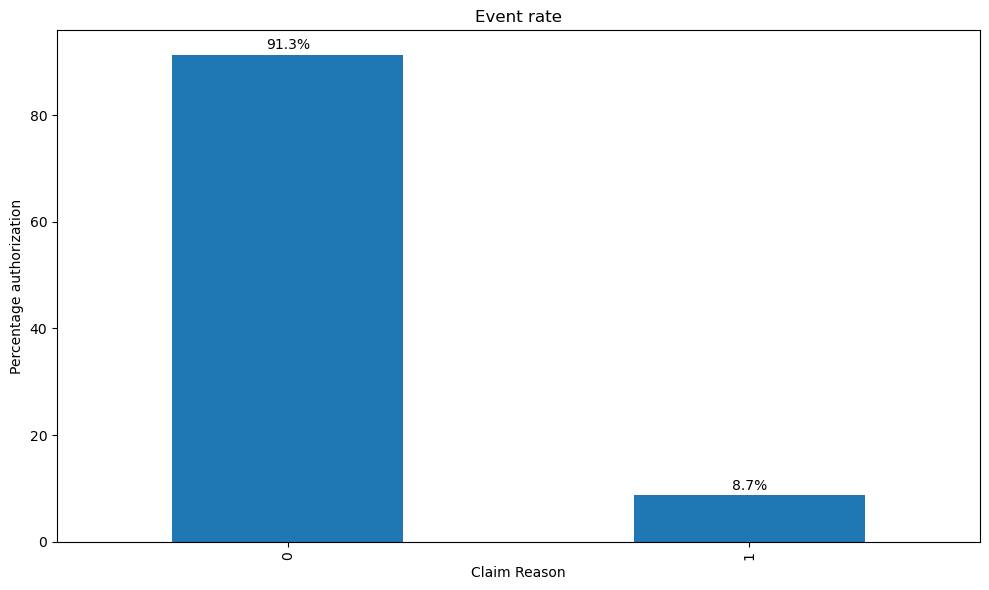

In [9]:
#Analysing reasons of claim cancellations and event rate

# Calculate the count and percentage of each claim reason
claim_reason_counts = appointments['cancellation_flag'].value_counts()
claim_reason_percentages = claim_reason_counts / claim_reason_counts.sum() * 100

# Plot the claim reasons and their percentages
fig, ax = plt.subplots(figsize=(10, 6))
claim_reason_percentages.plot(kind='bar', ax=ax)
ax.set_xlabel('Claim Reason')
ax.set_ylabel('Percentage authorization')
ax.set_title('Event rate')

# Add percentage labels to the plot
for i, v in enumerate(claim_reason_percentages):
    ax.text(i, v + 1, f'{v:.1f}%', ha='center')

plt.tight_layout()
plt.show()

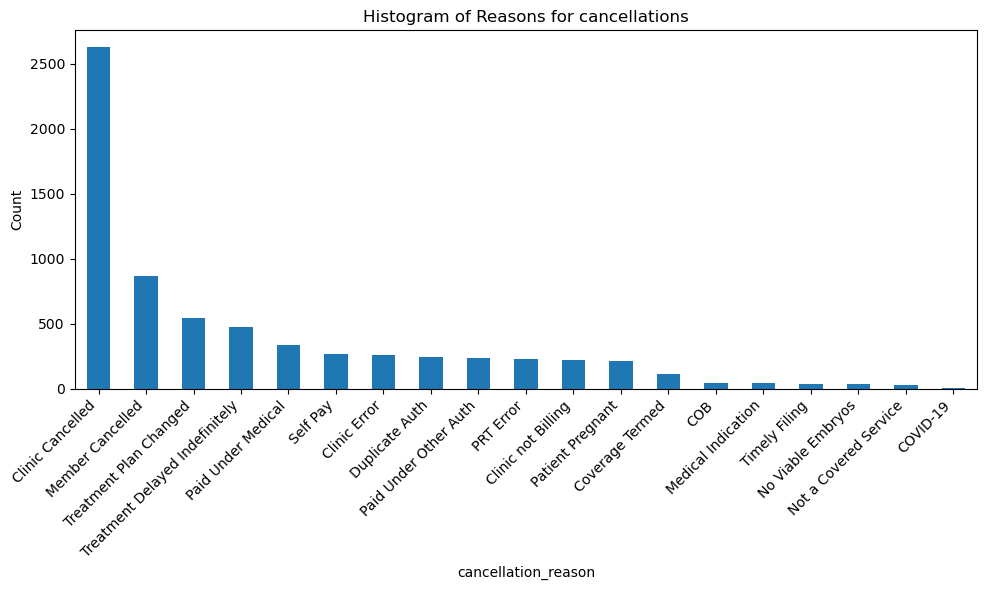

In [10]:
#Histogram of cancellation reasons
plt.figure(figsize=(10, 6))
appointments['cancellation_reason'].value_counts().plot(kind='bar')
plt.xlabel('cancellation_reason')
plt.ylabel('Count')
plt.title(f'Histogram of Reasons for cancellations')

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

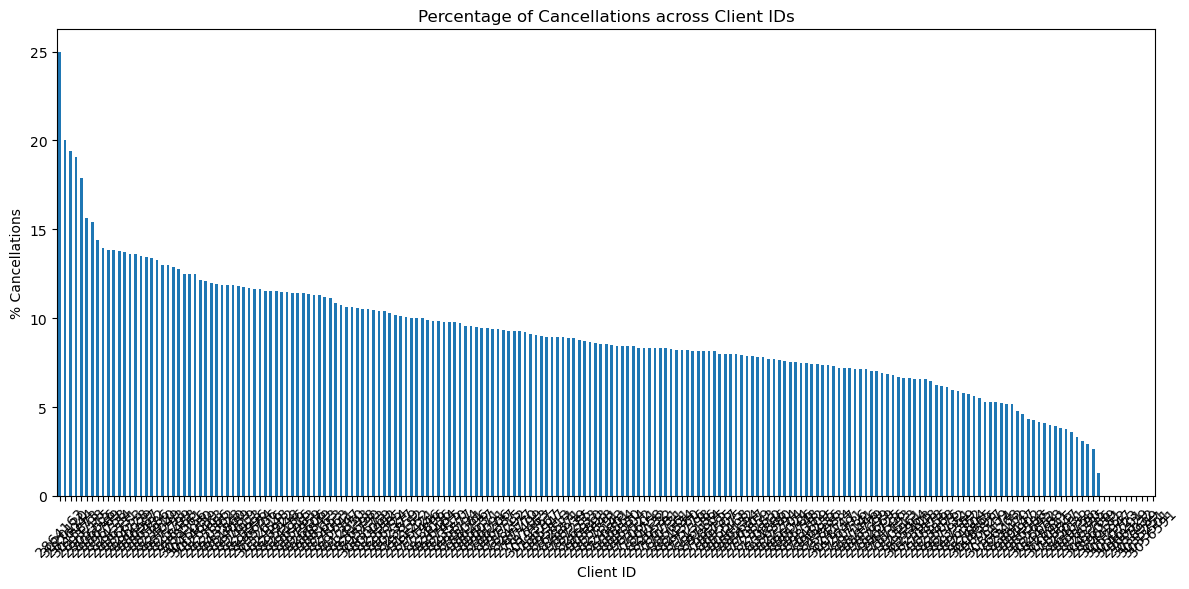

In [11]:
# Calculate the cancellation percentage for each client ID
cancellation_percentage = appointments.groupby('client_key')['cancellation_flag'].mean() * 100

# Sort the cancellation percentage in descending order
cancellation_percentage = cancellation_percentage.sort_values(ascending=False)

# Plot the cancellation percentage
plt.figure(figsize=(12, 6))
cancellation_percentage.plot(kind='bar')
plt.xlabel('Client ID')
plt.ylabel('% Cancellations')
plt.title('Percentage of Cancellations across Client IDs')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# ADS CREATION - 
1) Target group - All valid authorizations and Target variable - cancellation_flag
2) Merging the health care plan, claims, contact data with appointments table 
3) Feature engineering -Creating new features like #claims, #location,number of procedures per authorizations, one-hot    endcoding of procedures and contact subject channel
4) Exclusions- Removing several cancellation reasons that cannot be predicted with give data like -system error,  natural pregenacy
5) Output of this step will be analytical data set with right target authorization, target variable and features  

In [12]:

# Step 1: Identifying the healtcare plan a patient has. 
#         Merging the health plan data with health and patient mapping file

print(health_map.shape)

merged_health_plan= pd.merge(health_map, health_plan, left_on='member_health_plan_id_trans',right_on='member_health_plan_id',how='left')

#Checks on merged data 
print(merged_health_plan.shape)
print(find_level_data(merged_health_plan))

#patients with no healthcare mapping to be investigated and removed from analysis 
print(merged_health_plan['member_health_plan_id_trans'].isnull().sum())



(24062, 2)
(24062, 9)
['patient_id_trans']
1


patient_id_trans  member_health_plan_id_trans  member_health_plan_id  \
0           2404501                    2754850.0              2754850.0   
1           2404515                    2754252.0              2754252.0   
2           2404522                    2754209.0              2754209.0   
3           2404529                    2754253.0              2754253.0   
4           2404544                    2754858.0              2754858.0   

   plan_option1_deductible  plan_option1_coinsurance_member  \
0                    400.0                             10.0   
1                    400.0                             10.0   
2                    350.0                             10.0   
3                   1400.0                             10.0   
4                   1400.0                             10.0   

   plan_option1_copayment_medical  plan_option1_copayment_office_visit  \
0                             NaN                                  NaN   
1                             NaN                                  NaN   
2                             NaN                                  NaN   
3                             NaN                                  NaN   
4                             NaN                                  NaN   

   plan_option1_copayment_rx  plan_option1_maximum_out_of_pocket  
0                        NaN                              2000.0  
1                        NaN                              2000.0  
2                        NaN                              2000.0  
3                        NaN                              2600.0  
4                        NaN                              2600.0

In [13]:
print(len(set(appointments.patient_id)))
print(len(set(health_map.patient_id_trans)))
len(set(appointments.patient_id).intersection(set(health_map.patient_id_trans)))

33448
24062


10149

In [14]:
#Step 2: Merge claims data 

# Basic checks - No overlap between procedure codes in claims and appointment data. This must be investigated furthur 
print(len(set(claims['procedurecode'])))
print(len(set(appointments['primary_cpt'])))
print(len(set(claims['procedurecode']).intersection(set(appointments['primary_cpt']))))

267
87
0


In [15]:
#Creating new features like #claims, #procedures ,one hot encoding of the procedure 
#One hot encoding of procedures 
feature_column = 'procedurecode'

# Perform one-hot encoding on the feature column
encoded_data = pd.get_dummies(claims[feature_column], prefix=feature_column)

# Concatenate the encoded data with the original dataset
dataset_encoded = pd.concat([claims, encoded_data], axis=1)

#Feature 2 # claims per authorizations, number of providers per authorization and total procedures per authorizations

# Group by 'auth_num' and calculate the count of distinct 'claim_ud' and 'npi'

# Select columns starting with "procedurecode"
procedure_columns = [col for col in dataset_encoded.columns if col.startswith('procedurecode')]

# Group by "auth_num" and calculate count of distinct "claim_ud", count of distinct "npi", and sum of "procedurecode" columns
grouped_claims = dataset_encoded.groupby('auth_num').agg({
    'claim_ud': 'nunique',
    'npi': 'nunique',
    **{col: 'sum' for col in procedure_columns}
}).reset_index()


grouped_claims = grouped_claims.drop(['procedurecode','procedurecode_nm'],axis=1)
grouped_claims.shape

(74640, 270)

In [16]:
#Merging with appointments data with grouped_claims

auth_claims = pd.merge(appointments,grouped_claims, left_on='authorization_id',right_on='auth_num',how='left')
#check after merge
print(appointments.shape)
print(auth_claims.shape)


(92148, 9)
(92148, 279)


In [17]:
#Step 4 : One patient has multiple contact preference. Bringing data at patient id level so that it cam be mapped to appointments data 

# Use pivot_table to transpose the data
transposed_contact = contact.pivot_table(index='patient_id', columns='subject', aggfunc=len, fill_value=0)

# Reset the index to make 'patient_id' a regular column
transposed_contact.reset_index(inplace=True)
find_level_data(transposed_contact)

['patient_id']

In [55]:
#Mergting health plan and contact data
auth_ads0= pd.merge(auth_claims, merged_health_plan, left_on='patient_id',right_on='patient_id_trans', how='left')
print(auth_ads0.shape)

#Merging contact informatiom
auth_ads=pd.merge(auth_ads0,transposed_contact, left_on= 'patient_id' ,right_on='patient_id',how='left')
print(auth_ads.shape)
print(find_level_data(auth_ads))
print(set(auth_ads['cancellation_reason']))

(92148, 288)
(92148, 290)
['authorization_id']
{nan, 'Coverage Termed', 'Self Pay', 'Duplicate Auth', 'Member Cancelled', 'PRT Error', 'COB', 'Paid Under Medical', 'Paid Under Other Auth', 'Clinic not Billing', 'Treatment Plan Changed', 'Timely Filing', 'Medical Indication', 'Treatment Delayed Indefinitely', 'Patient Pregnant', 'Not a Covered Service', 'Clinic Error', 'Clinic Cancelled', 'No Viable Embryos', 'COVID-19'}


#CHECKS ON MERGED DATA SETS

In [56]:
#For 1300 cancelled authorization claims data is missing.
#To be investigated in univariate analysis. ~20% authorization in appopintment table dont have claims data. 
#83% of target does not have claims data

das= auth_ads[~auth_ads.auth_num.isnull()]

#Majority of event where authorization got cancelled 
print(das['cancellation_flag'].sum())
print(das['cancellation_flag'].count())

1300
72268


In [57]:
#Event rate drop to 1.79% from 8.6% if rows where auth_num is missing is removed

print('Original Event rate ')
print(auth_claims['cancellation_flag'].sum()/auth_claims.shape[0]*100)
print('Event rate if rows with missing claims data are removed')
print(das['cancellation_flag'].sum()/das.shape[0]*100)

Original Event rate 
8.69362330164518
Event rate if rows with missing claims data are removed
1.7988597996346931


In [58]:
#Removing cancellations 
#That are not true cancellations like 'Paid under other auth', 'Duplicate_auth'
#due to system error or natural pregnancy as we do not have any data on system details or biological indicators to predict such events
#If such event are not removed it will add noise  

remove_auth = ['Patient Pregnant','Paid Under Other Auth','Duplicate Auth','Not a Covered Service','Timely Filing']
auth_ads= auth_ads[~auth_ads['cancellation_reason'].isin(remove_auth)]

In [59]:
print(auth_ads.shape)
print('Original Event rate ')
print(auth_ads['cancellation_flag'].sum()/auth_ads.shape[0]*100)
auth_ads.columns

(91391, 290)
Original Event rate 
7.947172041010603


Index(['client_key', 'patient_id', 'appointment_number',
       'provider_location_id', 'authorization_id', 'primary_cpt',
       'auth_status', 'cancellation_flag', 'cancellation_reason', 'auth_num',
       ...
       'member_health_plan_id_trans', 'member_health_plan_id',
       'plan_option1_deductible', 'plan_option1_coinsurance_member',
       'plan_option1_copayment_medical', 'plan_option1_copayment_office_visit',
       'plan_option1_copayment_rx', 'plan_option1_maximum_out_of_pocket',
       'Call', 'Email'],
      dtype='object', length=290)

In [60]:
#Dropping unnecessary columns 
drop_cols= ['patient_id','auth_num','appointment_number','claim_ud','member_health_plan_id','member_health_plan_id_trans','patient_id_trans','auth_status']
auth_ads.drop(columns= drop_cols,inplace=True)
print(auth_ads.shape)

(91391, 282)


# Insights:
    1) Claims data is missing key information of cancelled authorizations- source of data amust be checked.
    2) Cancellations due system error, human error and natural pregnancy cannot be predicted with the given data 
       hence should be excluded from the analysis 
    3) Final event rate after exclusion is 7.9%

# Univariate analysis
1) Analyzing variable distributions and assessing if missing value, outlier or any other data treatment required
2) Output store in numerical_summary.csv and categorical_summary.csv

In [61]:
#EDA -Univariate 
def univariate_analysis(dataset):
    
    # Identify numerical and categorical variables
    numerical_vars = dataset.select_dtypes(include=np.number).columns.tolist()
    categorical_vars = dataset.select_dtypes(include='object').columns.tolist()
    
    # Summary statistics for numerical variables
    numerical_summary = dataset[numerical_vars].describe().T
    numerical_summary['VAR_NAME'] = numerical_summary.index
    numerical_summary['NMISS'] = dataset[numerical_vars].isnull().sum()
    numerical_summary['MISSING_PERCENT'] = (numerical_summary['NMISS'] / dataset.shape[0]) * 100
    numerical_summary = numerical_summary[['VAR_NAME', 'count', 'NMISS', 'MISSING_PERCENT', 'mean', 'std', '50%', 'min', 'max', '25%','75%']]
    numerical_summary.columns = ['VAR_NAME', 'N', 'NMISS', 'MISSING_PERCENT', 'MEAN', 'STD', 'MEDIAN', 'MIN', 'MAX', 'P-25','P-75']
    numerical_summary['SUM'] = dataset[numerical_vars].sum()
    numerical_summary['SKEWNESS'] = dataset[numerical_vars].skew()
    numerical_summary['KURTOSIS'] = dataset[numerical_vars].kurt()

    # Frequency analysis for categorical variables
    categorical_summary = pd.DataFrame(columns=['LEVELS', 'FREQUENCY', 'PERCENT', 'VAR_NAME'])
    for var in categorical_vars:
        frequencies = dataset[var].value_counts().reset_index()
        frequencies.columns = ['LEVELS', 'FREQUENCY']
        frequencies['PERCENT'] = (frequencies['FREQUENCY'] / dataset.shape[0]) * 100
        frequencies['VAR_NAME'] = var
        categorical_summary = categorical_summary.append(frequencies, ignore_index=True)

    # Print the summary statistics
    print("Numerical Variables Summary:save in numerical_summary.csv")
    numerical_summary.to_csv('numerical_summary.csv',index=False)
    print("\nCategorical Variables Summary:")
    categorical_summary.to_csv('categorical_summary.csv',index=False)

In [62]:
univariate_analysis(auth_ads)

Numerical Variables Summary:save in numerical_summary.csv

Categorical Variables Summary:


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


## Findings
### Only 17% (1300) of target cancelled authorizations have claims data. Rest 73% of targets do not have claims data
### ~20% authorizations in appopintment table dont have claims data.  
###  
#Reasons of missing data must be investigated.


In [63]:
# actual targets- tagets with non-missing claims data
print((auth_ads['cancellation_flag'].sum()-das['cancellation_flag'].sum()))

5963


In [64]:
#List of column with missing values 
missing_columns = auth_ads.columns[auth_ads.isnull().any()].tolist()
print(missing_columns)

['cancellation_reason', 'npi', 'procedurecode_377895', 'procedurecode_377896', 'procedurecode_377897', 'procedurecode_377898', 'procedurecode_377899', 'procedurecode_377900', 'procedurecode_377901', 'procedurecode_377902', 'procedurecode_377904', 'procedurecode_377913', 'procedurecode_377915', 'procedurecode_377916', 'procedurecode_377917', 'procedurecode_377918', 'procedurecode_377919', 'procedurecode_377920', 'procedurecode_377921', 'procedurecode_377922', 'procedurecode_377925', 'procedurecode_377926', 'procedurecode_377928', 'procedurecode_377933', 'procedurecode_377934', 'procedurecode_377936', 'procedurecode_377938', 'procedurecode_377941', 'procedurecode_377946', 'procedurecode_377947', 'procedurecode_377948', 'procedurecode_377950', 'procedurecode_377952', 'procedurecode_377953', 'procedurecode_377954', 'procedurecode_377955', 'procedurecode_377956', 'procedurecode_377957', 'procedurecode_377958', 'procedurecode_377959', 'procedurecode_377960', 'procedurecode_377962', 'procedur

In [65]:
#20% row for claims data missing due to partial sharing of claims data. of total 8k cancellation 5.9k cancellations have claims data missing. 
#Hence not removing rows and substituting values with zero. 

def missing_value_treatment(data, imputation_methods=None):
    """
    Perform missing value treatment on a DataFrame.
    Args:
        data (pd.DataFrame): Input DataFrame with missing values.
        imputation_methods (dict): Dictionary of variables as keys and imputation methods as values.
                                   Available methods: 'mean', 'median', 'mode', 'ffill', 'bfill', 'custom'
    Returns:
        pd.DataFrame: DataFrame with missing values treated.
    """
    missing_columns = data.columns[data.isnull().any()].tolist()
    
    # Drop columns with 90% or more missing values
    missing_threshold = 0.9
    columns_to_drop = [col for col in missing_columns if data[col].isnull().mean() >= missing_threshold]
    data.drop(columns_to_drop, axis=1, inplace=True)
    print(f"Dropping '{columns_to_drop}' as missing value is >90%" )
    for col in missing_columns:
        if col in imputation_methods:
            method = imputation_methods[col]
            if method == 'mean':
                data[col].fillna(data[col].mean(), inplace=True)
            elif method == 'median':
                data[col].fillna(data[col].median(), inplace=True)
            elif method == 'mode':
                data[col].fillna(data[col].mode()[0], inplace=True)
            elif method == 'Zero':
                data[col].fillna(0, inplace=True)
            elif method == 'custom':
                # Iterate through each procedure code
                for code in data['primary_cpt']:
                    print(code) # Check if the one-hot encoded variable for the code exists
                    if f'procedurecode_{code}' in data.columns:
                        # Update the corresponding one-hot encoded variable by adding 1
                        data[f'procedurecode_{code}'] += 1
                        print(code)
                pass
            else:
                print(f"Invalid imputation method specified for column '{col}'. Skipping imputation.")
        else:
            print(f"No imputation method specified for column '{col}'. Skipping imputation.")

    return data


In [66]:
#Replacing all the NAN in procedure code with zero 
imputation_methods = {}
prefix = "procedurecode"  # Specify the prefix

for col in auth_ads.columns:
    if col.startswith(prefix):
        imputation_methods[col] = 'Zero'

cleaned_data = missing_value_treatment(auth_ads, imputation_methods=imputation_methods)

Dropping '['cancellation_reason', 'plan_option1_copayment_medical', 'plan_option1_copayment_office_visit', 'plan_option1_copayment_rx']' as missing value is >90%
No imputation method specified for column 'cancellation_reason'. Skipping imputation.
No imputation method specified for column 'npi'. Skipping imputation.
No imputation method specified for column 'plan_option1_deductible'. Skipping imputation.
No imputation method specified for column 'plan_option1_coinsurance_member'. Skipping imputation.
No imputation method specified for column 'plan_option1_copayment_medical'. Skipping imputation.
No imputation method specified for column 'plan_option1_copayment_office_visit'. Skipping imputation.
No imputation method specified for column 'plan_option1_copayment_rx'. Skipping imputation.
No imputation method specified for column 'plan_option1_maximum_out_of_pocket'. Skipping imputation.
No imputation method specified for column 'Call'. Skipping imputation.
No imputation method specified 

In [67]:
# 1) Using mode method to impute missing in call and email columns assuming that missing values is same as most frequent values of in dataset. 
#    This method is less likely to introduce ant bias
#2)  Imputing health plan variables with zero as here NAN represents that the patient have not opted for particular plan option
#3)  Using median to impute Npi i.e #service providers patient go to under on authorization as missing values are likely to be closer to what average population does
imputation_methods = {
    'Call': 'mode',
    'Email': 'mode',
    'plan_option1_deductible':'Zero',
    'plan_option1_coinsurance_member':'Zero',
    'plan_option1_maximum_out_of_pocket':'Zero',
    'npi': 'median',
}
cleaned_data = missing_value_treatment(auth_ads, imputation_methods=imputation_methods)

Dropping '[]' as missing value is >90%


In [70]:
print(auth_ads['cancellation_reason'])

KeyError: 'cancellation_reason'

In [71]:
#dropping cancellation reasons and id as they are not the predictor variables
auth_ads.drop(columns=['authorization_id'],axis=1 ,inplace=True)

# Bivariate analysis
1) Using box plot to visualize relatioship between variables and traget variable
2) Performing ANOVA test to identify if some retaionship exists between independent and target variable
3) Target variable 1 denotes cancelled claims and 0 denotes uncancelled claims
3) Outcome is assessment of relationships and type of predictors. This will help in selecting the right algorithm

In [72]:
def bivar(dataset):
# Identify numerical and categorical variables
    numerical_vars = dataset.select_dtypes(include=np.number).columns.tolist()
    cat_var = 'cancellation_flag'

    # Bivariate analysis for numerical and categorical columns
    for num_var in numerical_vars:
 
        # Create a box plot
        plt.figure(figsize=(10, 6))
        sns.boxplot(x=cat_var, y=num_var, data=dataset)
        plt.xlabel(cat_var)
        plt.ylabel(num_var)
        plt.title(f"Bivariate Analysis: {num_var} vs {cat_var}")
        plt.show()


        # Calculate and print descriptive statistics
        grouped_stats = dataset.groupby(cat_var)[num_var].describe()
        print(f"\nDescriptive Statistics for {num_var} by {cat_var}:\n")
        print(grouped_stats)

        print("\n---------------------------------------\n")

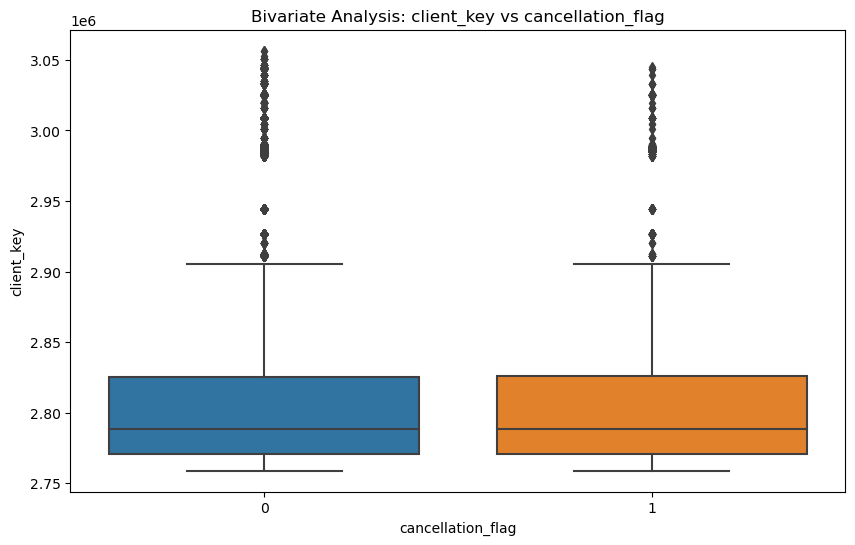


Descriptive Statistics for client_key by cancellation_flag:

                     count          mean           std        min        25%  \
cancellation_flag                                                              
0                  84128.0  2.818204e+06  71397.514069  2758975.0  2770601.0   
1                   7263.0  2.819686e+06  70358.017177  2758975.0  2770731.0   

                         50%        75%        max  
cancellation_flag                                   
0                  2788292.0  2825463.0  3056591.0  
1                  2788292.0  2826044.0  3045080.0  

---------------------------------------



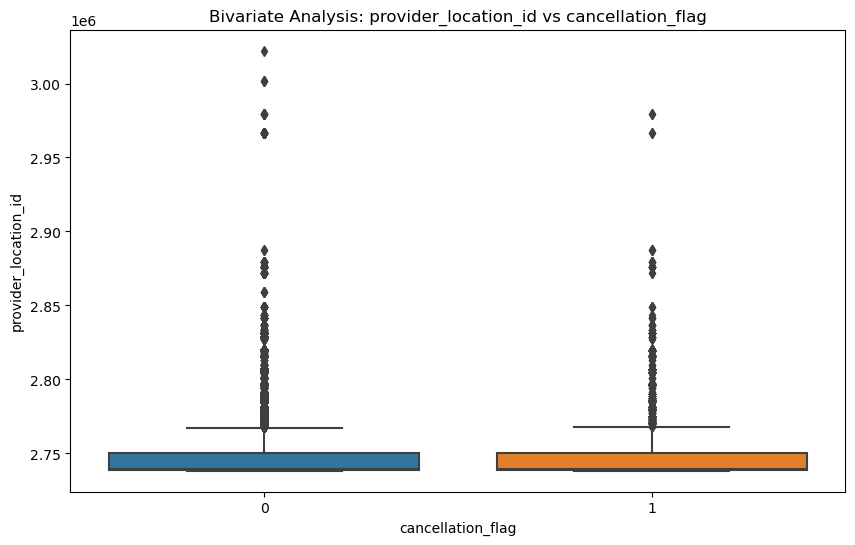


Descriptive Statistics for provider_location_id by cancellation_flag:

                     count          mean           std        min        25%  \
cancellation_flag                                                              
0                  84128.0  2.748081e+06  19374.722378  2738315.0  2738415.0   
1                   7263.0  2.748495e+06  19698.051872  2738315.0  2738415.0   

                         50%        75%        max  
cancellation_flag                                   
0                  2739229.0  2749960.0  3022261.0  
1                  2739468.0  2750256.0  2979075.0  

---------------------------------------



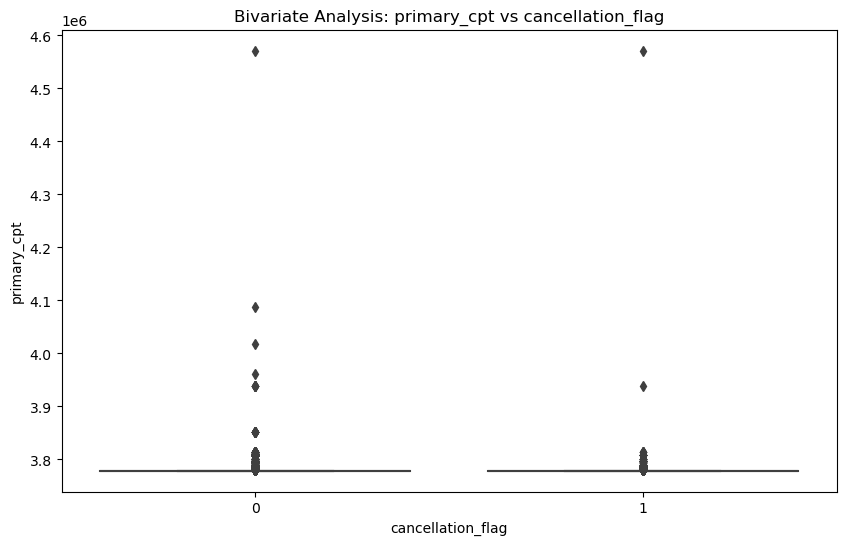


Descriptive Statistics for primary_cpt by cancellation_flag:

                     count          mean          std        min        25%  \
cancellation_flag                                                             
0                  84128.0  3.779637e+06  4778.427287  3778955.0  3778972.0   
1                   7263.0  3.779771e+06  9900.034638  3778955.0  3778972.0   

                         50%        75%        max  
cancellation_flag                                   
0                  3778987.0  3779001.0  4571174.0  
1                  3778987.0  3779001.0  4571174.0  

---------------------------------------



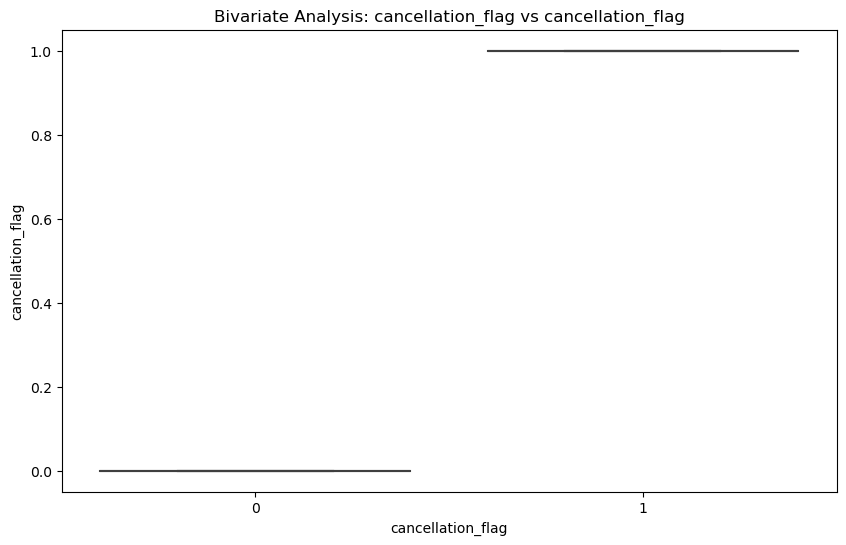


Descriptive Statistics for cancellation_flag by cancellation_flag:

                     count  mean  std  min  25%  50%  75%  max
cancellation_flag                                             
0                  84128.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
1                   7263.0   1.0  0.0  1.0  1.0  1.0  1.0  1.0

---------------------------------------



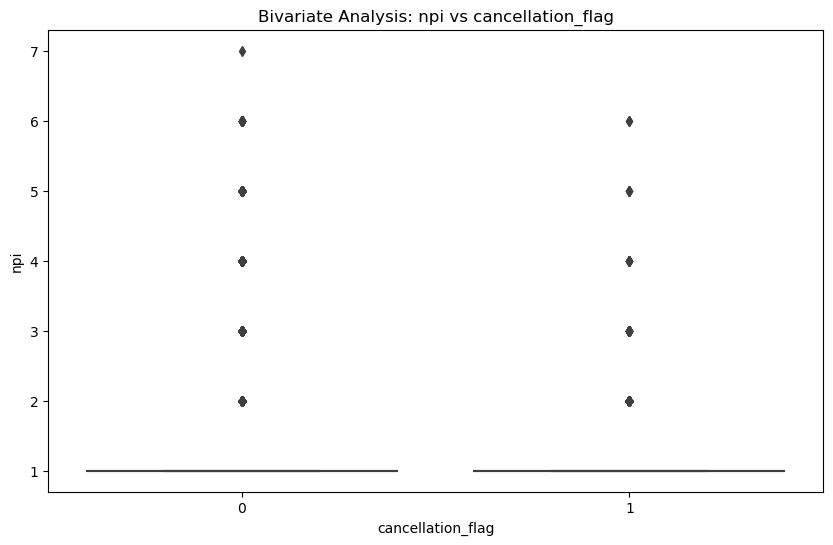


Descriptive Statistics for npi by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  1.265334  0.621635  1.0  1.0  1.0  1.0  7.0
1                   7263.0  1.047501  0.271326  1.0  1.0  1.0  1.0  6.0

---------------------------------------



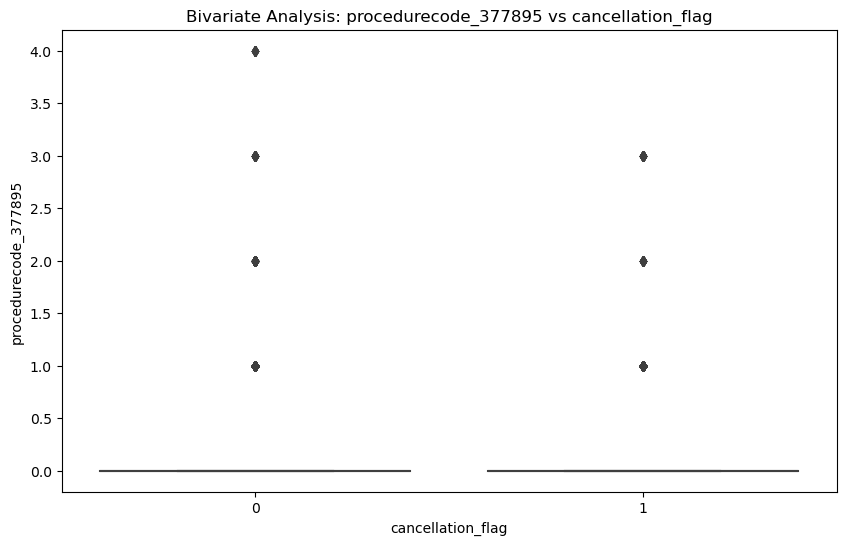


Descriptive Statistics for procedurecode_377895 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.162217  0.375710  0.0  0.0  0.0  0.0  4.0
1                   7263.0  0.053972  0.287642  0.0  0.0  0.0  0.0  3.0

---------------------------------------



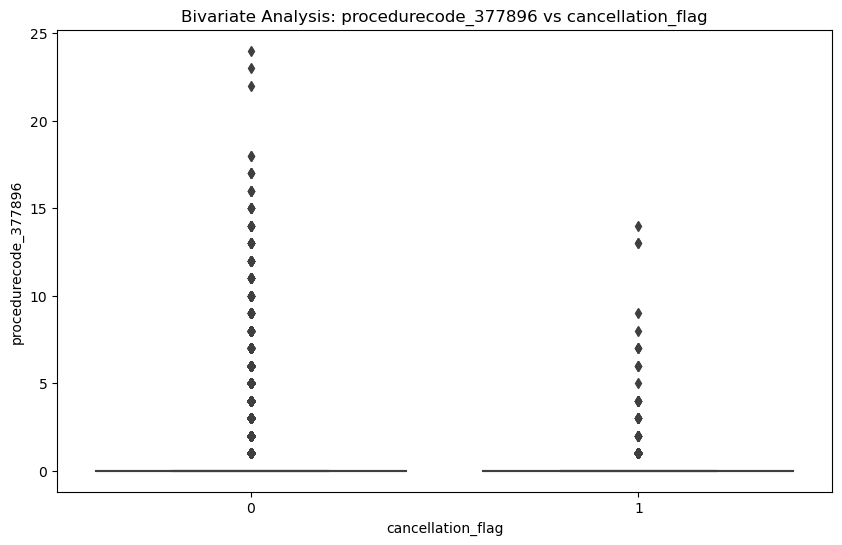


Descriptive Statistics for procedurecode_377896 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%   max
cancellation_flag                                                       
0                  84128.0  0.256633  0.926837  0.0  0.0  0.0  0.0  24.0
1                   7263.0  0.050805  0.437541  0.0  0.0  0.0  0.0  14.0

---------------------------------------



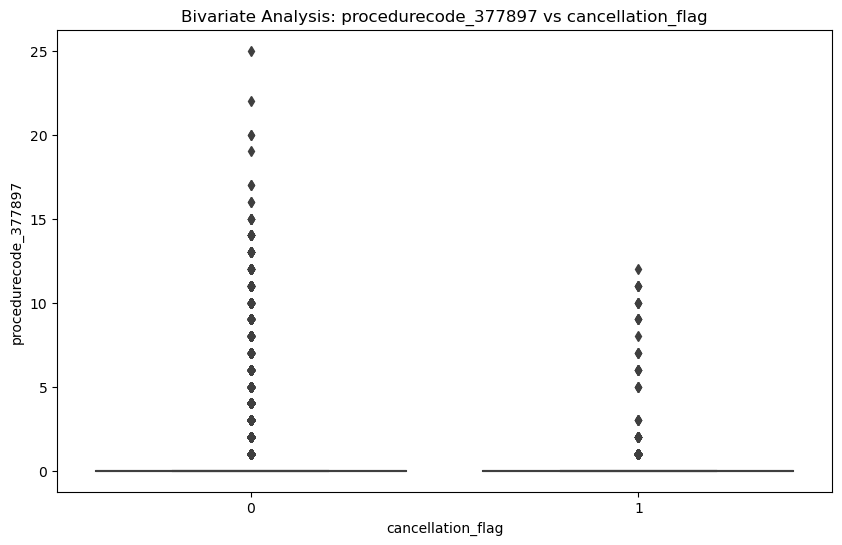


Descriptive Statistics for procedurecode_377897 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%   max
cancellation_flag                                                       
0                  84128.0  0.283568  1.061502  0.0  0.0  0.0  0.0  25.0
1                   7263.0  0.060719  0.536755  0.0  0.0  0.0  0.0  12.0

---------------------------------------



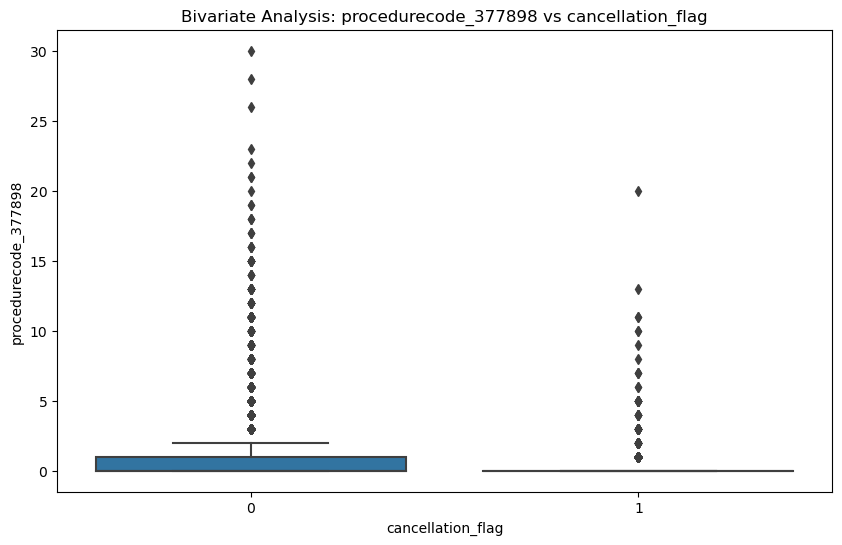


Descriptive Statistics for procedurecode_377898 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%   max
cancellation_flag                                                       
0                  84128.0  0.438617  1.040579  0.0  0.0  0.0  1.0  30.0
1                   7263.0  0.097756  0.588679  0.0  0.0  0.0  0.0  20.0

---------------------------------------



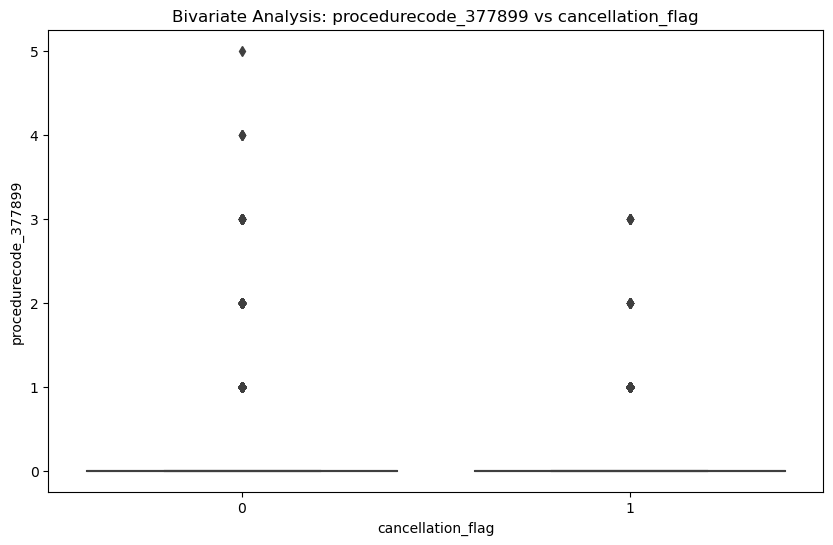


Descriptive Statistics for procedurecode_377899 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.181640  0.395533  0.0  0.0  0.0  0.0  5.0
1                   7263.0  0.047639  0.238626  0.0  0.0  0.0  0.0  3.0

---------------------------------------



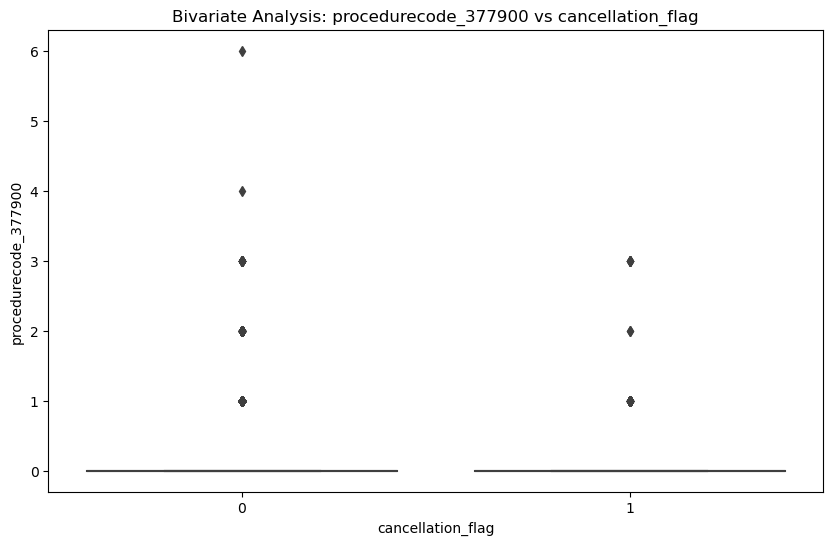


Descriptive Statistics for procedurecode_377900 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.056533  0.240431  0.0  0.0  0.0  0.0  6.0
1                   7263.0  0.011565  0.130159  0.0  0.0  0.0  0.0  3.0

---------------------------------------



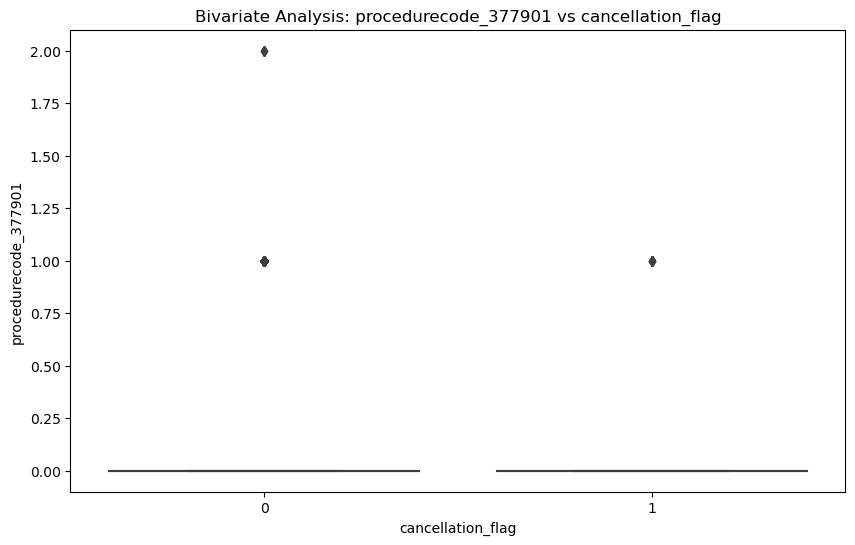


Descriptive Statistics for procedurecode_377901 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.002722  0.052782  0.0  0.0  0.0  0.0  2.0
1                   7263.0  0.000964  0.031032  0.0  0.0  0.0  0.0  1.0

---------------------------------------



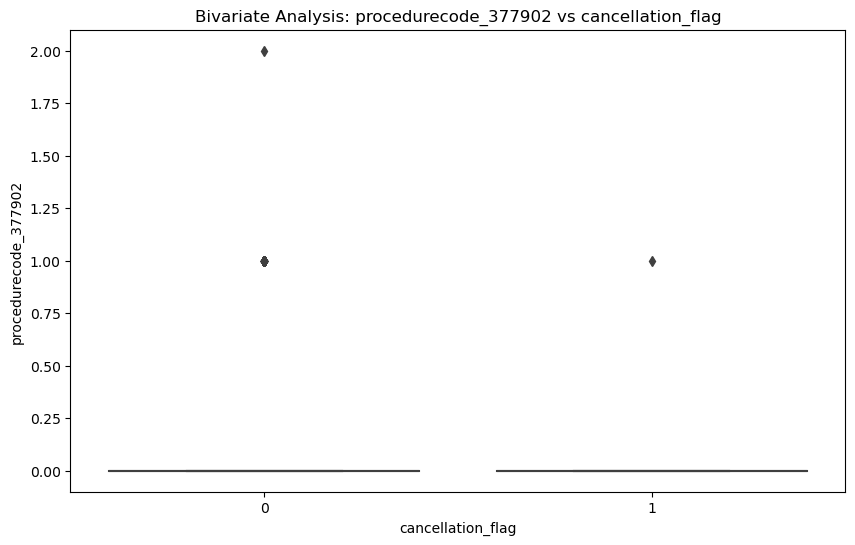


Descriptive Statistics for procedurecode_377902 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000903  0.030436  0.0  0.0  0.0  0.0  2.0
1                   7263.0  0.000138  0.011734  0.0  0.0  0.0  0.0  1.0

---------------------------------------



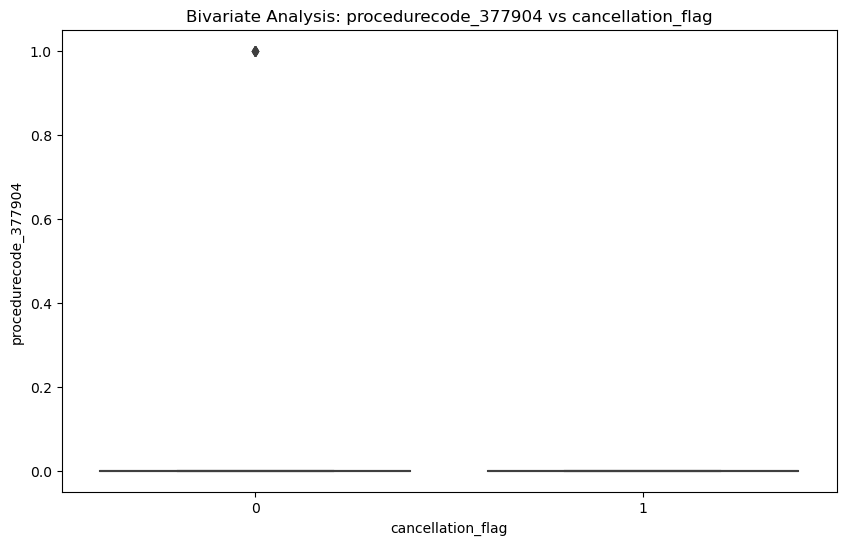


Descriptive Statistics for procedurecode_377904 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000059  0.007709  0.0  0.0  0.0  0.0  1.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



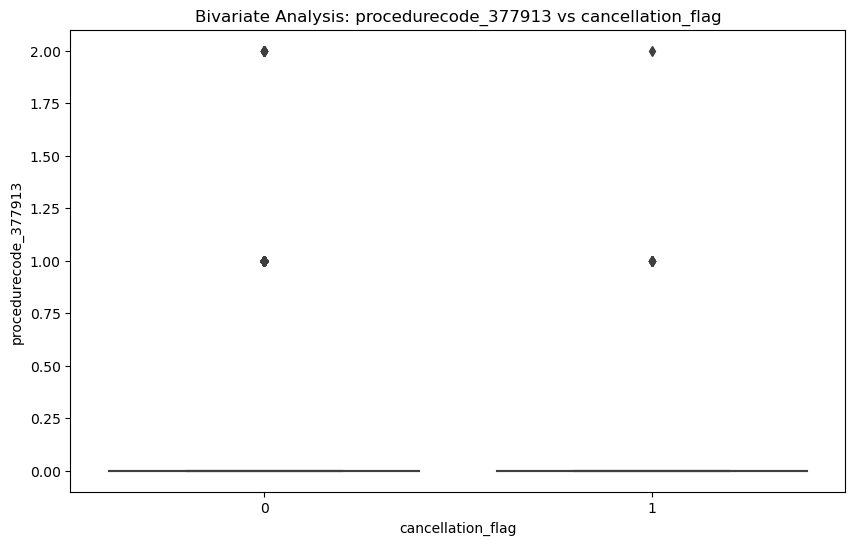


Descriptive Statistics for procedurecode_377913 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.004505  0.068893  0.0  0.0  0.0  0.0  2.0
1                   7263.0  0.001377  0.040627  0.0  0.0  0.0  0.0  2.0

---------------------------------------



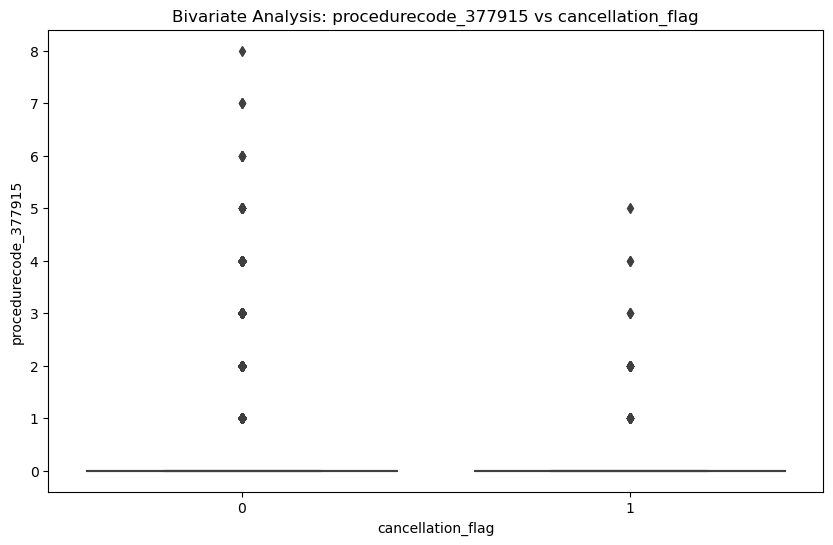


Descriptive Statistics for procedurecode_377915 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.138872  0.529970  0.0  0.0  0.0  0.0  8.0
1                   7263.0  0.012942  0.166278  0.0  0.0  0.0  0.0  5.0

---------------------------------------



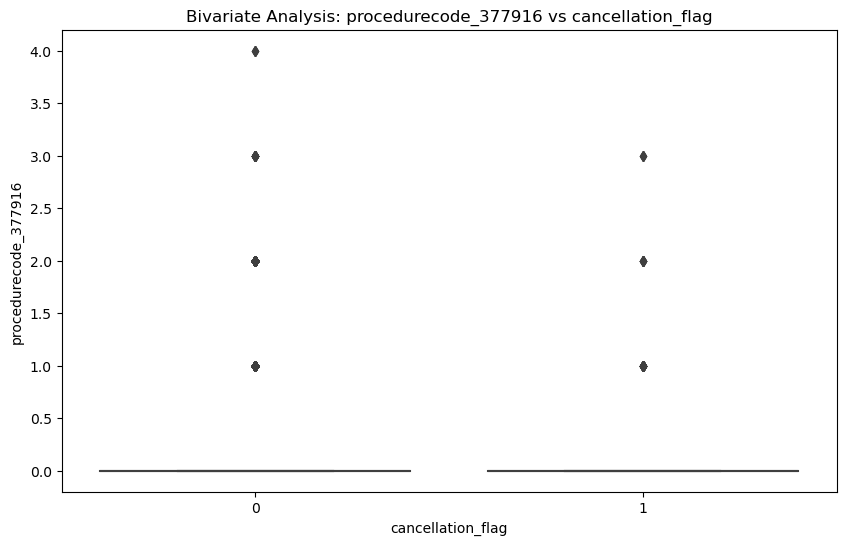


Descriptive Statistics for procedurecode_377916 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.060372  0.288052  0.0  0.0  0.0  0.0  4.0
1                   7263.0  0.007573  0.109192  0.0  0.0  0.0  0.0  3.0

---------------------------------------



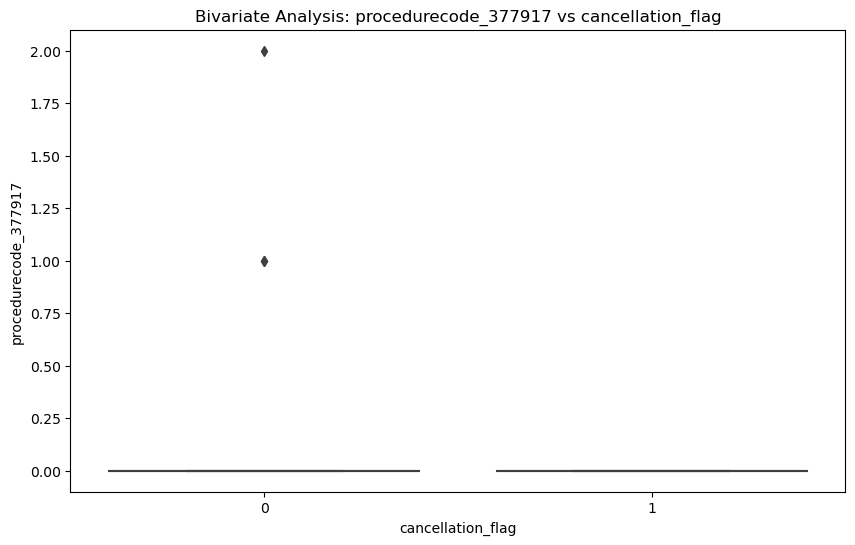


Descriptive Statistics for procedurecode_377917 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000048  0.008445  0.0  0.0  0.0  0.0  2.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



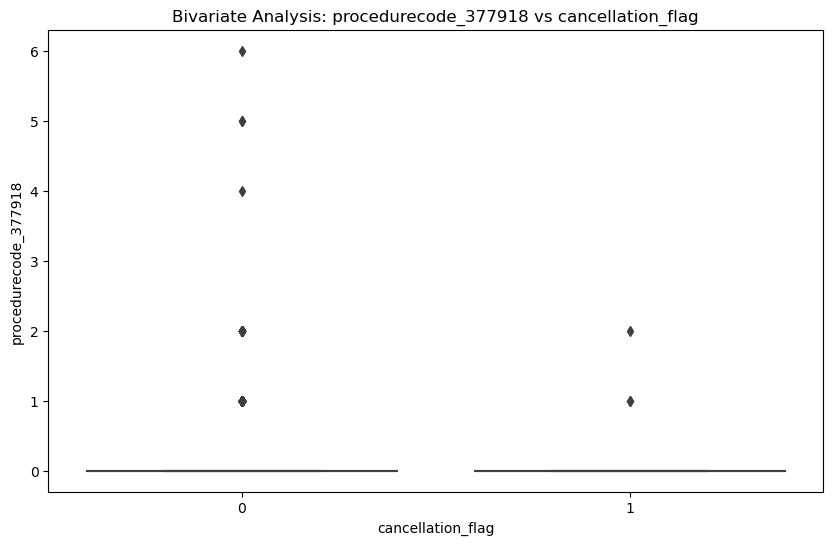


Descriptive Statistics for procedurecode_377918 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.002365  0.061145  0.0  0.0  0.0  0.0  6.0
1                   7263.0  0.000551  0.028739  0.0  0.0  0.0  0.0  2.0

---------------------------------------



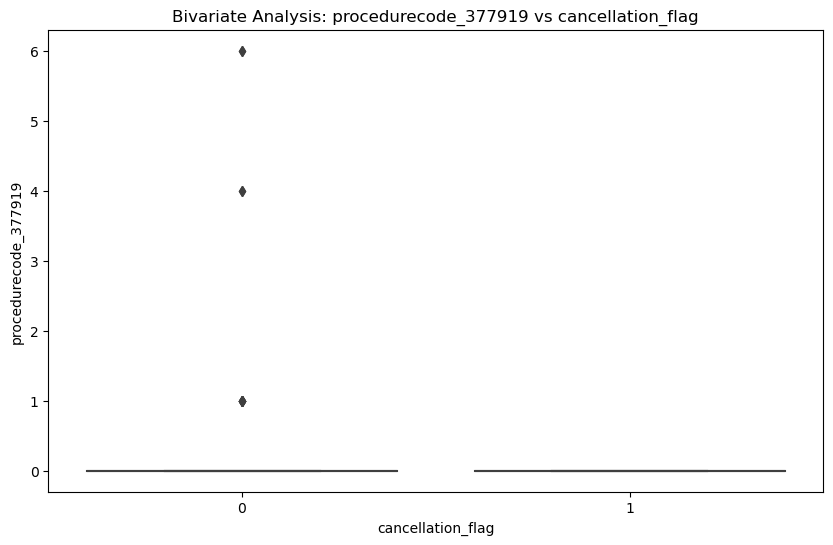


Descriptive Statistics for procedurecode_377919 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000321  0.036323  0.0  0.0  0.0  0.0  6.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



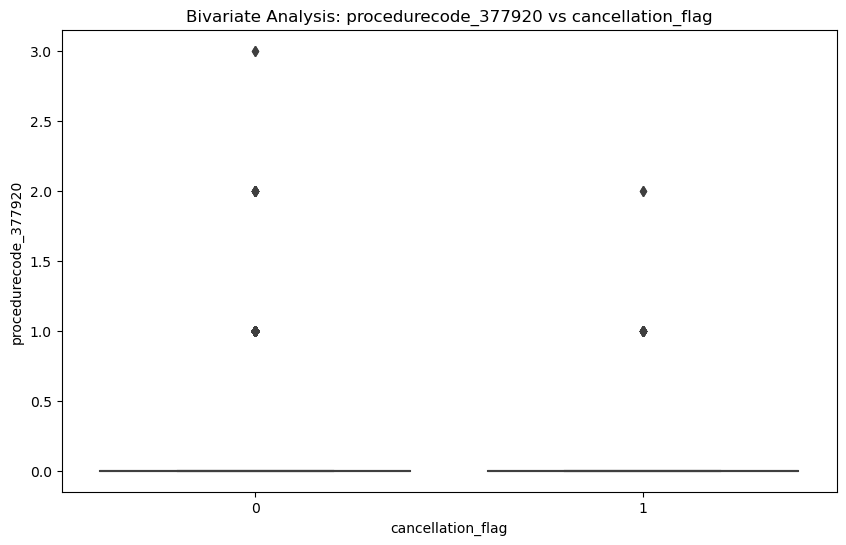


Descriptive Statistics for procedurecode_377920 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.012433  0.112936  0.0  0.0  0.0  0.0  3.0
1                   7263.0  0.003580  0.064174  0.0  0.0  0.0  0.0  2.0

---------------------------------------



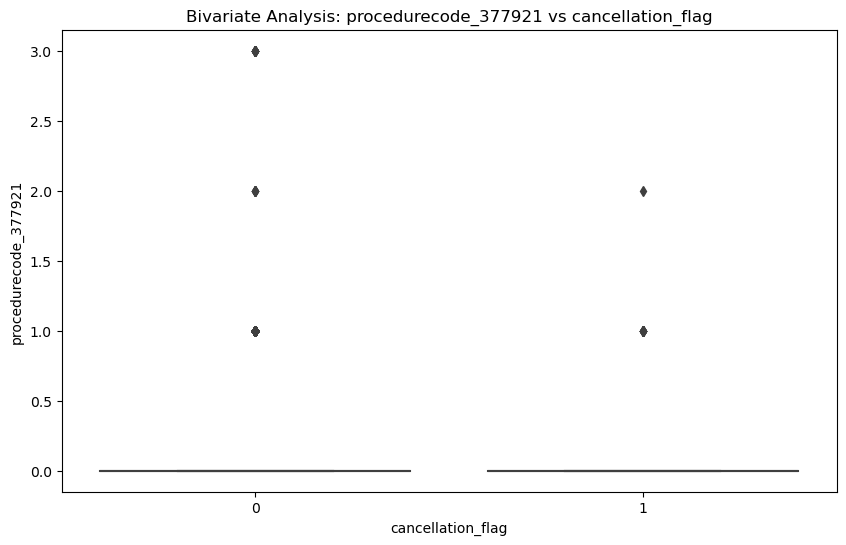


Descriptive Statistics for procedurecode_377921 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.008344  0.097036  0.0  0.0  0.0  0.0  3.0
1                   7263.0  0.001790  0.045413  0.0  0.0  0.0  0.0  2.0

---------------------------------------



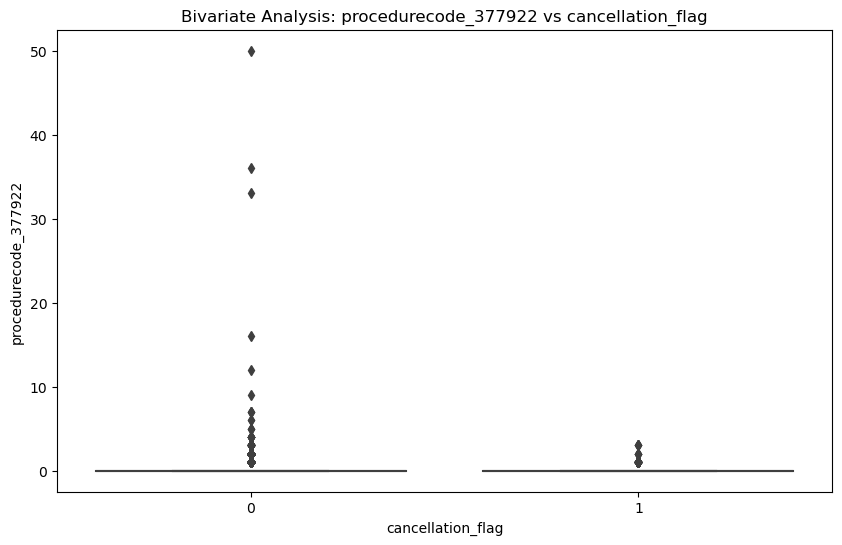


Descriptive Statistics for procedurecode_377922 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%   max
cancellation_flag                                                       
0                  84128.0  0.095093  0.409151  0.0  0.0  0.0  0.0  50.0
1                   7263.0  0.019827  0.155300  0.0  0.0  0.0  0.0   3.0

---------------------------------------



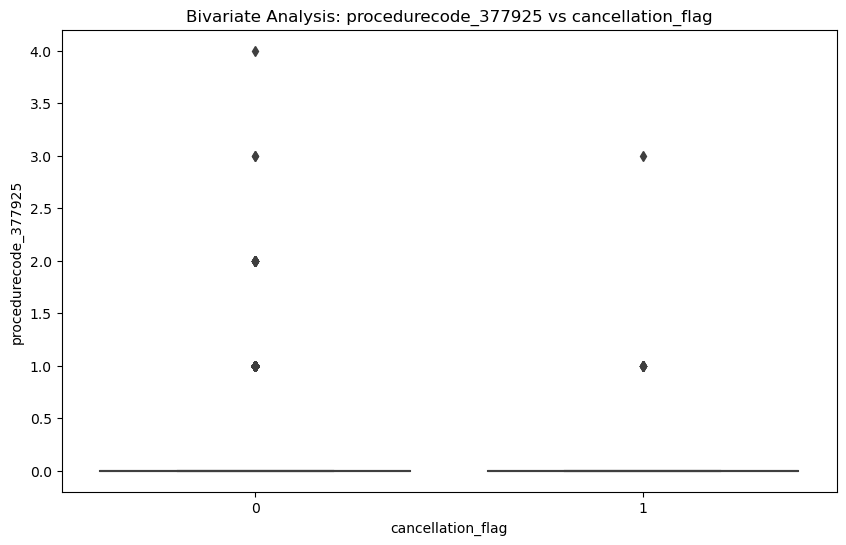


Descriptive Statistics for procedurecode_377925 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.008606  0.095904  0.0  0.0  0.0  0.0  4.0
1                   7263.0  0.001652  0.049759  0.0  0.0  0.0  0.0  3.0

---------------------------------------



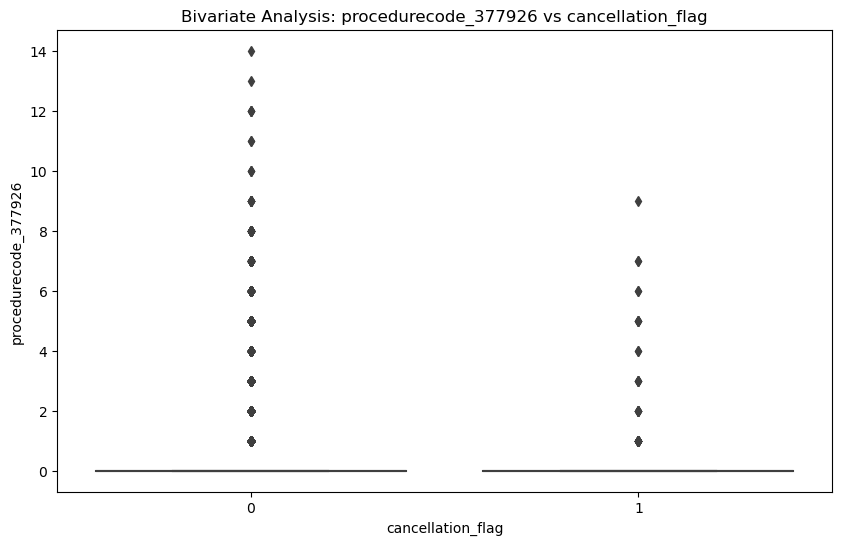


Descriptive Statistics for procedurecode_377926 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%   max
cancellation_flag                                                       
0                  84128.0  0.071712  0.549805  0.0  0.0  0.0  0.0  14.0
1                   7263.0  0.014870  0.252335  0.0  0.0  0.0  0.0   9.0

---------------------------------------



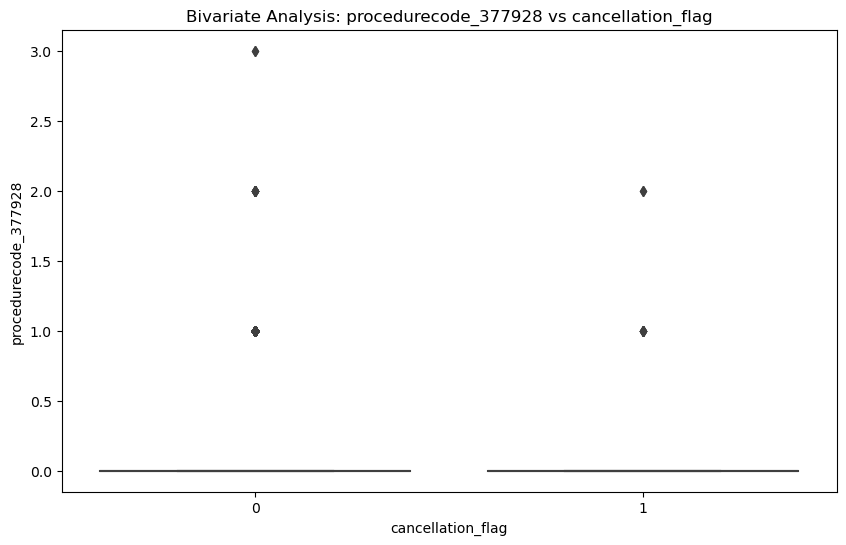


Descriptive Statistics for procedurecode_377928 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.012980  0.115064  0.0  0.0  0.0  0.0  3.0
1                   7263.0  0.001652  0.046910  0.0  0.0  0.0  0.0  2.0

---------------------------------------



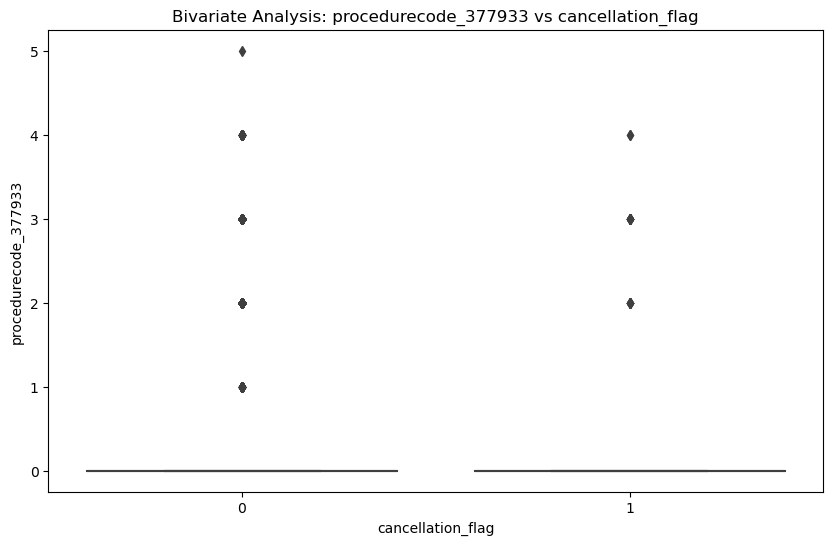


Descriptive Statistics for procedurecode_377933 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.023001  0.248631  0.0  0.0  0.0  0.0  5.0
1                   7263.0  0.007848  0.149613  0.0  0.0  0.0  0.0  4.0

---------------------------------------



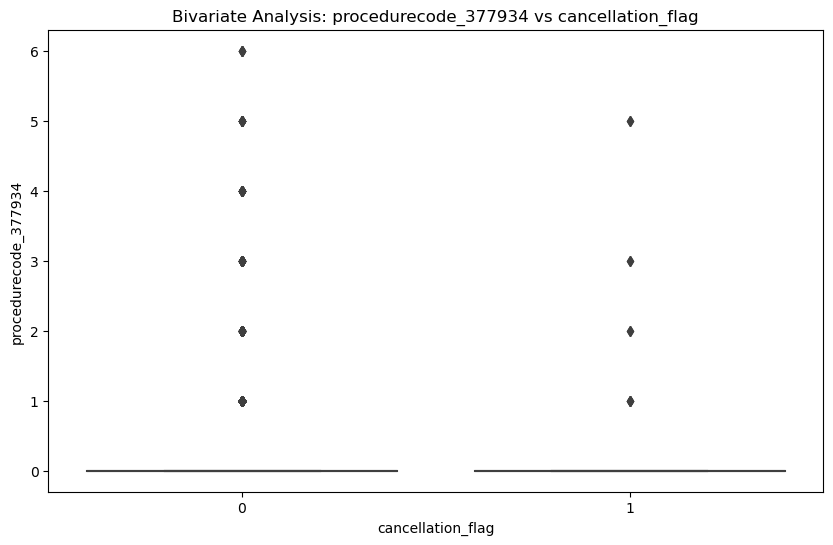


Descriptive Statistics for procedurecode_377934 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.011102  0.155860  0.0  0.0  0.0  0.0  6.0
1                   7263.0  0.003304  0.104906  0.0  0.0  0.0  0.0  5.0

---------------------------------------



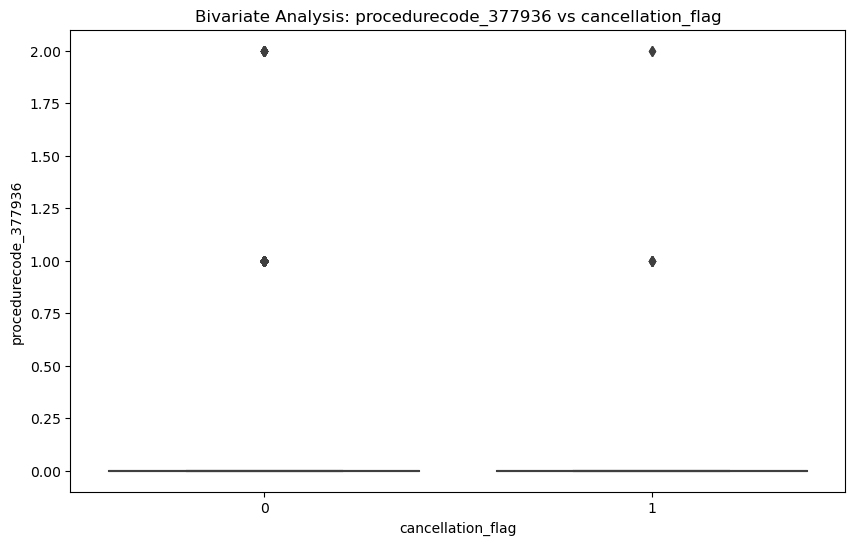


Descriptive Statistics for procedurecode_377936 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.003411  0.063011  0.0  0.0  0.0  0.0  2.0
1                   7263.0  0.001377  0.043886  0.0  0.0  0.0  0.0  2.0

---------------------------------------



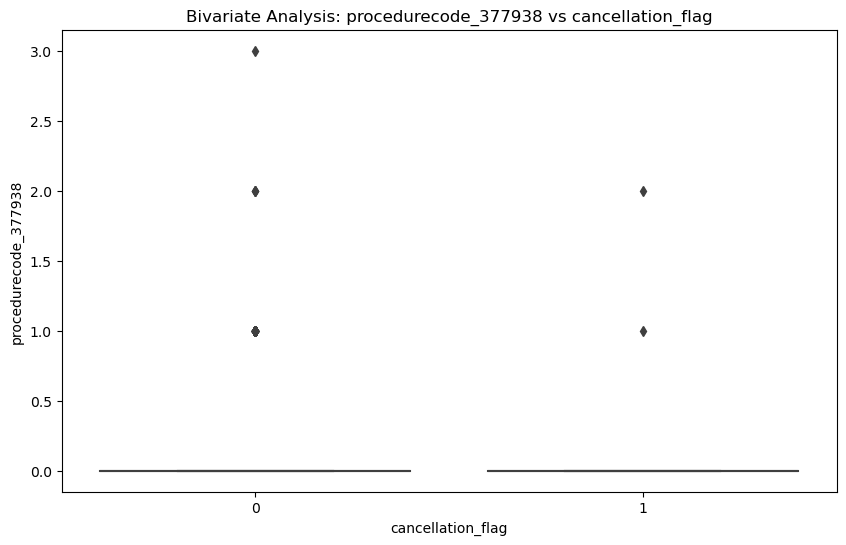


Descriptive Statistics for procedurecode_377938 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.001379  0.038982  0.0  0.0  0.0  0.0  3.0
1                   7263.0  0.000413  0.026236  0.0  0.0  0.0  0.0  2.0

---------------------------------------



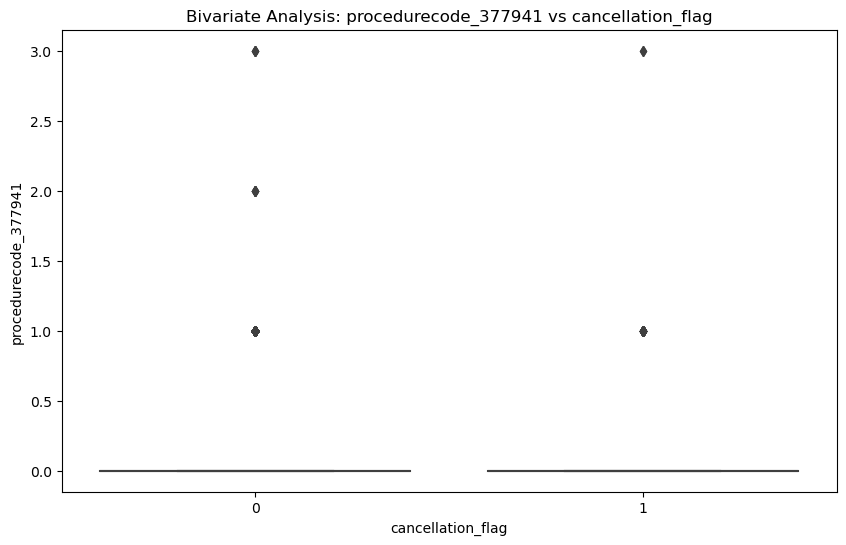


Descriptive Statistics for procedurecode_377941 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.012006  0.110858  0.0  0.0  0.0  0.0  3.0
1                   7263.0  0.006609  0.090656  0.0  0.0  0.0  0.0  3.0

---------------------------------------



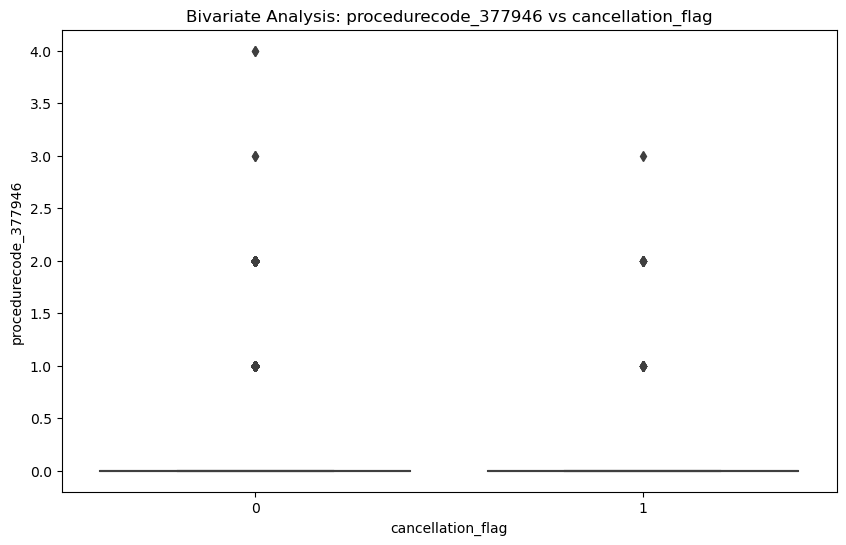


Descriptive Statistics for procedurecode_377946 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.016629  0.165337  0.0  0.0  0.0  0.0  4.0
1                   7263.0  0.004819  0.091524  0.0  0.0  0.0  0.0  3.0

---------------------------------------



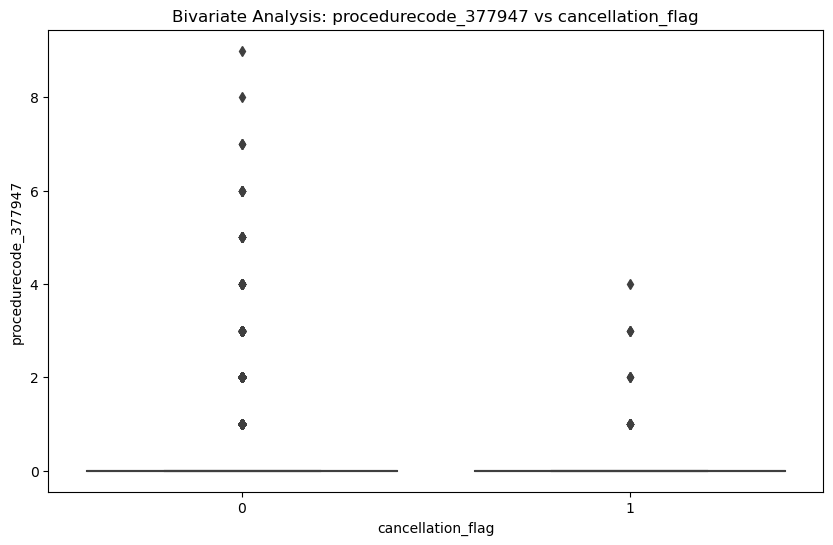


Descriptive Statistics for procedurecode_377947 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.033390  0.246969  0.0  0.0  0.0  0.0  9.0
1                   7263.0  0.004268  0.095958  0.0  0.0  0.0  0.0  4.0

---------------------------------------



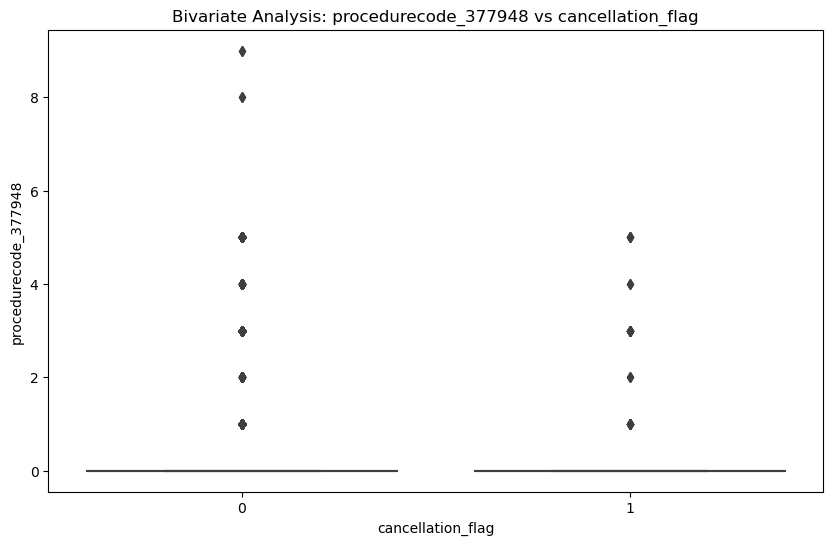


Descriptive Statistics for procedurecode_377948 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.032094  0.319047  0.0  0.0  0.0  0.0  9.0
1                   7263.0  0.010602  0.187822  0.0  0.0  0.0  0.0  5.0

---------------------------------------



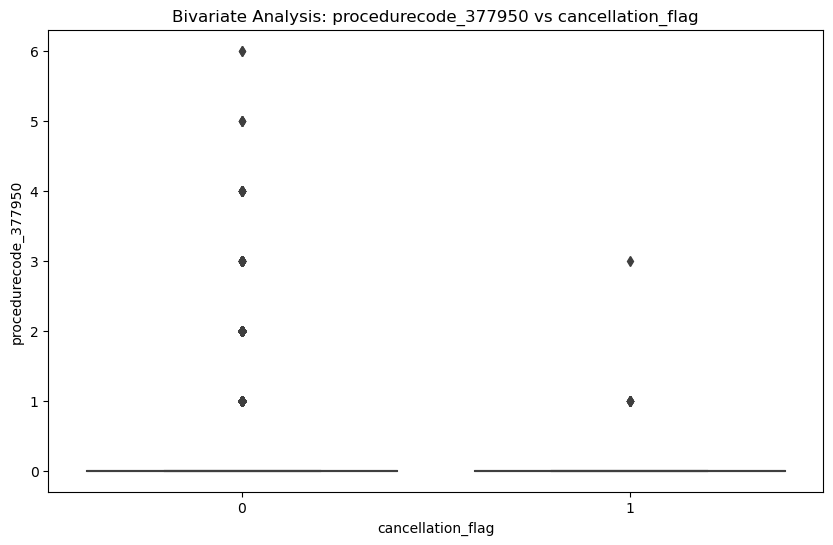


Descriptive Statistics for procedurecode_377950 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.017996  0.175555  0.0  0.0  0.0  0.0  6.0
1                   7263.0  0.001790  0.051119  0.0  0.0  0.0  0.0  3.0

---------------------------------------



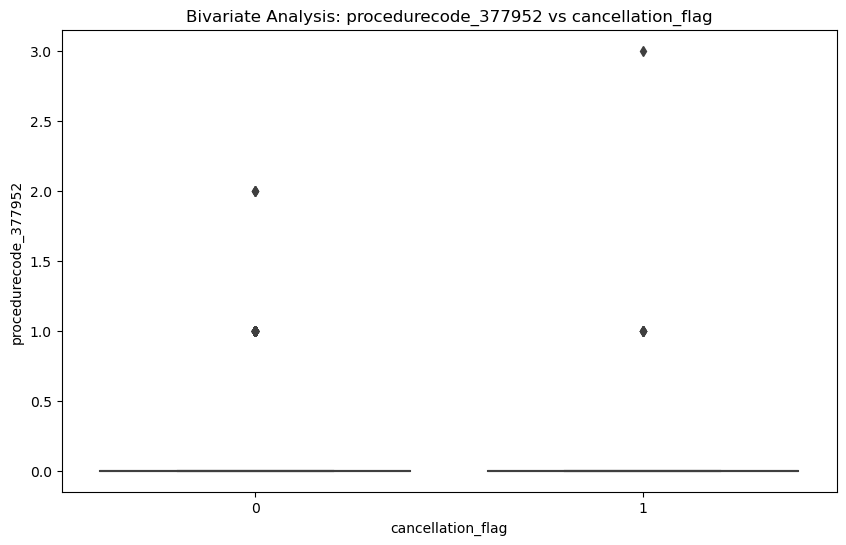


Descriptive Statistics for procedurecode_377952 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.001165  0.035141  0.0  0.0  0.0  0.0  2.0
1                   7263.0  0.001239  0.045431  0.0  0.0  0.0  0.0  3.0

---------------------------------------



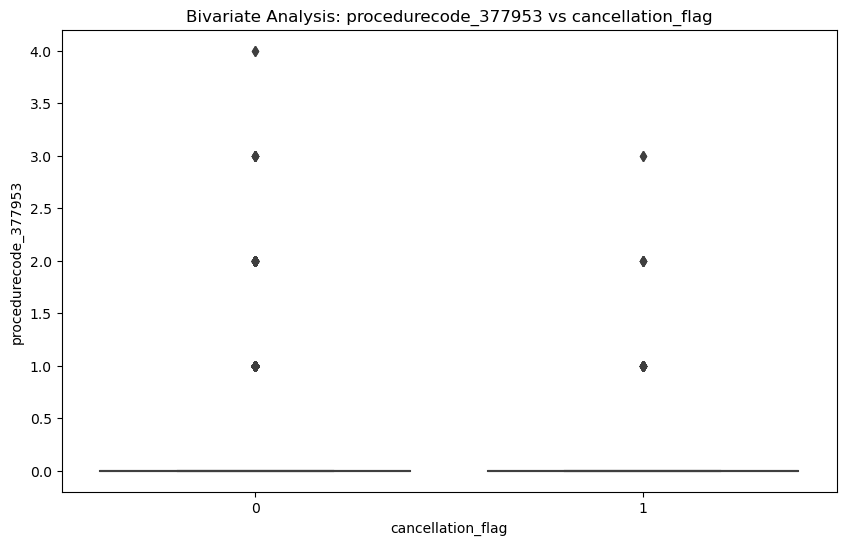


Descriptive Statistics for procedurecode_377953 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.045562  0.215431  0.0  0.0  0.0  0.0  4.0
1                   7263.0  0.007710  0.104675  0.0  0.0  0.0  0.0  3.0

---------------------------------------



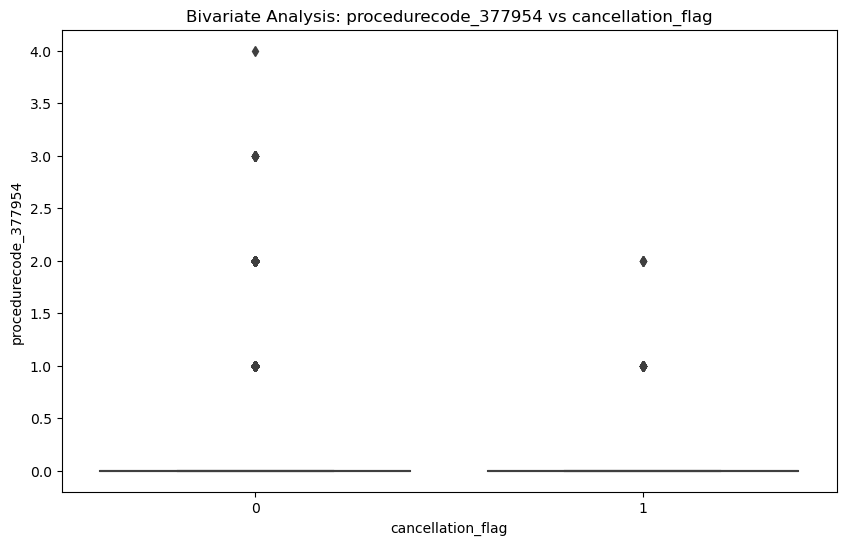


Descriptive Statistics for procedurecode_377954 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.062548  0.278837  0.0  0.0  0.0  0.0  4.0
1                   7263.0  0.004406  0.074086  0.0  0.0  0.0  0.0  2.0

---------------------------------------



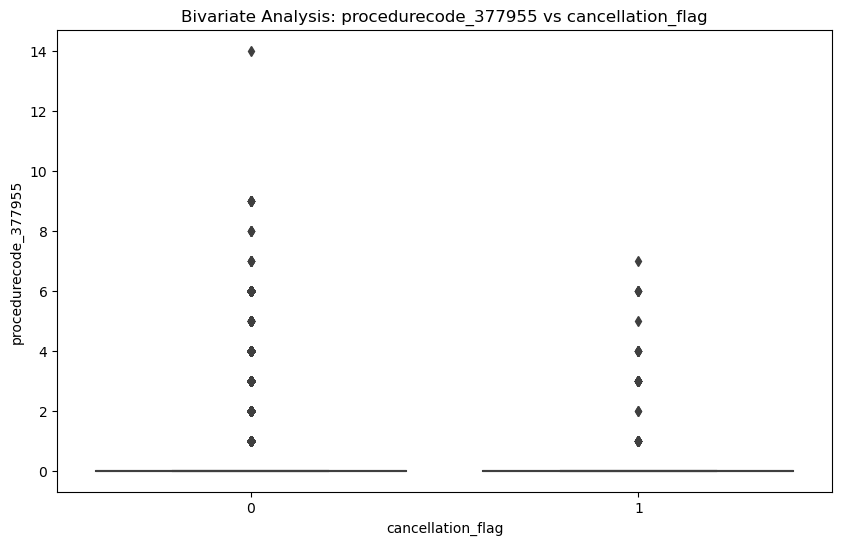


Descriptive Statistics for procedurecode_377955 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%   max
cancellation_flag                                                       
0                  84128.0  0.252615  0.937016  0.0  0.0  0.0  0.0  14.0
1                   7263.0  0.022718  0.287261  0.0  0.0  0.0  0.0   7.0

---------------------------------------



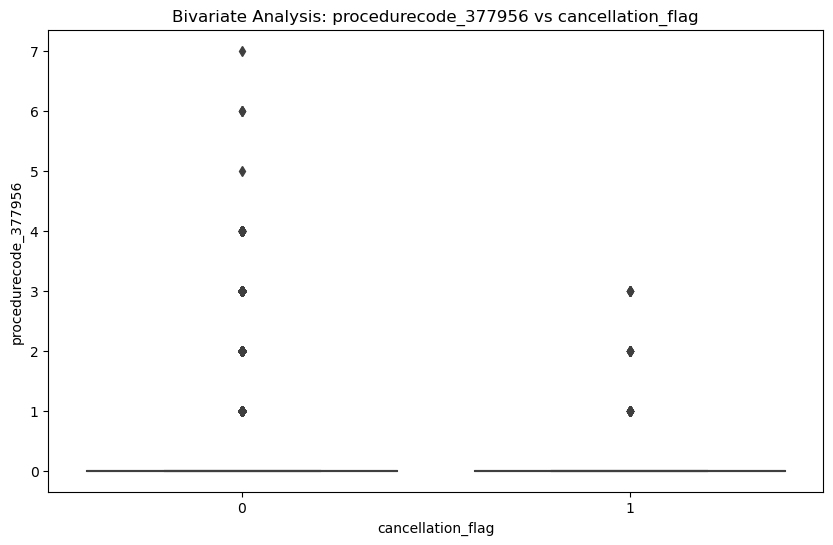


Descriptive Statistics for procedurecode_377956 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.113315  0.454770  0.0  0.0  0.0  0.0  7.0
1                   7263.0  0.009638  0.132413  0.0  0.0  0.0  0.0  3.0

---------------------------------------



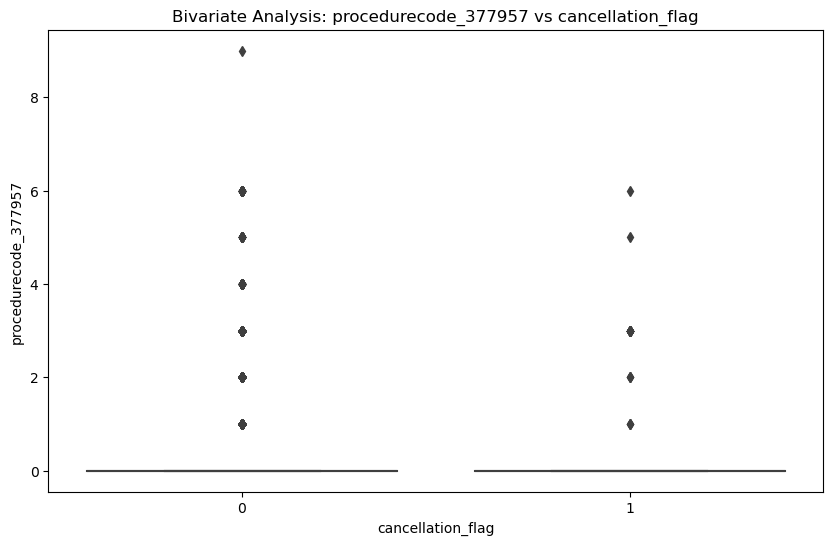


Descriptive Statistics for procedurecode_377957 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.125309  0.587136  0.0  0.0  0.0  0.0  9.0
1                   7263.0  0.011428  0.190685  0.0  0.0  0.0  0.0  6.0

---------------------------------------



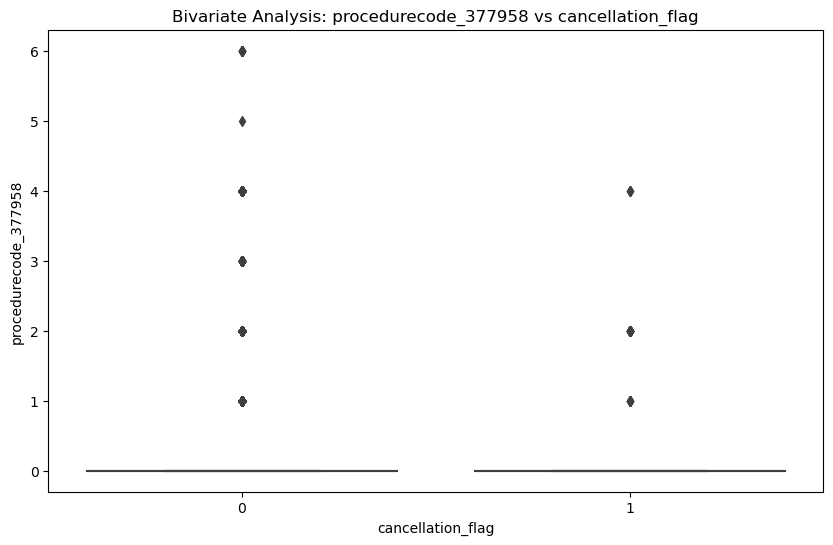


Descriptive Statistics for procedurecode_377958 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.103556  0.477927  0.0  0.0  0.0  0.0  6.0
1                   7263.0  0.011703  0.160042  0.0  0.0  0.0  0.0  4.0

---------------------------------------



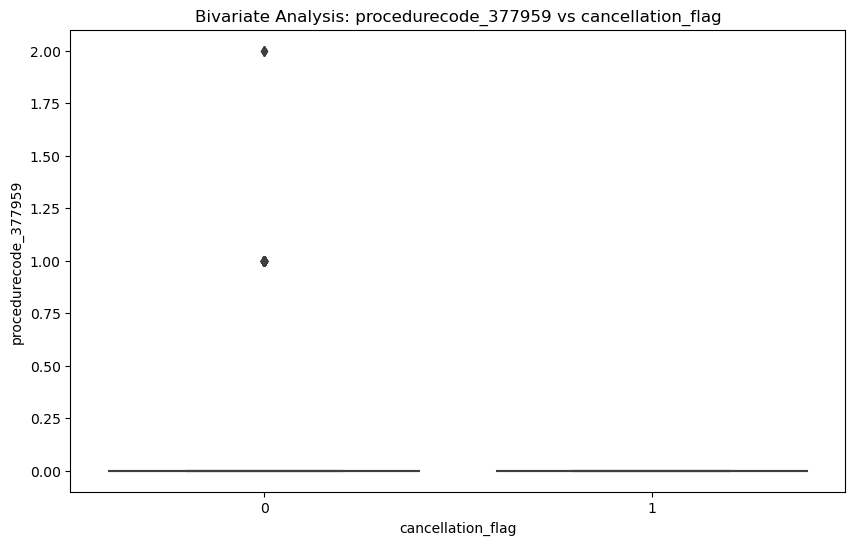


Descriptive Statistics for procedurecode_377959 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.001034  0.032873  0.0  0.0  0.0  0.0  2.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



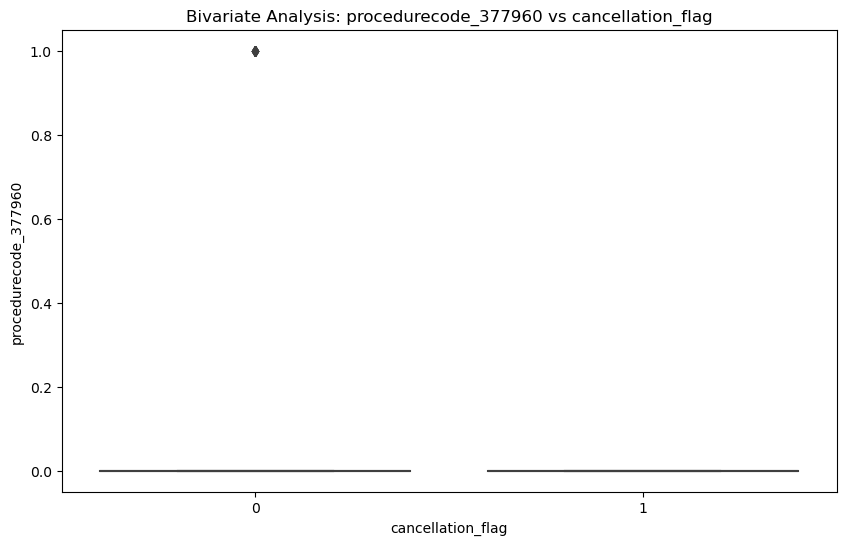


Descriptive Statistics for procedurecode_377960 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000107  0.010343  0.0  0.0  0.0  0.0  1.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



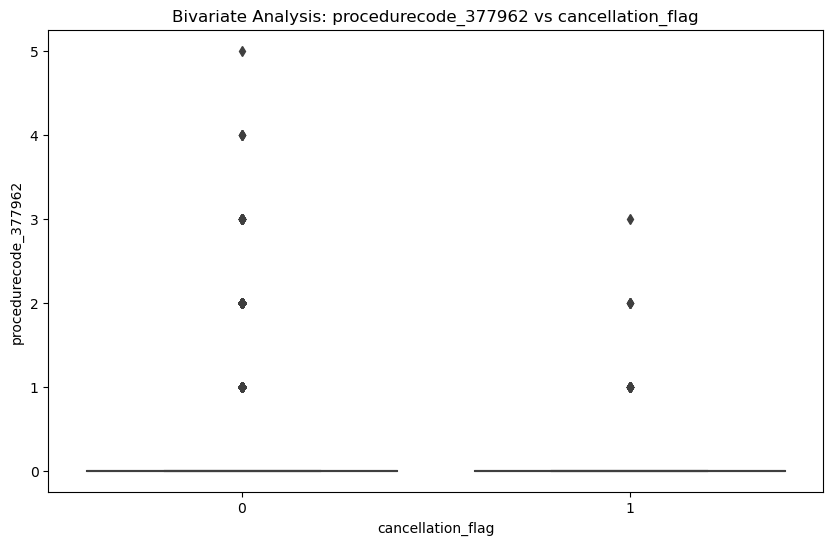


Descriptive Statistics for procedurecode_377962 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.042114  0.230296  0.0  0.0  0.0  0.0  5.0
1                   7263.0  0.005232  0.084458  0.0  0.0  0.0  0.0  3.0

---------------------------------------



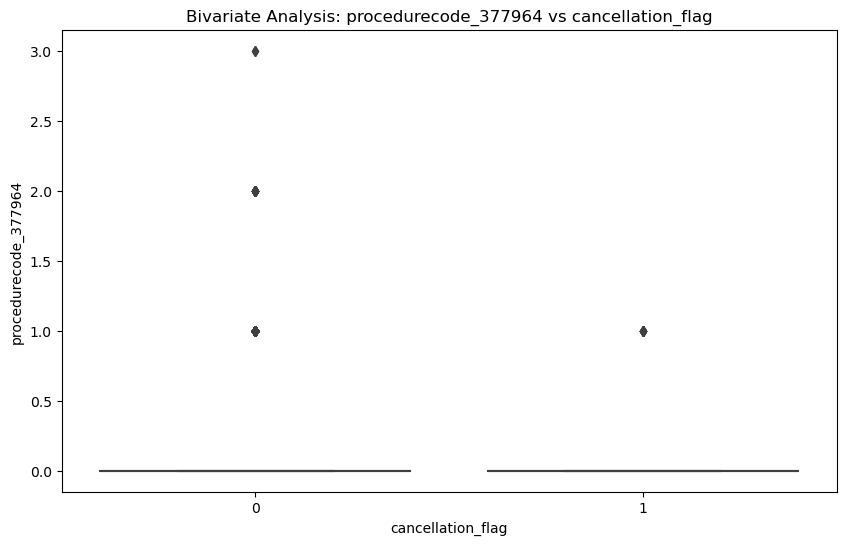


Descriptive Statistics for procedurecode_377964 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.024784  0.157743  0.0  0.0  0.0  0.0  3.0
1                   7263.0  0.001377  0.037083  0.0  0.0  0.0  0.0  1.0

---------------------------------------



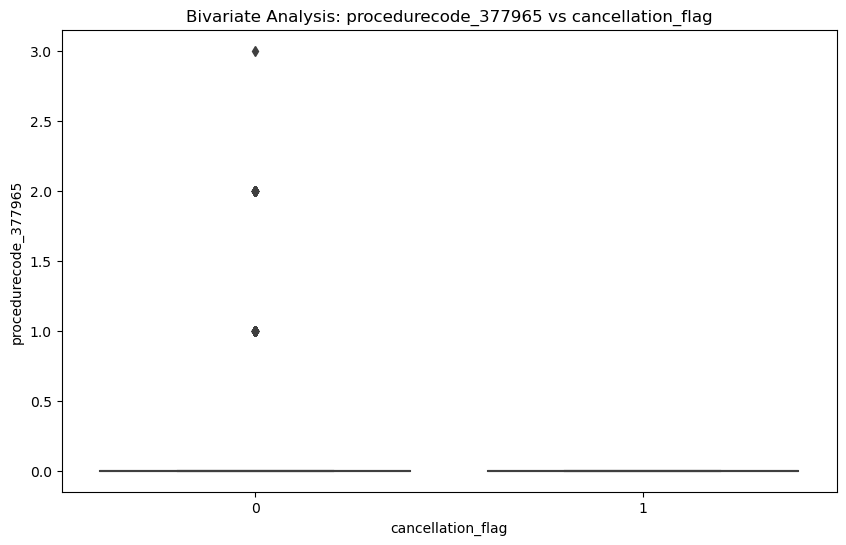


Descriptive Statistics for procedurecode_377965 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.001819  0.053935  0.0  0.0  0.0  0.0  3.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



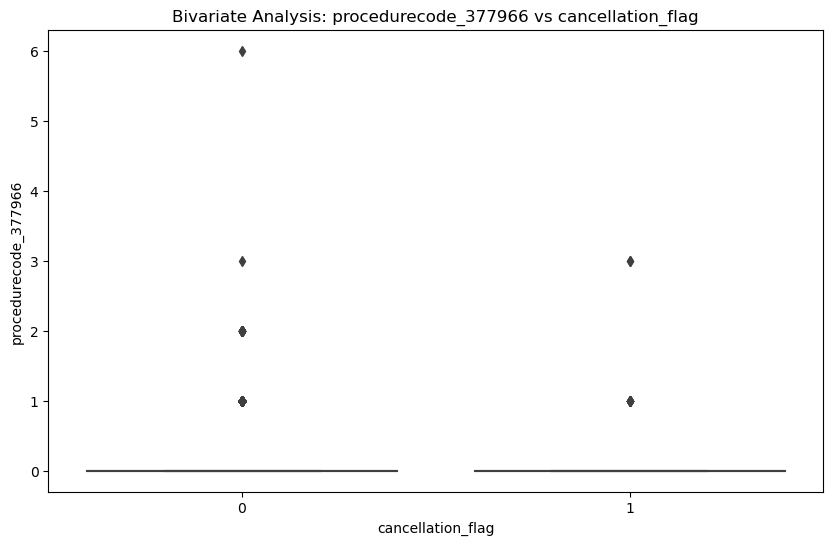


Descriptive Statistics for procedurecode_377966 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.009046  0.100050  0.0  0.0  0.0  0.0  6.0
1                   7263.0  0.002478  0.064226  0.0  0.0  0.0  0.0  3.0

---------------------------------------



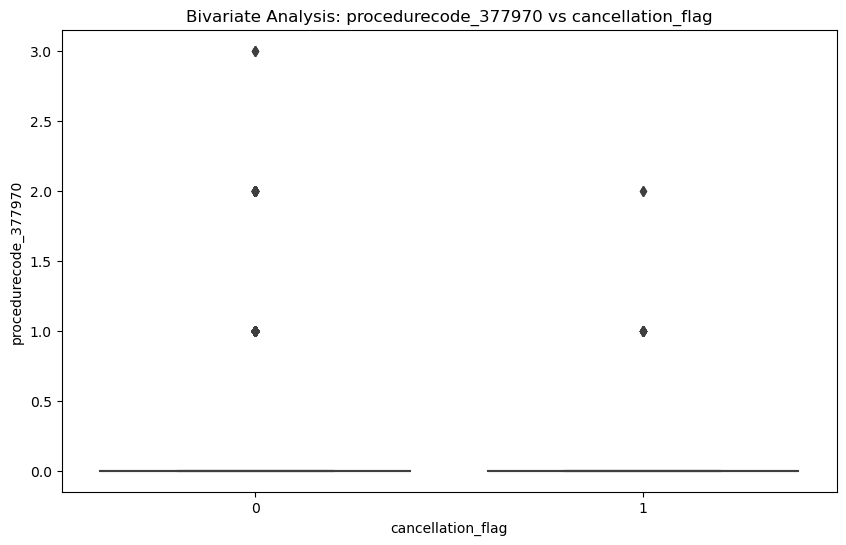


Descriptive Statistics for procedurecode_377970 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.031321  0.178899  0.0  0.0  0.0  0.0  3.0
1                   7263.0  0.002616  0.056217  0.0  0.0  0.0  0.0  2.0

---------------------------------------



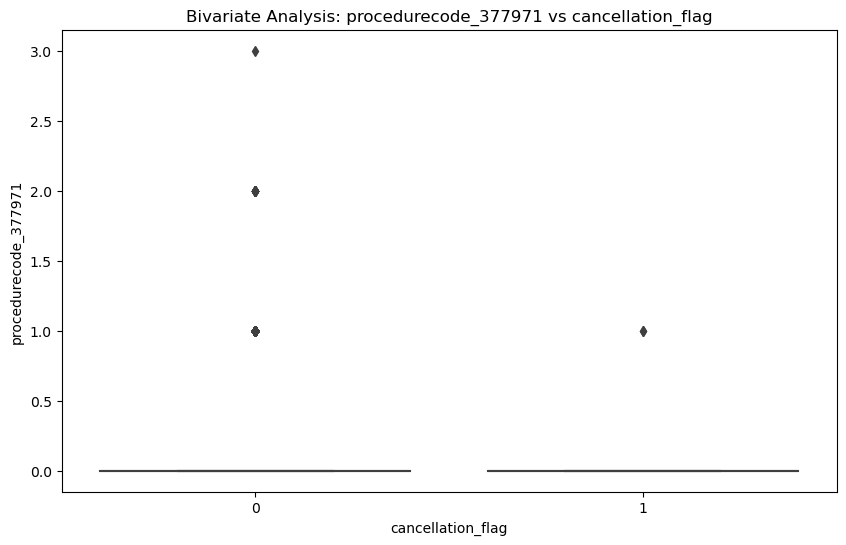


Descriptive Statistics for procedurecode_377971 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.004790  0.072408  0.0  0.0  0.0  0.0  3.0
1                   7263.0  0.000275  0.016593  0.0  0.0  0.0  0.0  1.0

---------------------------------------



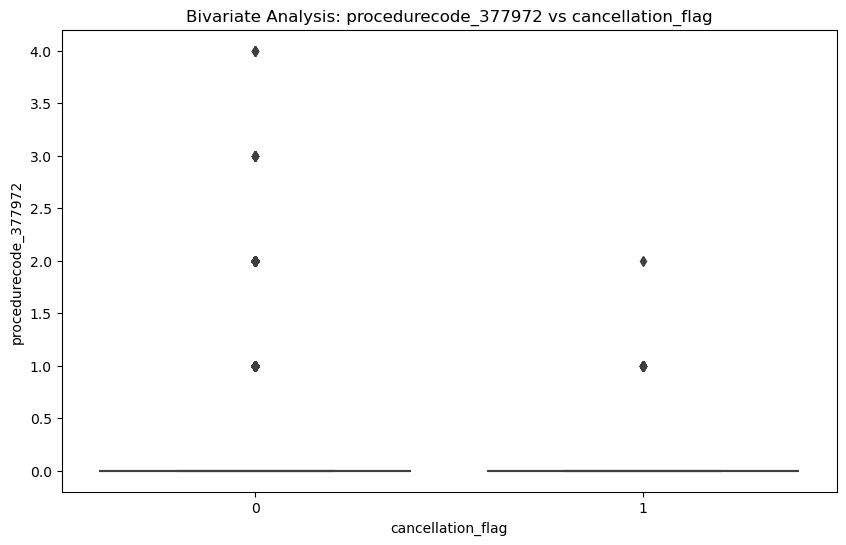


Descriptive Statistics for procedurecode_377972 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.046940  0.227592  0.0  0.0  0.0  0.0  4.0
1                   7263.0  0.003855  0.064158  0.0  0.0  0.0  0.0  2.0

---------------------------------------



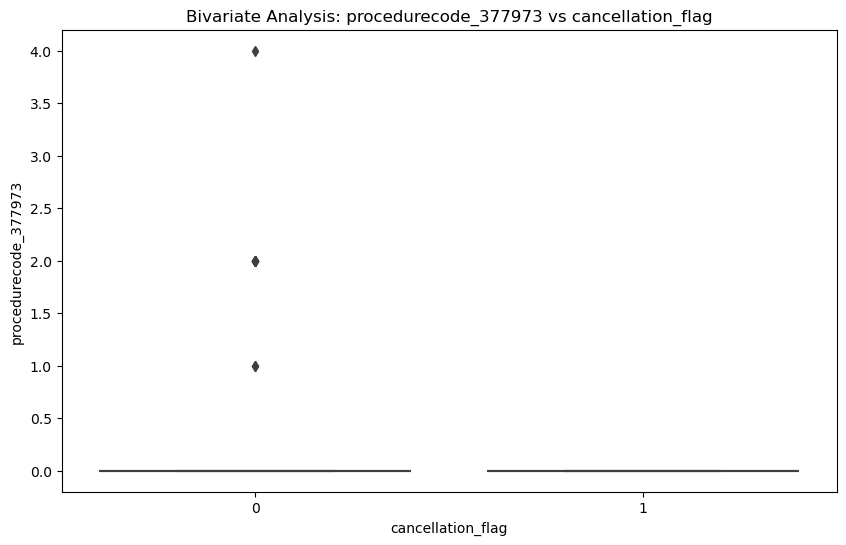


Descriptive Statistics for procedurecode_377973 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000214  0.022343  0.0  0.0  0.0  0.0  4.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



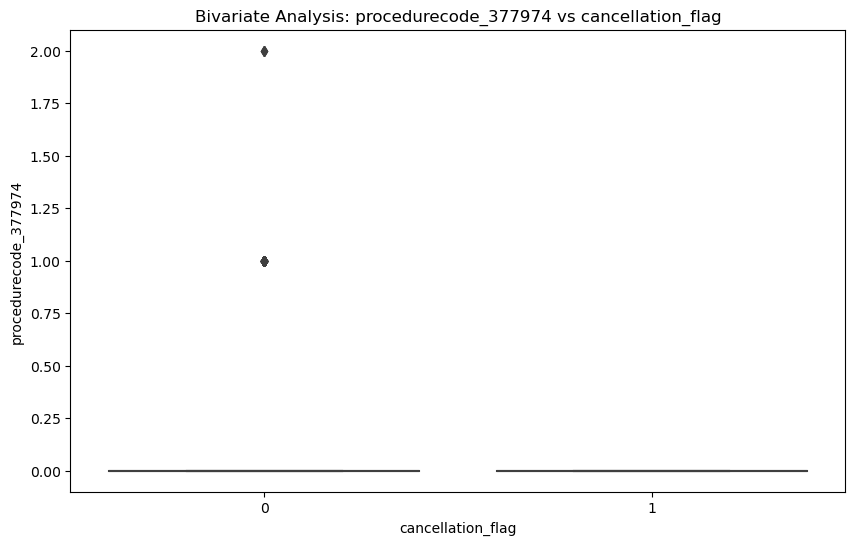


Descriptive Statistics for procedurecode_377974 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.001272  0.036628  0.0  0.0  0.0  0.0  2.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



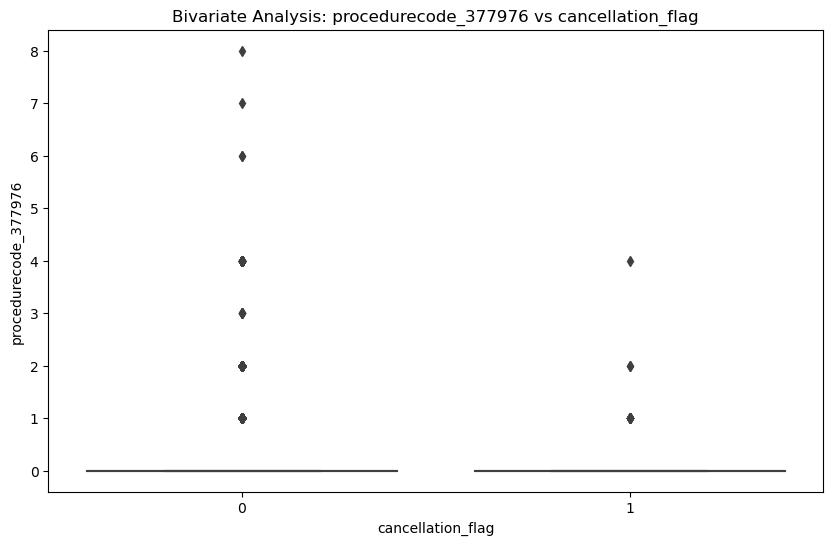


Descriptive Statistics for procedurecode_377976 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.015583  0.189360  0.0  0.0  0.0  0.0  8.0
1                   7263.0  0.003304  0.074143  0.0  0.0  0.0  0.0  4.0

---------------------------------------



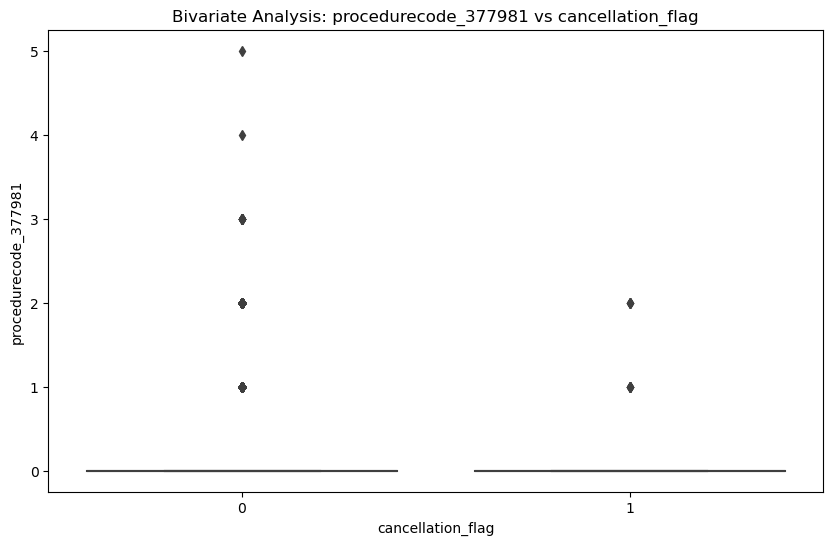


Descriptive Statistics for procedurecode_377981 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.021384  0.169273  0.0  0.0  0.0  0.0  5.0
1                   7263.0  0.001928  0.055007  0.0  0.0  0.0  0.0  2.0

---------------------------------------



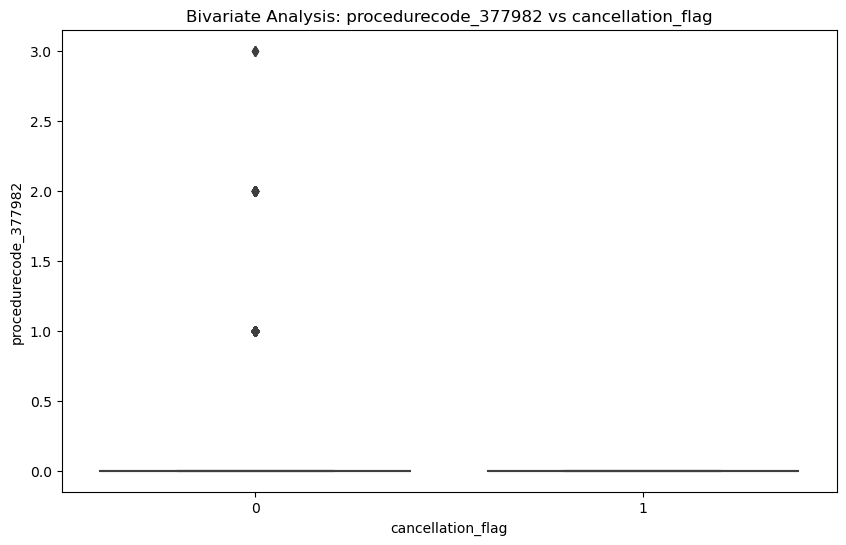


Descriptive Statistics for procedurecode_377982 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.004612  0.078333  0.0  0.0  0.0  0.0  3.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



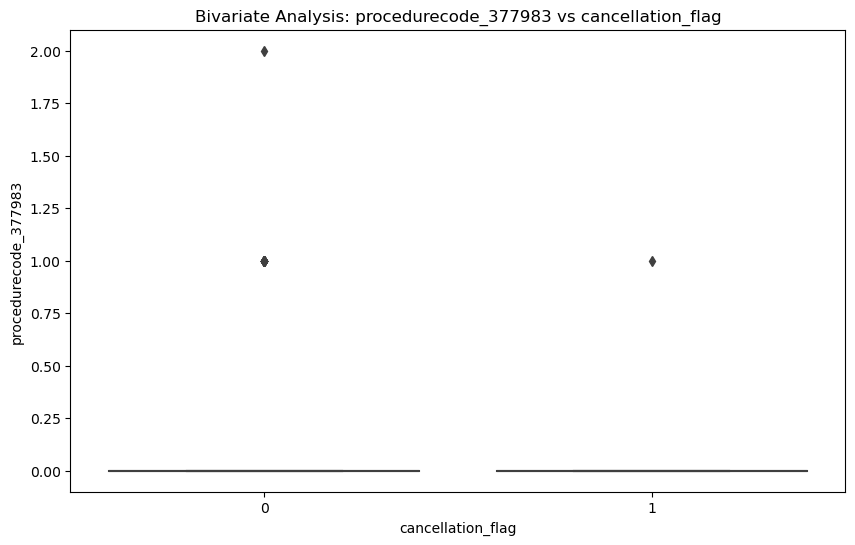


Descriptive Statistics for procedurecode_377983 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000262  0.016888  0.0  0.0  0.0  0.0  2.0
1                   7263.0  0.000138  0.011734  0.0  0.0  0.0  0.0  1.0

---------------------------------------



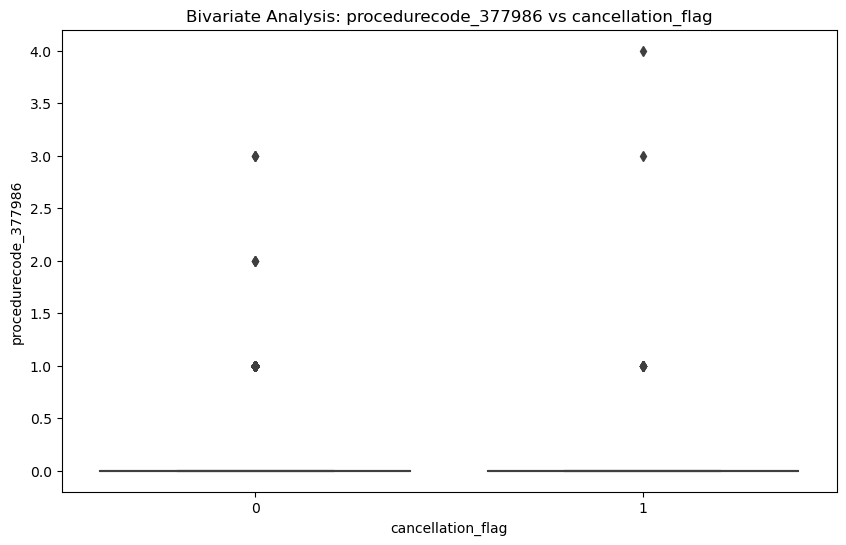


Descriptive Statistics for procedurecode_377986 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.002615  0.053792  0.0  0.0  0.0  0.0  3.0
1                   7263.0  0.002341  0.069384  0.0  0.0  0.0  0.0  4.0

---------------------------------------



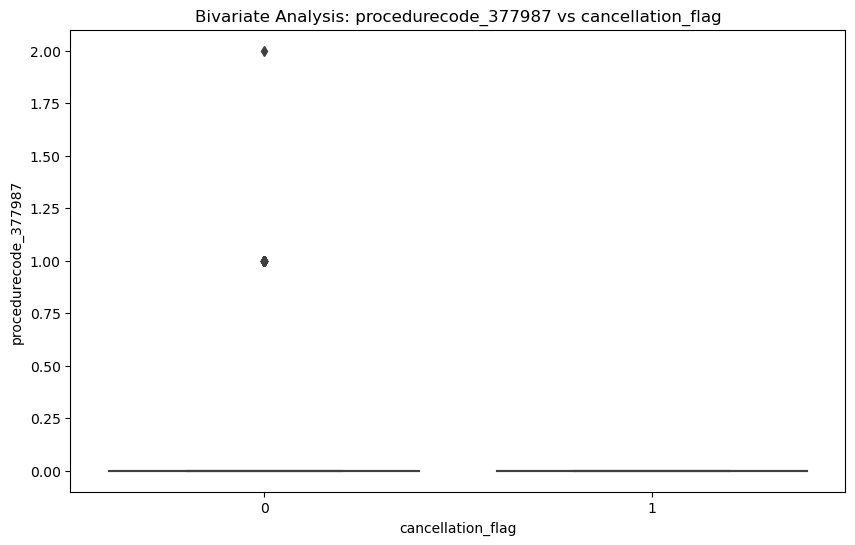


Descriptive Statistics for procedurecode_377987 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000654  0.026022  0.0  0.0  0.0  0.0  2.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



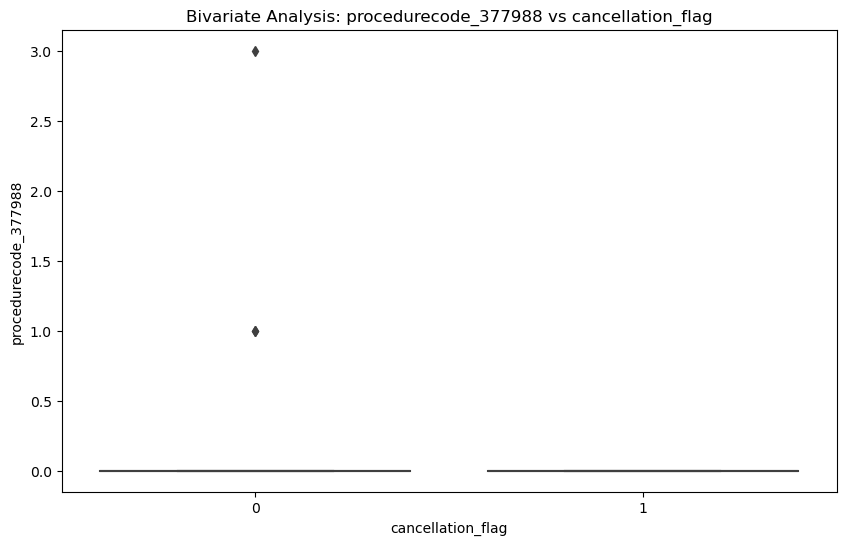


Descriptive Statistics for procedurecode_377988 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000059  0.011435  0.0  0.0  0.0  0.0  3.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



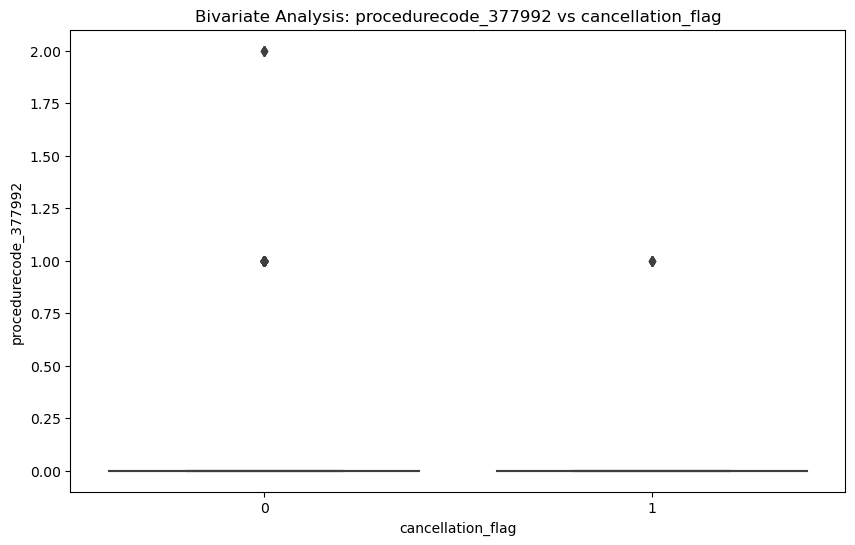


Descriptive Statistics for procedurecode_377992 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.001605  0.040908  0.0  0.0  0.0  0.0  2.0
1                   7263.0  0.000688  0.026231  0.0  0.0  0.0  0.0  1.0

---------------------------------------



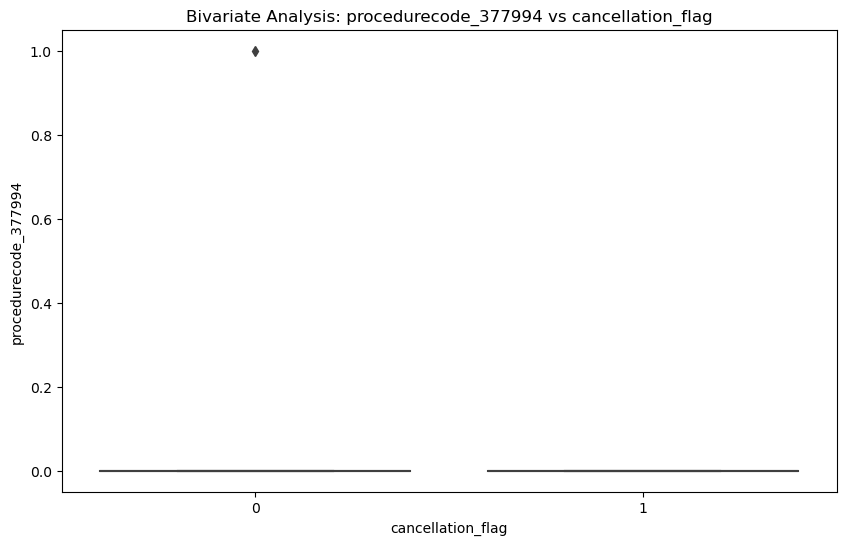


Descriptive Statistics for procedurecode_377994 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000012  0.003448  0.0  0.0  0.0  0.0  1.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



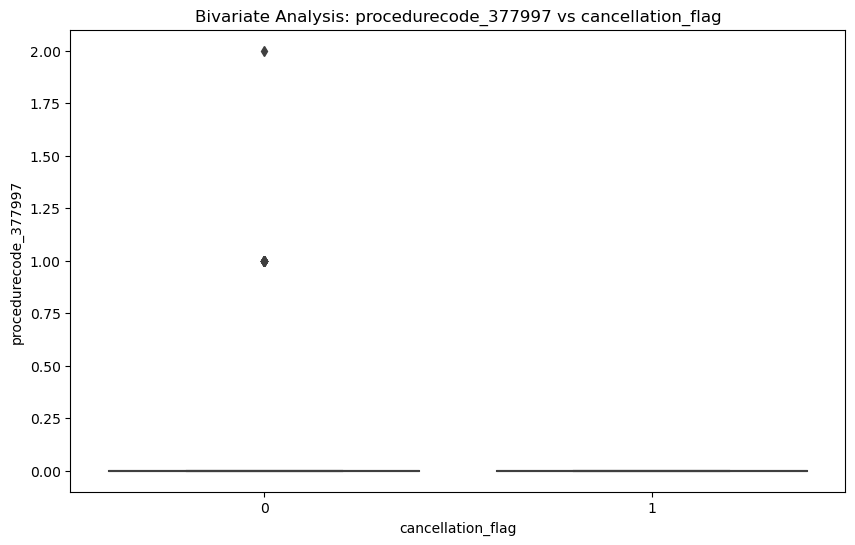


Descriptive Statistics for procedurecode_377997 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000214  0.015417  0.0  0.0  0.0  0.0  2.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



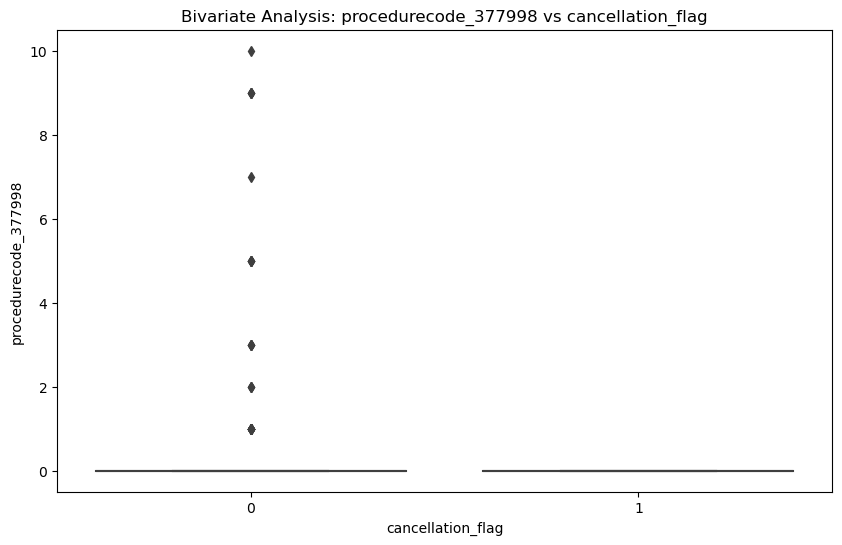


Descriptive Statistics for procedurecode_377998 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%   max
cancellation_flag                                                       
0                  84128.0  0.001308  0.088564  0.0  0.0  0.0  0.0  10.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0   0.0

---------------------------------------



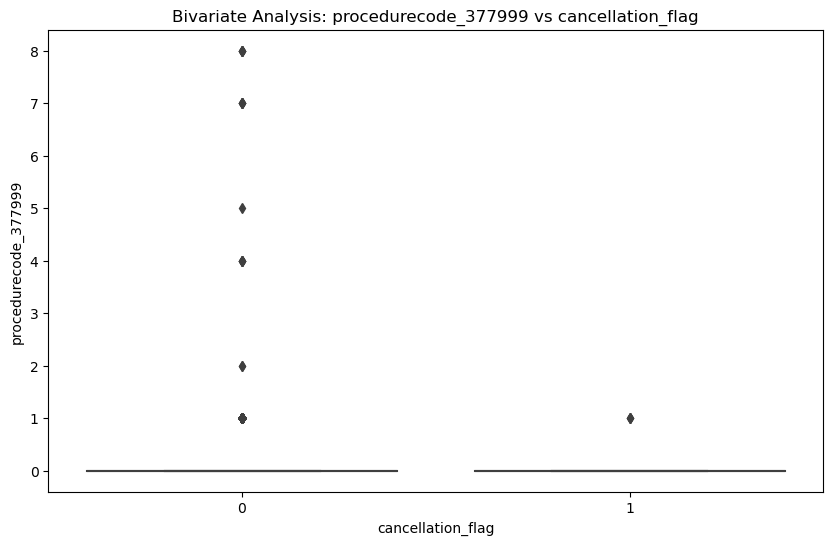


Descriptive Statistics for procedurecode_377999 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.005694  0.111733  0.0  0.0  0.0  0.0  8.0
1                   7263.0  0.000413  0.020321  0.0  0.0  0.0  0.0  1.0

---------------------------------------



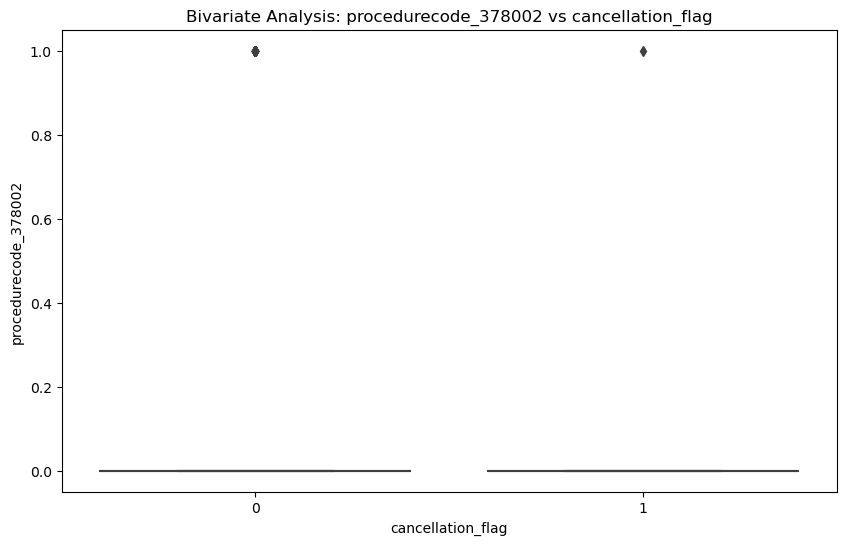


Descriptive Statistics for procedurecode_378002 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000547  0.023377  0.0  0.0  0.0  0.0  1.0
1                   7263.0  0.000138  0.011734  0.0  0.0  0.0  0.0  1.0

---------------------------------------



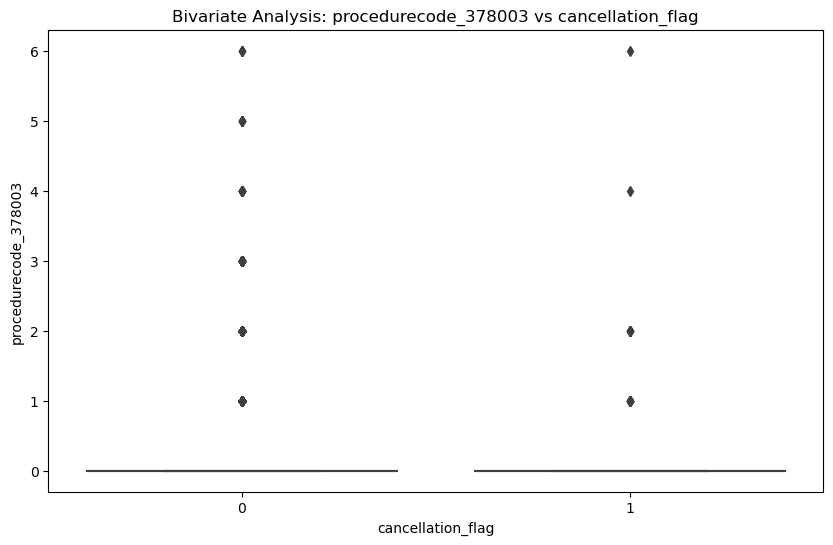


Descriptive Statistics for procedurecode_378003 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.045098  0.264261  0.0  0.0  0.0  0.0  6.0
1                   7263.0  0.006058  0.119517  0.0  0.0  0.0  0.0  6.0

---------------------------------------



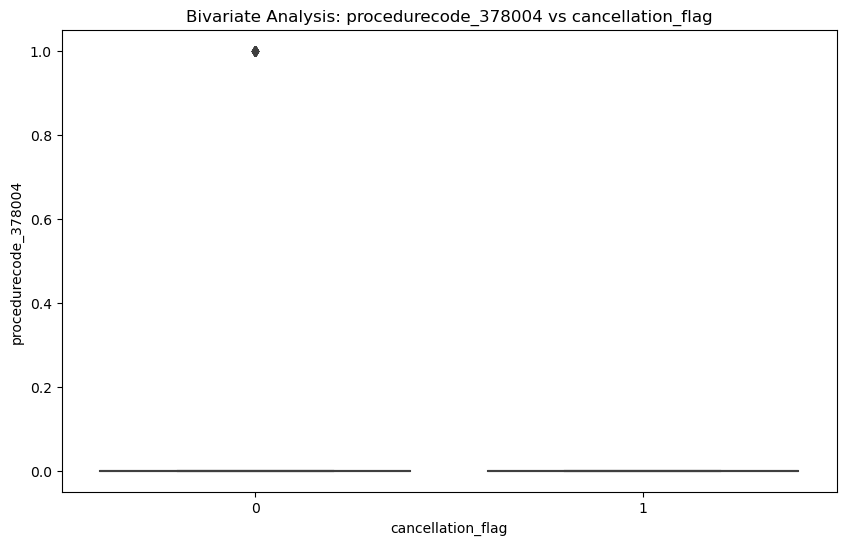


Descriptive Statistics for procedurecode_378004 by cancellation_flag:

                     count     mean       std  min  25%  50%  75%  max
cancellation_flag                                                     
0                  84128.0  0.00025  0.015797  0.0  0.0  0.0  0.0  1.0
1                   7263.0  0.00000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



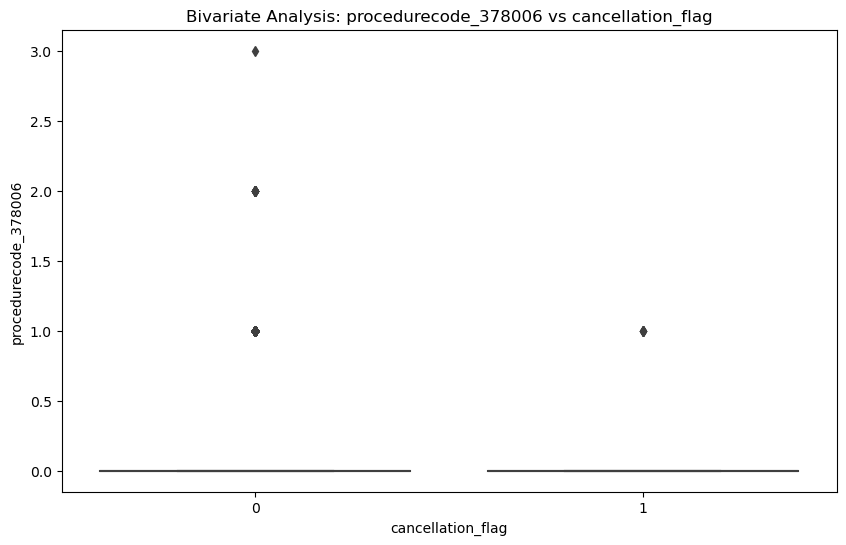


Descriptive Statistics for procedurecode_378006 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.003043  0.058836  0.0  0.0  0.0  0.0  3.0
1                   7263.0  0.000688  0.026231  0.0  0.0  0.0  0.0  1.0

---------------------------------------



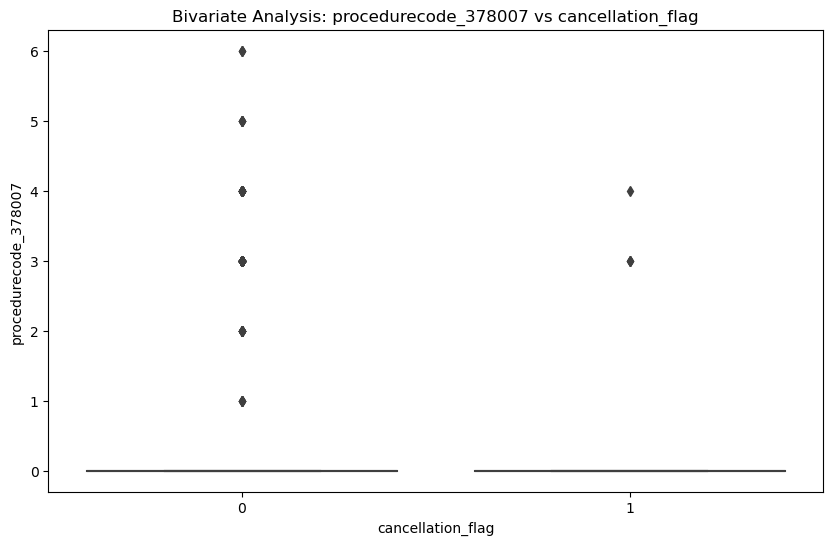


Descriptive Statistics for procedurecode_378007 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.007477  0.158081  0.0  0.0  0.0  0.0  6.0
1                   7263.0  0.001790  0.076929  0.0  0.0  0.0  0.0  4.0

---------------------------------------



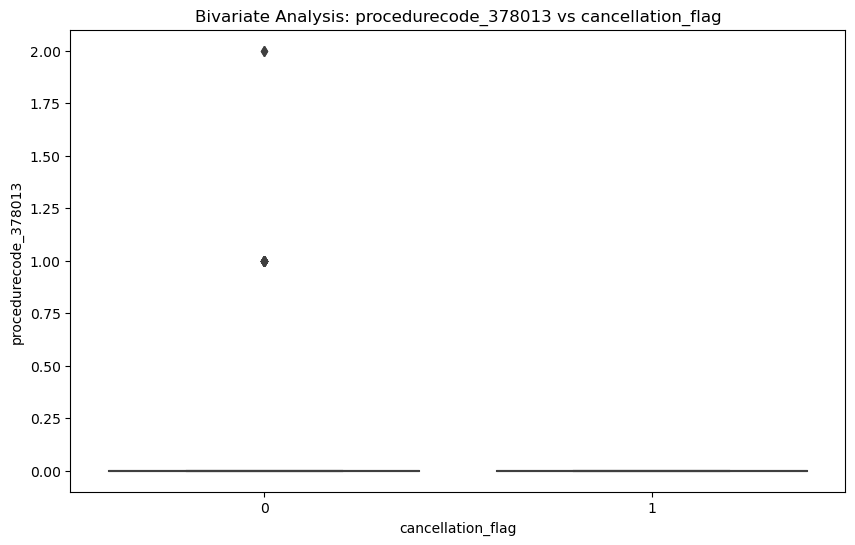


Descriptive Statistics for procedurecode_378013 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000297  0.018564  0.0  0.0  0.0  0.0  2.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



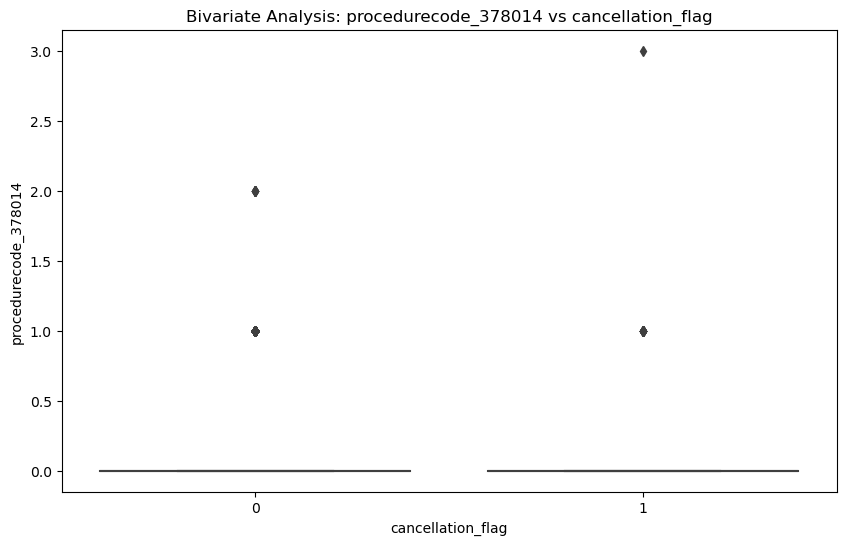


Descriptive Statistics for procedurecode_378014 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.005135  0.072630  0.0  0.0  0.0  0.0  2.0
1                   7263.0  0.002616  0.058615  0.0  0.0  0.0  0.0  3.0

---------------------------------------



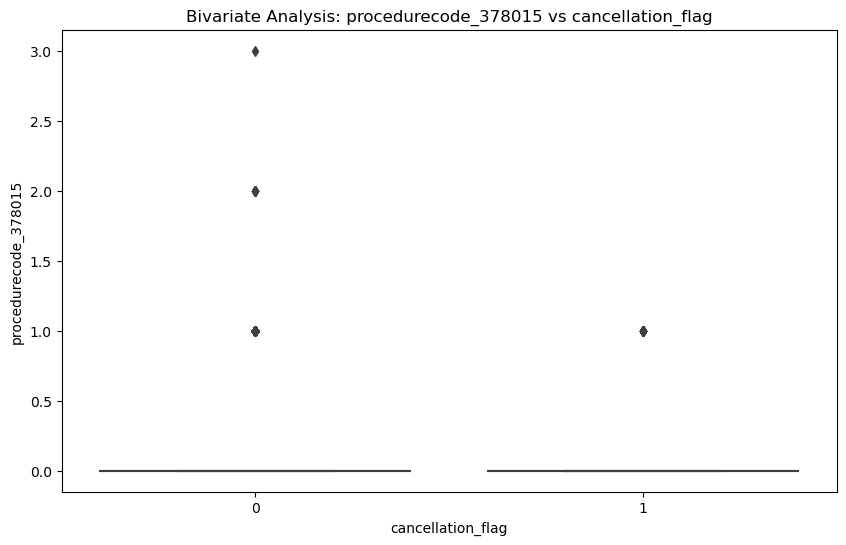


Descriptive Statistics for procedurecode_378015 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.003911  0.064290  0.0  0.0  0.0  0.0  3.0
1                   7263.0  0.002754  0.052407  0.0  0.0  0.0  0.0  1.0

---------------------------------------



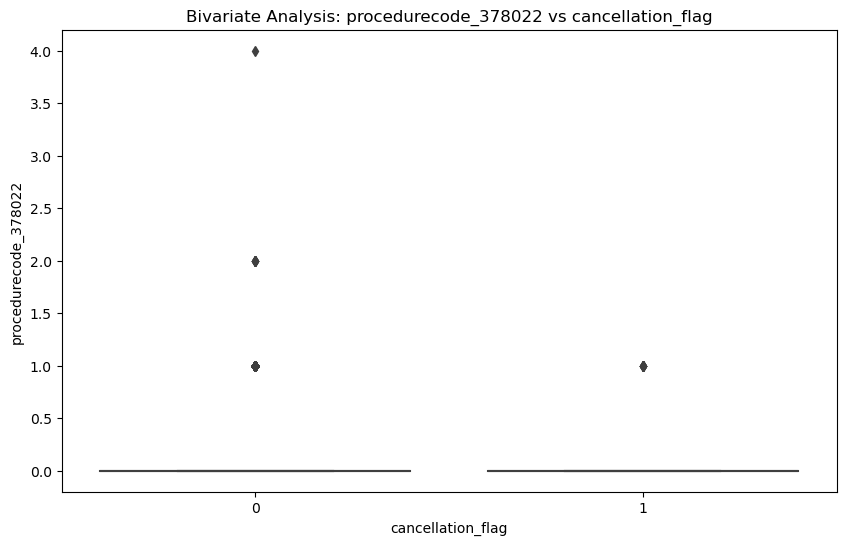


Descriptive Statistics for procedurecode_378022 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.003911  0.064842  0.0  0.0  0.0  0.0  4.0
1                   7263.0  0.001239  0.035182  0.0  0.0  0.0  0.0  1.0

---------------------------------------



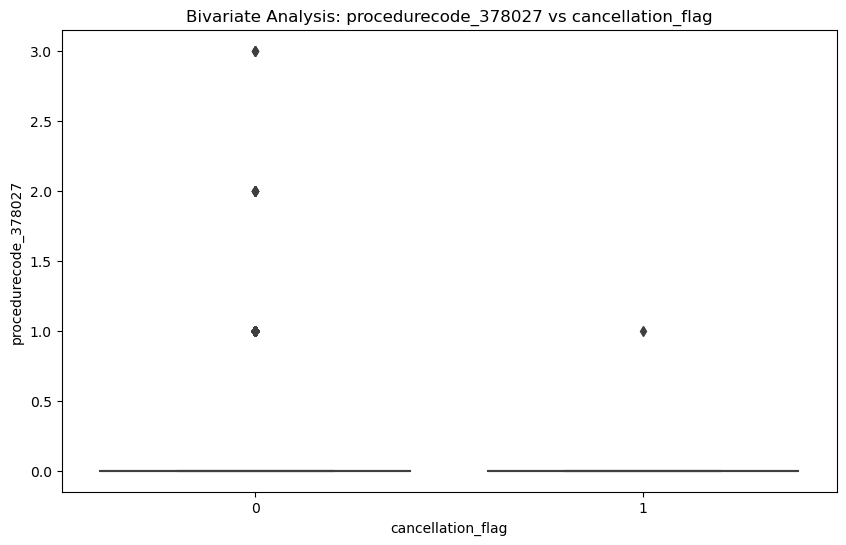


Descriptive Statistics for procedurecode_378027 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.004184  0.067432  0.0  0.0  0.0  0.0  3.0
1                   7263.0  0.000138  0.011734  0.0  0.0  0.0  0.0  1.0

---------------------------------------



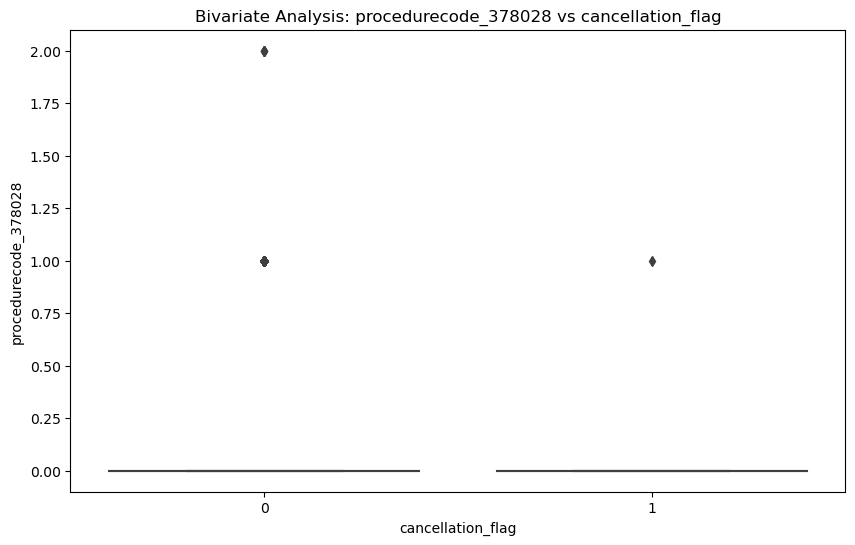


Descriptive Statistics for procedurecode_378028 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.003839  0.062608  0.0  0.0  0.0  0.0  2.0
1                   7263.0  0.000138  0.011734  0.0  0.0  0.0  0.0  1.0

---------------------------------------



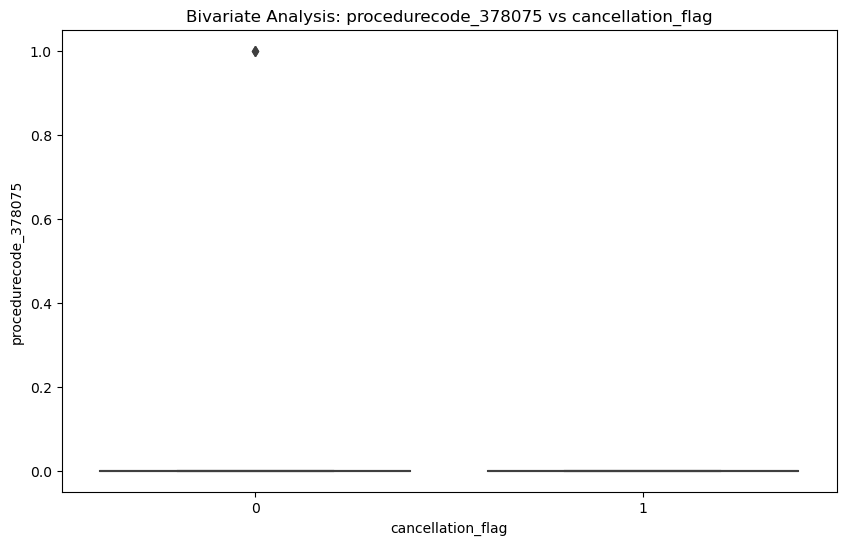


Descriptive Statistics for procedurecode_378075 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000024  0.004876  0.0  0.0  0.0  0.0  1.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



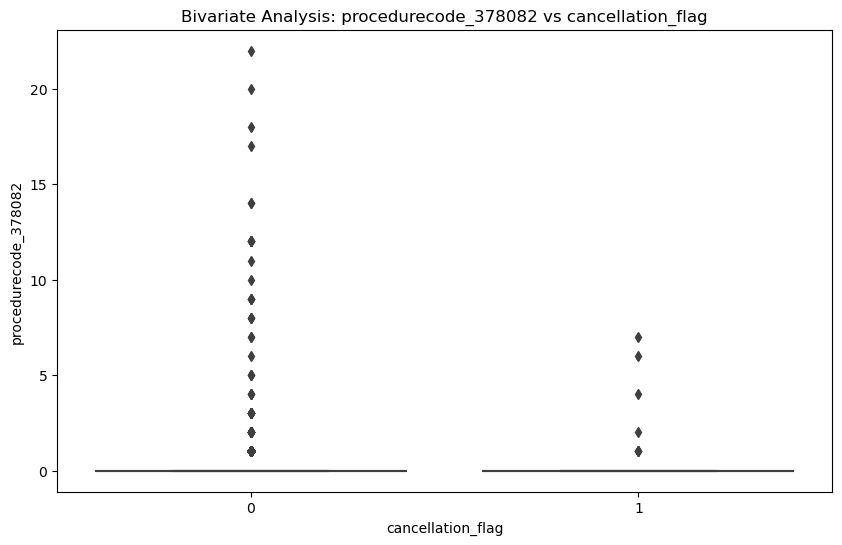


Descriptive Statistics for procedurecode_378082 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%   max
cancellation_flag                                                       
0                  84128.0  0.009937  0.228011  0.0  0.0  0.0  0.0  22.0
1                   7263.0  0.003167  0.122473  0.0  0.0  0.0  0.0   7.0

---------------------------------------



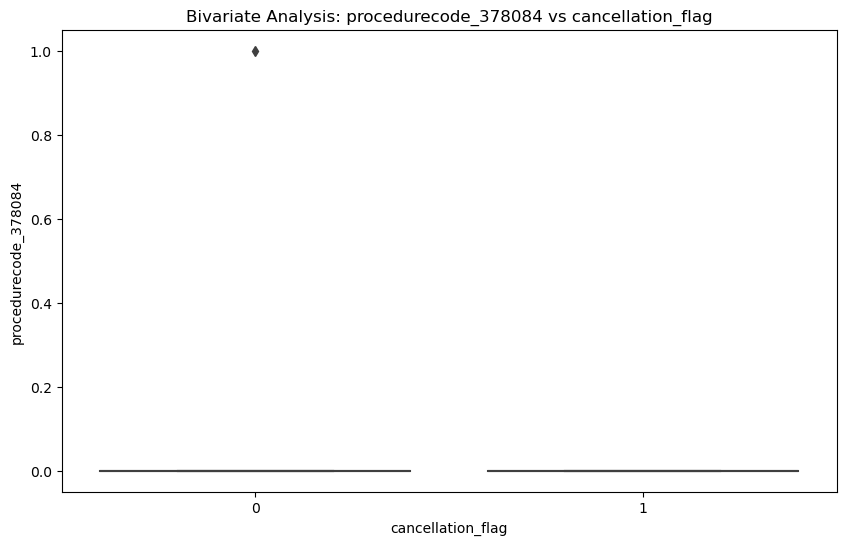


Descriptive Statistics for procedurecode_378084 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000012  0.003448  0.0  0.0  0.0  0.0  1.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



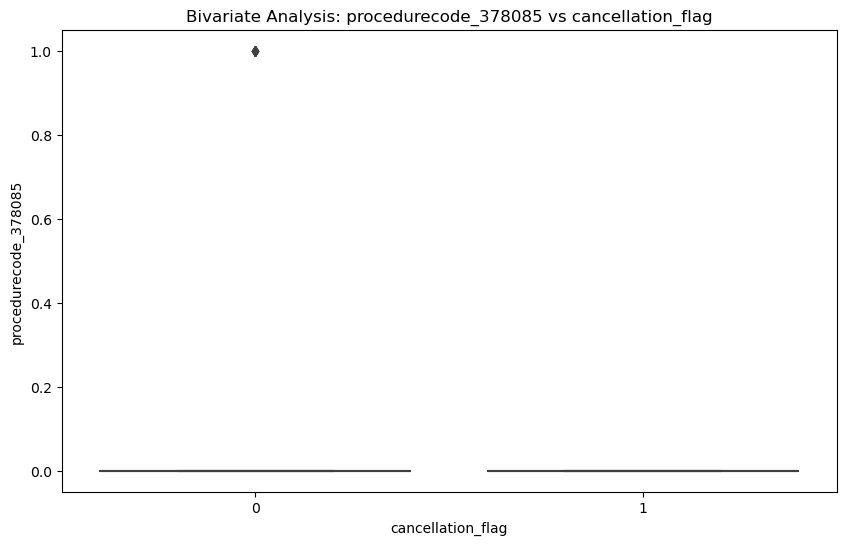


Descriptive Statistics for procedurecode_378085 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000059  0.007709  0.0  0.0  0.0  0.0  1.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



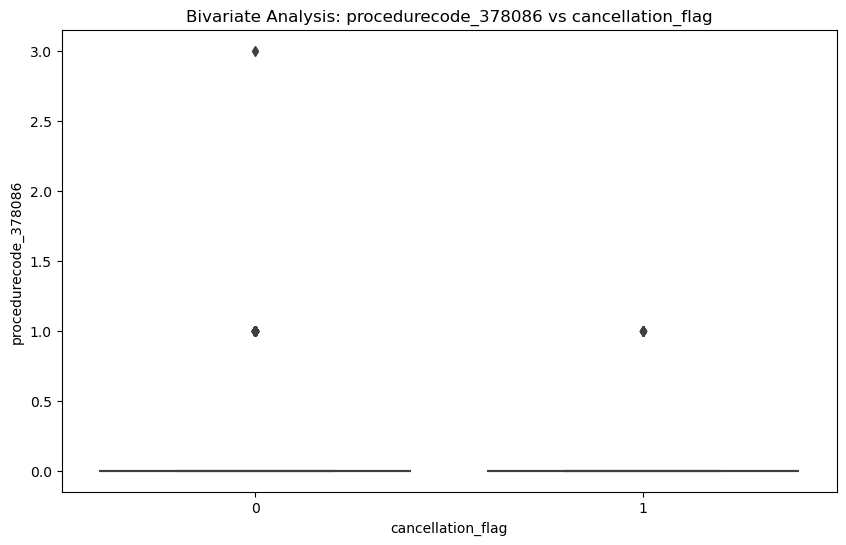


Descriptive Statistics for procedurecode_378086 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.001224  0.035974  0.0  0.0  0.0  0.0  3.0
1                   7263.0  0.000826  0.028732  0.0  0.0  0.0  0.0  1.0

---------------------------------------



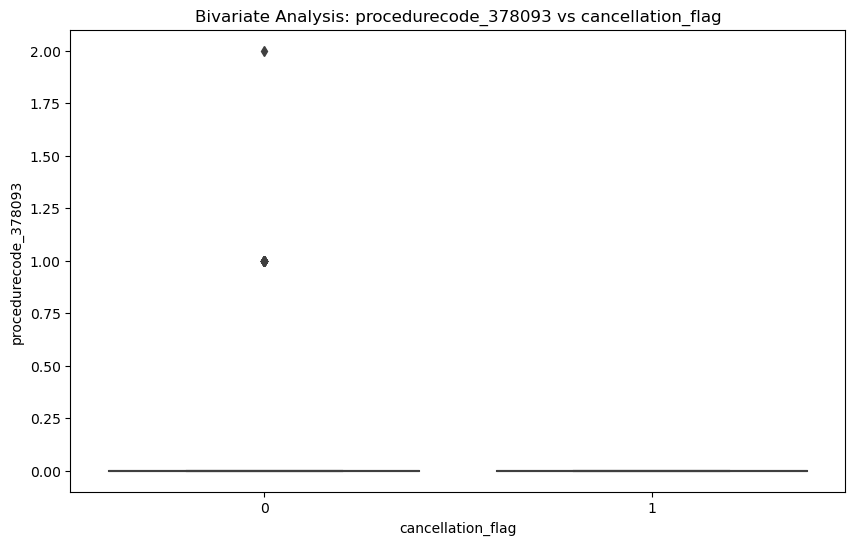


Descriptive Statistics for procedurecode_378093 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000309  0.018241  0.0  0.0  0.0  0.0  2.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



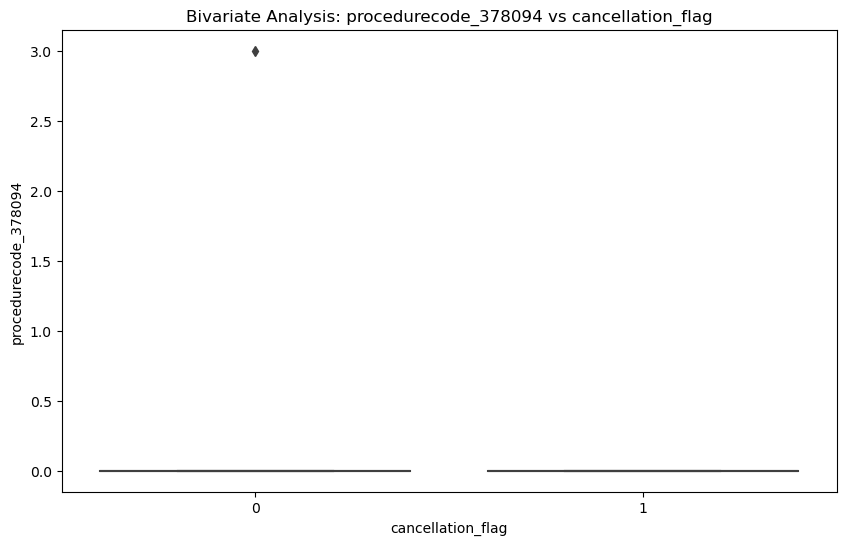


Descriptive Statistics for procedurecode_378094 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000036  0.010343  0.0  0.0  0.0  0.0  3.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



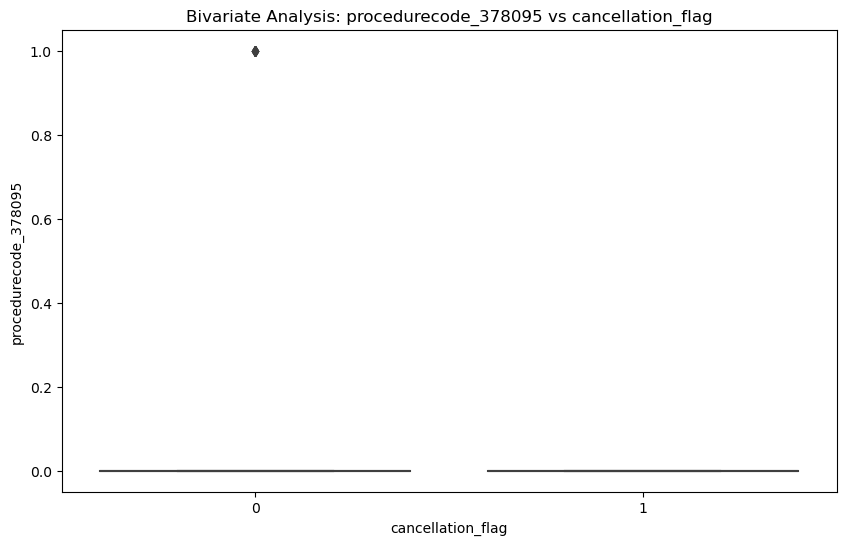


Descriptive Statistics for procedurecode_378095 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000083  0.009121  0.0  0.0  0.0  0.0  1.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



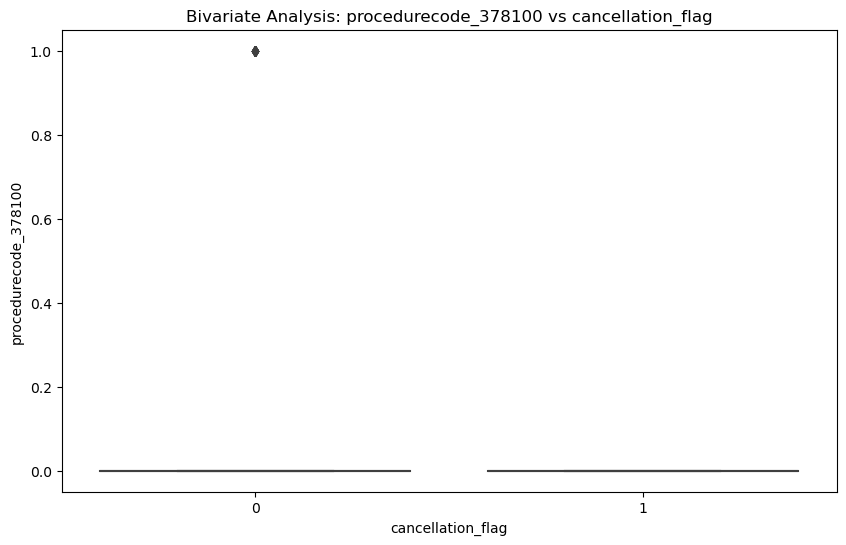


Descriptive Statistics for procedurecode_378100 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000166  0.012899  0.0  0.0  0.0  0.0  1.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



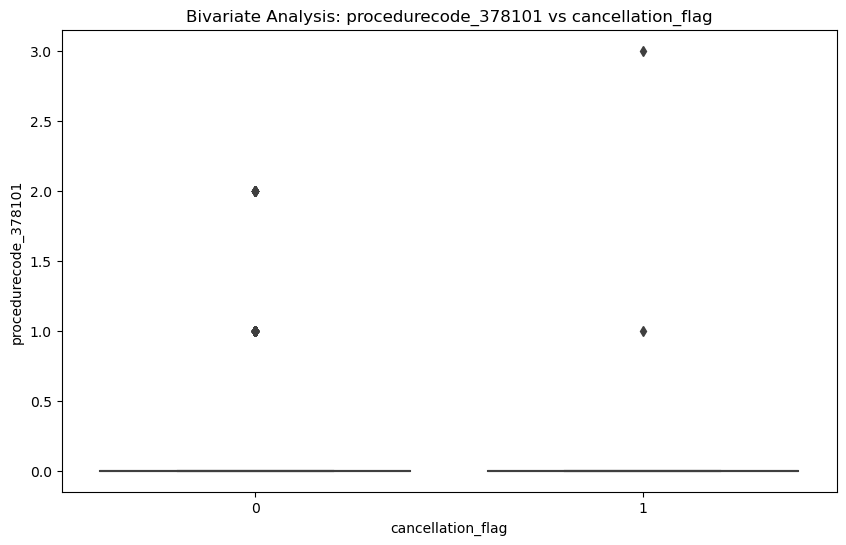


Descriptive Statistics for procedurecode_378101 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.002199  0.050974  0.0  0.0  0.0  0.0  2.0
1                   7263.0  0.000551  0.037104  0.0  0.0  0.0  0.0  3.0

---------------------------------------



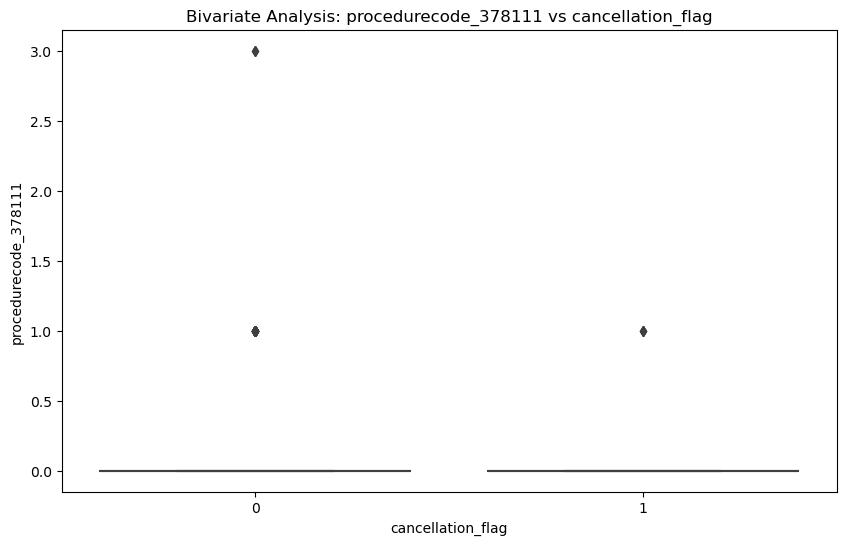


Descriptive Statistics for procedurecode_378111 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000535  0.026024  0.0  0.0  0.0  0.0  3.0
1                   7263.0  0.000413  0.020321  0.0  0.0  0.0  0.0  1.0

---------------------------------------



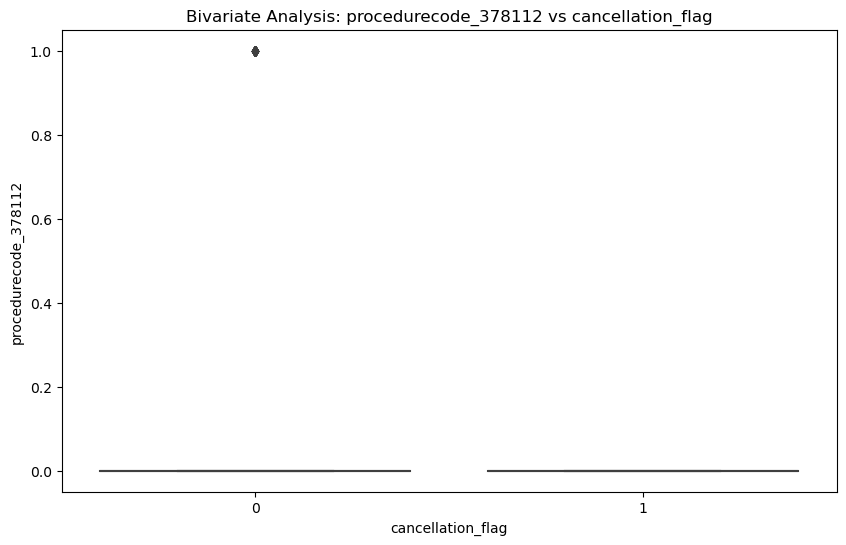


Descriptive Statistics for procedurecode_378112 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000392  0.019802  0.0  0.0  0.0  0.0  1.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



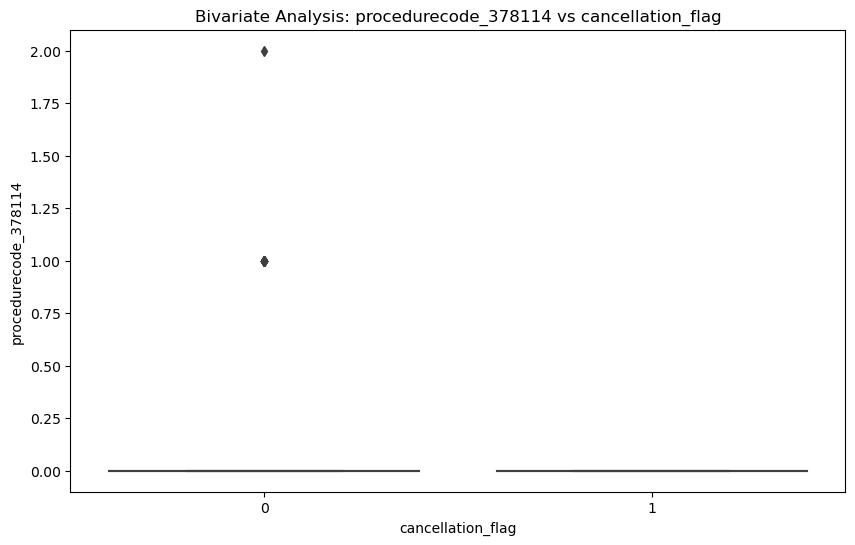


Descriptive Statistics for procedurecode_378114 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000202  0.015027  0.0  0.0  0.0  0.0  2.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



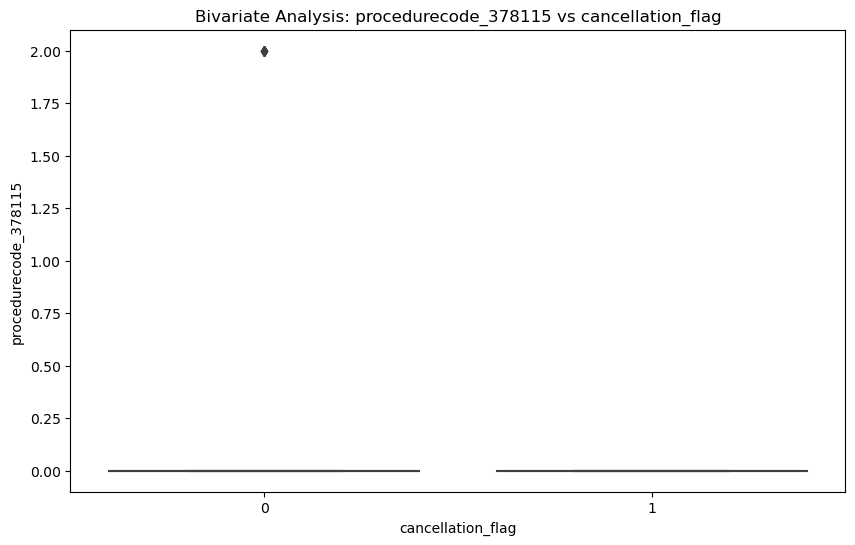


Descriptive Statistics for procedurecode_378115 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000095  0.013791  0.0  0.0  0.0  0.0  2.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



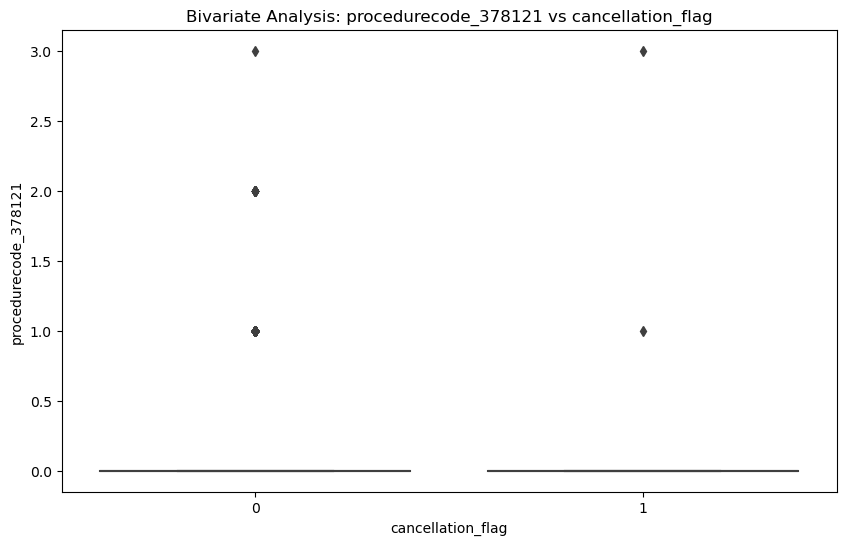


Descriptive Statistics for procedurecode_378121 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.002746  0.057729  0.0  0.0  0.0  0.0  3.0
1                   7263.0  0.000551  0.037104  0.0  0.0  0.0  0.0  3.0

---------------------------------------



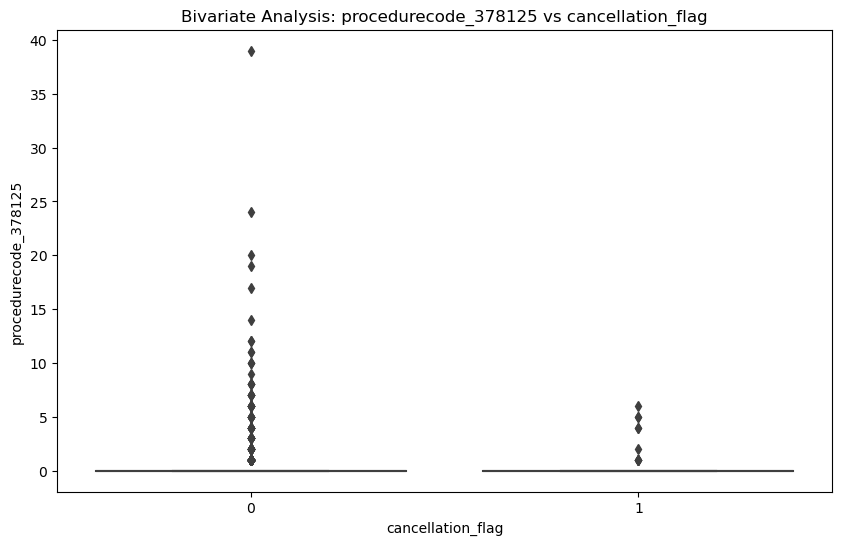


Descriptive Statistics for procedurecode_378125 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%   max
cancellation_flag                                                       
0                  84128.0  0.009153  0.273719  0.0  0.0  0.0  0.0  39.0
1                   7263.0  0.004268  0.132174  0.0  0.0  0.0  0.0   6.0

---------------------------------------



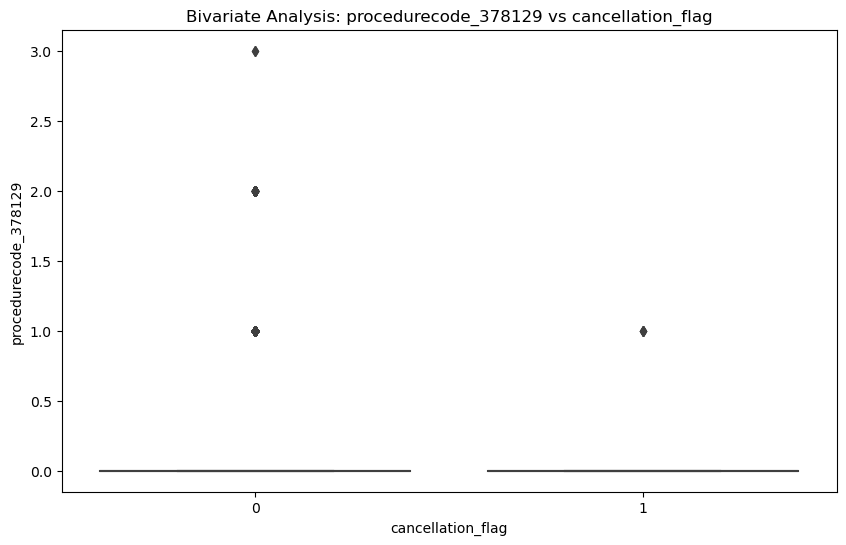


Descriptive Statistics for procedurecode_378129 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.004481  0.081683  0.0  0.0  0.0  0.0  3.0
1                   7263.0  0.000551  0.023463  0.0  0.0  0.0  0.0  1.0

---------------------------------------



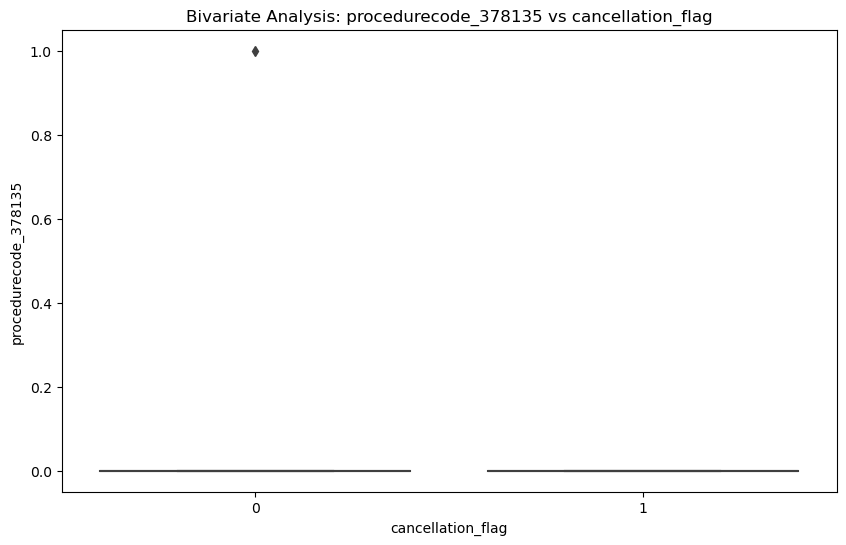


Descriptive Statistics for procedurecode_378135 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000012  0.003448  0.0  0.0  0.0  0.0  1.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



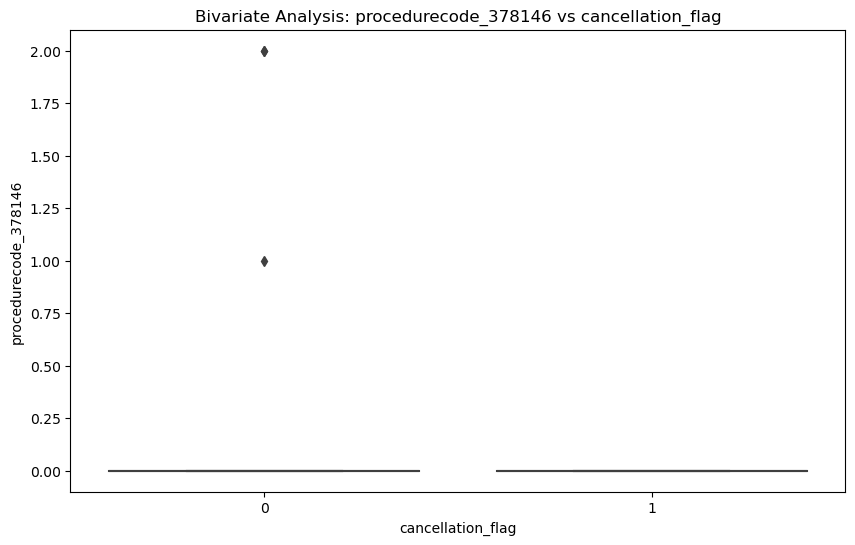


Descriptive Statistics for procedurecode_378146 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000059  0.010343  0.0  0.0  0.0  0.0  2.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



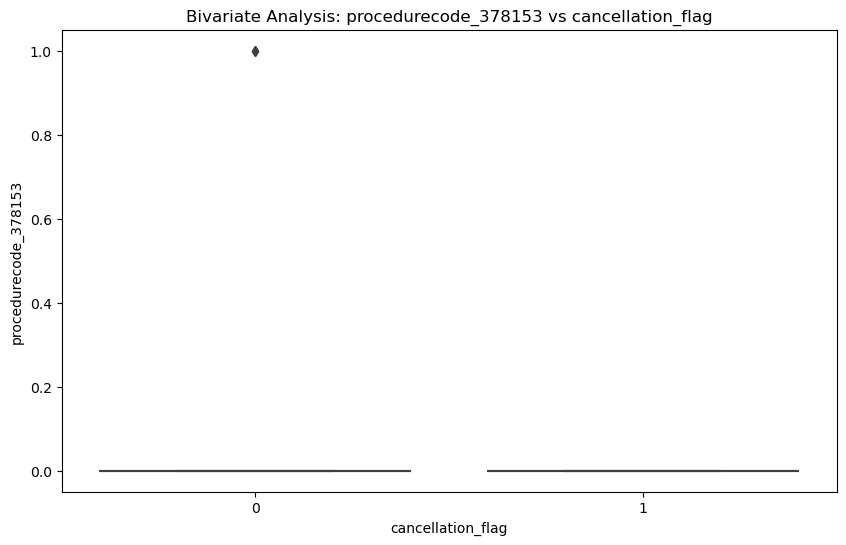


Descriptive Statistics for procedurecode_378153 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000024  0.004876  0.0  0.0  0.0  0.0  1.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



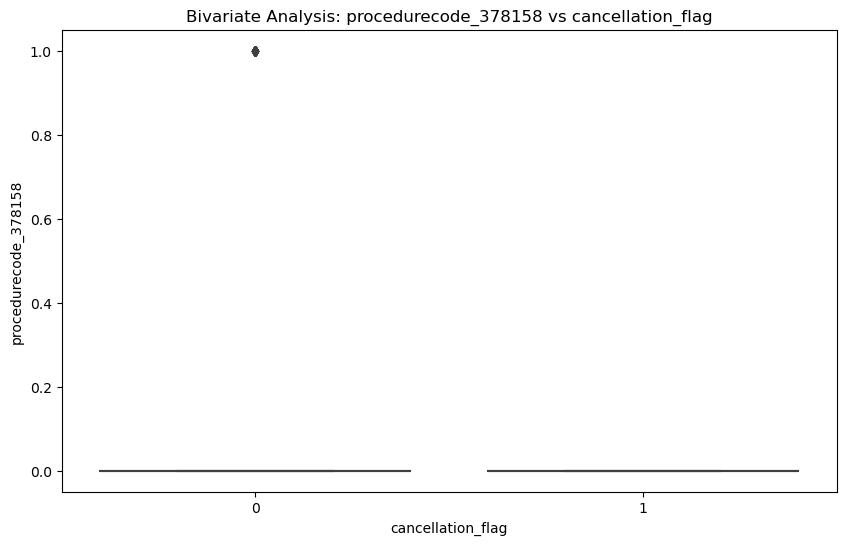


Descriptive Statistics for procedurecode_378158 by cancellation_flag:

                     count     mean     std  min  25%  50%  75%  max
cancellation_flag                                                   
0                  84128.0  0.00038  0.0195  0.0  0.0  0.0  0.0  1.0
1                   7263.0  0.00000  0.0000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



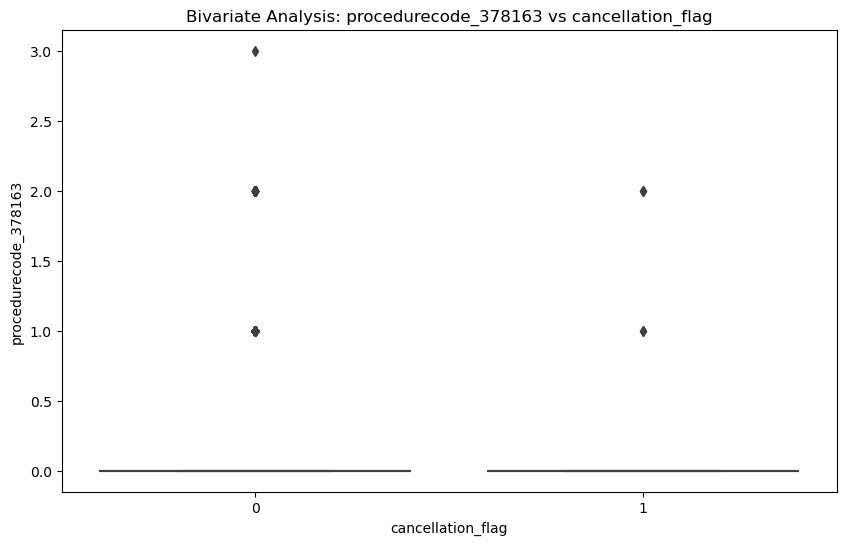


Descriptive Statistics for procedurecode_378163 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.005313  0.082934  0.0  0.0  0.0  0.0  3.0
1                   7263.0  0.000826  0.037099  0.0  0.0  0.0  0.0  2.0

---------------------------------------



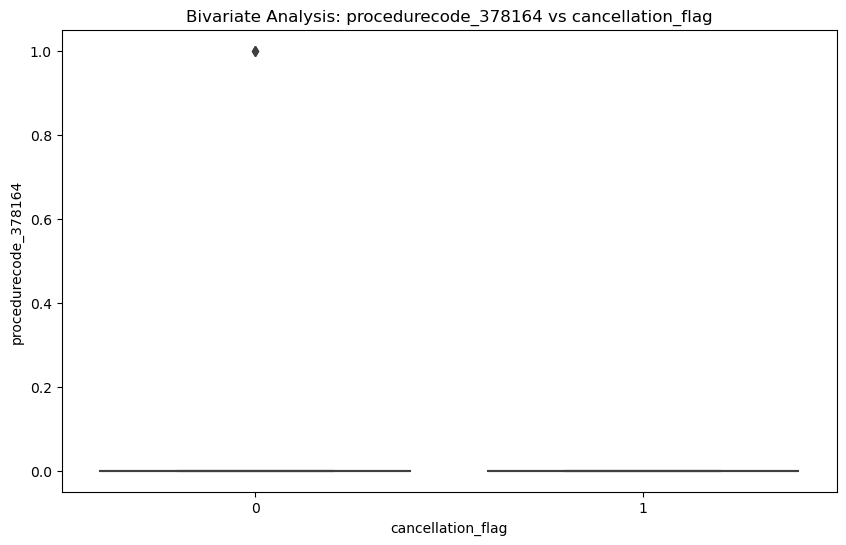


Descriptive Statistics for procedurecode_378164 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000024  0.004876  0.0  0.0  0.0  0.0  1.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



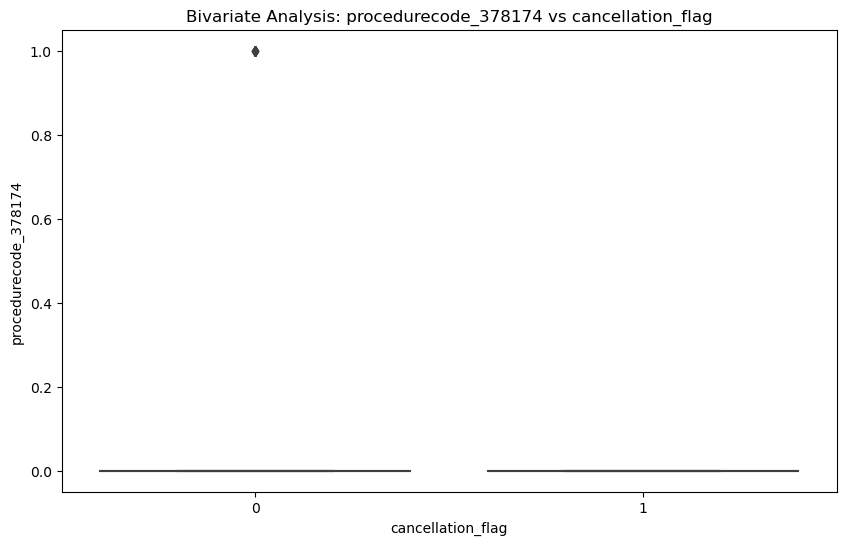


Descriptive Statistics for procedurecode_378174 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000071  0.008445  0.0  0.0  0.0  0.0  1.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



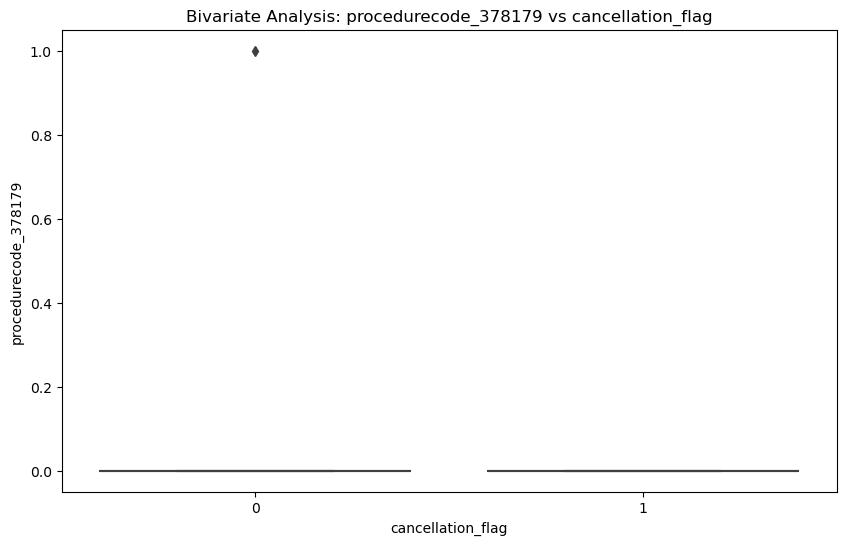


Descriptive Statistics for procedurecode_378179 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000012  0.003448  0.0  0.0  0.0  0.0  1.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



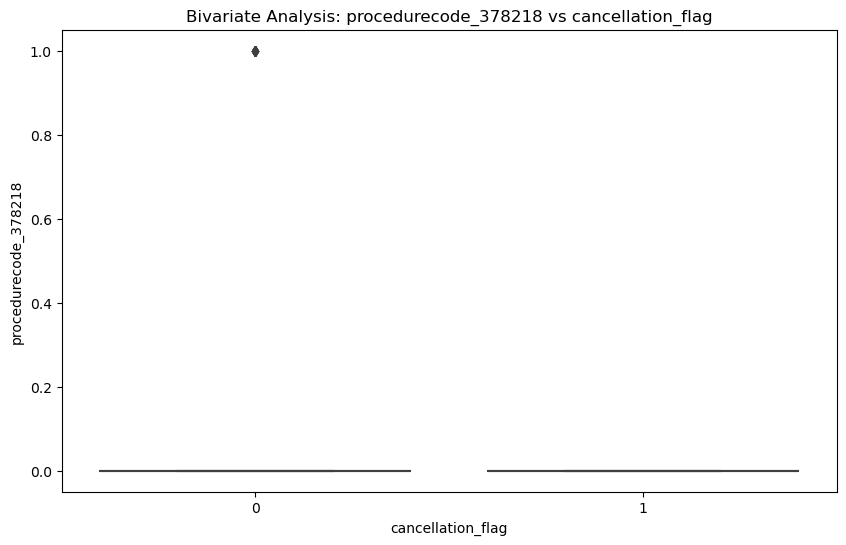


Descriptive Statistics for procedurecode_378218 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000095  0.009751  0.0  0.0  0.0  0.0  1.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



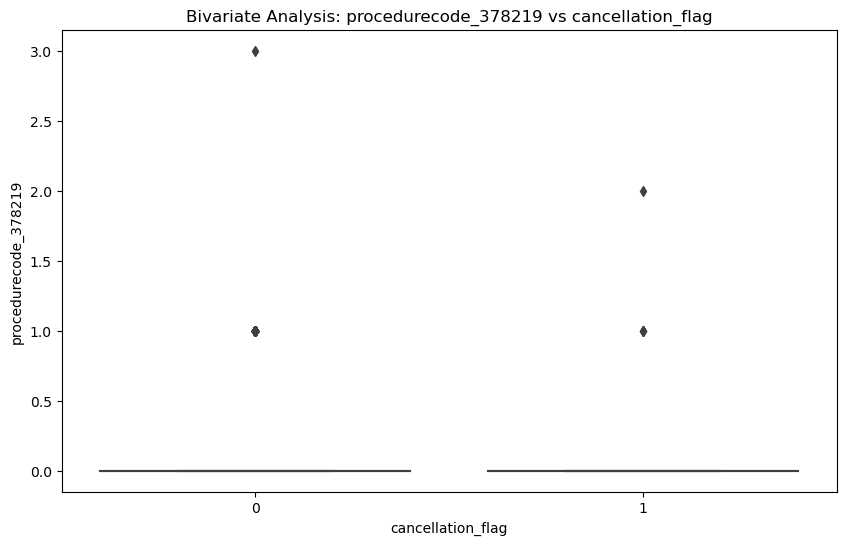


Descriptive Statistics for procedurecode_378219 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.001486  0.039433  0.0  0.0  0.0  0.0  3.0
1                   7263.0  0.000688  0.031039  0.0  0.0  0.0  0.0  2.0

---------------------------------------



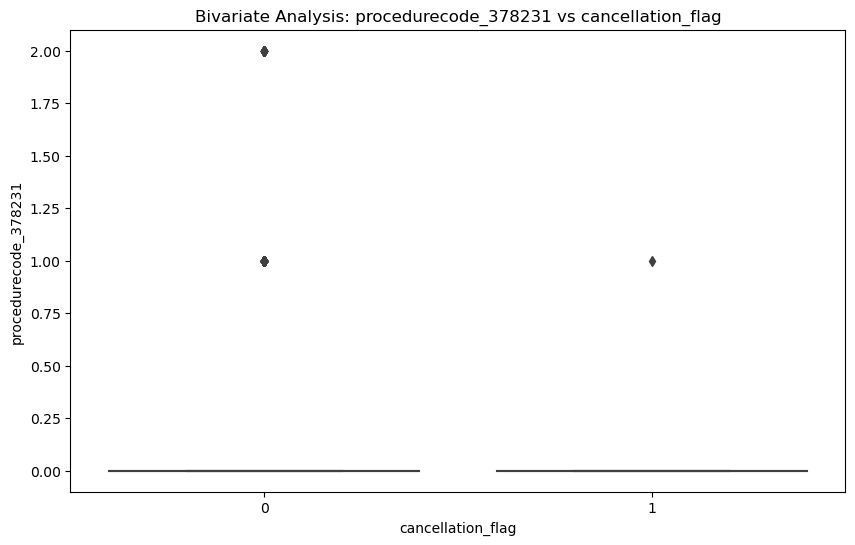


Descriptive Statistics for procedurecode_378231 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.002401  0.054895  0.0  0.0  0.0  0.0  2.0
1                   7263.0  0.000138  0.011734  0.0  0.0  0.0  0.0  1.0

---------------------------------------



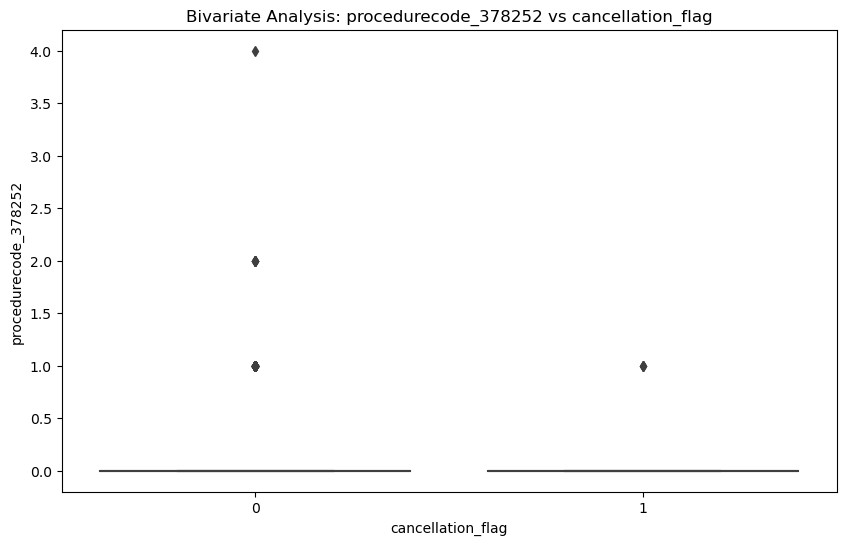


Descriptive Statistics for procedurecode_378252 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.001319  0.040037  0.0  0.0  0.0  0.0  4.0
1                   7263.0  0.000413  0.020321  0.0  0.0  0.0  0.0  1.0

---------------------------------------



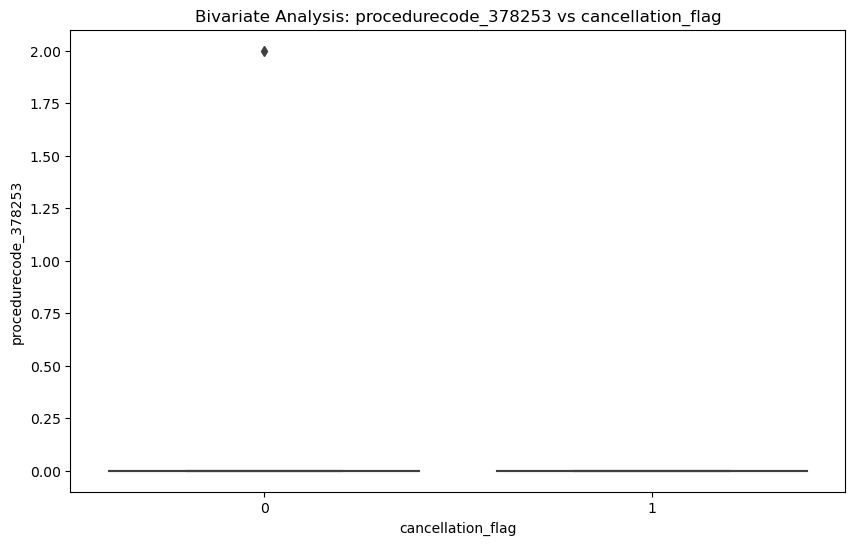


Descriptive Statistics for procedurecode_378253 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000024  0.006895  0.0  0.0  0.0  0.0  2.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



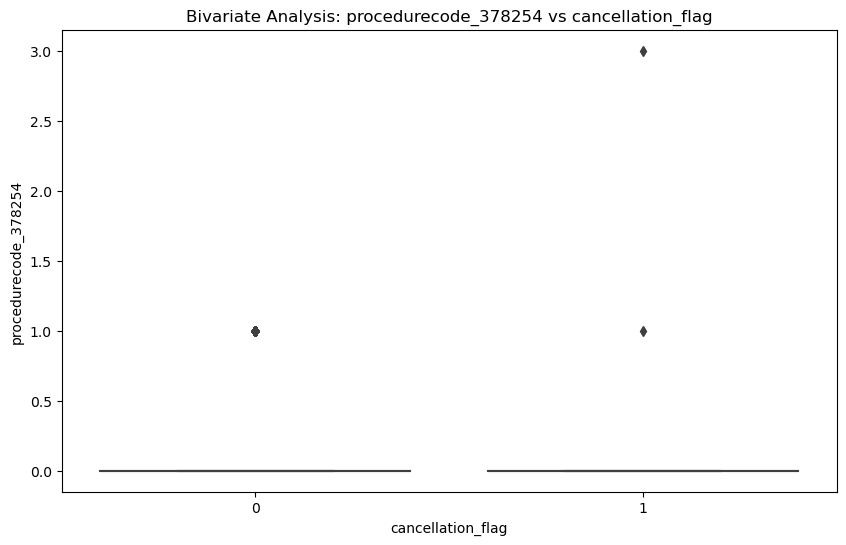


Descriptive Statistics for procedurecode_378254 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.002829  0.053114  0.0  0.0  0.0  0.0  1.0
1                   7263.0  0.000551  0.037104  0.0  0.0  0.0  0.0  3.0

---------------------------------------



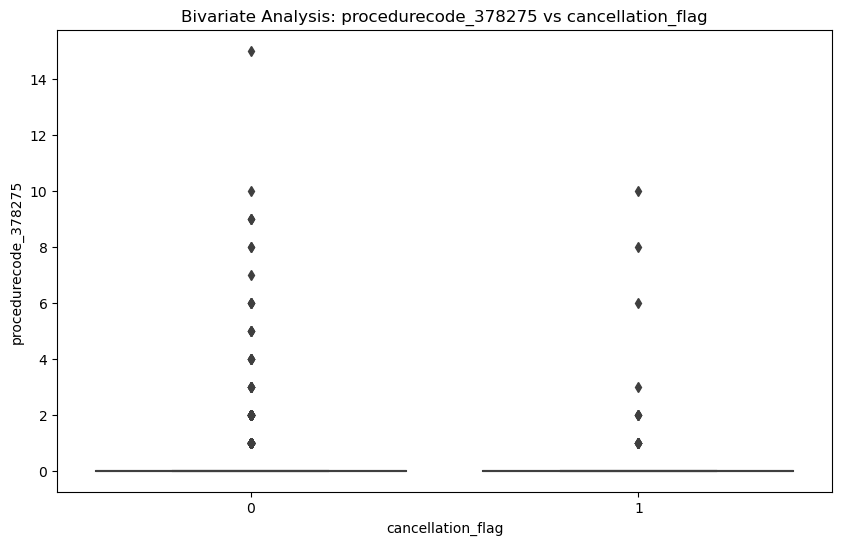


Descriptive Statistics for procedurecode_378275 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%   max
cancellation_flag                                                       
0                  84128.0  0.004719  0.134113  0.0  0.0  0.0  0.0  15.0
1                   7263.0  0.006058  0.179404  0.0  0.0  0.0  0.0  10.0

---------------------------------------



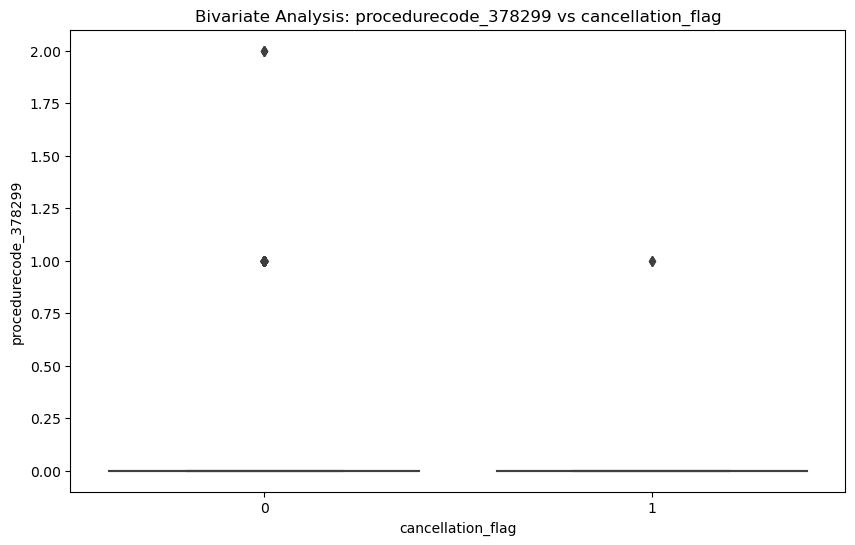


Descriptive Statistics for procedurecode_378299 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.001438  0.038827  0.0  0.0  0.0  0.0  2.0
1                   7263.0  0.000275  0.016593  0.0  0.0  0.0  0.0  1.0

---------------------------------------



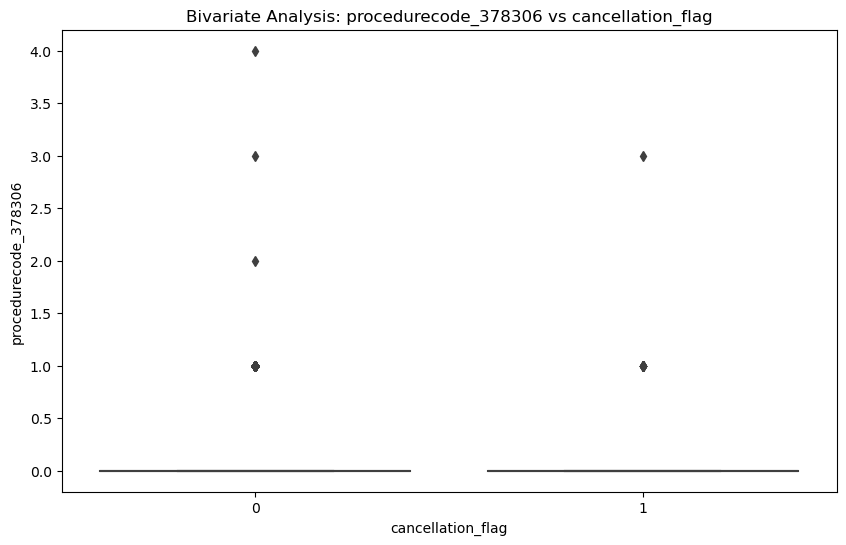


Descriptive Statistics for procedurecode_378306 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.002556  0.052791  0.0  0.0  0.0  0.0  4.0
1                   7263.0  0.002065  0.053735  0.0  0.0  0.0  0.0  3.0

---------------------------------------



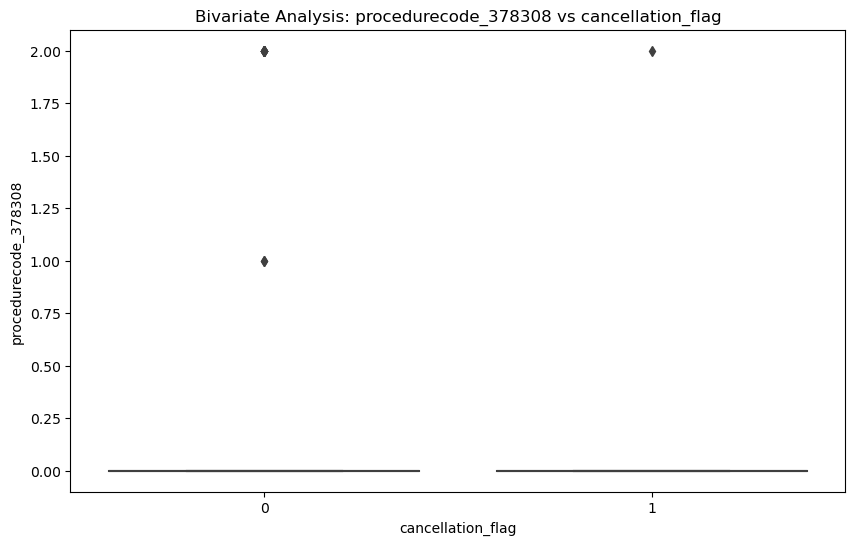


Descriptive Statistics for procedurecode_378308 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000238  0.021252  0.0  0.0  0.0  0.0  2.0
1                   7263.0  0.000275  0.023468  0.0  0.0  0.0  0.0  2.0

---------------------------------------



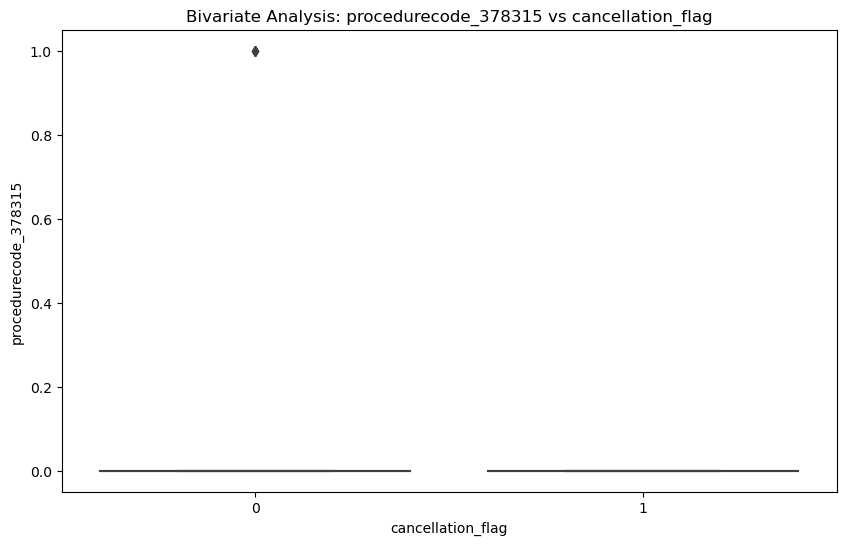


Descriptive Statistics for procedurecode_378315 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000036  0.005972  0.0  0.0  0.0  0.0  1.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



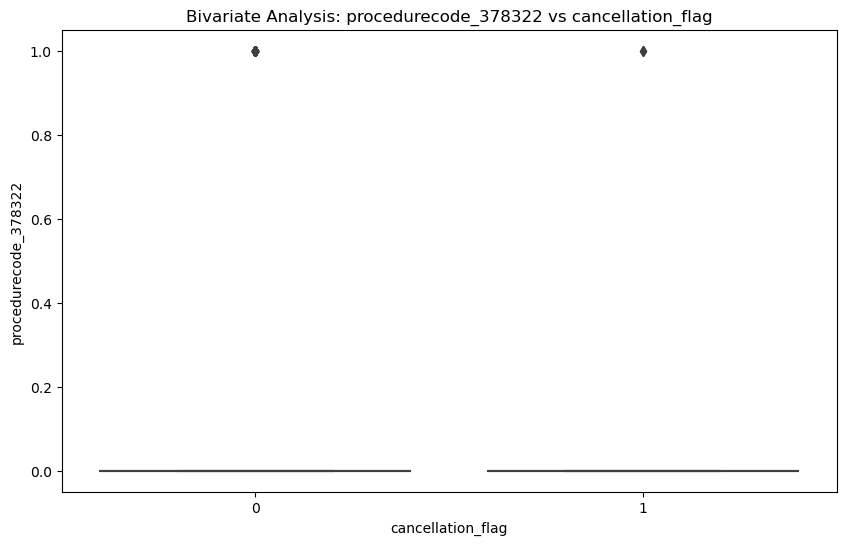


Descriptive Statistics for procedurecode_378322 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000987  0.031395  0.0  0.0  0.0  0.0  1.0
1                   7263.0  0.000275  0.016593  0.0  0.0  0.0  0.0  1.0

---------------------------------------



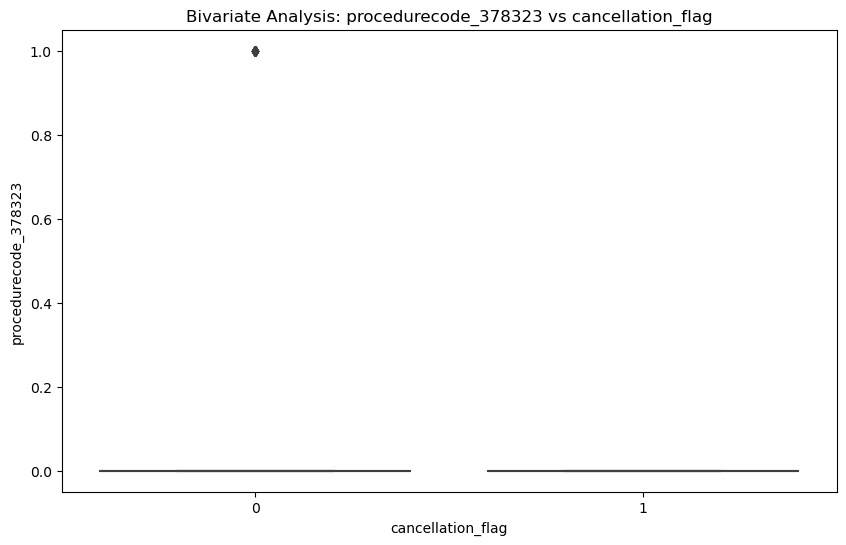


Descriptive Statistics for procedurecode_378323 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000309  0.017577  0.0  0.0  0.0  0.0  1.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



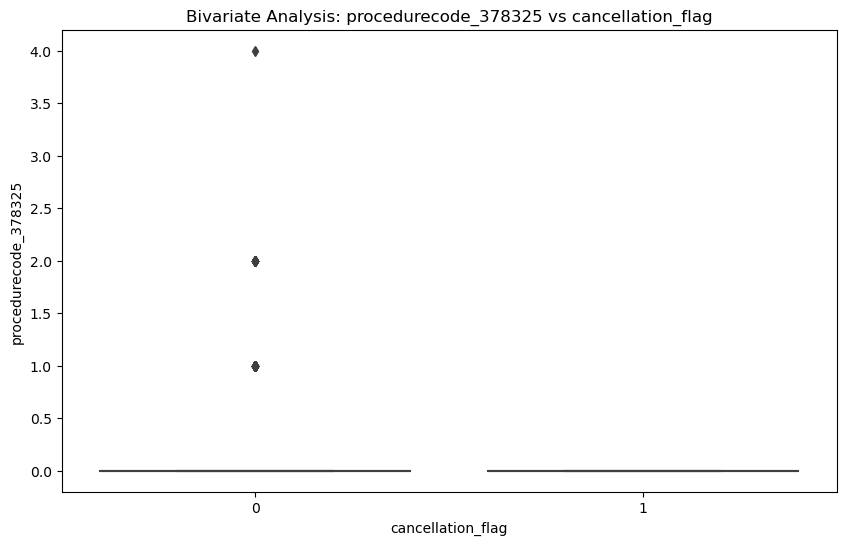


Descriptive Statistics for procedurecode_378325 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.001117  0.040486  0.0  0.0  0.0  0.0  4.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



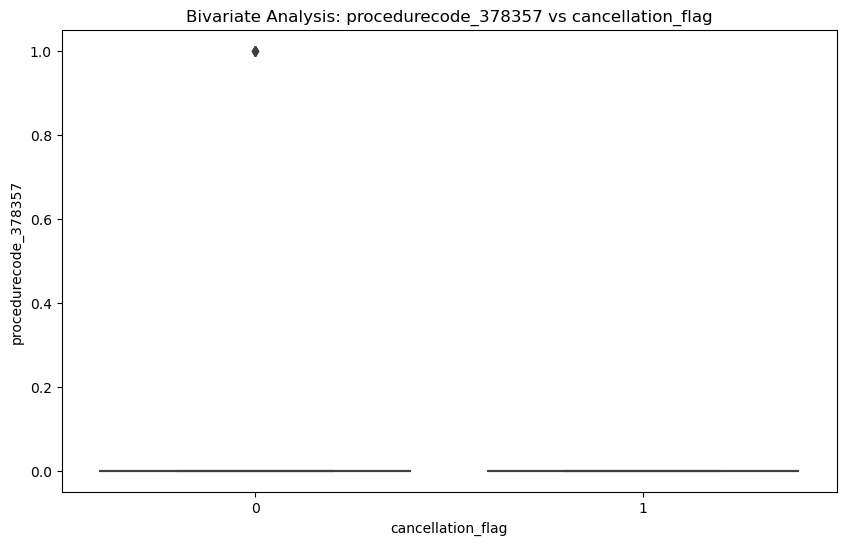


Descriptive Statistics for procedurecode_378357 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000036  0.005972  0.0  0.0  0.0  0.0  1.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



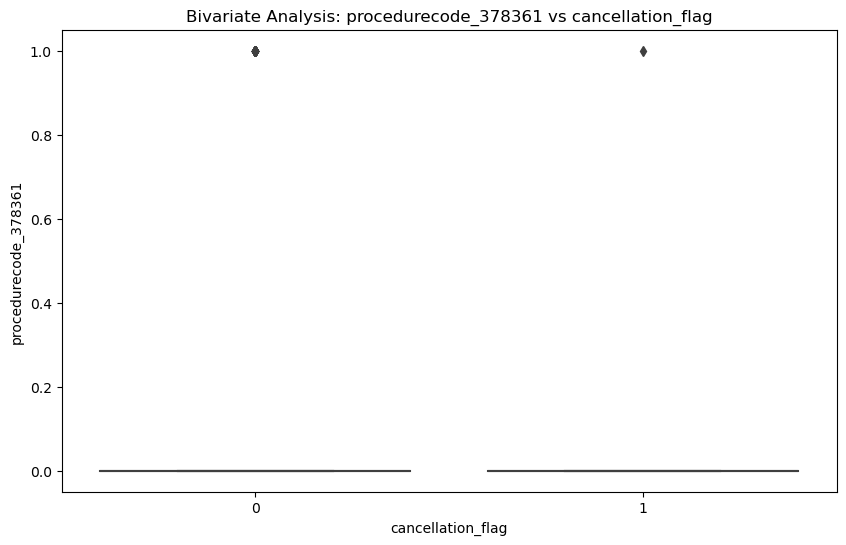


Descriptive Statistics for procedurecode_378361 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000487  0.022071  0.0  0.0  0.0  0.0  1.0
1                   7263.0  0.000138  0.011734  0.0  0.0  0.0  0.0  1.0

---------------------------------------



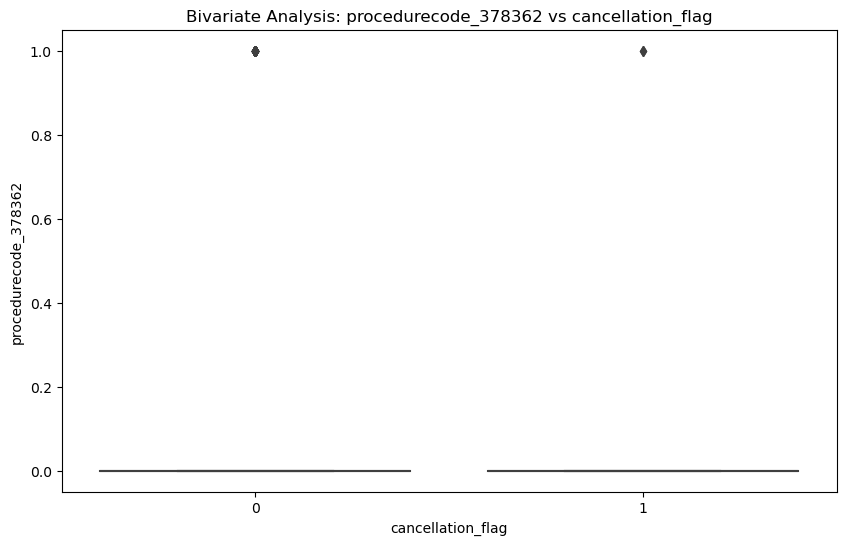


Descriptive Statistics for procedurecode_378362 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000689  0.026248  0.0  0.0  0.0  0.0  1.0
1                   7263.0  0.000275  0.016593  0.0  0.0  0.0  0.0  1.0

---------------------------------------



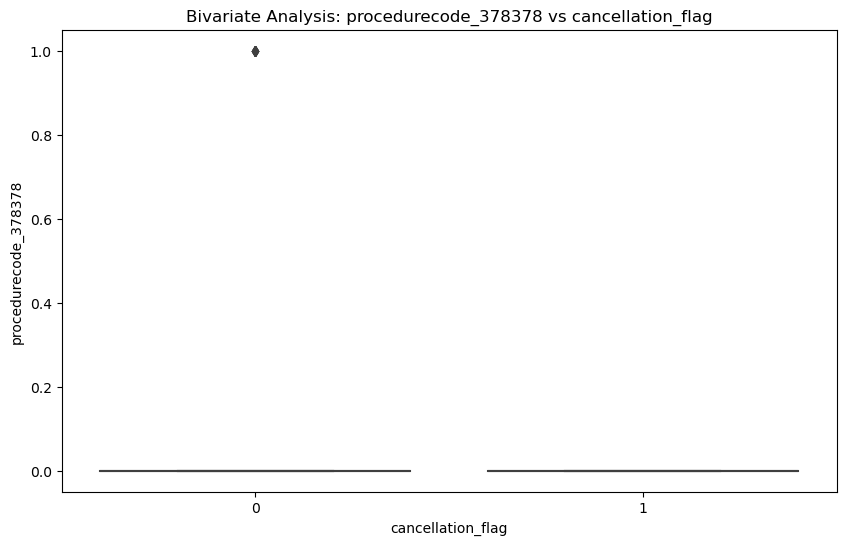


Descriptive Statistics for procedurecode_378378 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000083  0.009121  0.0  0.0  0.0  0.0  1.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



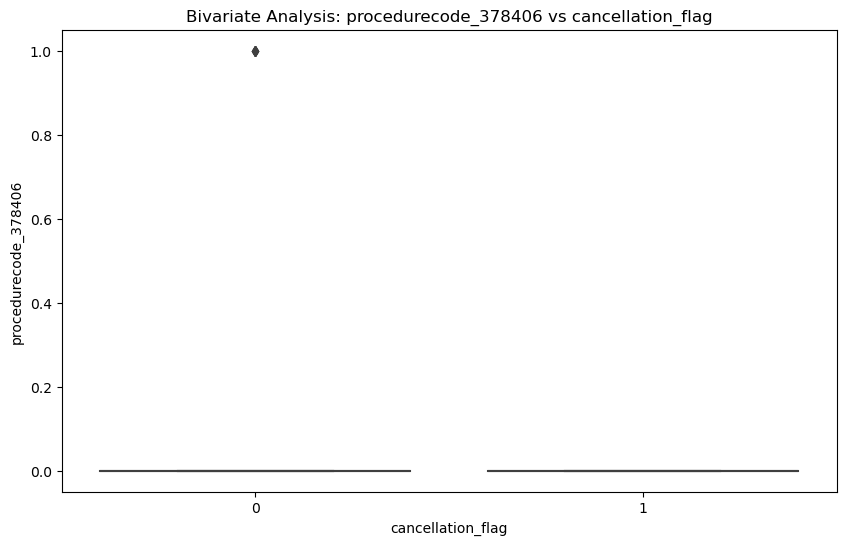


Descriptive Statistics for procedurecode_378406 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000048  0.006895  0.0  0.0  0.0  0.0  1.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



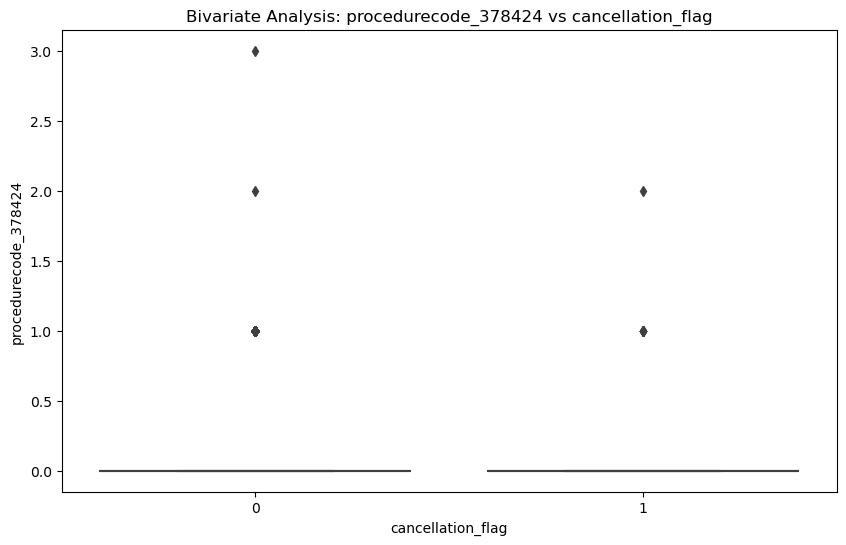


Descriptive Statistics for procedurecode_378424 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.006134  0.078683  0.0  0.0  0.0  0.0  3.0
1                   7263.0  0.001239  0.038900  0.0  0.0  0.0  0.0  2.0

---------------------------------------



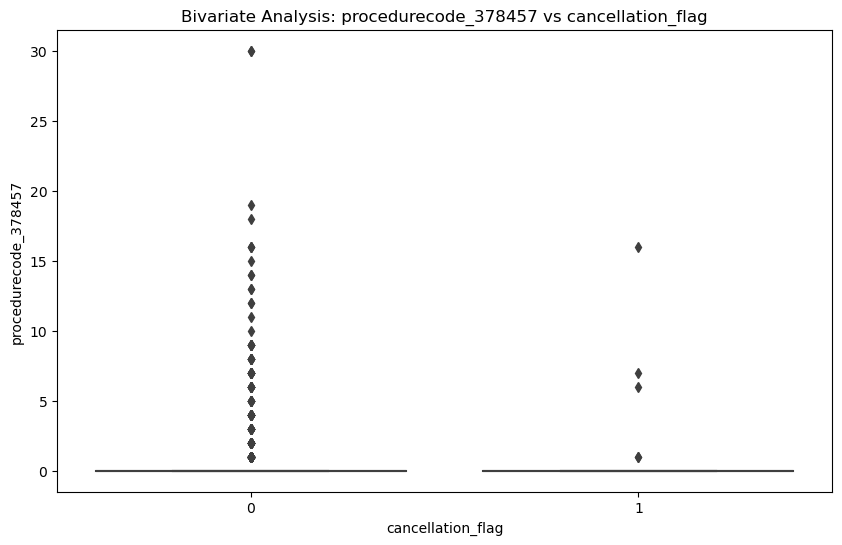


Descriptive Statistics for procedurecode_378457 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%   max
cancellation_flag                                                       
0                  84128.0  0.010627  0.305595  0.0  0.0  0.0  0.0  30.0
1                   7263.0  0.004268  0.217288  0.0  0.0  0.0  0.0  16.0

---------------------------------------



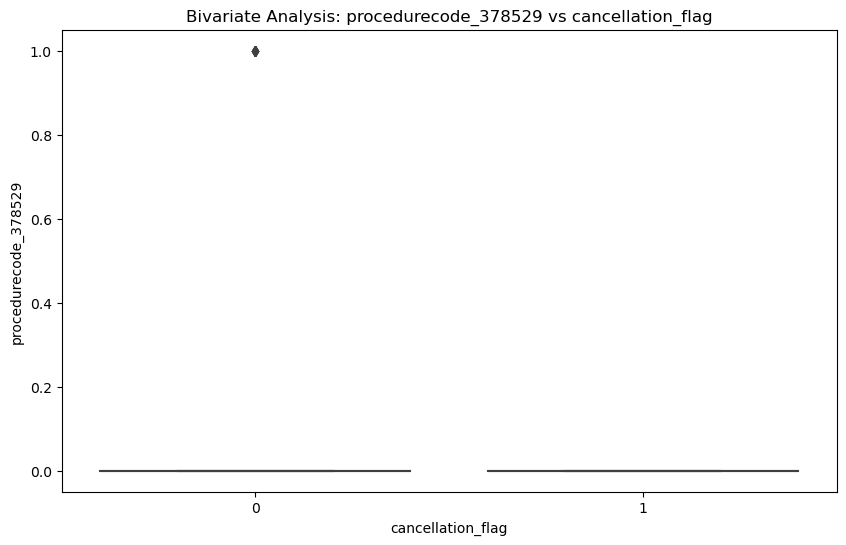


Descriptive Statistics for procedurecode_378529 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000083  0.009121  0.0  0.0  0.0  0.0  1.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



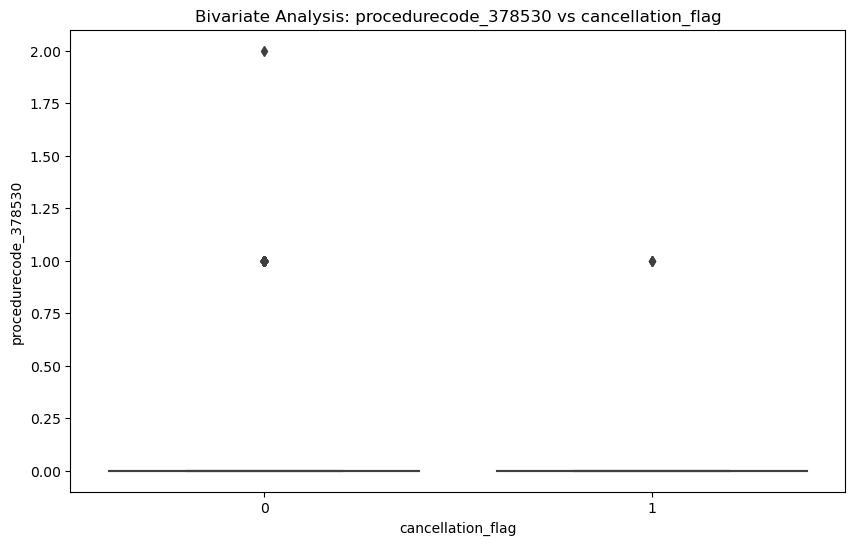


Descriptive Statistics for procedurecode_378530 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.001700  0.041481  0.0  0.0  0.0  0.0  2.0
1                   7263.0  0.000413  0.020321  0.0  0.0  0.0  0.0  1.0

---------------------------------------



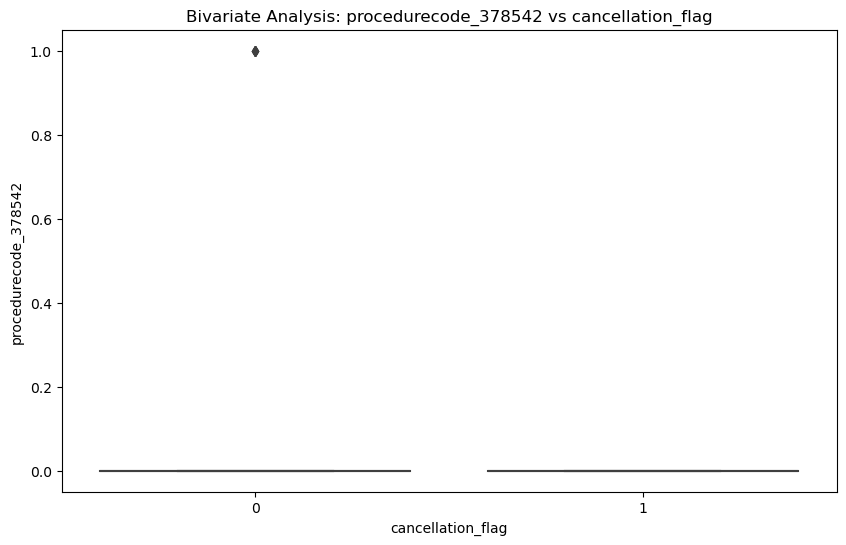


Descriptive Statistics for procedurecode_378542 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000048  0.006895  0.0  0.0  0.0  0.0  1.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



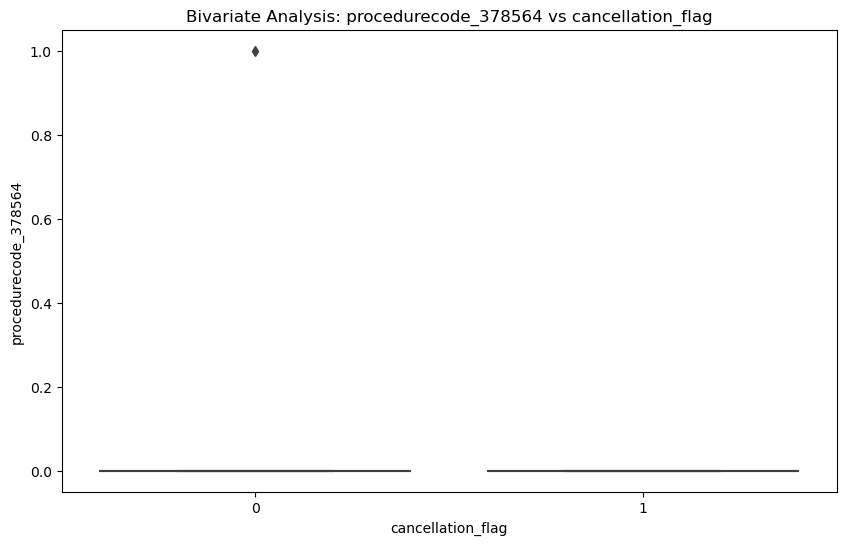


Descriptive Statistics for procedurecode_378564 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000012  0.003448  0.0  0.0  0.0  0.0  1.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



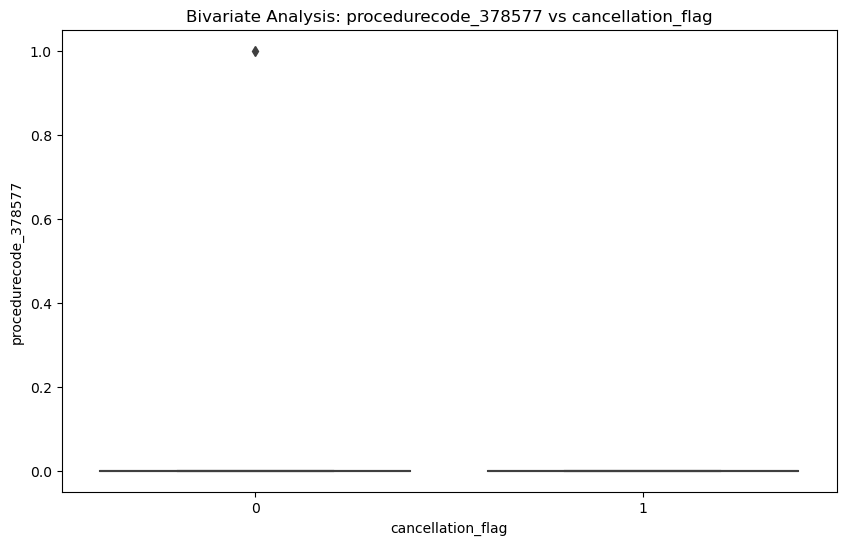


Descriptive Statistics for procedurecode_378577 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000012  0.003448  0.0  0.0  0.0  0.0  1.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



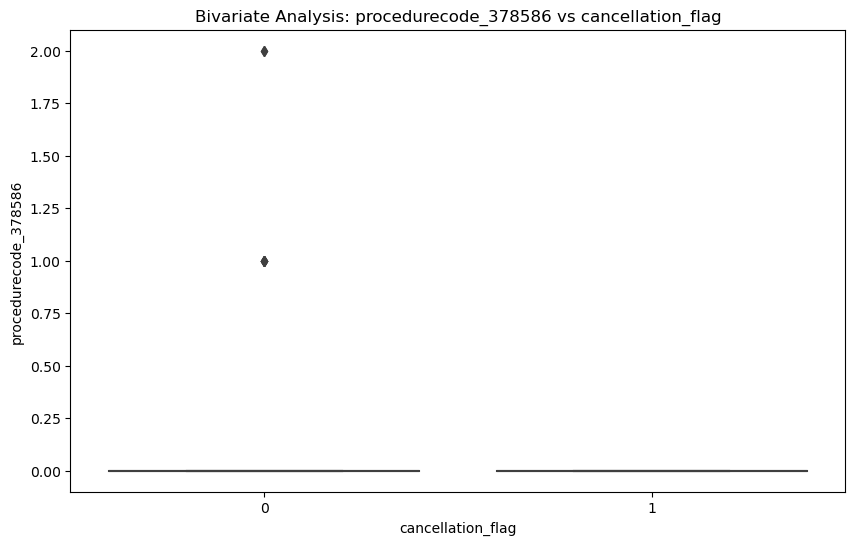


Descriptive Statistics for procedurecode_378586 by cancellation_flag:

                     count      mean     std  min  25%  50%  75%  max
cancellation_flag                                                    
0                  84128.0  0.000119  0.0129  0.0  0.0  0.0  0.0  2.0
1                   7263.0  0.000000  0.0000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



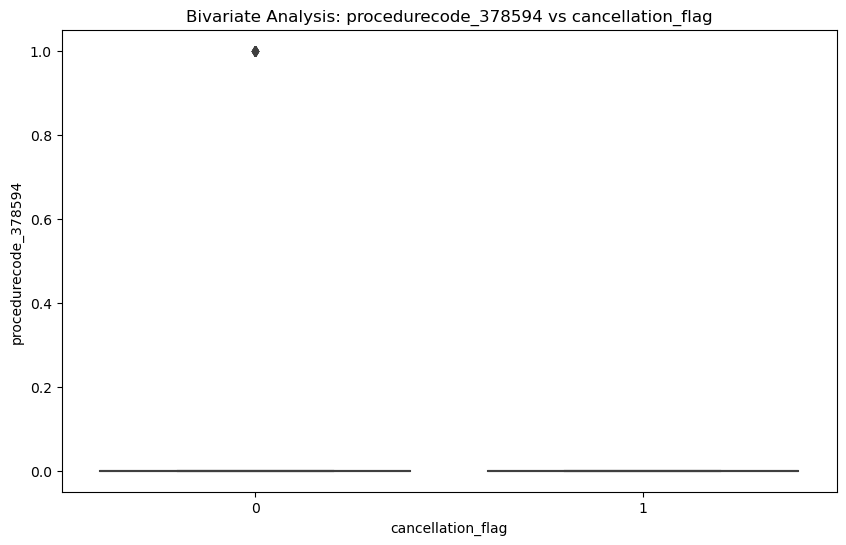


Descriptive Statistics for procedurecode_378594 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000119  0.010902  0.0  0.0  0.0  0.0  1.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



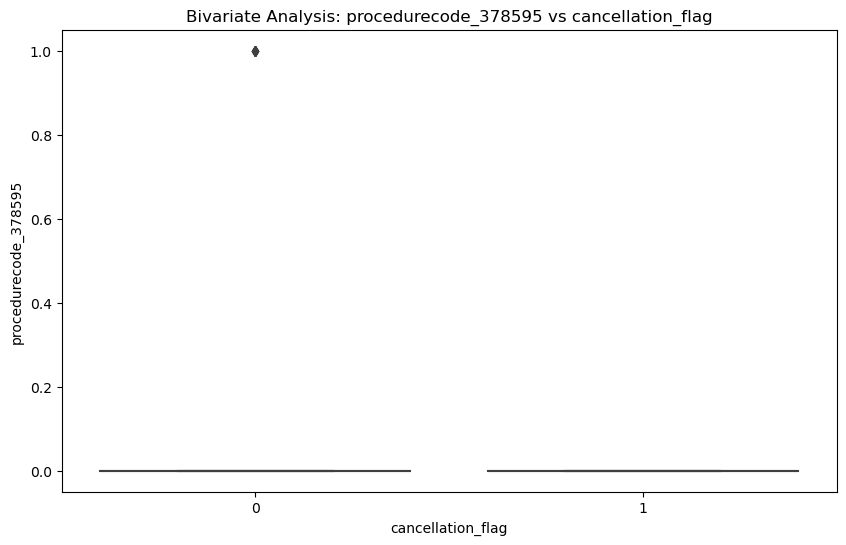


Descriptive Statistics for procedurecode_378595 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000059  0.007709  0.0  0.0  0.0  0.0  1.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



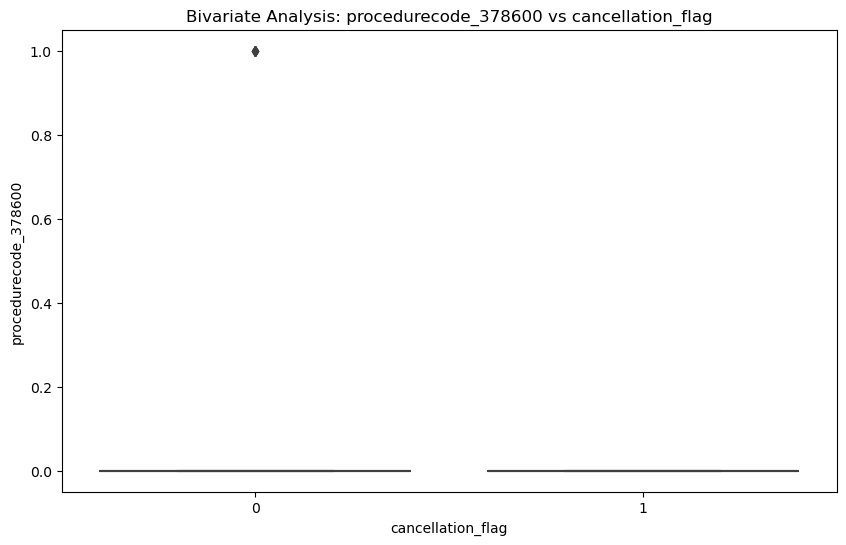


Descriptive Statistics for procedurecode_378600 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000048  0.006895  0.0  0.0  0.0  0.0  1.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



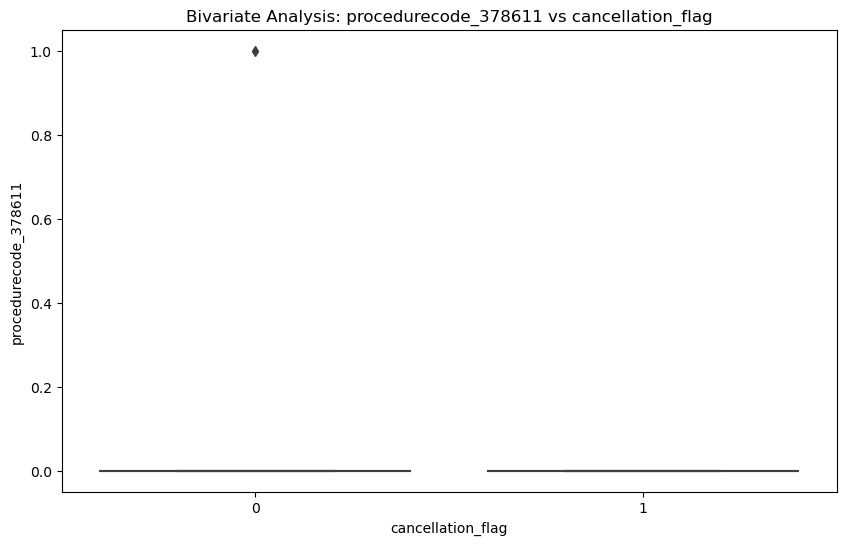


Descriptive Statistics for procedurecode_378611 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000012  0.003448  0.0  0.0  0.0  0.0  1.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



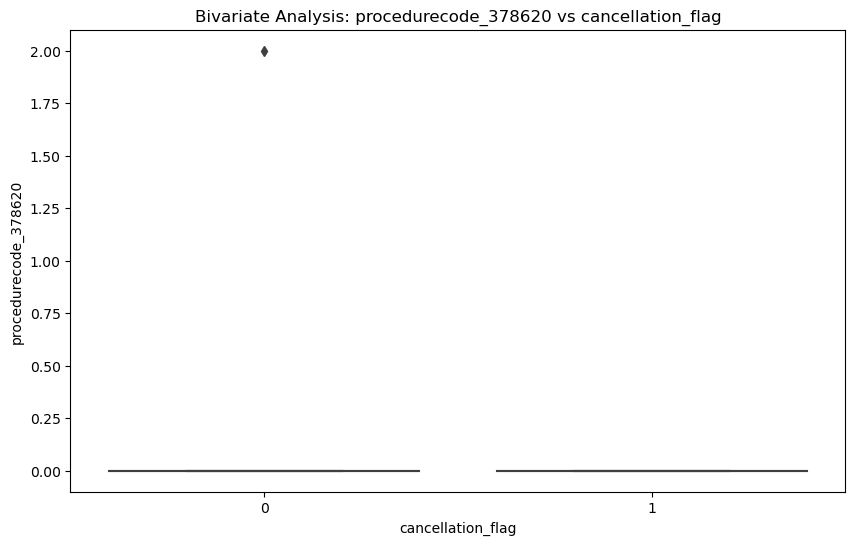


Descriptive Statistics for procedurecode_378620 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000024  0.006895  0.0  0.0  0.0  0.0  2.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



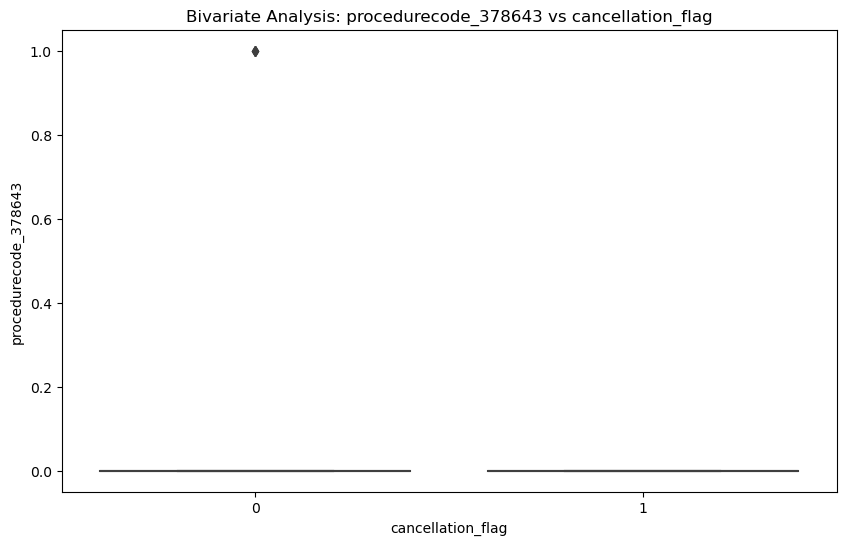


Descriptive Statistics for procedurecode_378643 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000036  0.005972  0.0  0.0  0.0  0.0  1.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



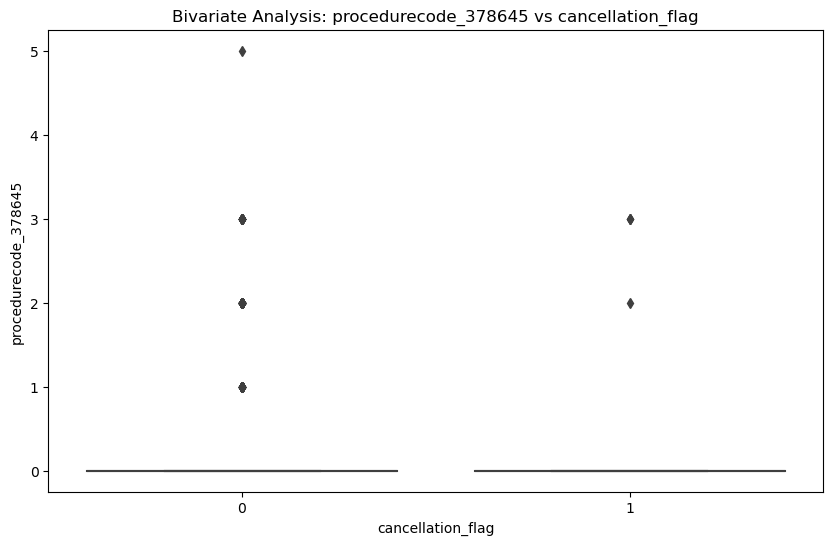


Descriptive Statistics for procedurecode_378645 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.004232  0.094828  0.0  0.0  0.0  0.0  5.0
1                   7263.0  0.001515  0.065318  0.0  0.0  0.0  0.0  3.0

---------------------------------------



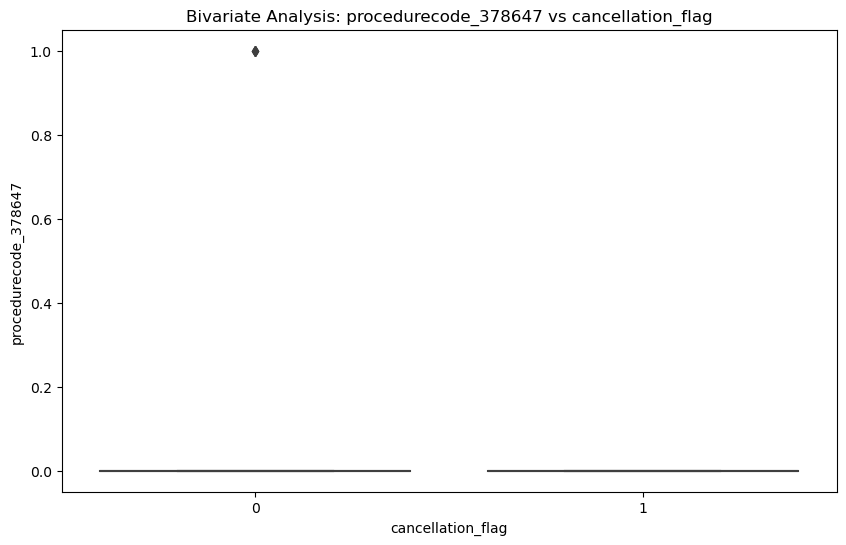


Descriptive Statistics for procedurecode_378647 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000036  0.005972  0.0  0.0  0.0  0.0  1.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



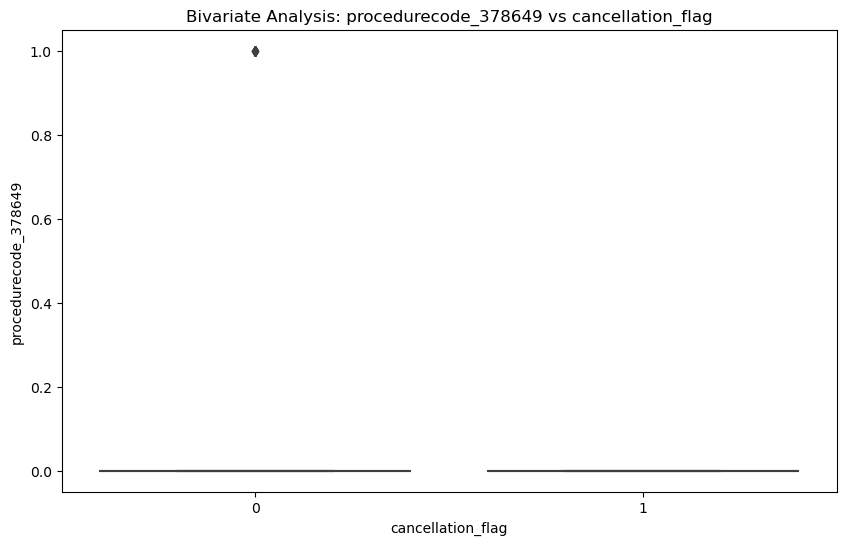


Descriptive Statistics for procedurecode_378649 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000059  0.007709  0.0  0.0  0.0  0.0  1.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



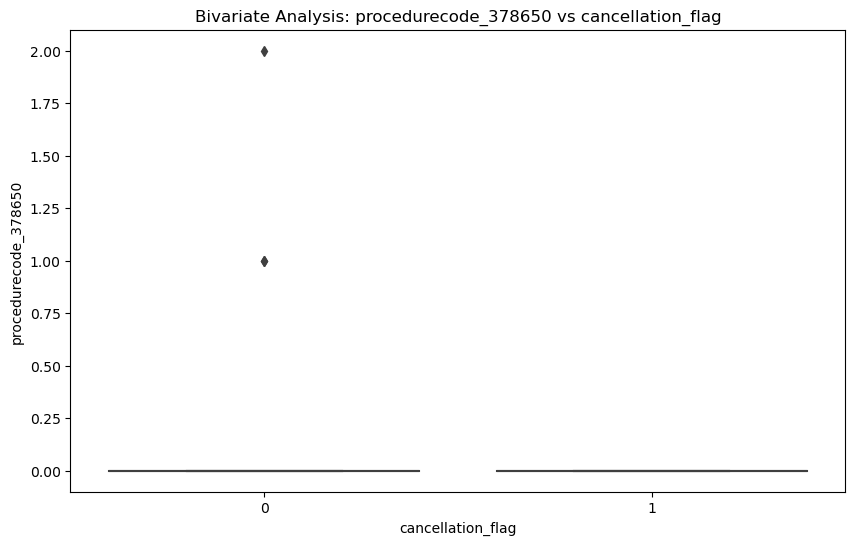


Descriptive Statistics for procedurecode_378650 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000048  0.008445  0.0  0.0  0.0  0.0  2.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



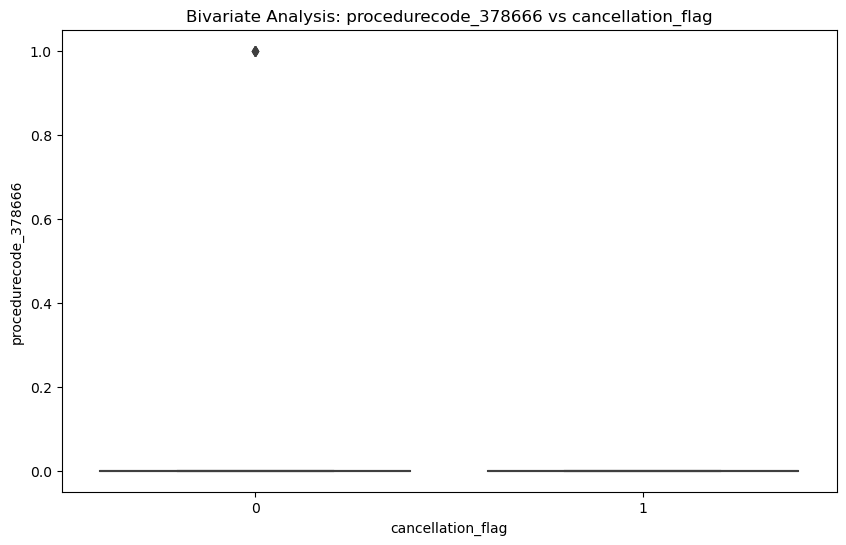


Descriptive Statistics for procedurecode_378666 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000048  0.006895  0.0  0.0  0.0  0.0  1.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



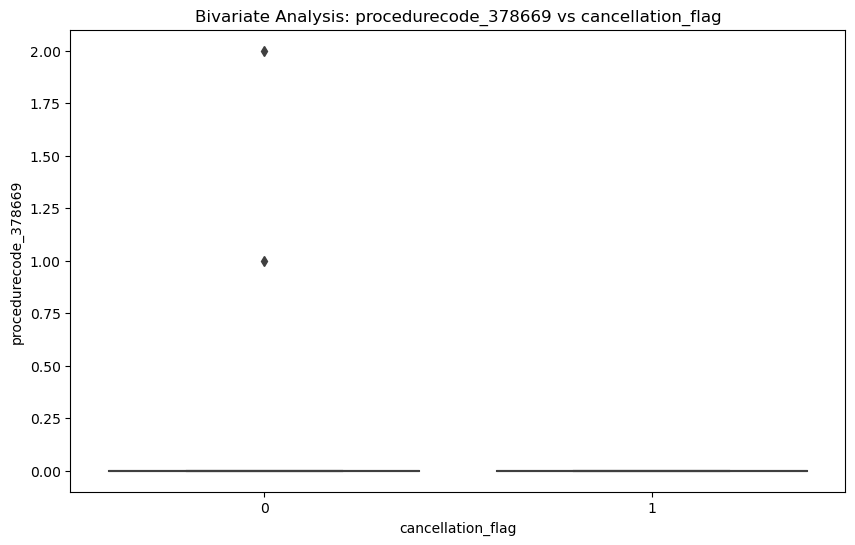


Descriptive Statistics for procedurecode_378669 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000036  0.007709  0.0  0.0  0.0  0.0  2.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



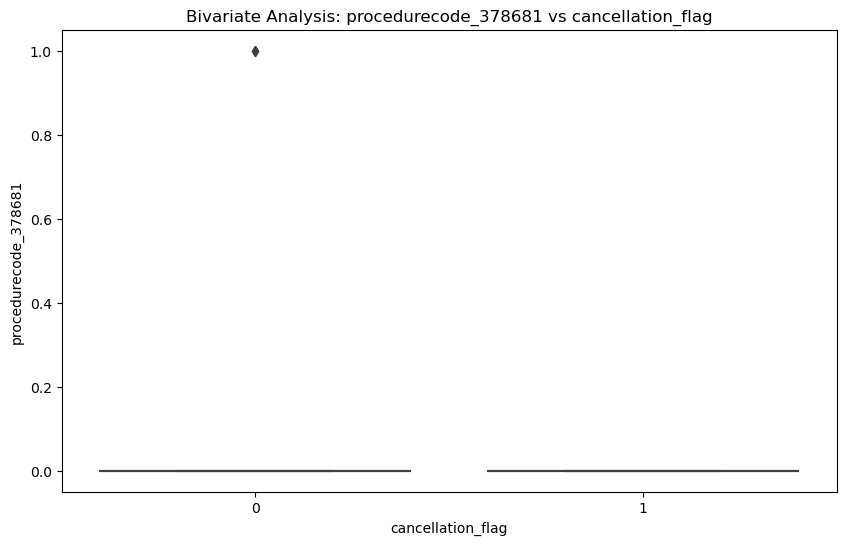


Descriptive Statistics for procedurecode_378681 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000024  0.004876  0.0  0.0  0.0  0.0  1.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



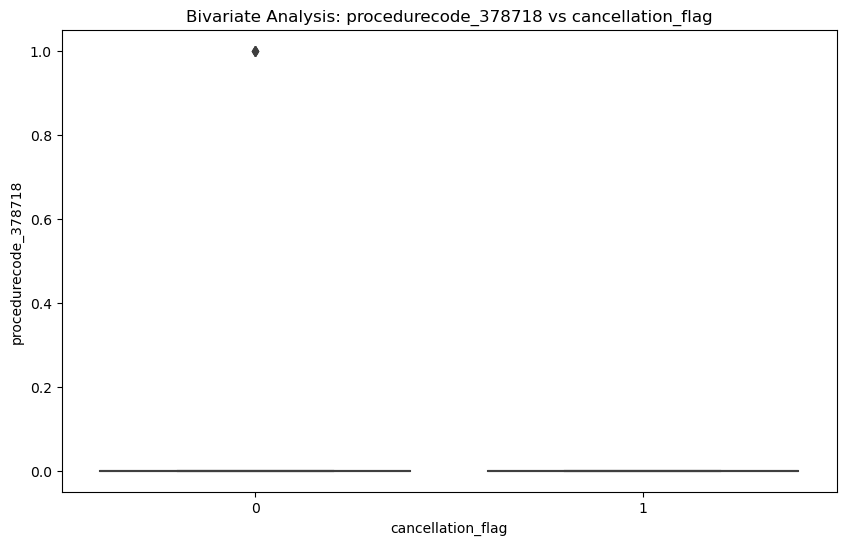


Descriptive Statistics for procedurecode_378718 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000036  0.005972  0.0  0.0  0.0  0.0  1.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



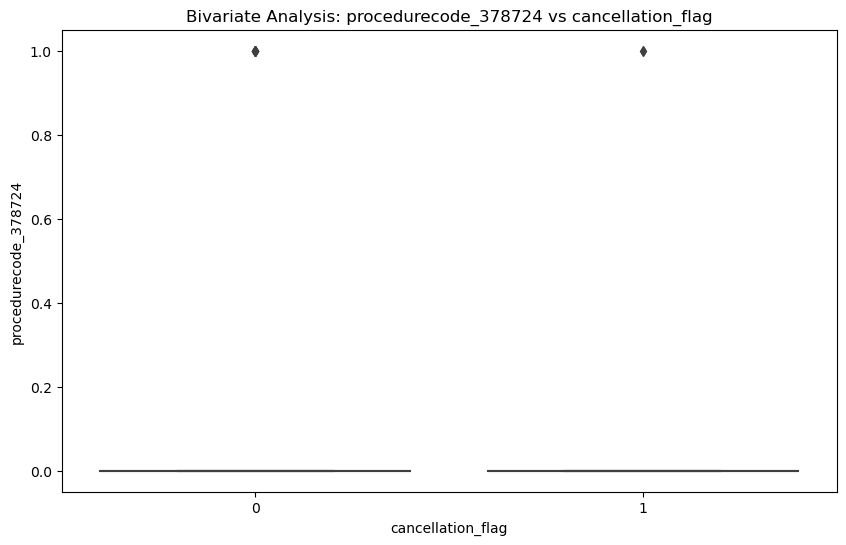


Descriptive Statistics for procedurecode_378724 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000048  0.006895  0.0  0.0  0.0  0.0  1.0
1                   7263.0  0.000138  0.011734  0.0  0.0  0.0  0.0  1.0

---------------------------------------



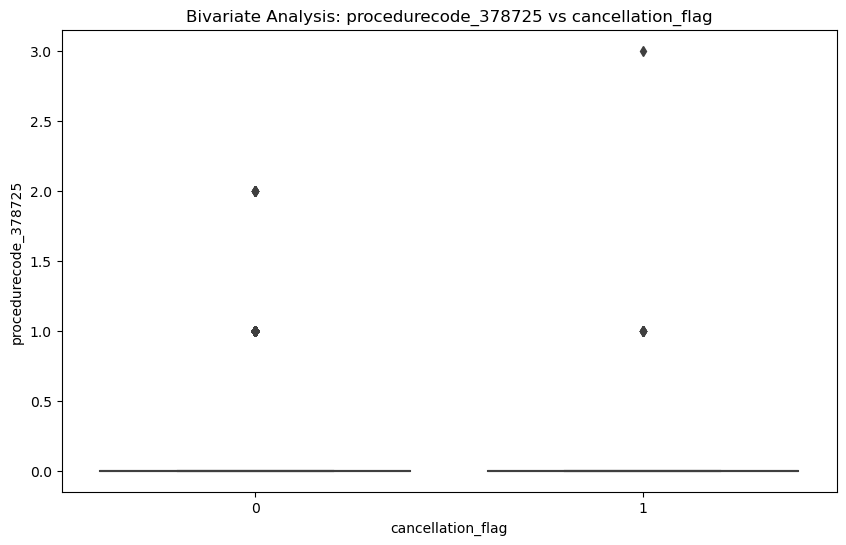


Descriptive Statistics for procedurecode_378725 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.013479  0.116343  0.0  0.0  0.0  0.0  2.0
1                   7263.0  0.001652  0.049759  0.0  0.0  0.0  0.0  3.0

---------------------------------------



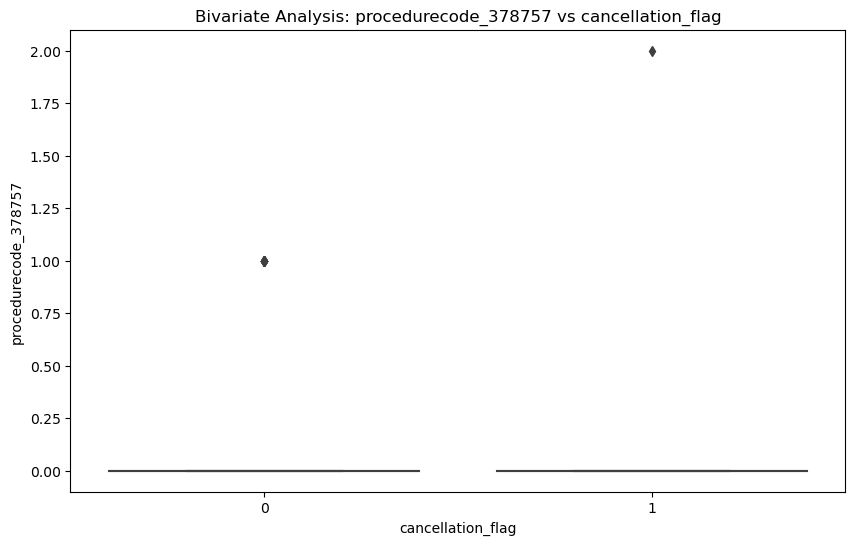


Descriptive Statistics for procedurecode_378757 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000119  0.010902  0.0  0.0  0.0  0.0  1.0
1                   7263.0  0.000275  0.023468  0.0  0.0  0.0  0.0  2.0

---------------------------------------



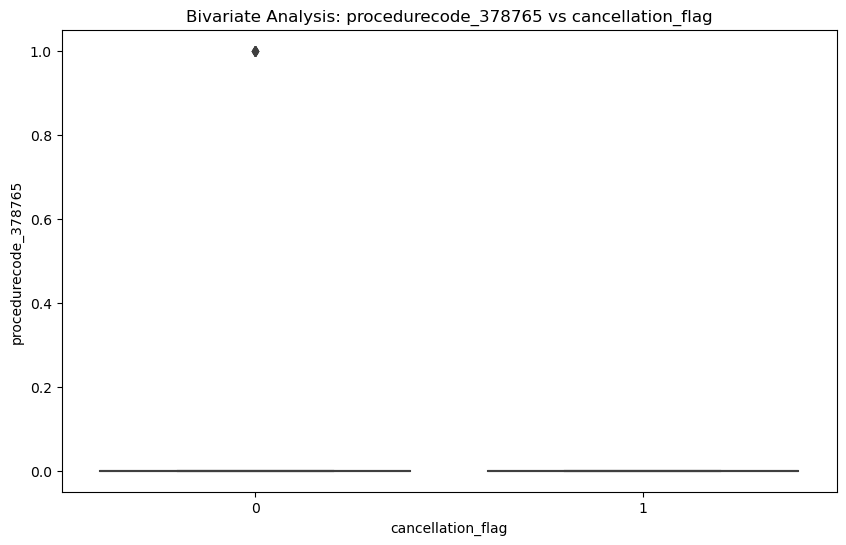


Descriptive Statistics for procedurecode_378765 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000059  0.007709  0.0  0.0  0.0  0.0  1.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



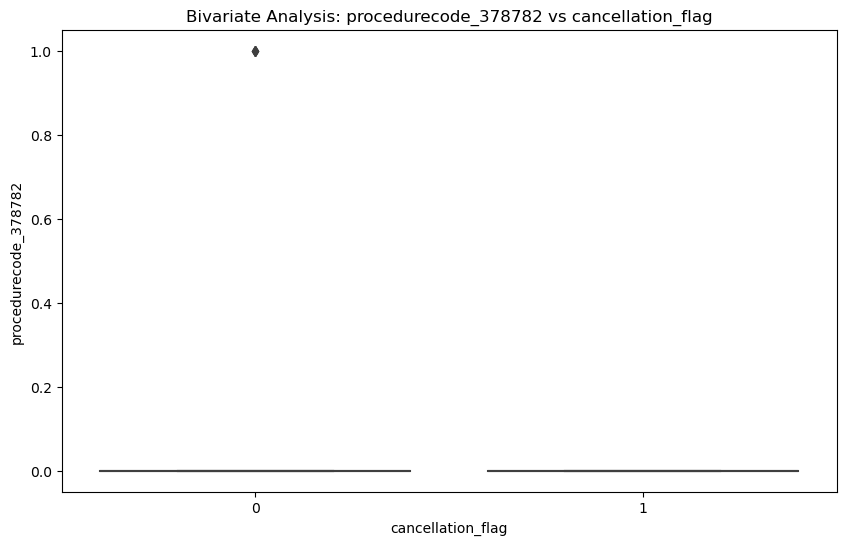


Descriptive Statistics for procedurecode_378782 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000036  0.005972  0.0  0.0  0.0  0.0  1.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



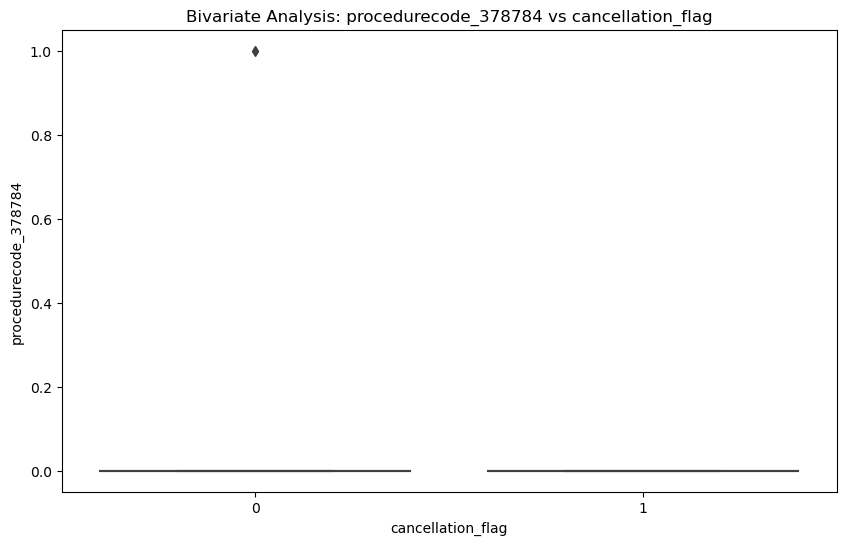


Descriptive Statistics for procedurecode_378784 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000012  0.003448  0.0  0.0  0.0  0.0  1.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



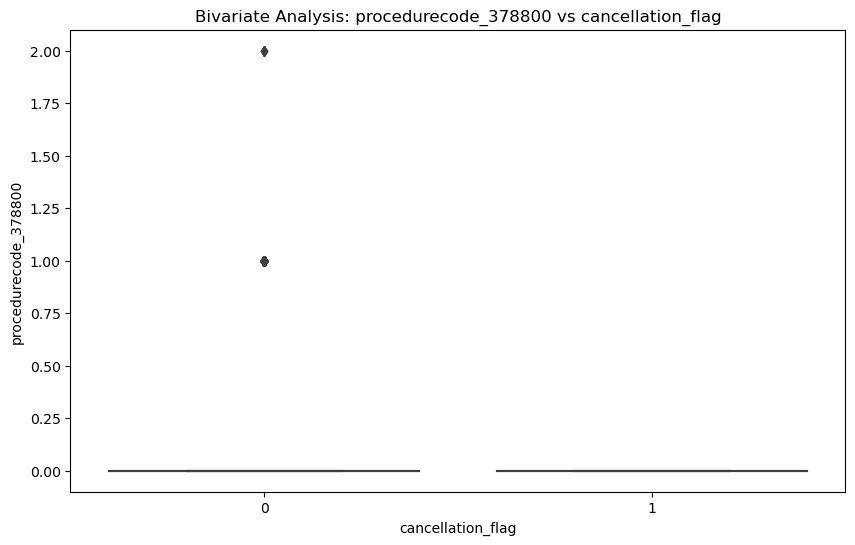


Descriptive Statistics for procedurecode_378800 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.002104  0.046592  0.0  0.0  0.0  0.0  2.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



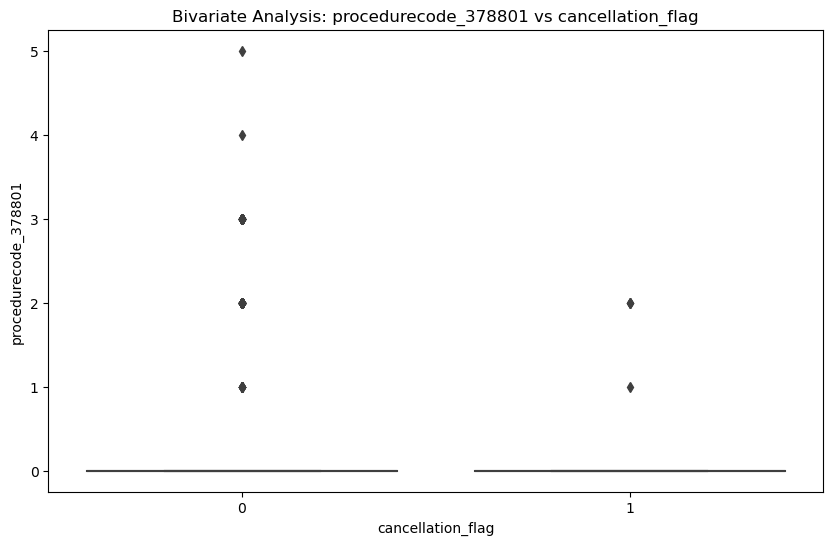


Descriptive Statistics for procedurecode_378801 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.004790  0.108976  0.0  0.0  0.0  0.0  5.0
1                   7263.0  0.000964  0.042299  0.0  0.0  0.0  0.0  2.0

---------------------------------------



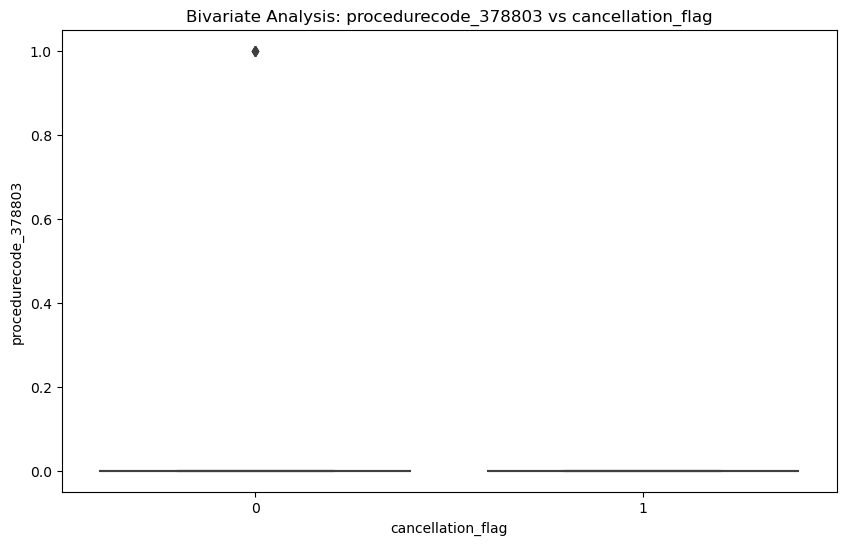


Descriptive Statistics for procedurecode_378803 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000048  0.006895  0.0  0.0  0.0  0.0  1.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



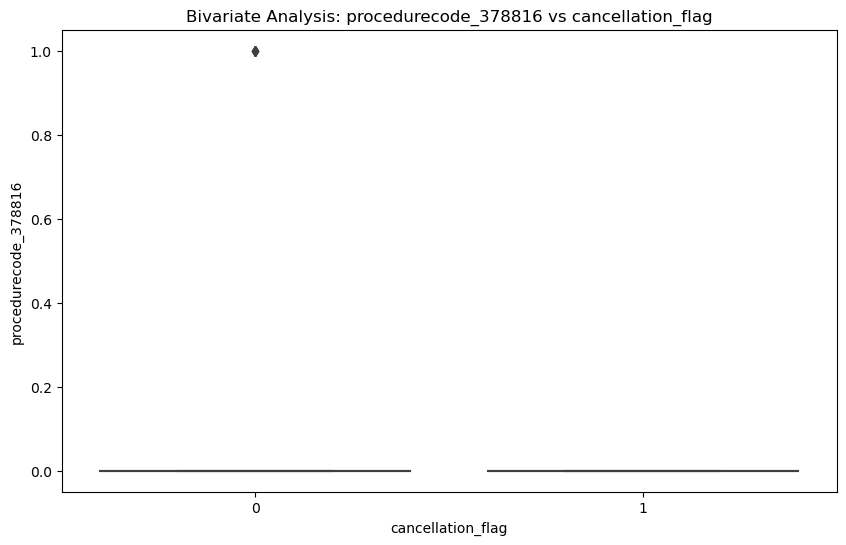


Descriptive Statistics for procedurecode_378816 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000048  0.006895  0.0  0.0  0.0  0.0  1.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



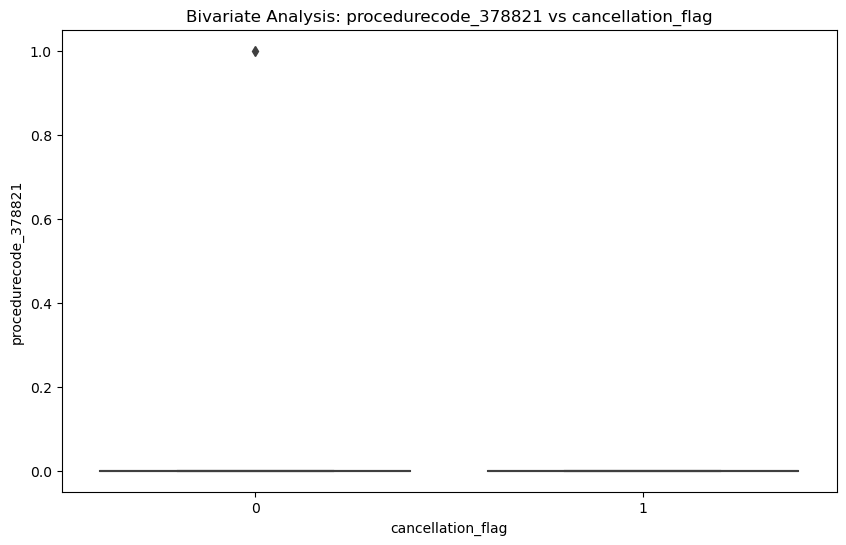


Descriptive Statistics for procedurecode_378821 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000012  0.003448  0.0  0.0  0.0  0.0  1.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



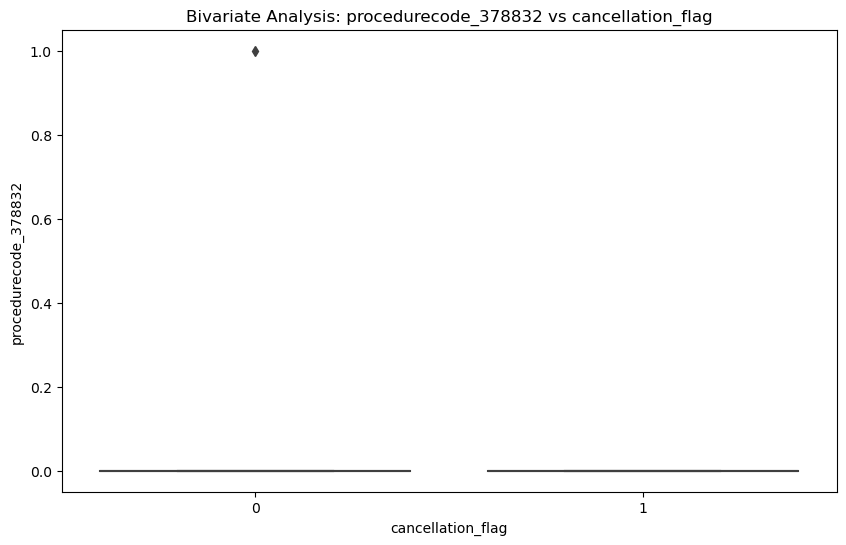


Descriptive Statistics for procedurecode_378832 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000012  0.003448  0.0  0.0  0.0  0.0  1.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



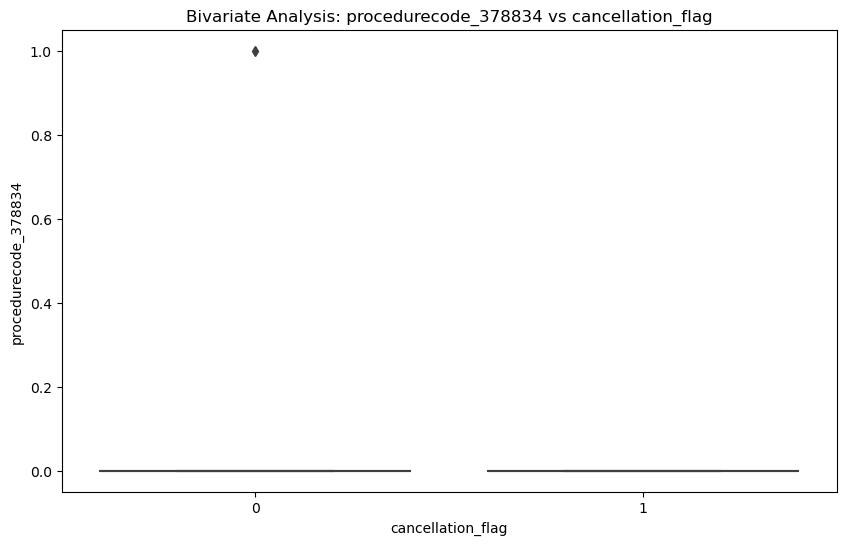


Descriptive Statistics for procedurecode_378834 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000012  0.003448  0.0  0.0  0.0  0.0  1.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



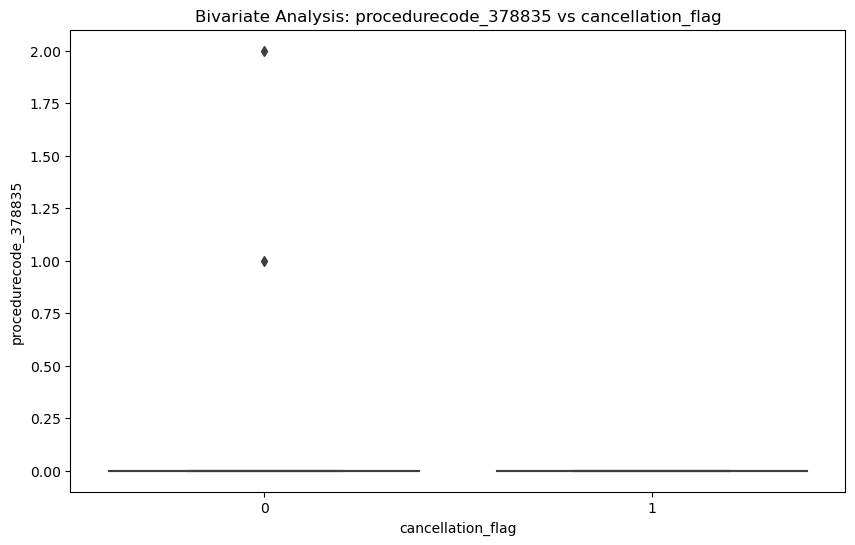


Descriptive Statistics for procedurecode_378835 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000036  0.007709  0.0  0.0  0.0  0.0  2.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



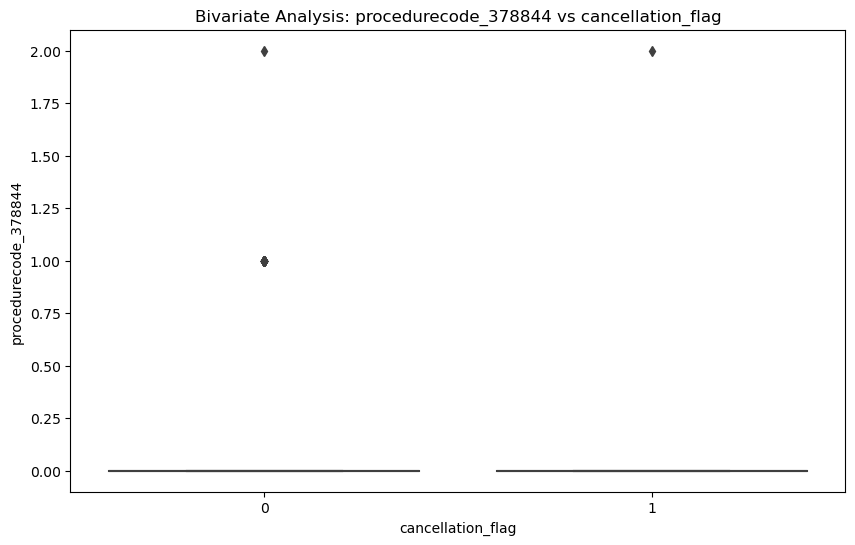


Descriptive Statistics for procedurecode_378844 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000523  0.023378  0.0  0.0  0.0  0.0  2.0
1                   7263.0  0.000275  0.023468  0.0  0.0  0.0  0.0  2.0

---------------------------------------



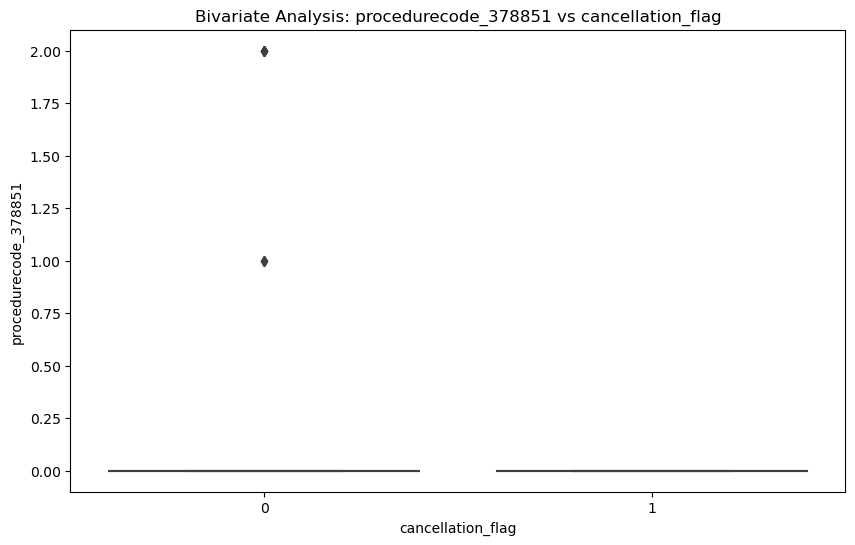


Descriptive Statistics for procedurecode_378851 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000155  0.016534  0.0  0.0  0.0  0.0  2.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



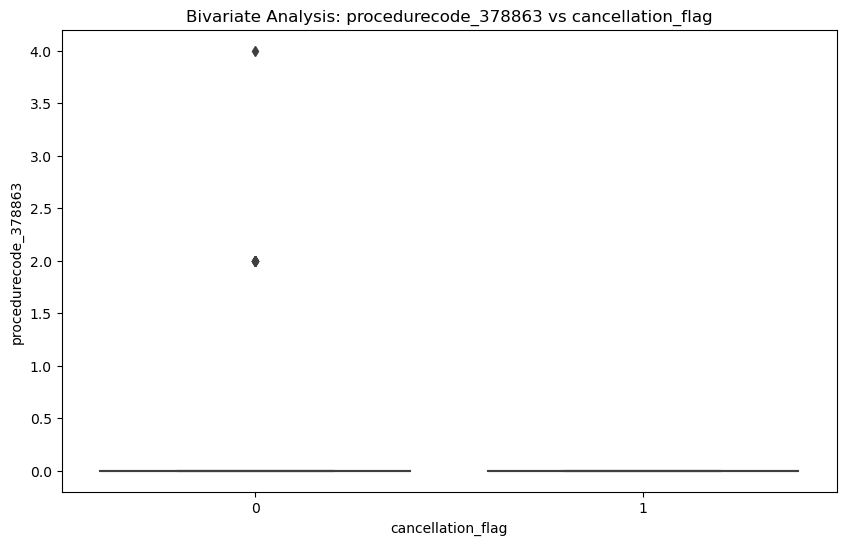


Descriptive Statistics for procedurecode_378863 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000214  0.022869  0.0  0.0  0.0  0.0  4.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



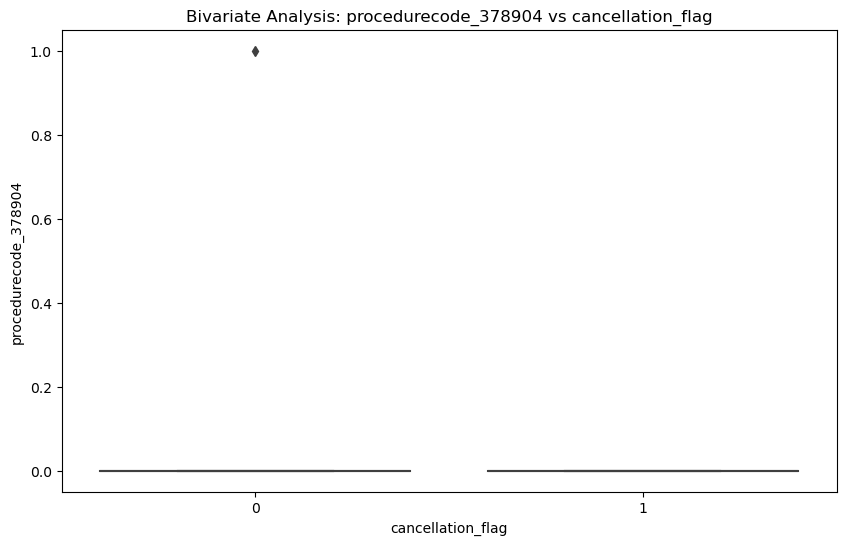


Descriptive Statistics for procedurecode_378904 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000012  0.003448  0.0  0.0  0.0  0.0  1.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



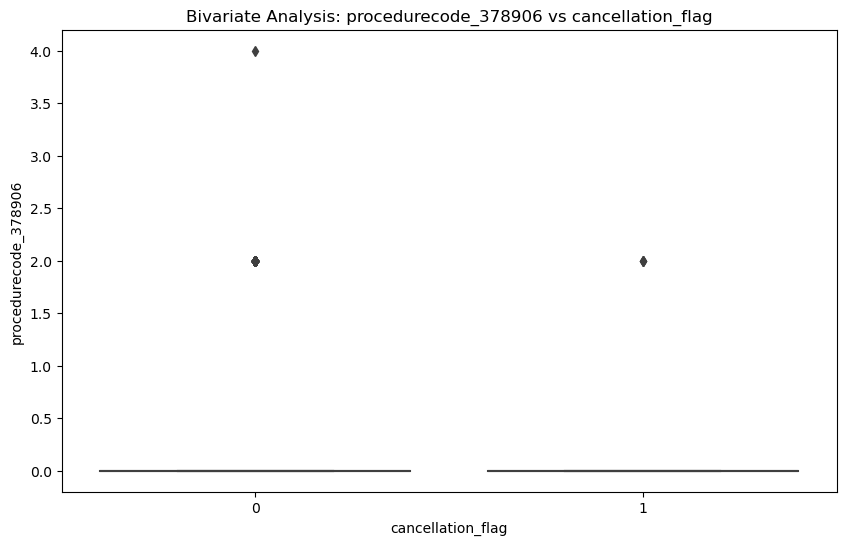


Descriptive Statistics for procedurecode_378906 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.003899  0.088756  0.0  0.0  0.0  0.0  4.0
1                   7263.0  0.000826  0.040642  0.0  0.0  0.0  0.0  2.0

---------------------------------------



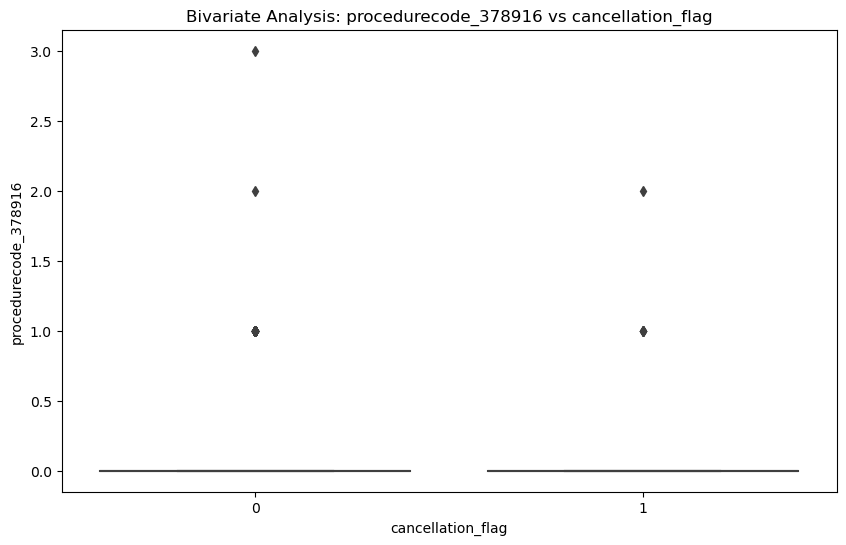


Descriptive Statistics for procedurecode_378916 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000856  0.030825  0.0  0.0  0.0  0.0  3.0
1                   7263.0  0.000964  0.035191  0.0  0.0  0.0  0.0  2.0

---------------------------------------



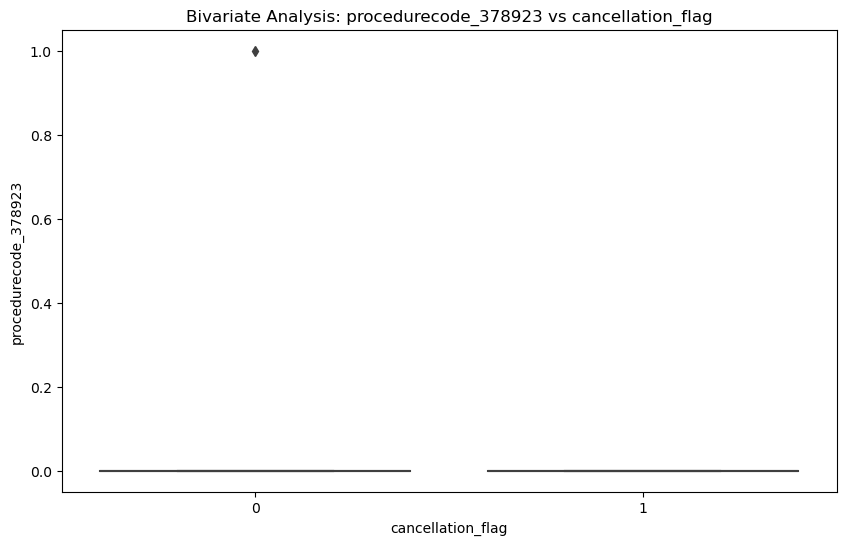


Descriptive Statistics for procedurecode_378923 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000012  0.003448  0.0  0.0  0.0  0.0  1.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



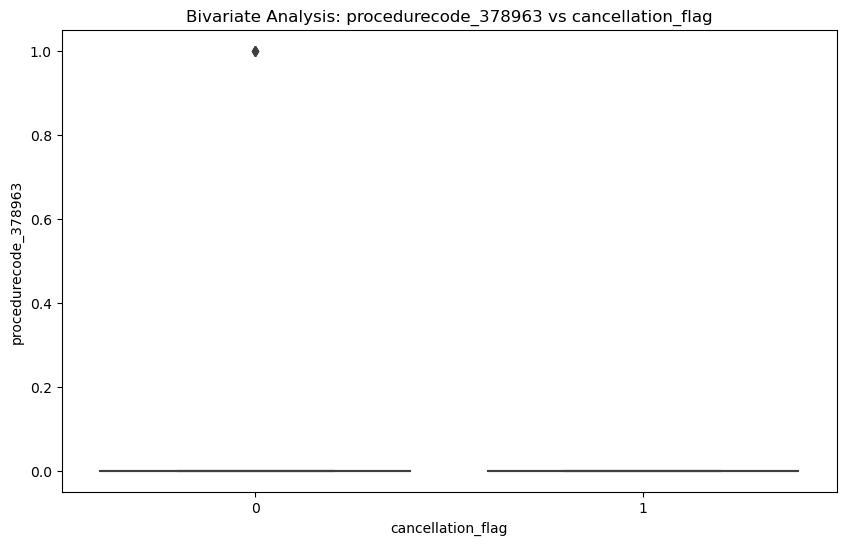


Descriptive Statistics for procedurecode_378963 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000036  0.005972  0.0  0.0  0.0  0.0  1.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



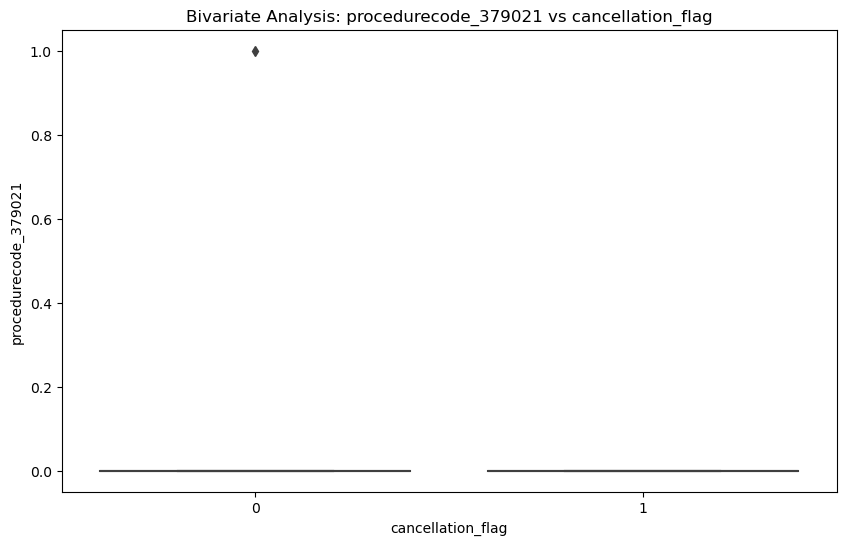


Descriptive Statistics for procedurecode_379021 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000012  0.003448  0.0  0.0  0.0  0.0  1.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



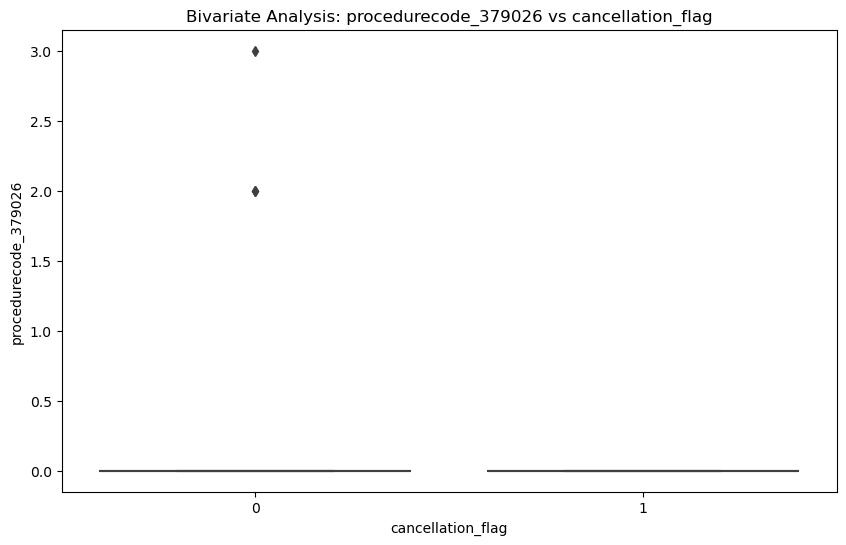


Descriptive Statistics for procedurecode_379026 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000083  0.014215  0.0  0.0  0.0  0.0  3.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



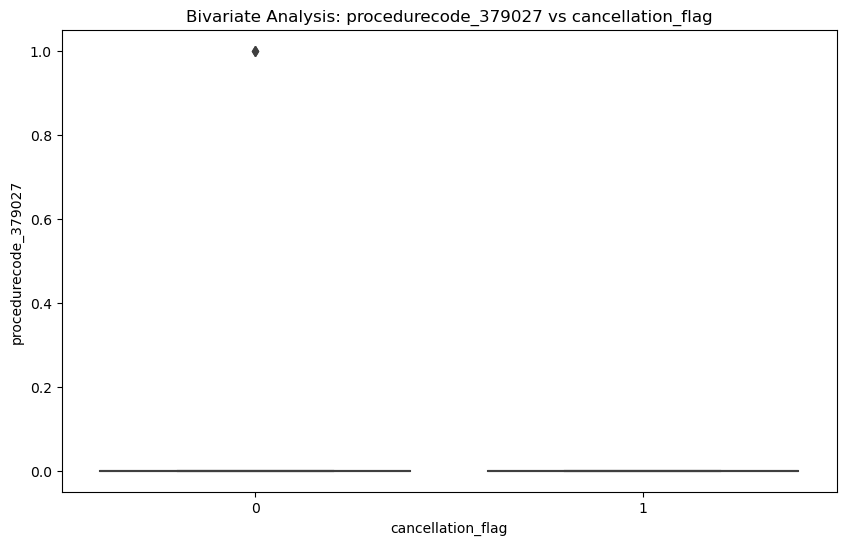


Descriptive Statistics for procedurecode_379027 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000024  0.004876  0.0  0.0  0.0  0.0  1.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



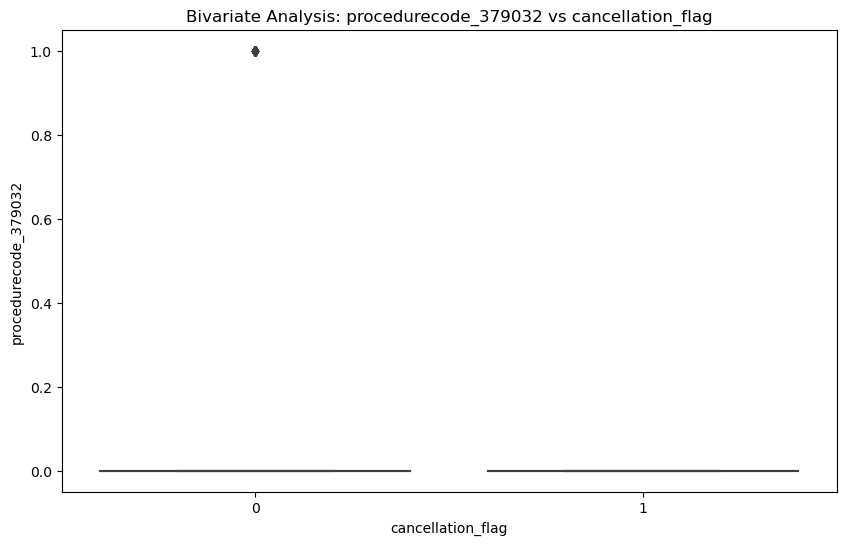


Descriptive Statistics for procedurecode_379032 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000273  0.016532  0.0  0.0  0.0  0.0  1.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



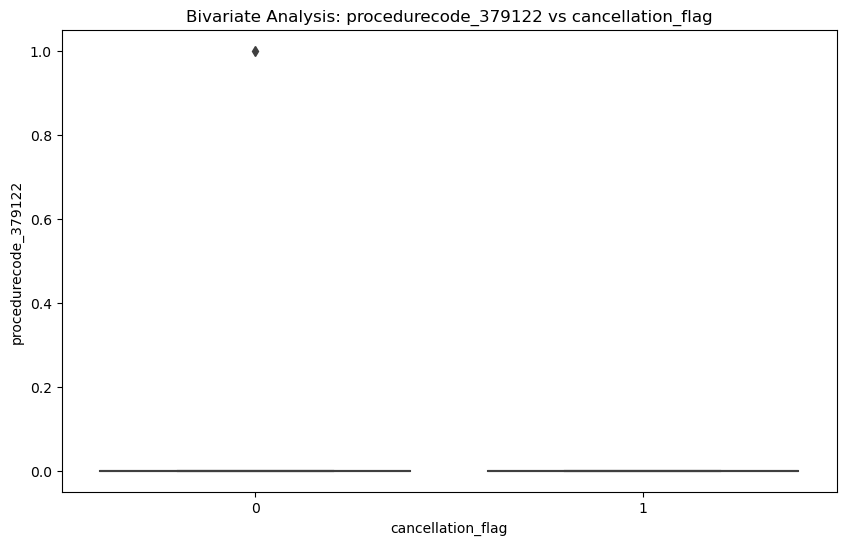


Descriptive Statistics for procedurecode_379122 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000012  0.003448  0.0  0.0  0.0  0.0  1.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



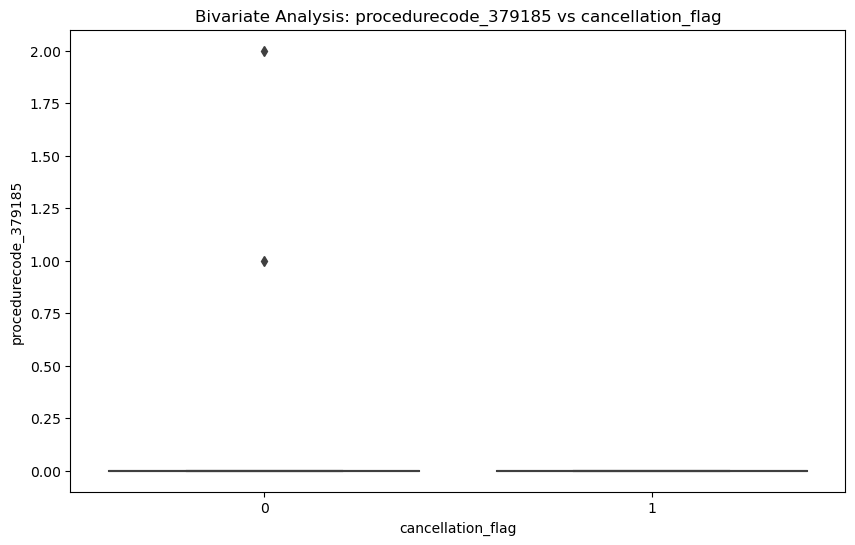


Descriptive Statistics for procedurecode_379185 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000036  0.007709  0.0  0.0  0.0  0.0  2.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



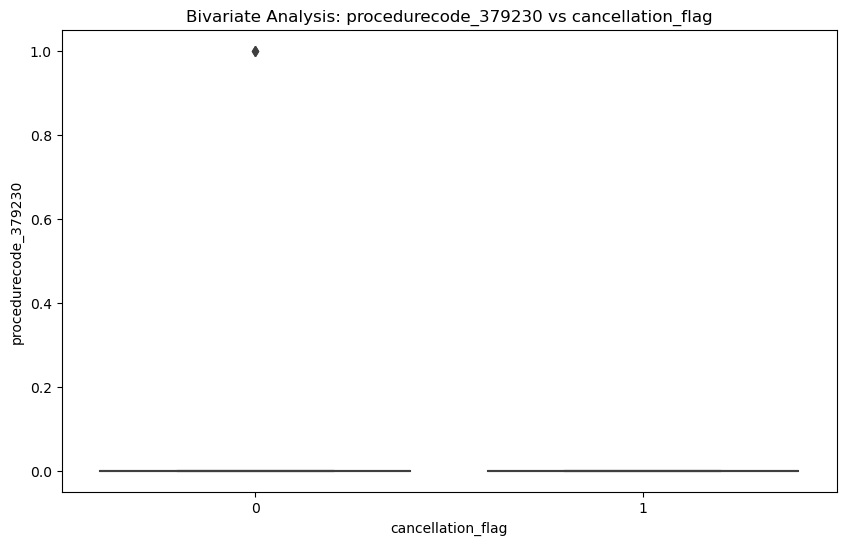


Descriptive Statistics for procedurecode_379230 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000024  0.004876  0.0  0.0  0.0  0.0  1.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



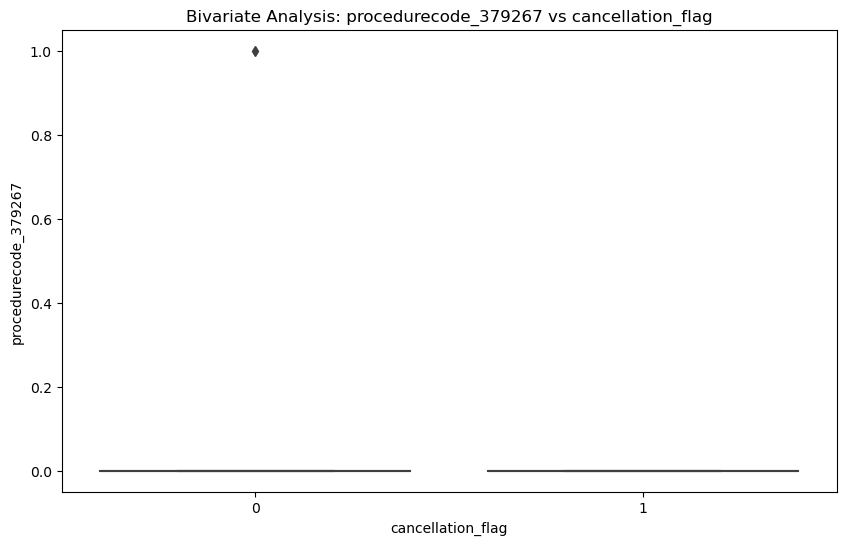


Descriptive Statistics for procedurecode_379267 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000012  0.003448  0.0  0.0  0.0  0.0  1.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



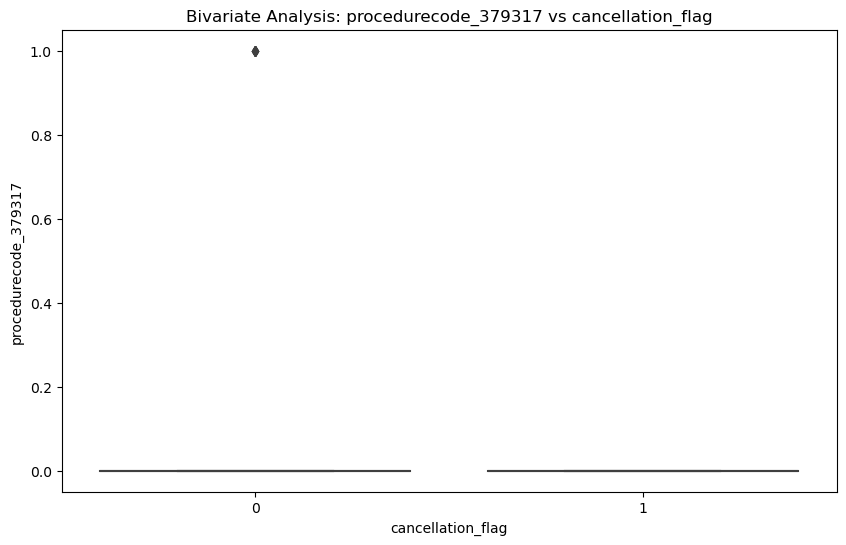


Descriptive Statistics for procedurecode_379317 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000059  0.007709  0.0  0.0  0.0  0.0  1.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



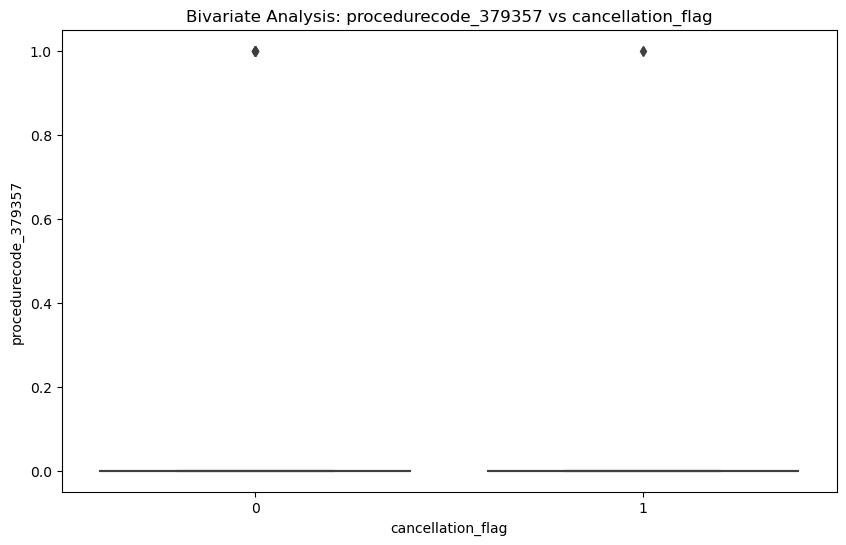


Descriptive Statistics for procedurecode_379357 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000048  0.006895  0.0  0.0  0.0  0.0  1.0
1                   7263.0  0.000138  0.011734  0.0  0.0  0.0  0.0  1.0

---------------------------------------



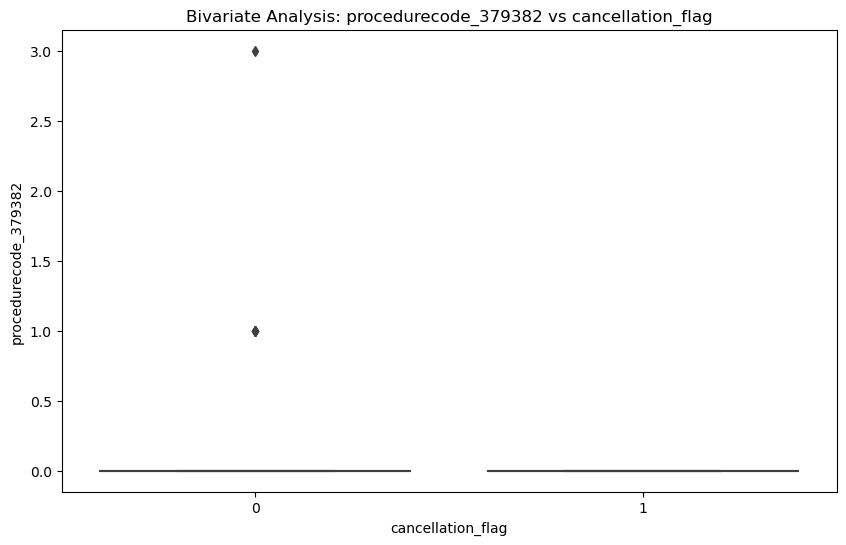


Descriptive Statistics for procedurecode_379382 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000083  0.012431  0.0  0.0  0.0  0.0  3.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



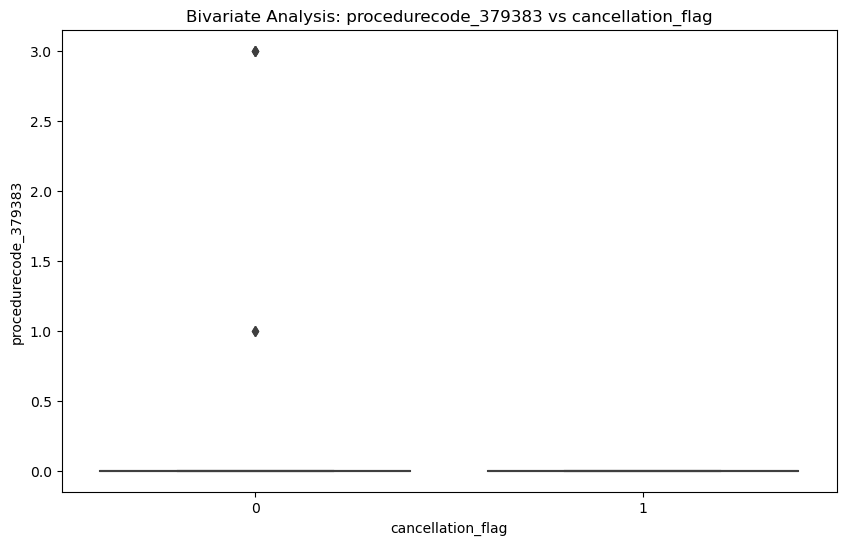


Descriptive Statistics for procedurecode_379383 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000131  0.018566  0.0  0.0  0.0  0.0  3.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



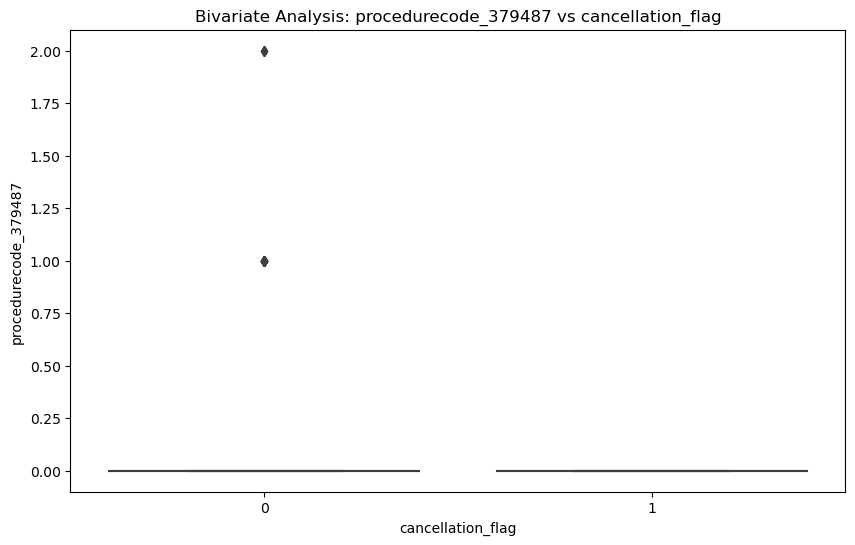


Descriptive Statistics for procedurecode_379487 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000273  0.018565  0.0  0.0  0.0  0.0  2.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



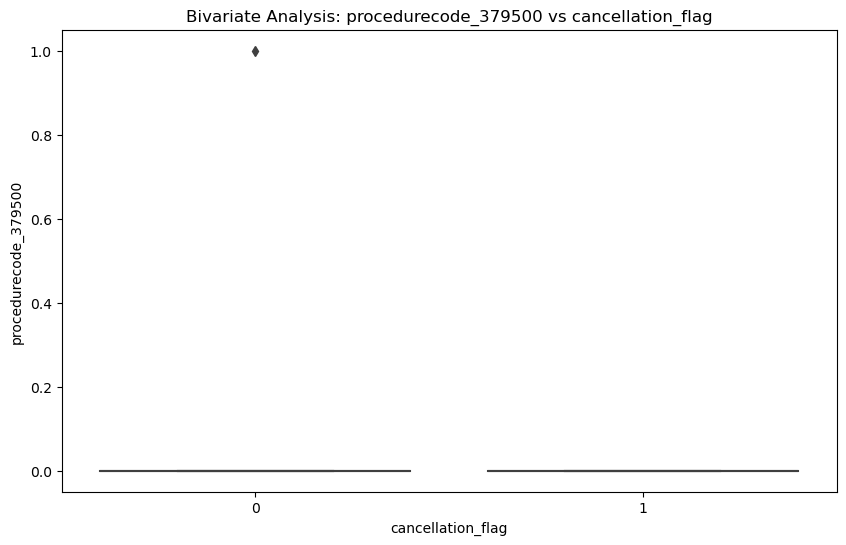


Descriptive Statistics for procedurecode_379500 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000012  0.003448  0.0  0.0  0.0  0.0  1.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



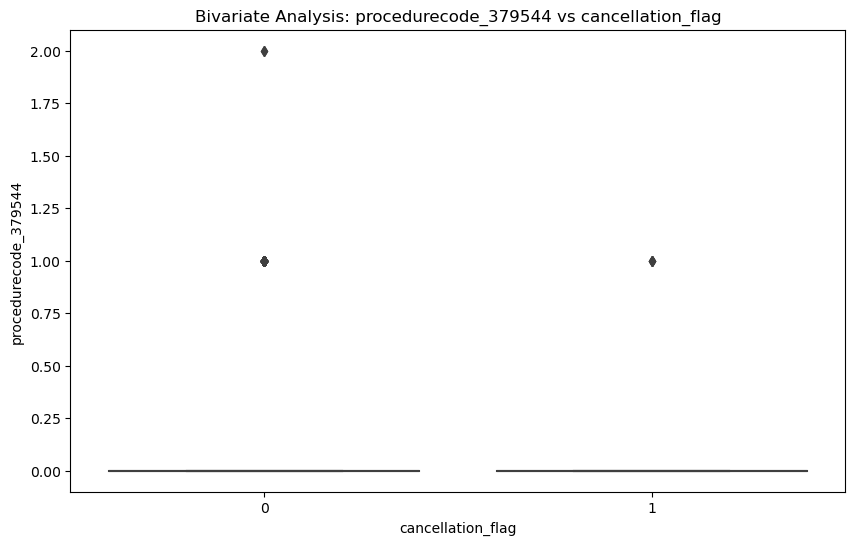


Descriptive Statistics for procedurecode_379544 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.001866  0.043707  0.0  0.0  0.0  0.0  2.0
1                   7263.0  0.000551  0.023463  0.0  0.0  0.0  0.0  1.0

---------------------------------------



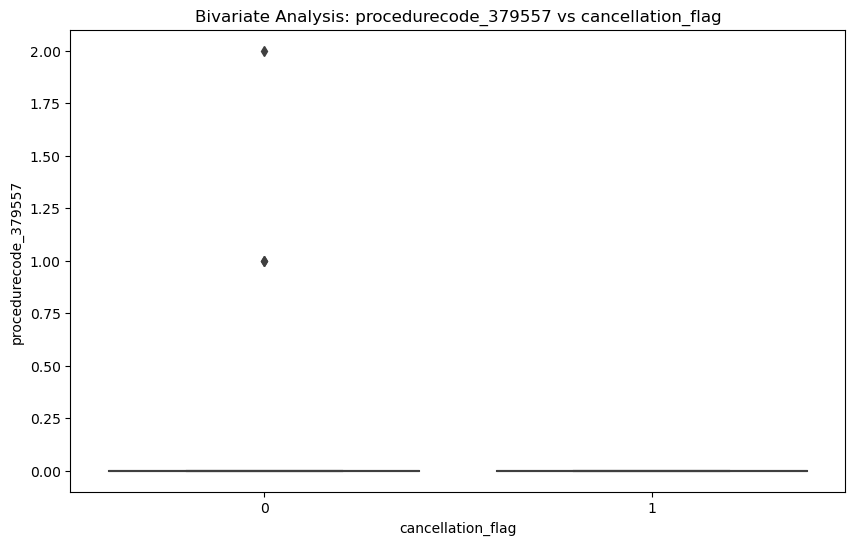


Descriptive Statistics for procedurecode_379557 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000048  0.008445  0.0  0.0  0.0  0.0  2.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



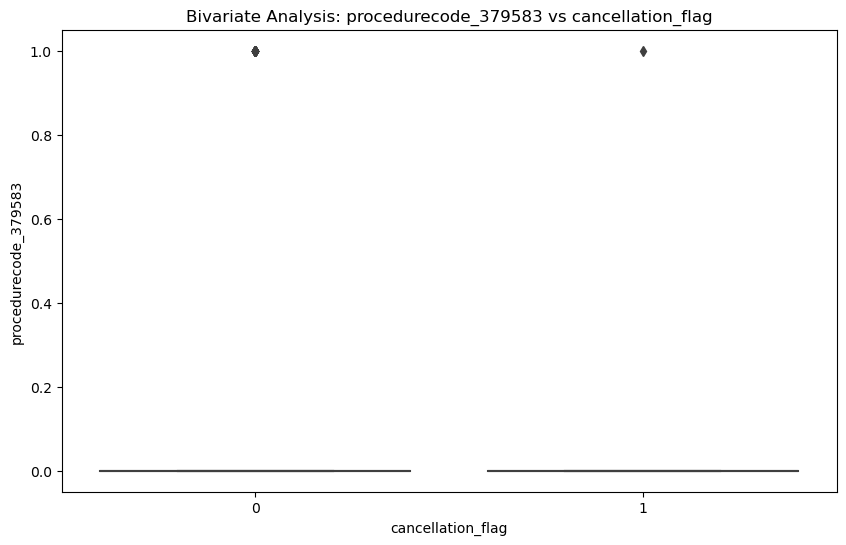


Descriptive Statistics for procedurecode_379583 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000357  0.018881  0.0  0.0  0.0  0.0  1.0
1                   7263.0  0.000138  0.011734  0.0  0.0  0.0  0.0  1.0

---------------------------------------



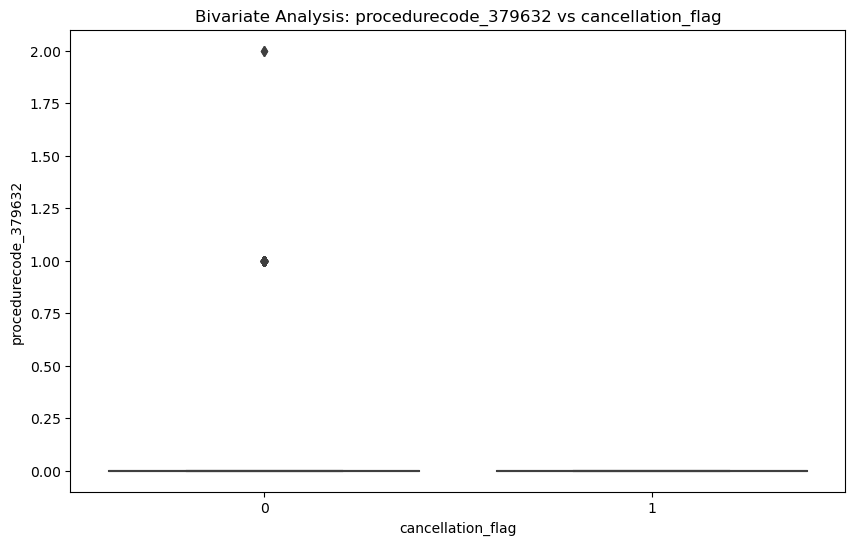


Descriptive Statistics for procedurecode_379632 by cancellation_flag:

                     count     mean       std  min  25%  50%  75%  max
cancellation_flag                                                     
0                  84128.0  0.00151  0.039432  0.0  0.0  0.0  0.0  2.0
1                   7263.0  0.00000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



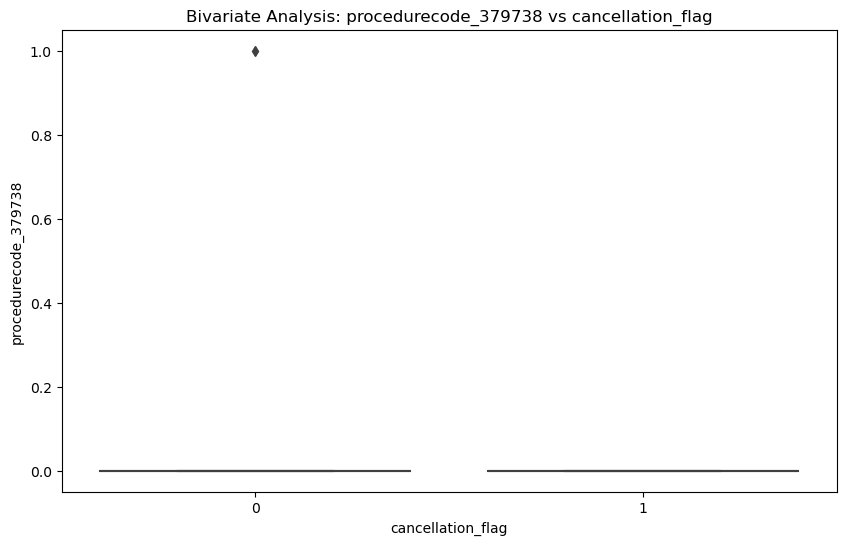


Descriptive Statistics for procedurecode_379738 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000012  0.003448  0.0  0.0  0.0  0.0  1.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



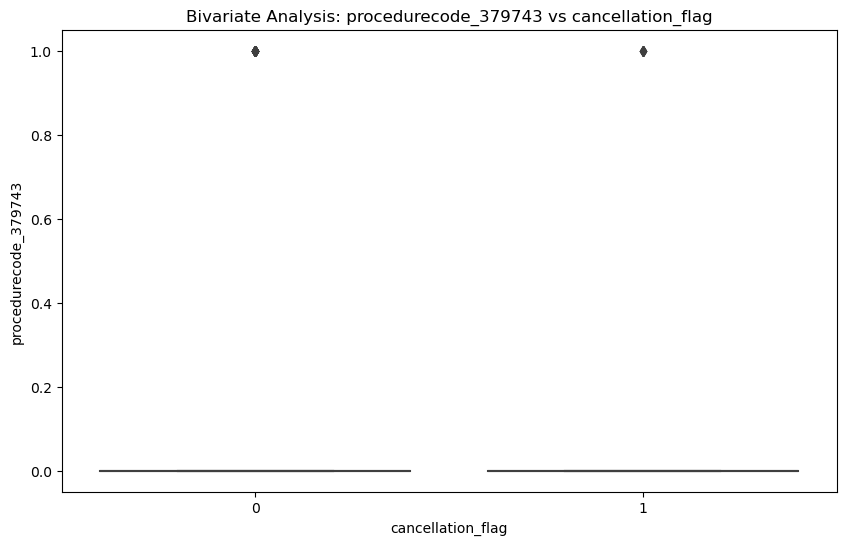


Descriptive Statistics for procedurecode_379743 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000357  0.018881  0.0  0.0  0.0  0.0  1.0
1                   7263.0  0.000688  0.026231  0.0  0.0  0.0  0.0  1.0

---------------------------------------



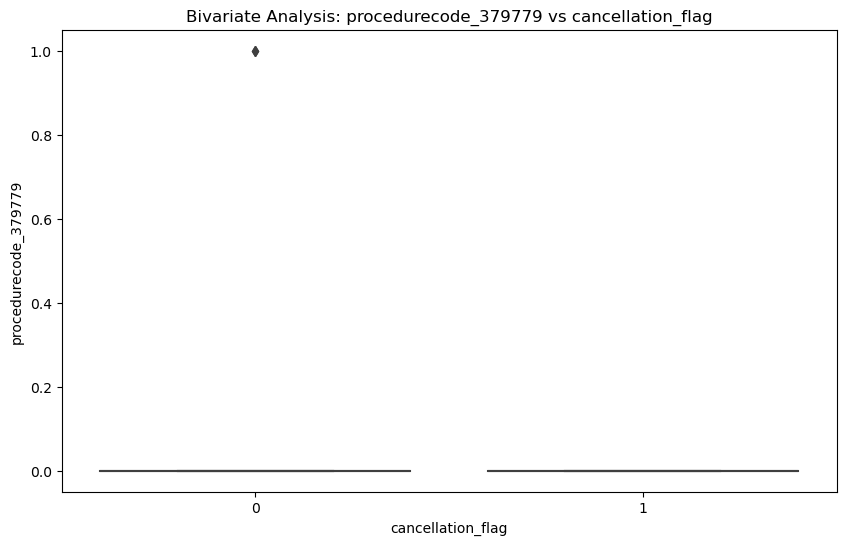


Descriptive Statistics for procedurecode_379779 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000024  0.004876  0.0  0.0  0.0  0.0  1.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



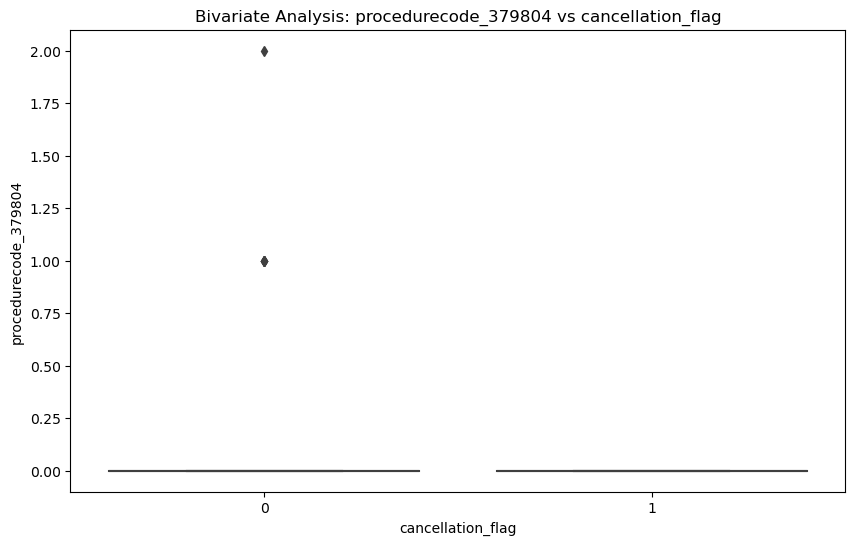


Descriptive Statistics for procedurecode_379804 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000083  0.010343  0.0  0.0  0.0  0.0  2.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



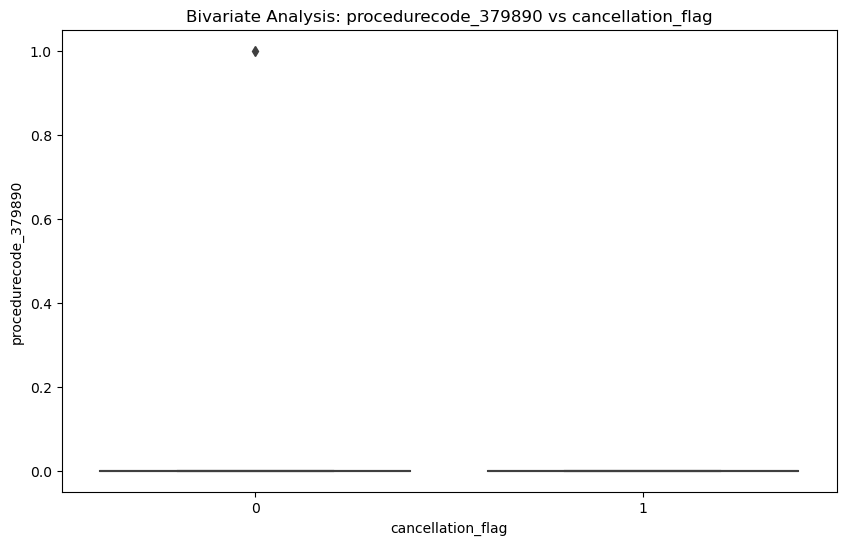


Descriptive Statistics for procedurecode_379890 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000012  0.003448  0.0  0.0  0.0  0.0  1.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



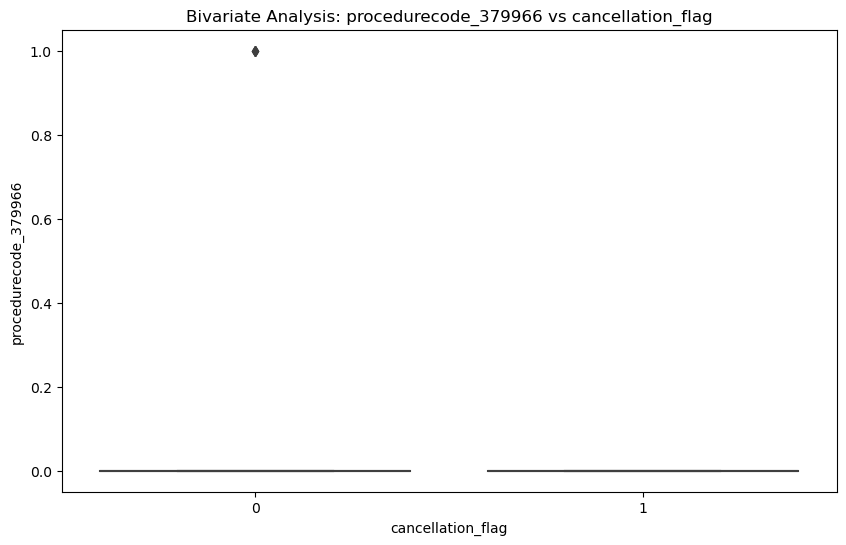


Descriptive Statistics for procedurecode_379966 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000036  0.005972  0.0  0.0  0.0  0.0  1.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



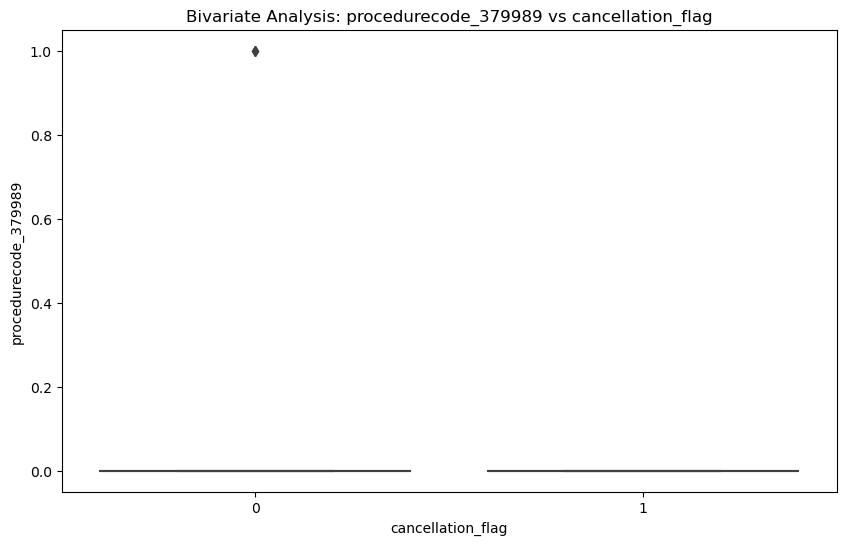


Descriptive Statistics for procedurecode_379989 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000024  0.004876  0.0  0.0  0.0  0.0  1.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



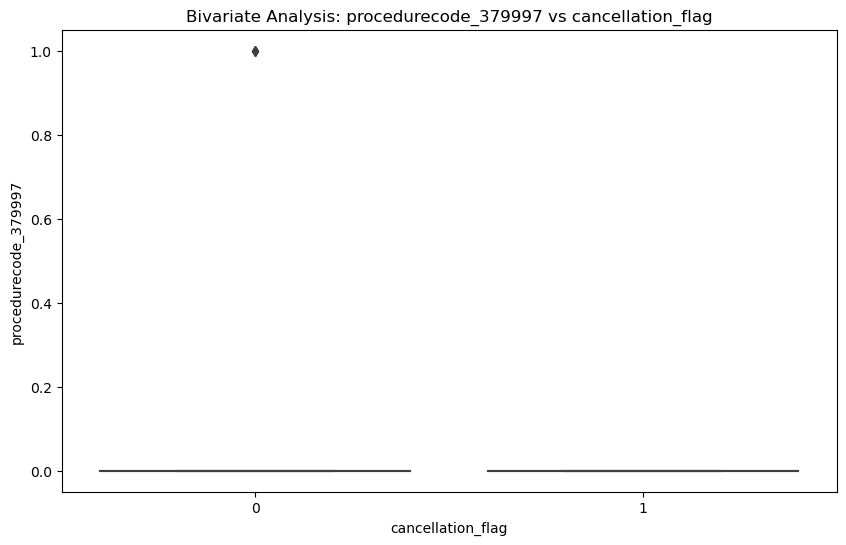


Descriptive Statistics for procedurecode_379997 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000024  0.004876  0.0  0.0  0.0  0.0  1.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



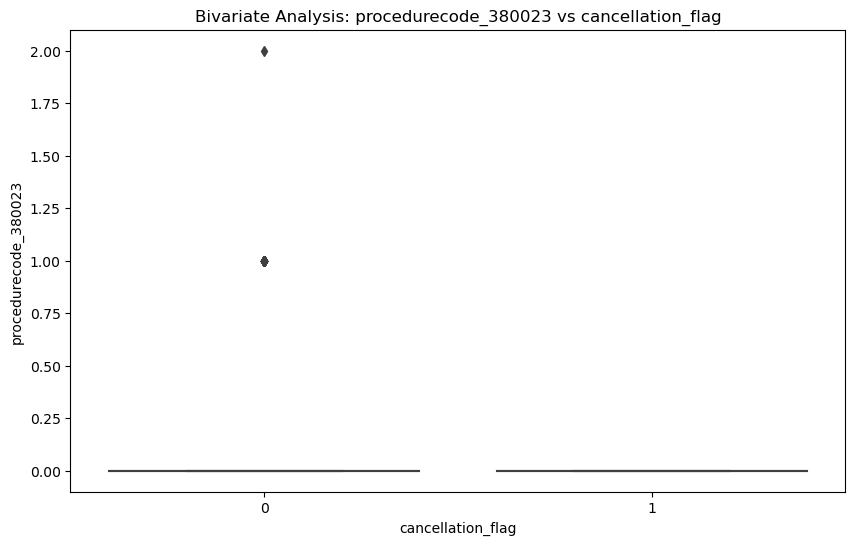


Descriptive Statistics for procedurecode_380023 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000511  0.023122  0.0  0.0  0.0  0.0  2.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



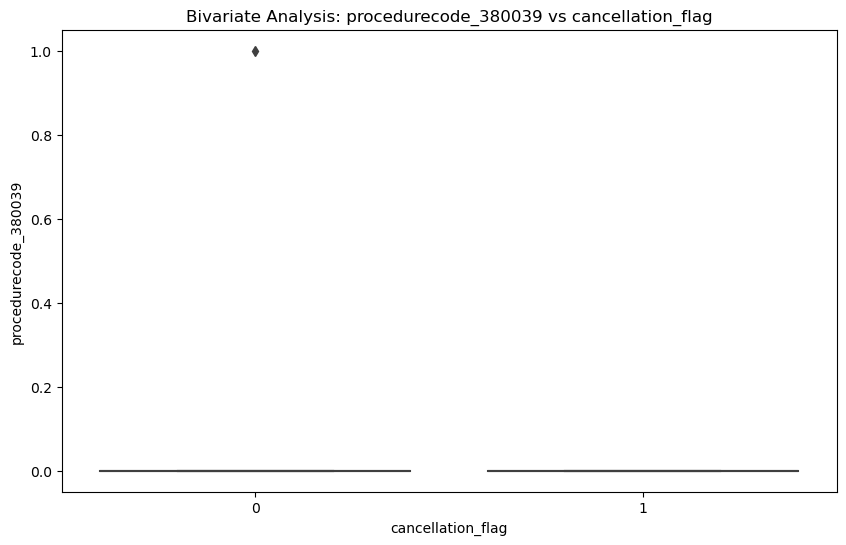


Descriptive Statistics for procedurecode_380039 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000012  0.003448  0.0  0.0  0.0  0.0  1.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



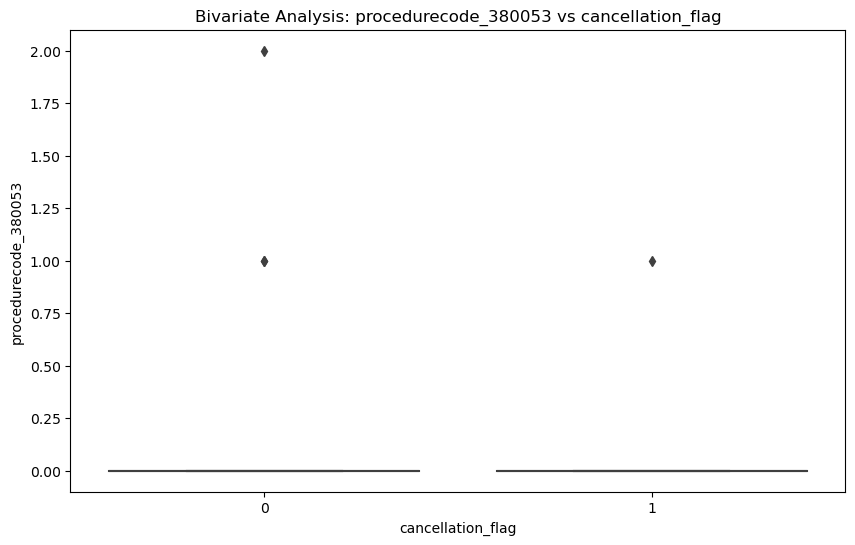


Descriptive Statistics for procedurecode_380053 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000048  0.008445  0.0  0.0  0.0  0.0  2.0
1                   7263.0  0.000138  0.011734  0.0  0.0  0.0  0.0  1.0

---------------------------------------



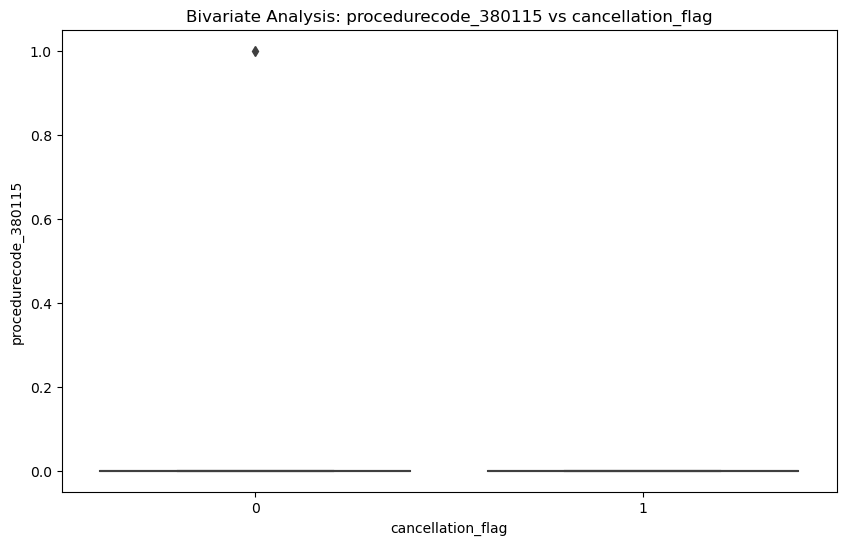


Descriptive Statistics for procedurecode_380115 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000012  0.003448  0.0  0.0  0.0  0.0  1.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



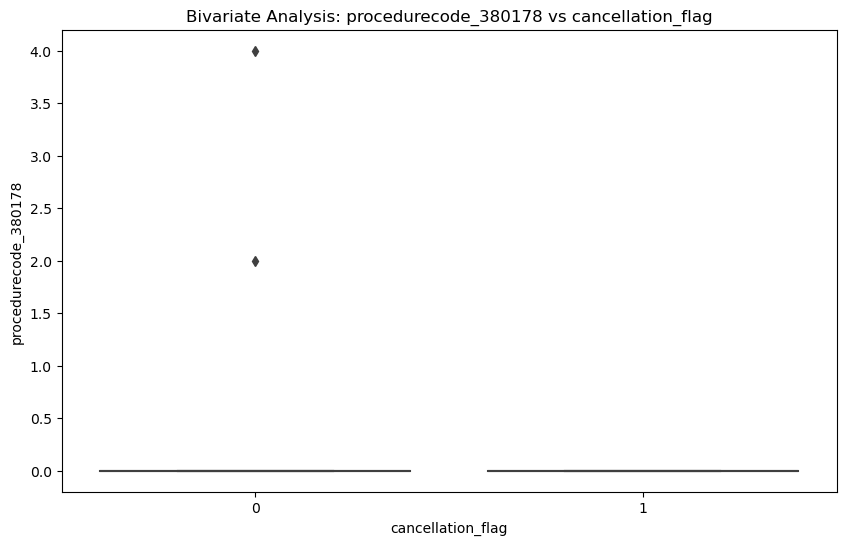


Descriptive Statistics for procedurecode_380178 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000071  0.015419  0.0  0.0  0.0  0.0  4.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



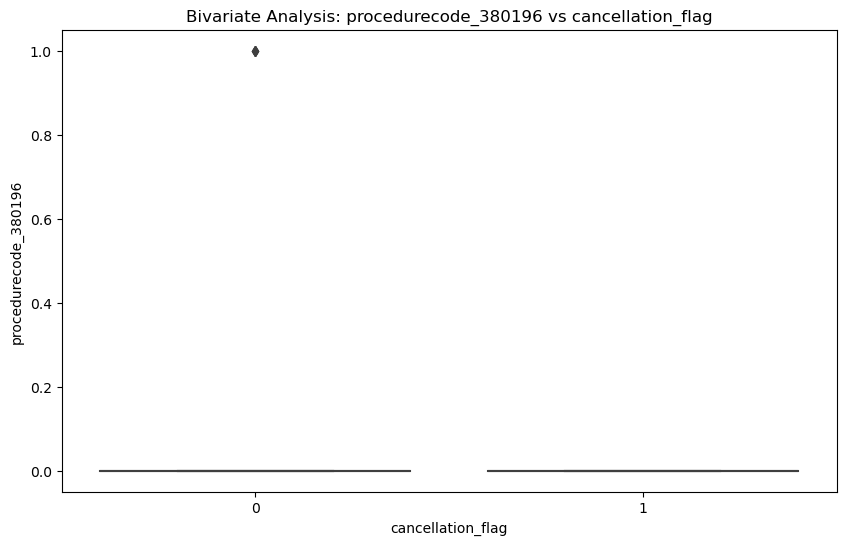


Descriptive Statistics for procedurecode_380196 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000036  0.005972  0.0  0.0  0.0  0.0  1.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



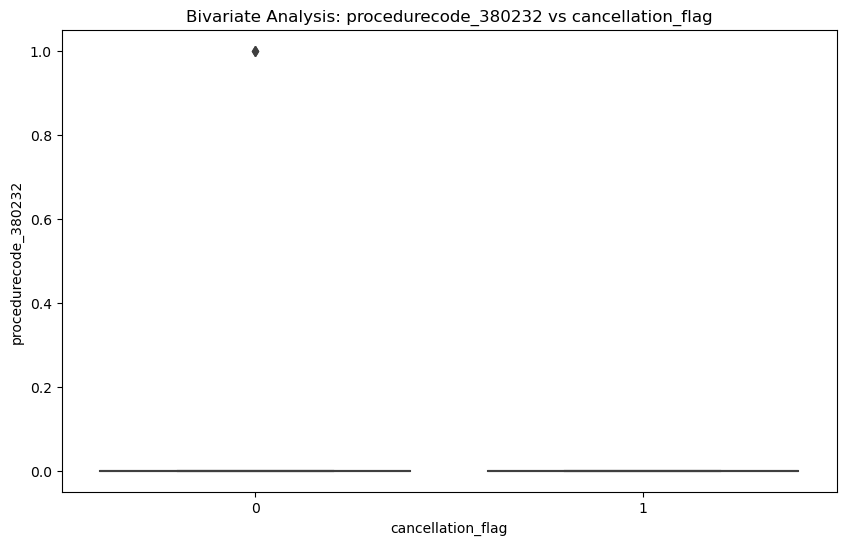


Descriptive Statistics for procedurecode_380232 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000024  0.004876  0.0  0.0  0.0  0.0  1.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



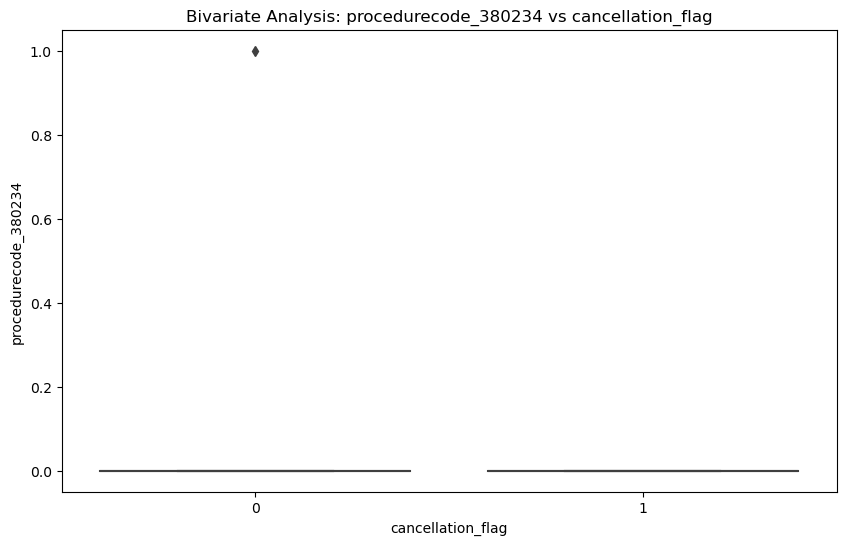


Descriptive Statistics for procedurecode_380234 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000012  0.003448  0.0  0.0  0.0  0.0  1.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



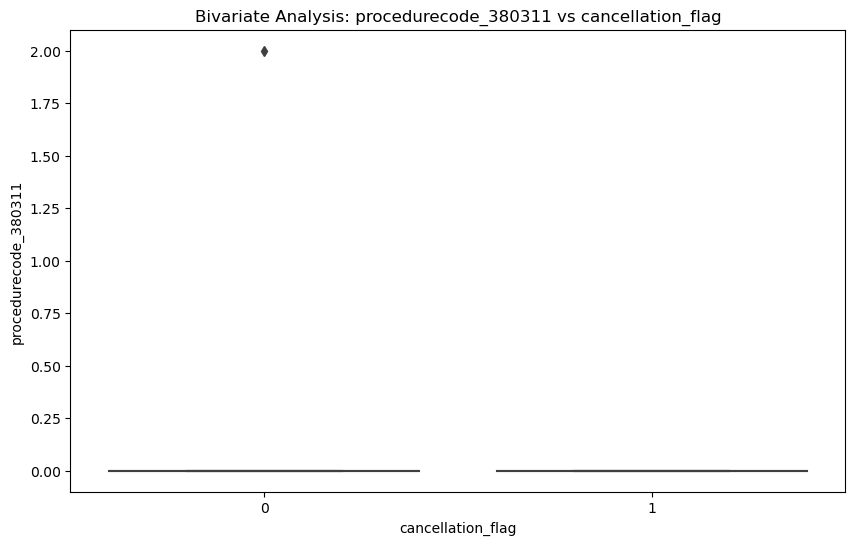


Descriptive Statistics for procedurecode_380311 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000024  0.006895  0.0  0.0  0.0  0.0  2.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



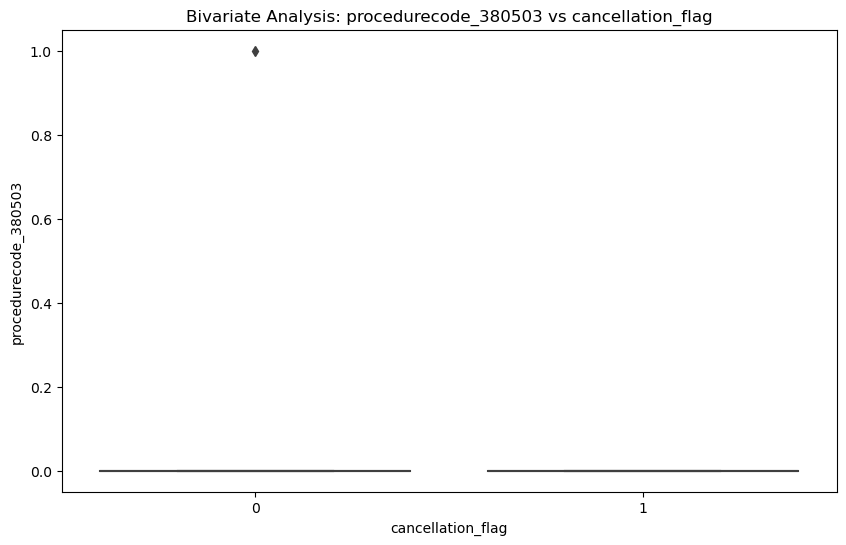


Descriptive Statistics for procedurecode_380503 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000012  0.003448  0.0  0.0  0.0  0.0  1.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



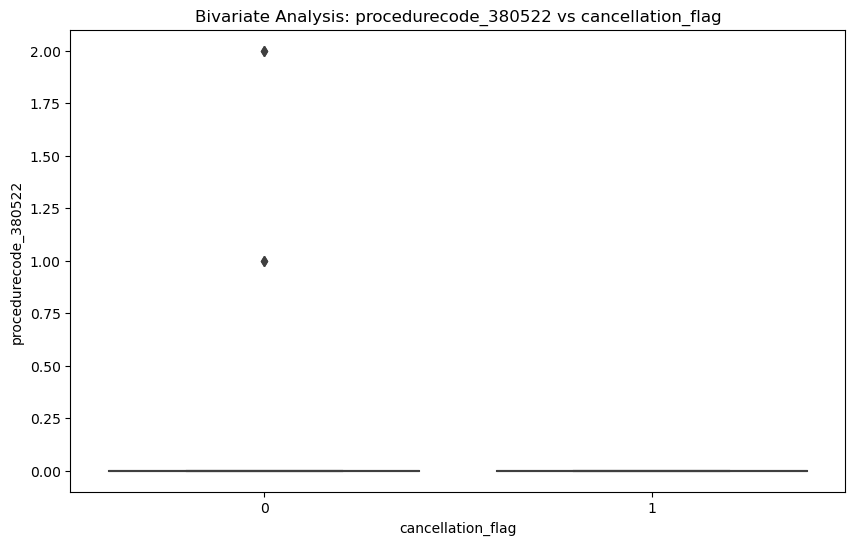


Descriptive Statistics for procedurecode_380522 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000071  0.010902  0.0  0.0  0.0  0.0  2.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



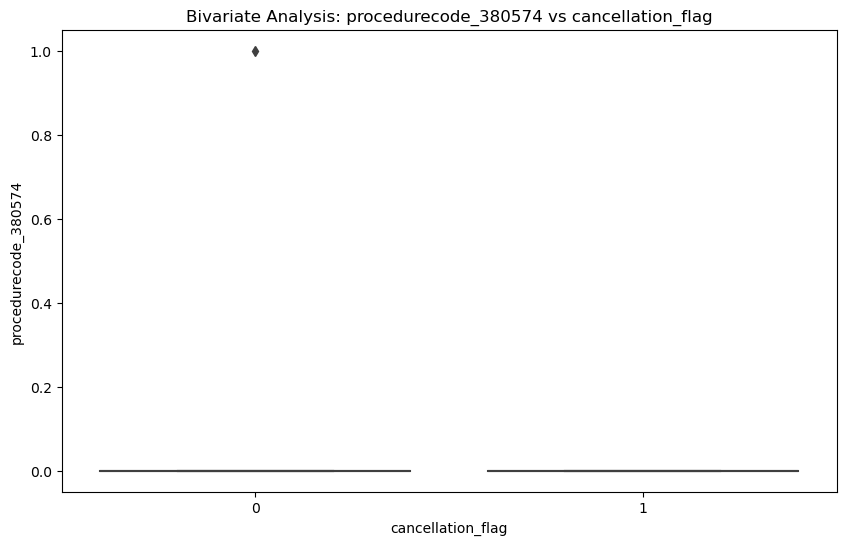


Descriptive Statistics for procedurecode_380574 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000012  0.003448  0.0  0.0  0.0  0.0  1.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



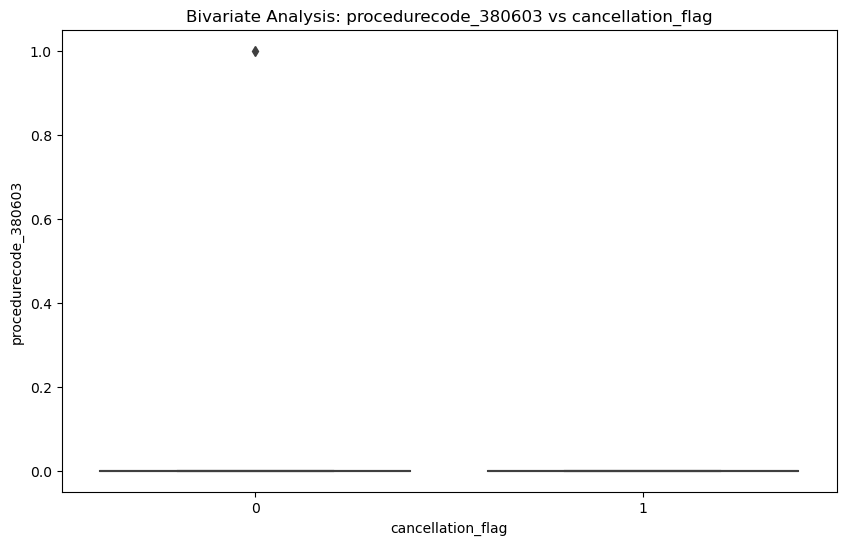


Descriptive Statistics for procedurecode_380603 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000012  0.003448  0.0  0.0  0.0  0.0  1.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



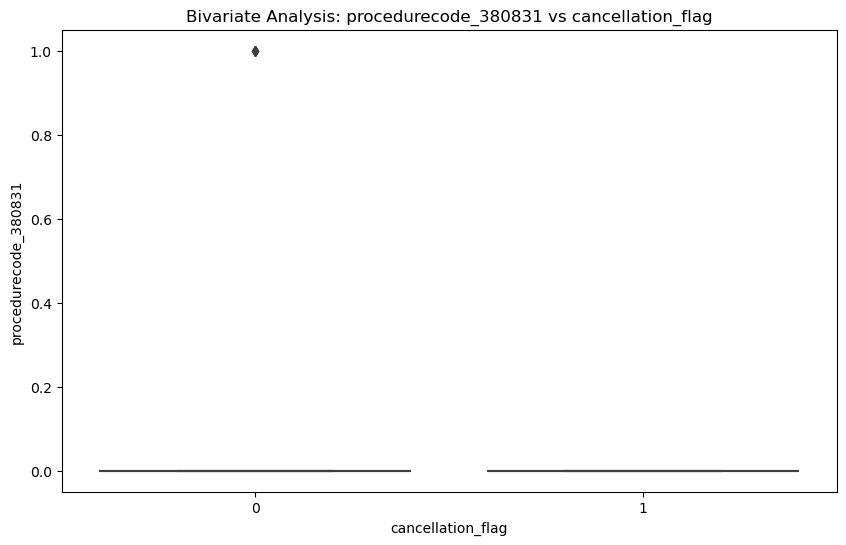


Descriptive Statistics for procedurecode_380831 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000036  0.005972  0.0  0.0  0.0  0.0  1.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



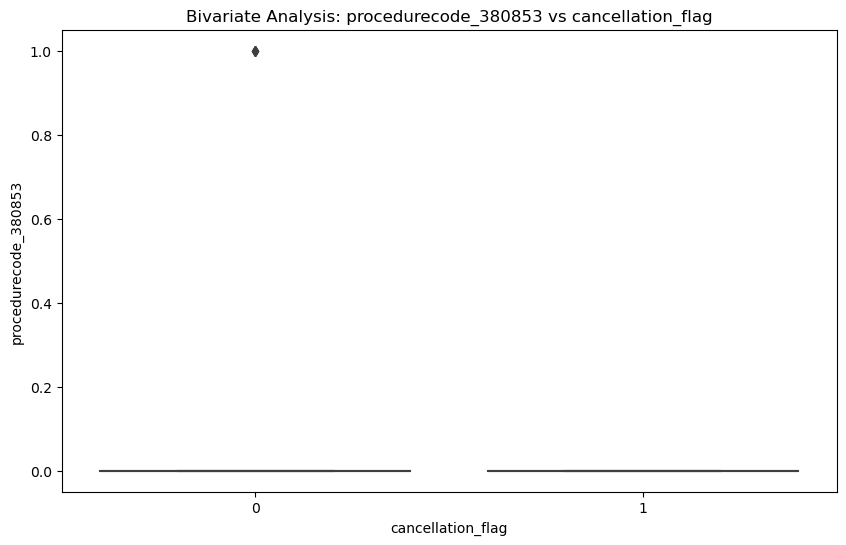


Descriptive Statistics for procedurecode_380853 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000036  0.005972  0.0  0.0  0.0  0.0  1.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



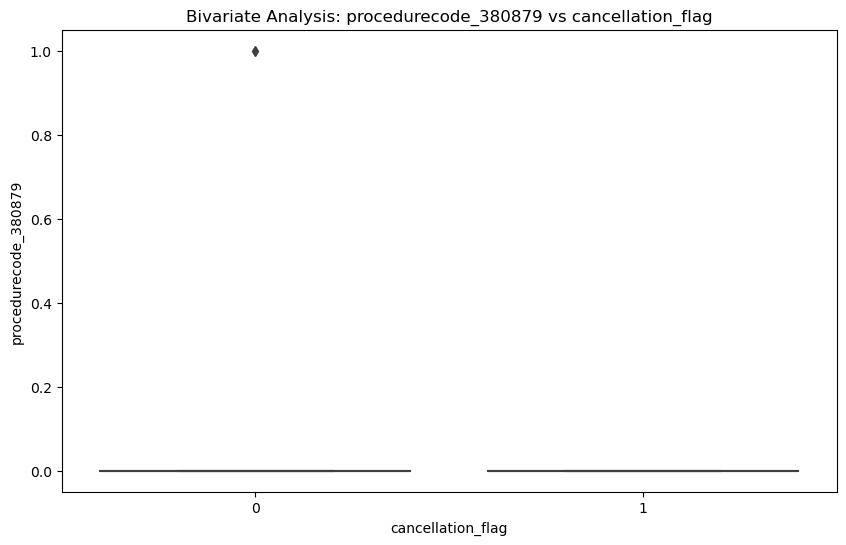


Descriptive Statistics for procedurecode_380879 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000012  0.003448  0.0  0.0  0.0  0.0  1.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



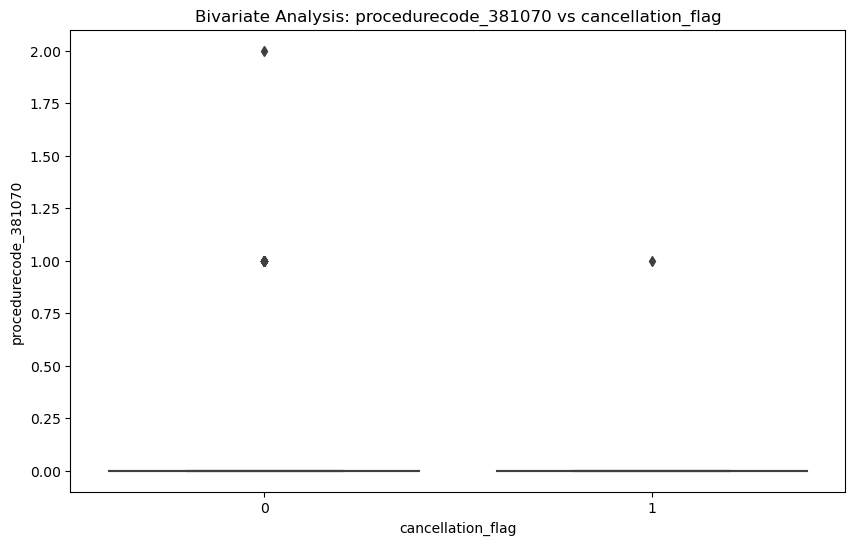


Descriptive Statistics for procedurecode_381070 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000190  0.014626  0.0  0.0  0.0  0.0  2.0
1                   7263.0  0.000138  0.011734  0.0  0.0  0.0  0.0  1.0

---------------------------------------



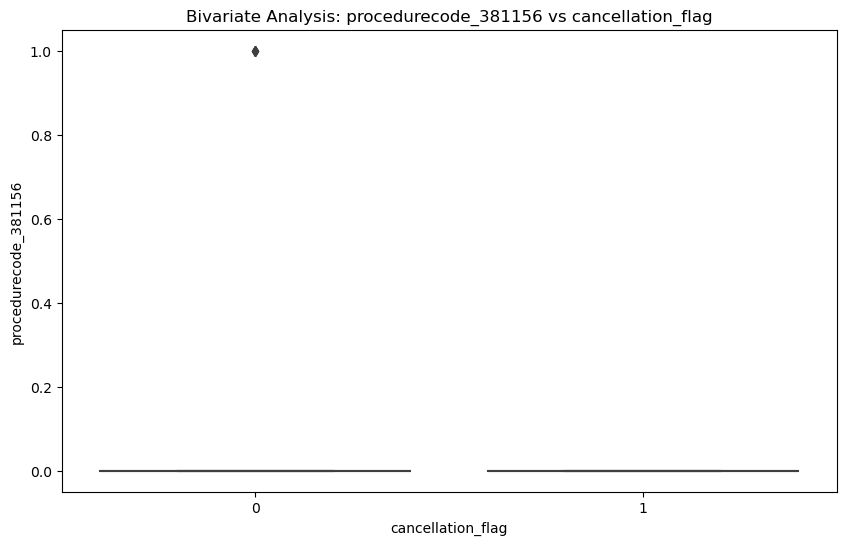


Descriptive Statistics for procedurecode_381156 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000036  0.005972  0.0  0.0  0.0  0.0  1.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



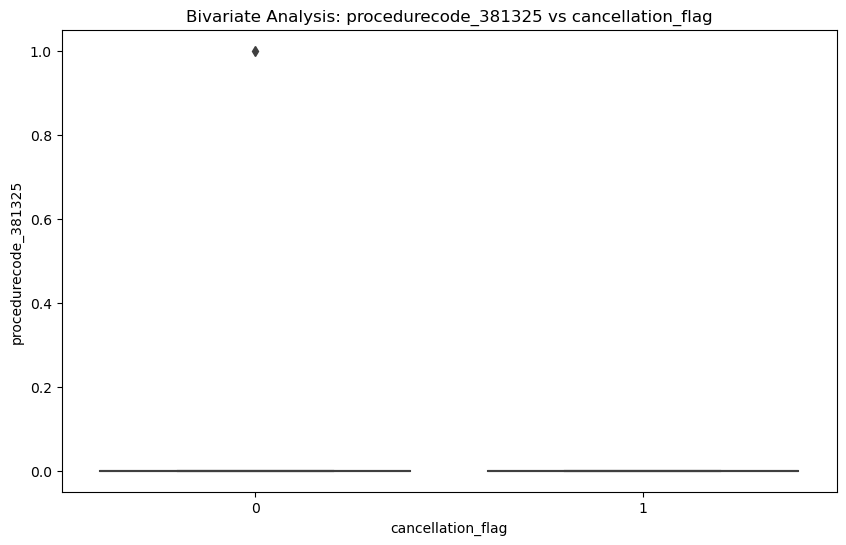


Descriptive Statistics for procedurecode_381325 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000012  0.003448  0.0  0.0  0.0  0.0  1.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



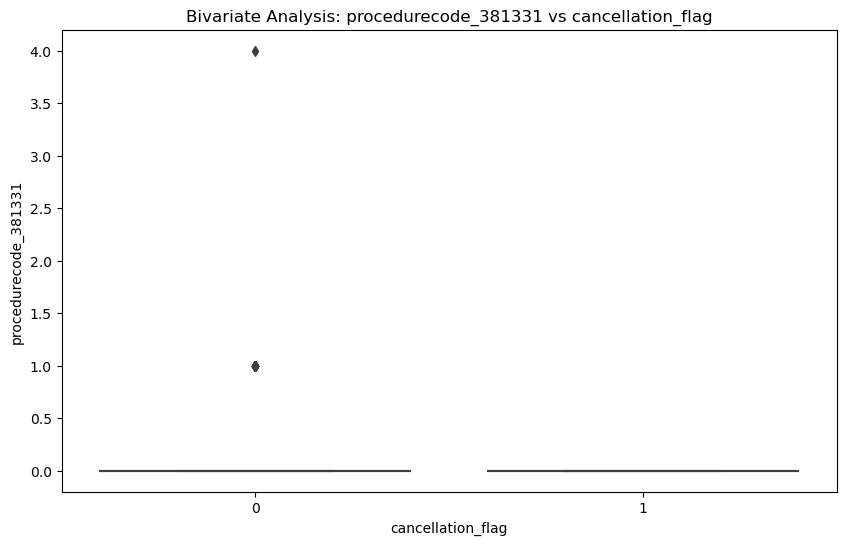


Descriptive Statistics for procedurecode_381331 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000321  0.021529  0.0  0.0  0.0  0.0  4.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



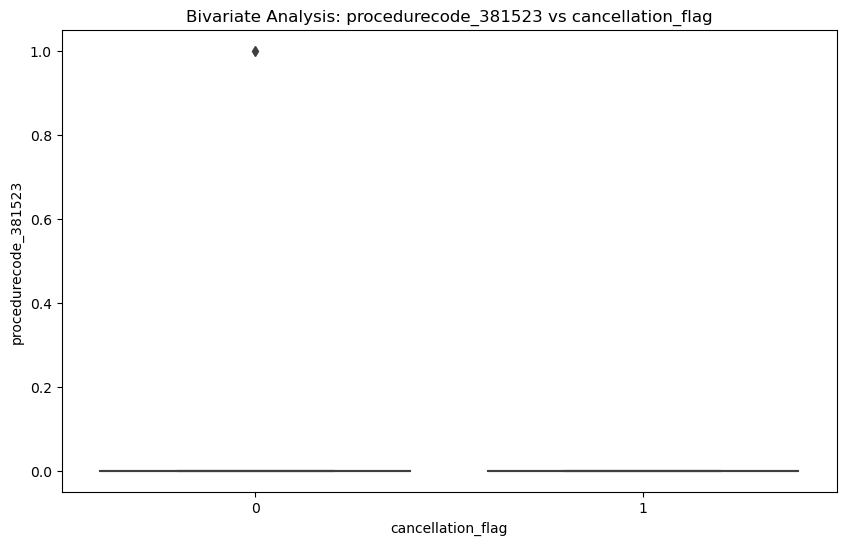


Descriptive Statistics for procedurecode_381523 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000012  0.003448  0.0  0.0  0.0  0.0  1.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



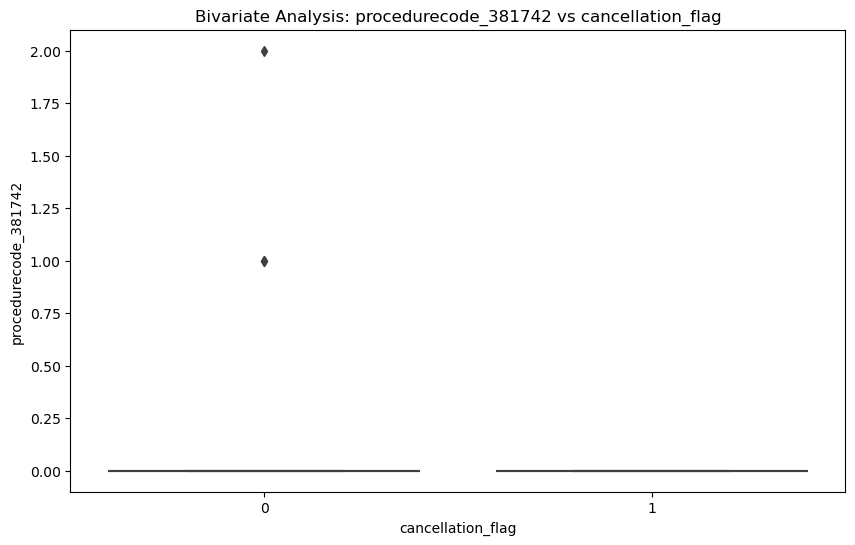


Descriptive Statistics for procedurecode_381742 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000048  0.008445  0.0  0.0  0.0  0.0  2.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



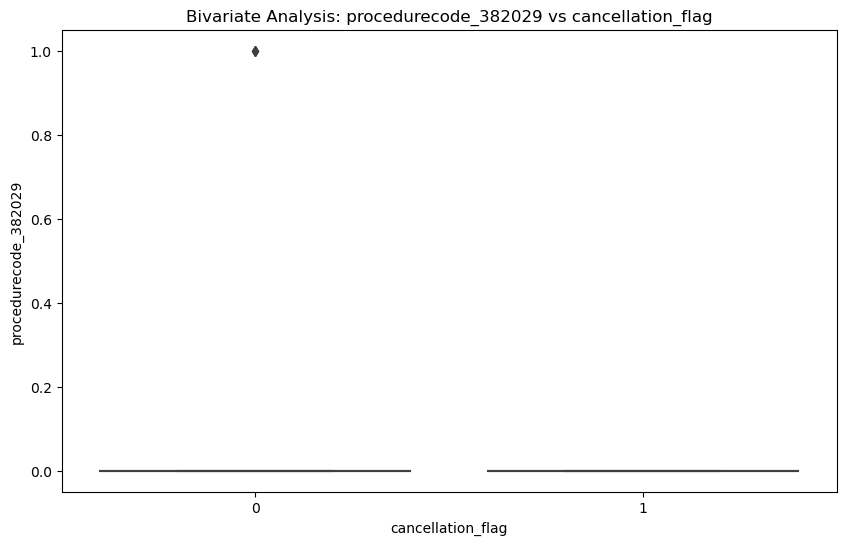


Descriptive Statistics for procedurecode_382029 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000024  0.004876  0.0  0.0  0.0  0.0  1.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



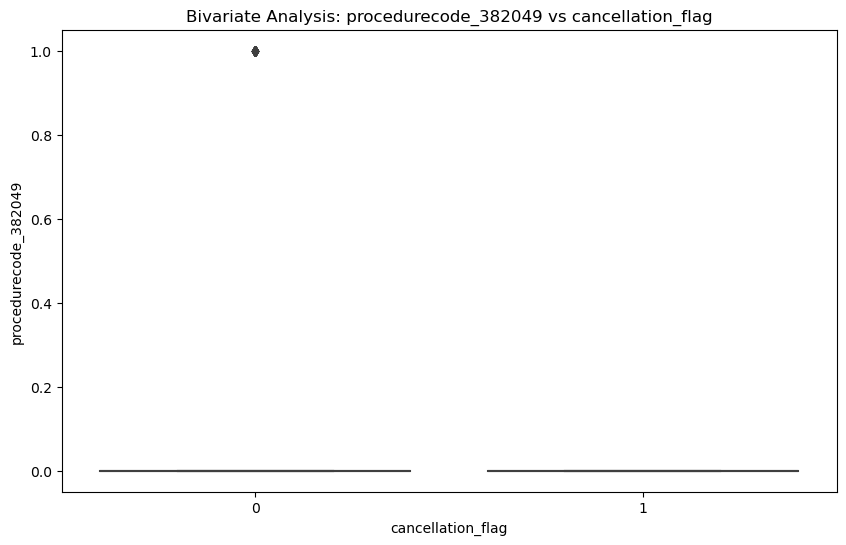


Descriptive Statistics for procedurecode_382049 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000404  0.020099  0.0  0.0  0.0  0.0  1.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



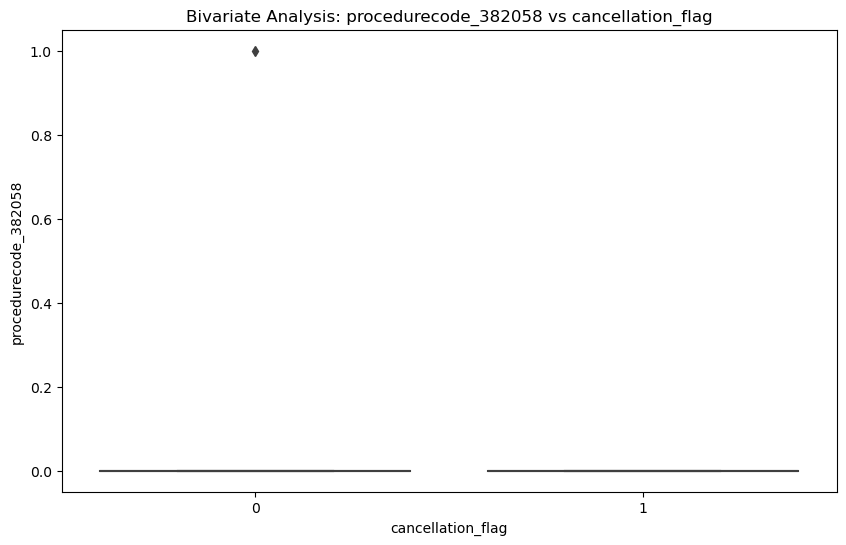


Descriptive Statistics for procedurecode_382058 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000012  0.003448  0.0  0.0  0.0  0.0  1.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



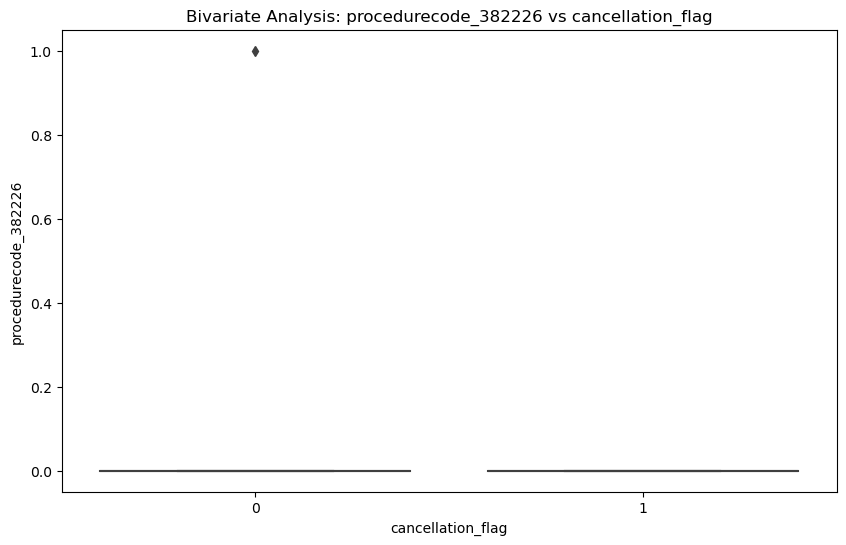


Descriptive Statistics for procedurecode_382226 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000012  0.003448  0.0  0.0  0.0  0.0  1.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



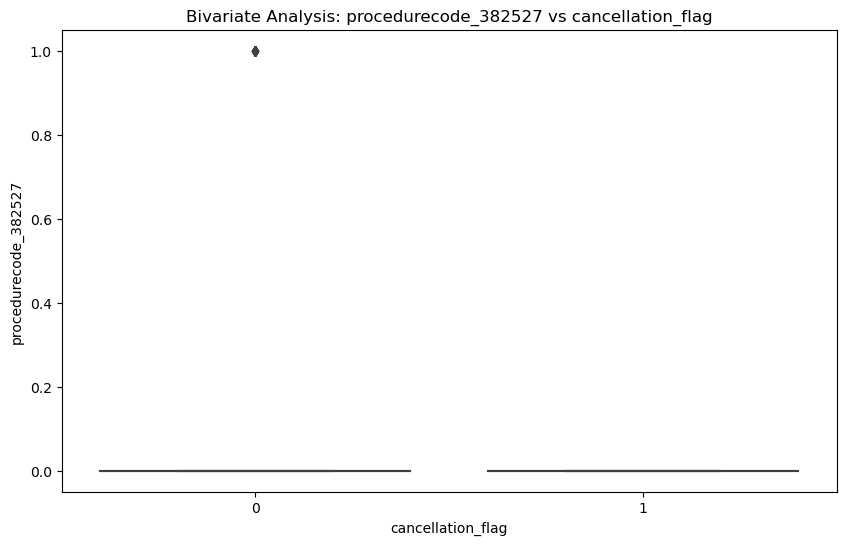


Descriptive Statistics for procedurecode_382527 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000095  0.009751  0.0  0.0  0.0  0.0  1.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



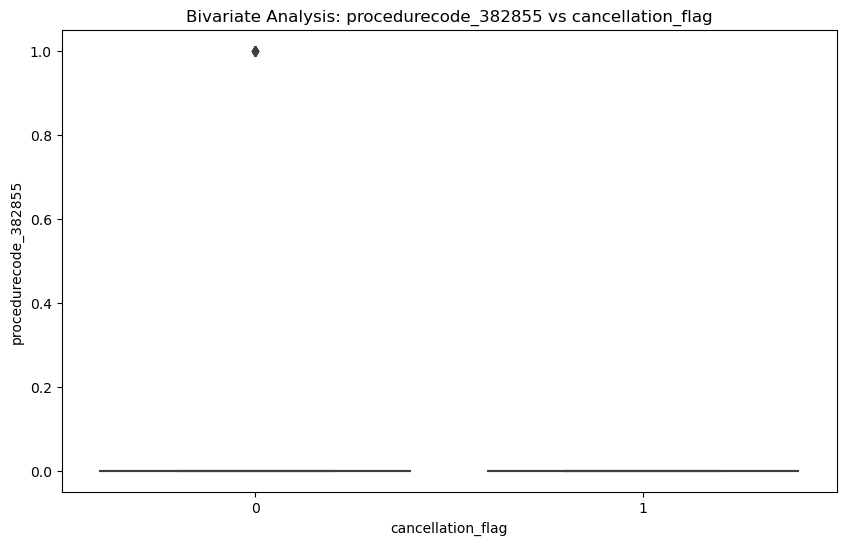


Descriptive Statistics for procedurecode_382855 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000071  0.008445  0.0  0.0  0.0  0.0  1.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



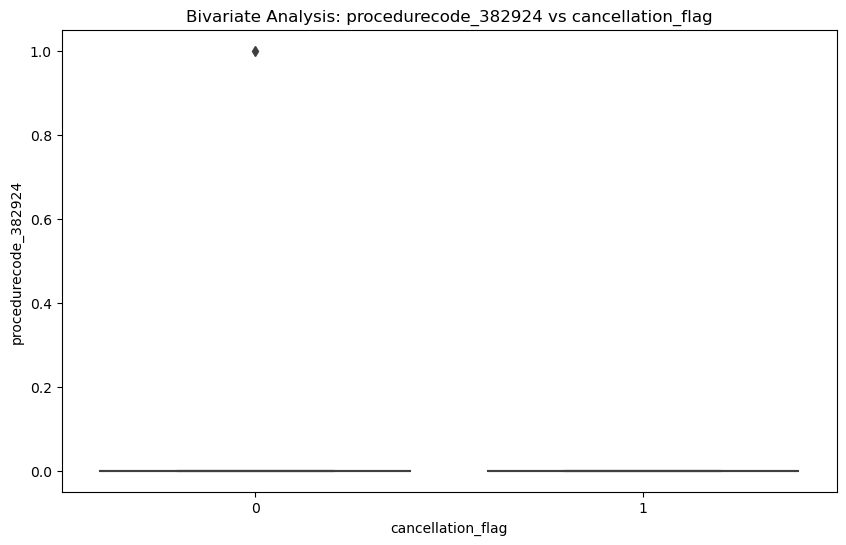


Descriptive Statistics for procedurecode_382924 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000012  0.003448  0.0  0.0  0.0  0.0  1.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



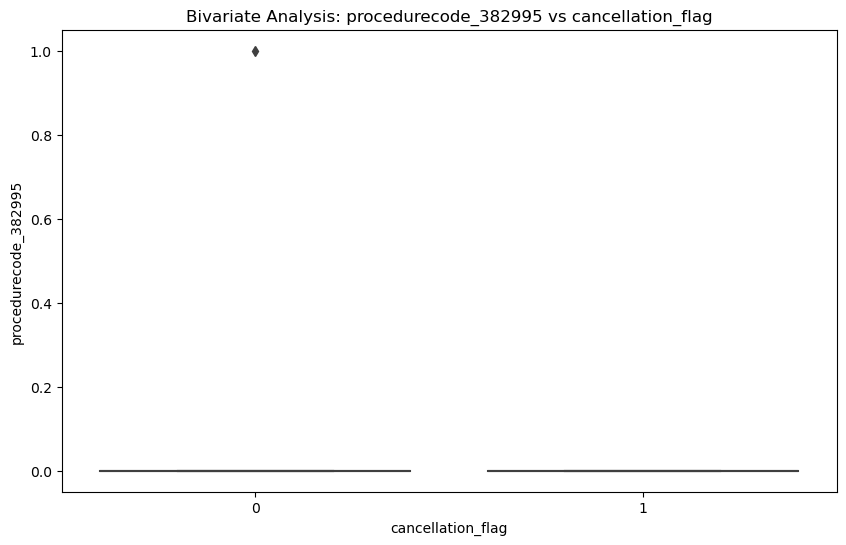


Descriptive Statistics for procedurecode_382995 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000012  0.003448  0.0  0.0  0.0  0.0  1.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



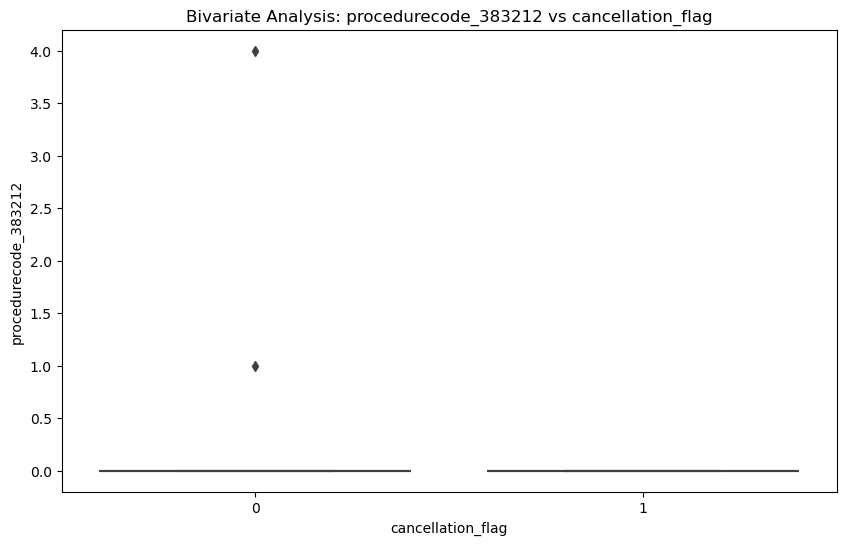


Descriptive Statistics for procedurecode_383212 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000059  0.014215  0.0  0.0  0.0  0.0  4.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



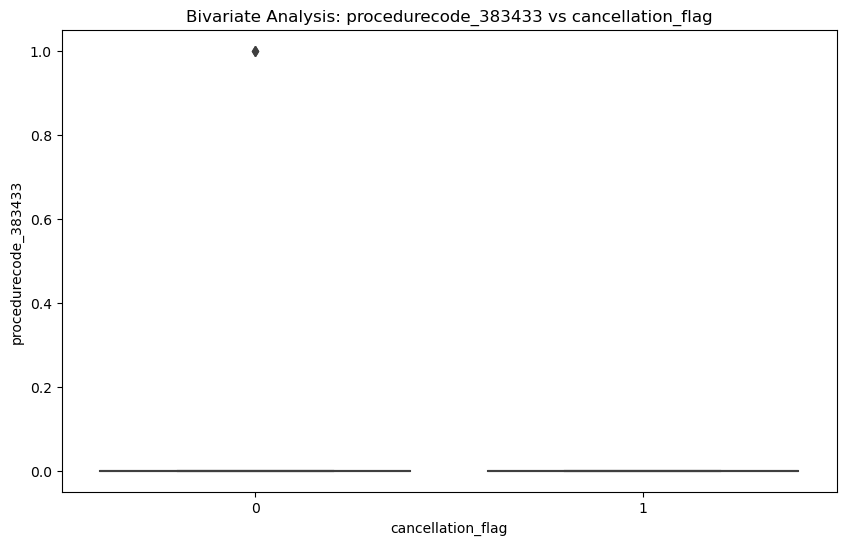


Descriptive Statistics for procedurecode_383433 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000024  0.004876  0.0  0.0  0.0  0.0  1.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



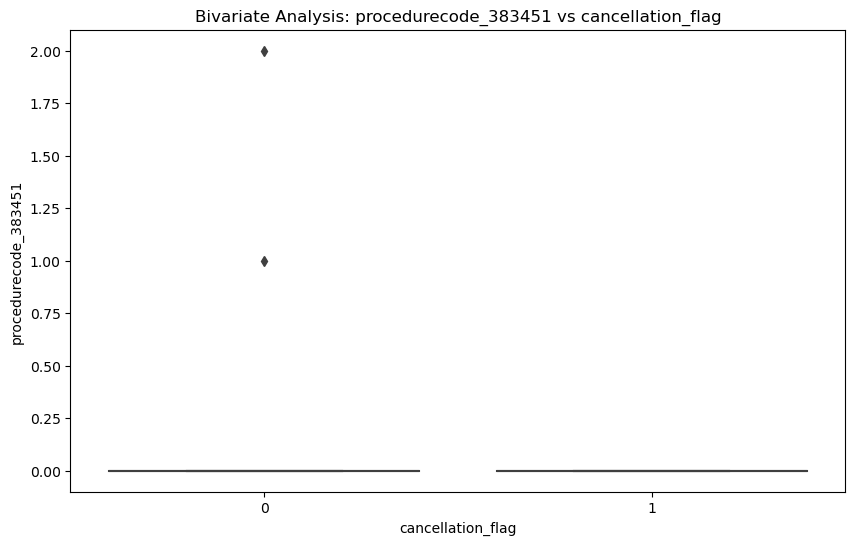


Descriptive Statistics for procedurecode_383451 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000036  0.007709  0.0  0.0  0.0  0.0  2.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



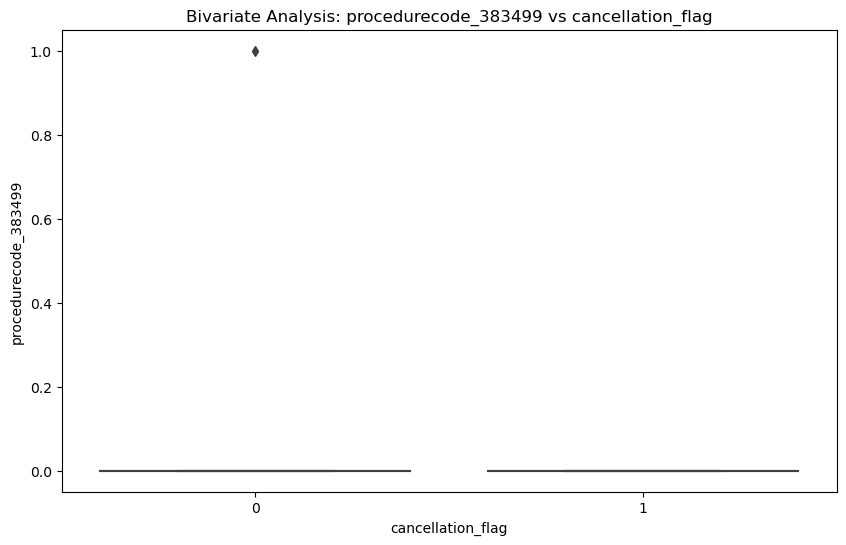


Descriptive Statistics for procedurecode_383499 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000012  0.003448  0.0  0.0  0.0  0.0  1.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



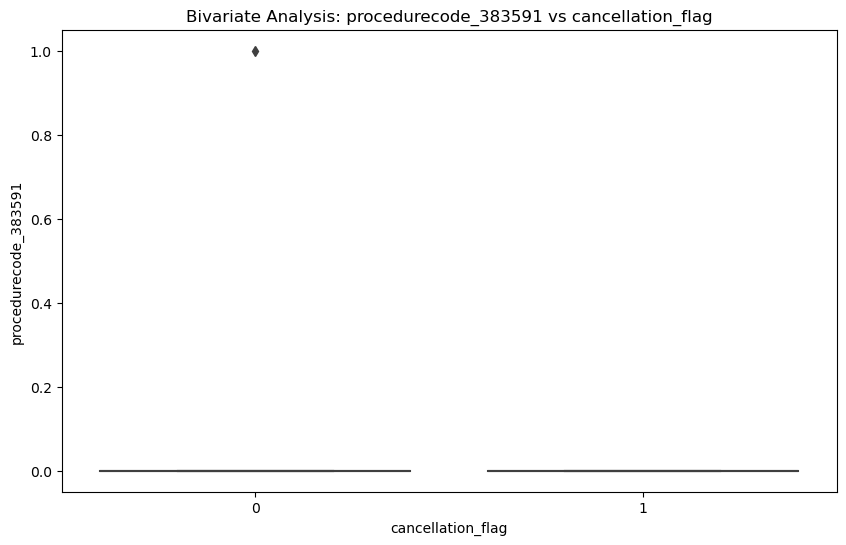


Descriptive Statistics for procedurecode_383591 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000012  0.003448  0.0  0.0  0.0  0.0  1.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



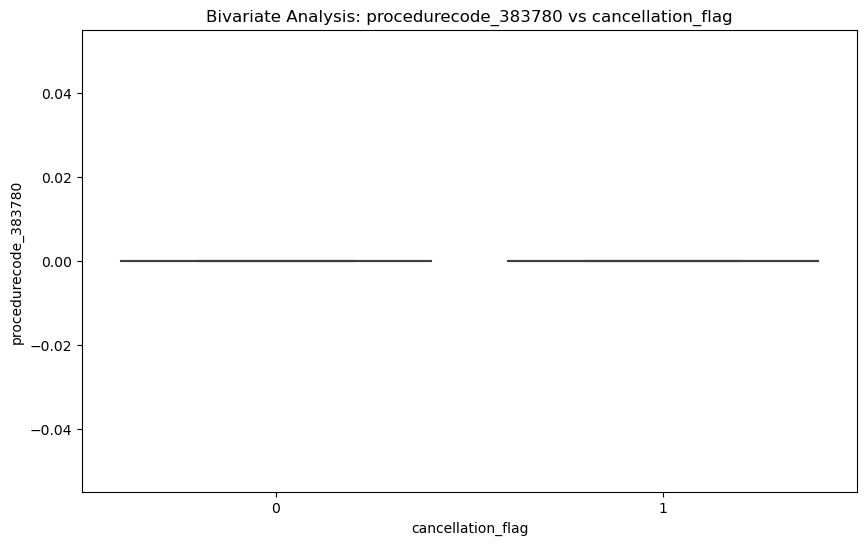


Descriptive Statistics for procedurecode_383780 by cancellation_flag:

                     count  mean  std  min  25%  50%  75%  max
cancellation_flag                                             
0                  84128.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
1                   7263.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0

---------------------------------------



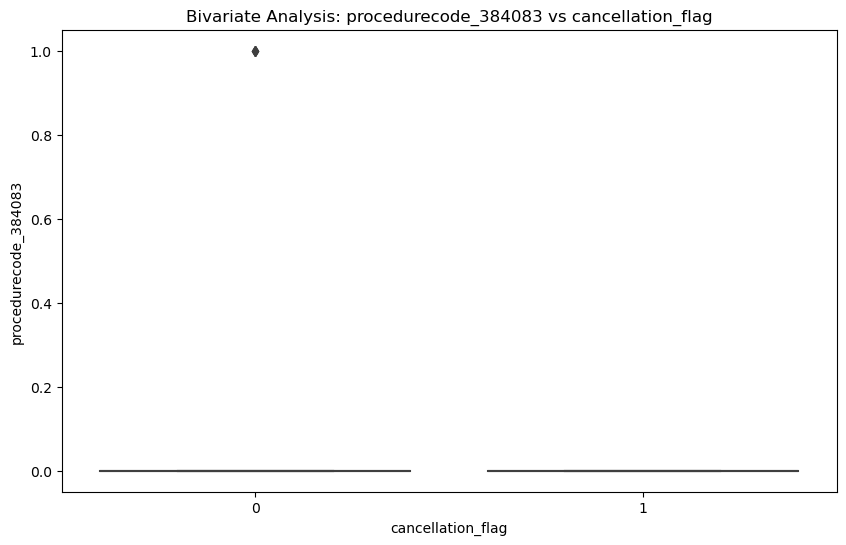


Descriptive Statistics for procedurecode_384083 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000036  0.005972  0.0  0.0  0.0  0.0  1.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



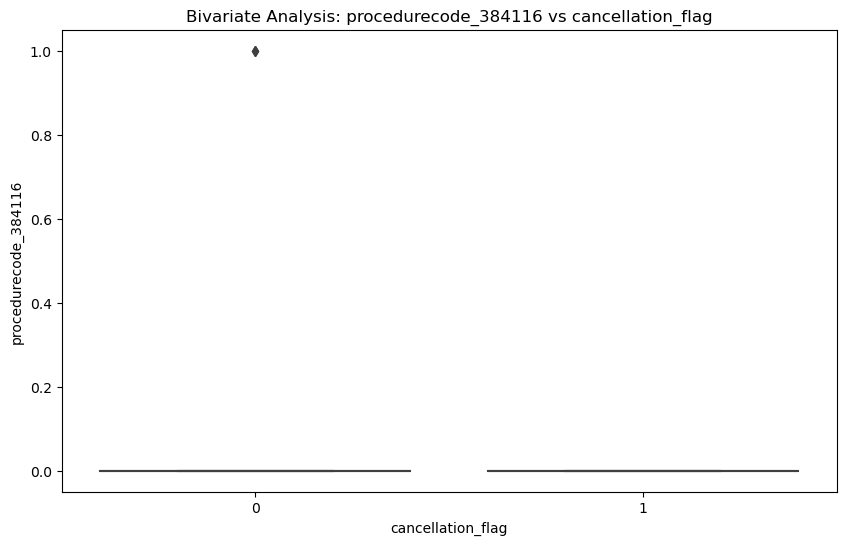


Descriptive Statistics for procedurecode_384116 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000024  0.004876  0.0  0.0  0.0  0.0  1.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



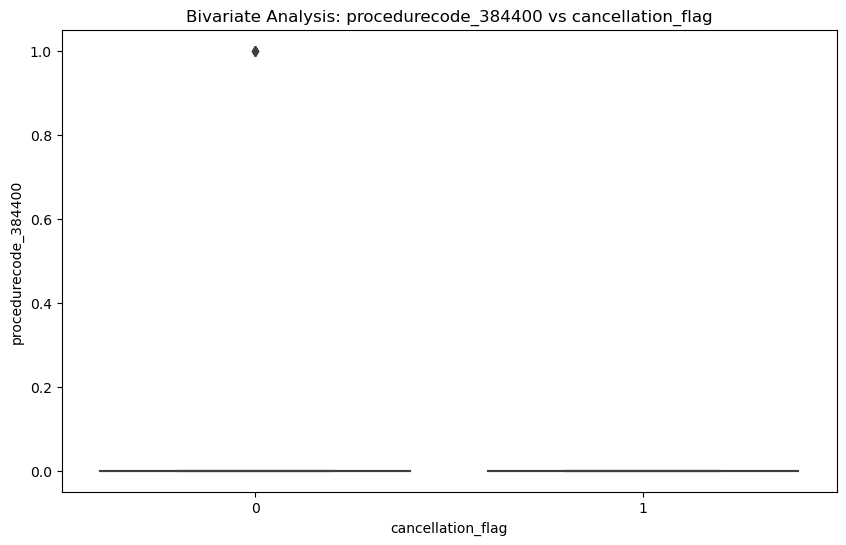


Descriptive Statistics for procedurecode_384400 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000036  0.005972  0.0  0.0  0.0  0.0  1.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



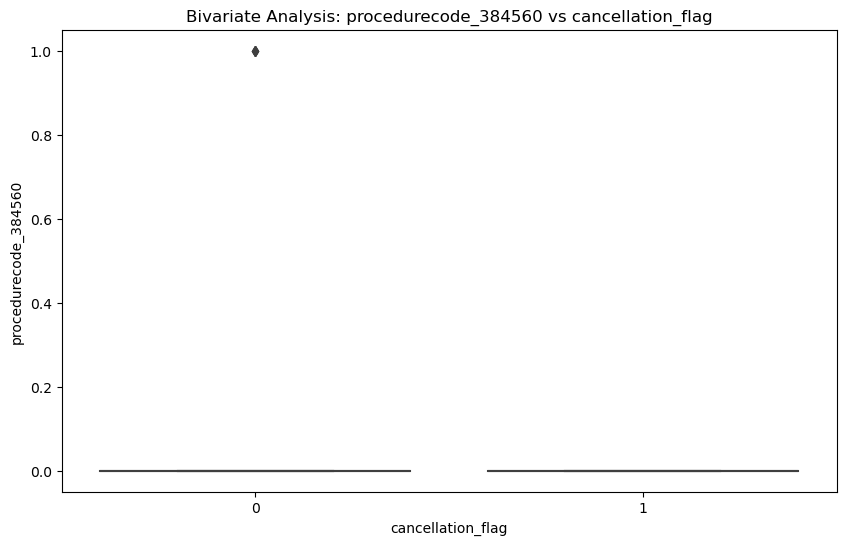


Descriptive Statistics for procedurecode_384560 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000036  0.005972  0.0  0.0  0.0  0.0  1.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



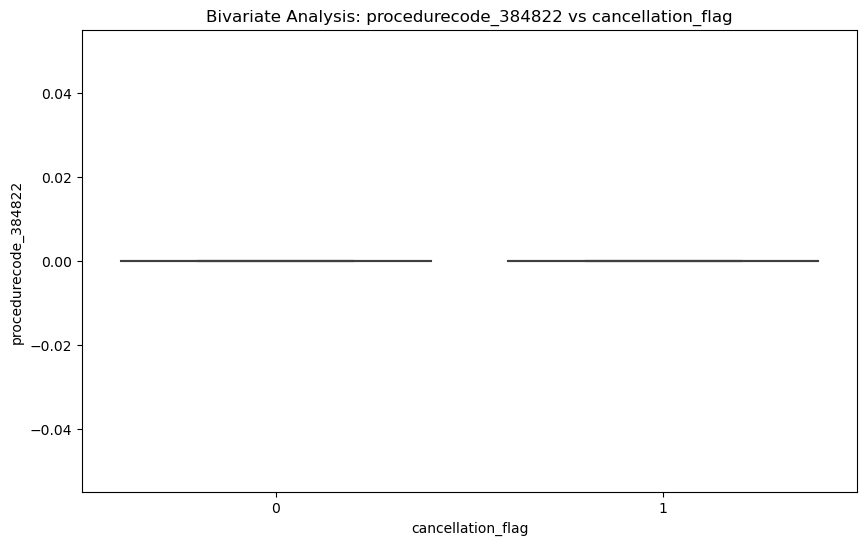


Descriptive Statistics for procedurecode_384822 by cancellation_flag:

                     count  mean  std  min  25%  50%  75%  max
cancellation_flag                                             
0                  84128.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
1                   7263.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0

---------------------------------------



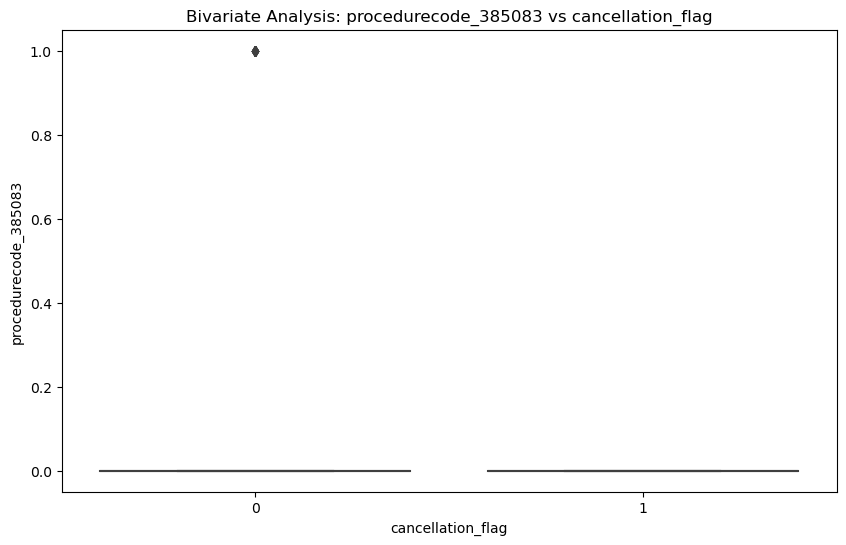


Descriptive Statistics for procedurecode_385083 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000131  0.011434  0.0  0.0  0.0  0.0  1.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



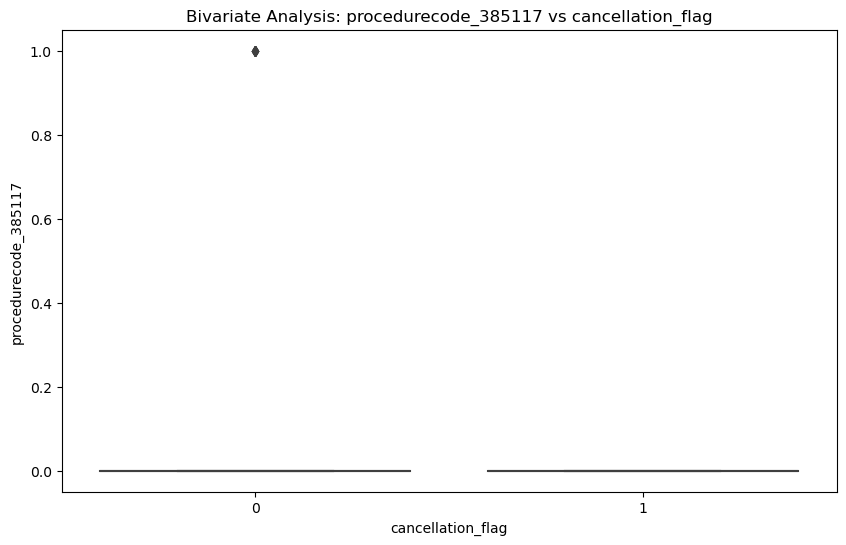


Descriptive Statistics for procedurecode_385117 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000071  0.008445  0.0  0.0  0.0  0.0  1.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



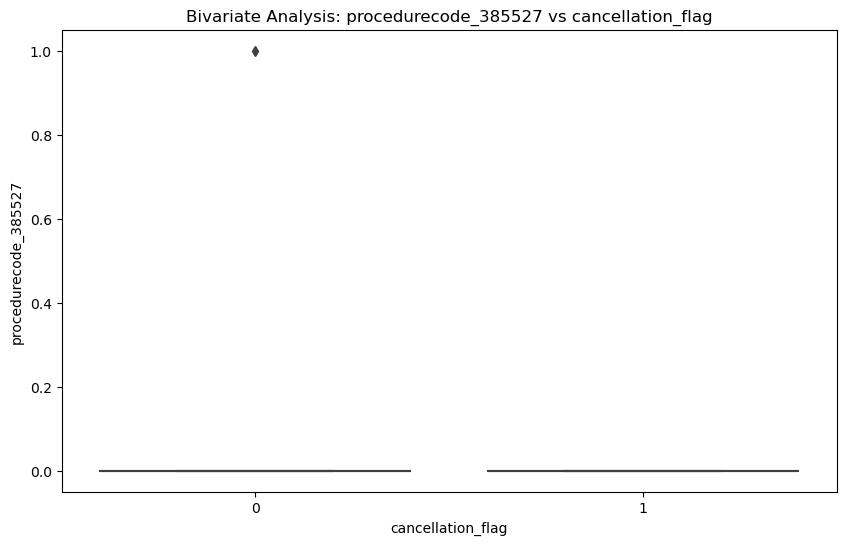


Descriptive Statistics for procedurecode_385527 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000012  0.003448  0.0  0.0  0.0  0.0  1.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



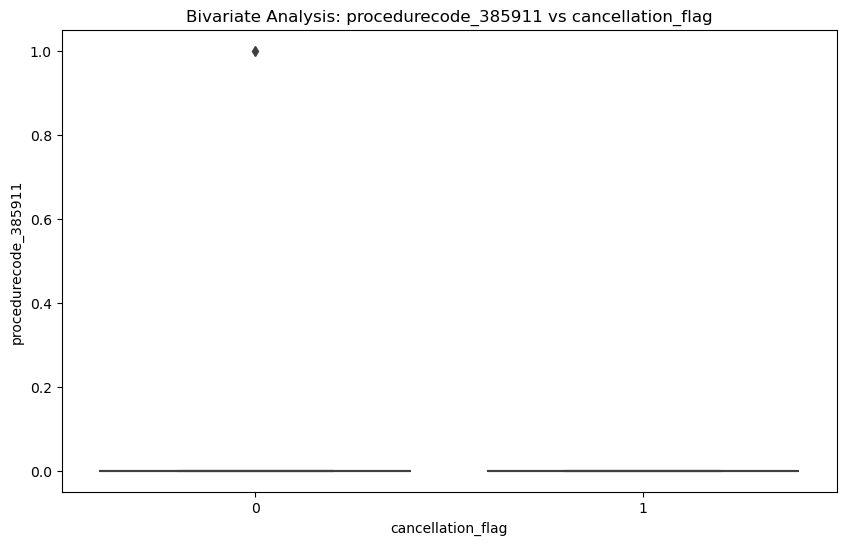


Descriptive Statistics for procedurecode_385911 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000012  0.003448  0.0  0.0  0.0  0.0  1.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



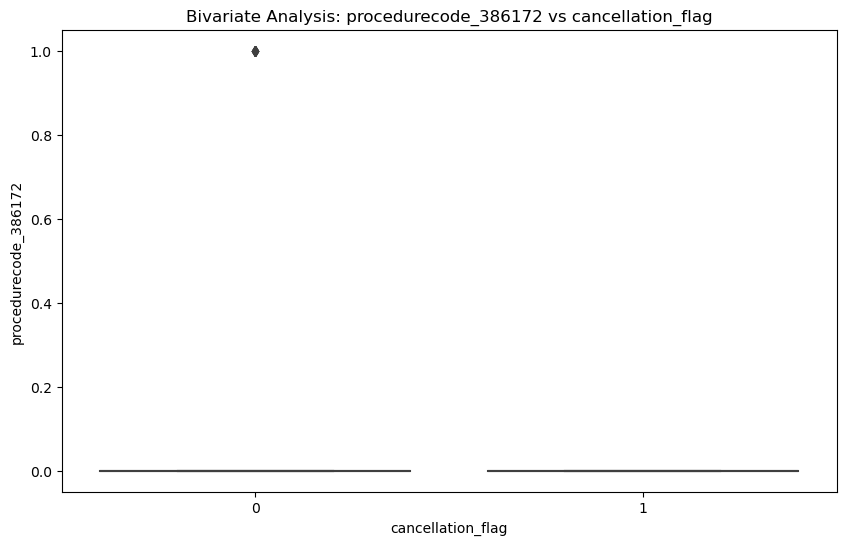


Descriptive Statistics for procedurecode_386172 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000083  0.009121  0.0  0.0  0.0  0.0  1.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



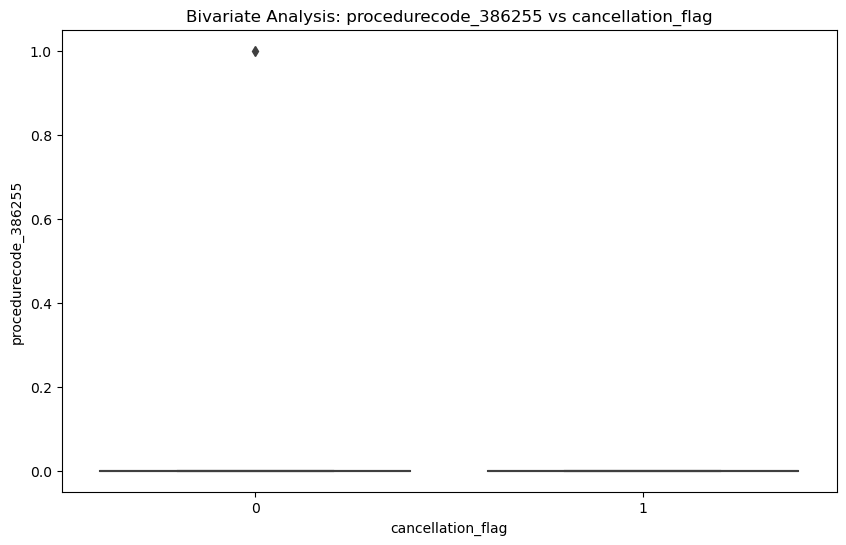


Descriptive Statistics for procedurecode_386255 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000012  0.003448  0.0  0.0  0.0  0.0  1.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



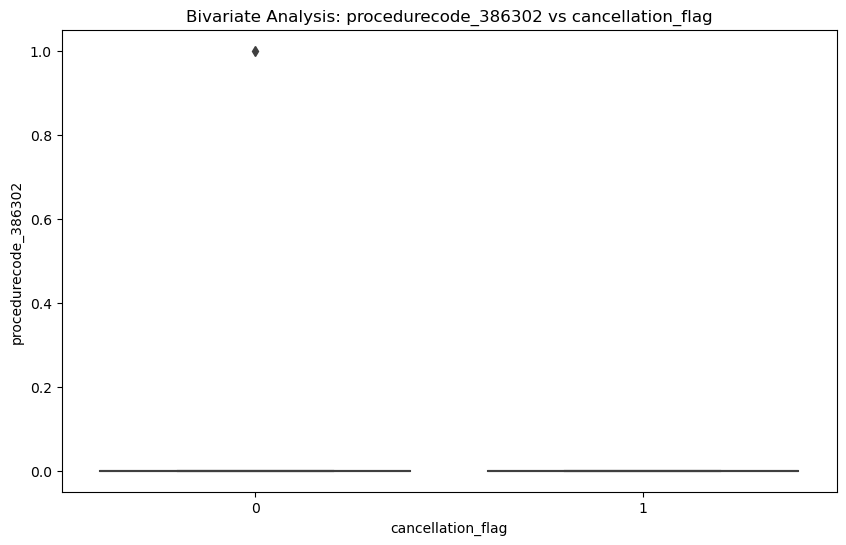


Descriptive Statistics for procedurecode_386302 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000012  0.003448  0.0  0.0  0.0  0.0  1.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



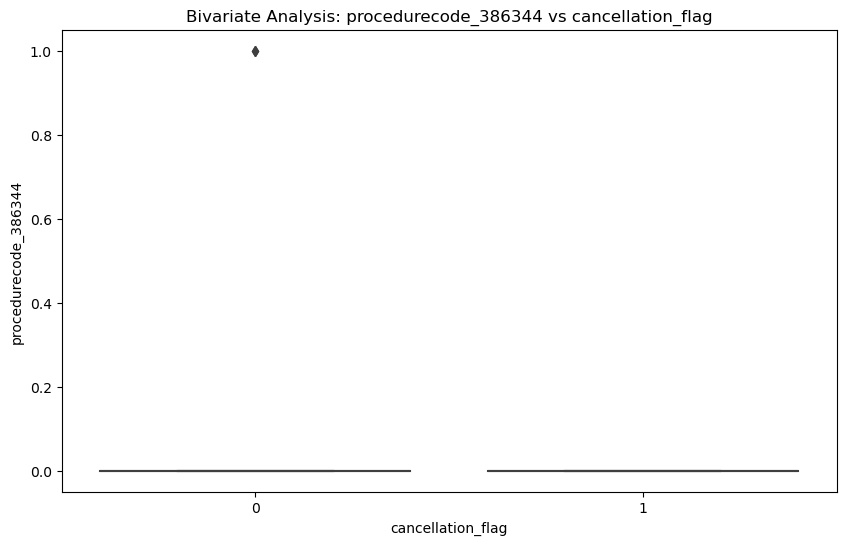


Descriptive Statistics for procedurecode_386344 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000024  0.004876  0.0  0.0  0.0  0.0  1.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



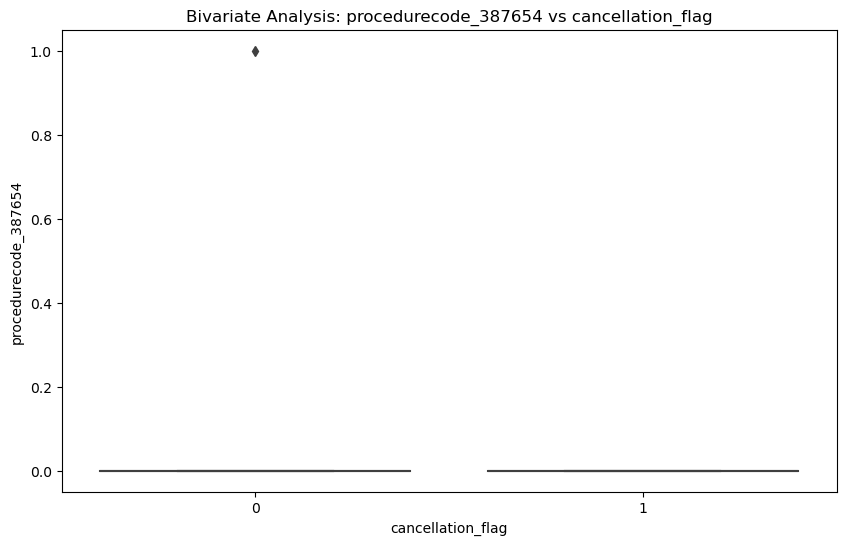


Descriptive Statistics for procedurecode_387654 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000012  0.003448  0.0  0.0  0.0  0.0  1.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



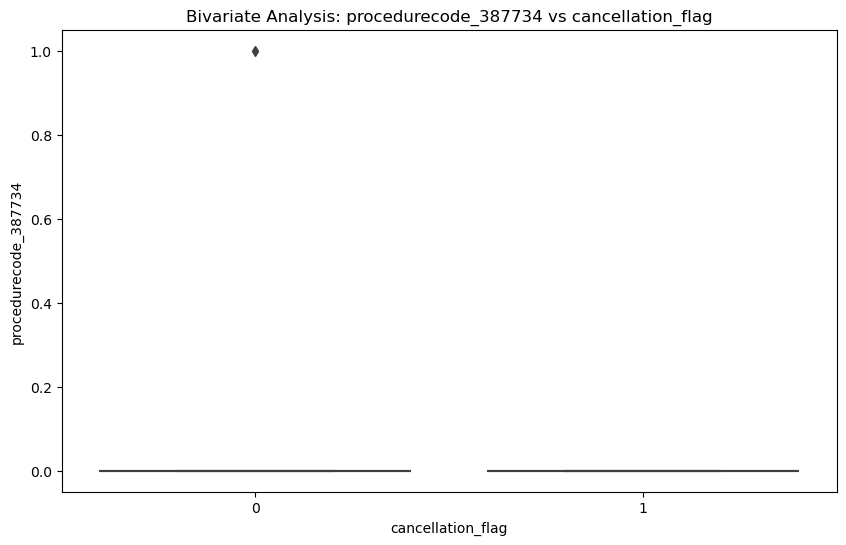


Descriptive Statistics for procedurecode_387734 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000012  0.003448  0.0  0.0  0.0  0.0  1.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



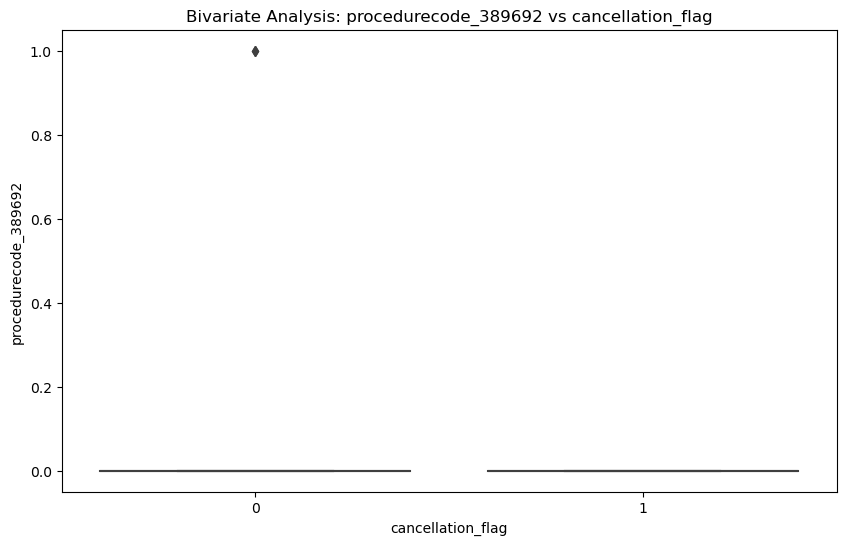


Descriptive Statistics for procedurecode_389692 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000024  0.004876  0.0  0.0  0.0  0.0  1.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



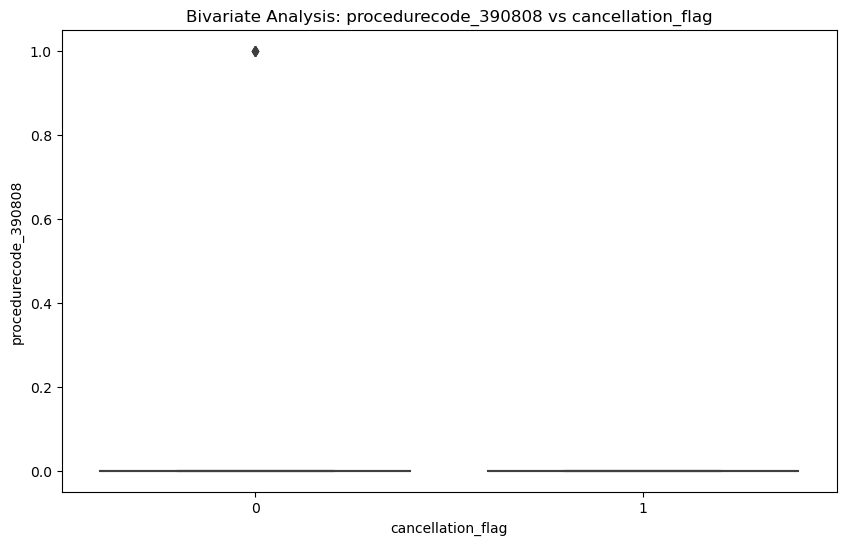


Descriptive Statistics for procedurecode_390808 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000048  0.006895  0.0  0.0  0.0  0.0  1.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



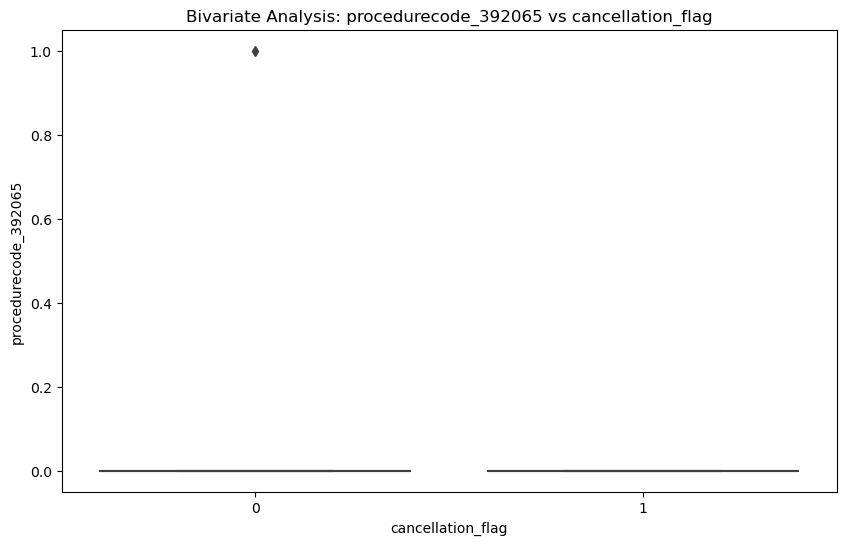


Descriptive Statistics for procedurecode_392065 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000012  0.003448  0.0  0.0  0.0  0.0  1.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



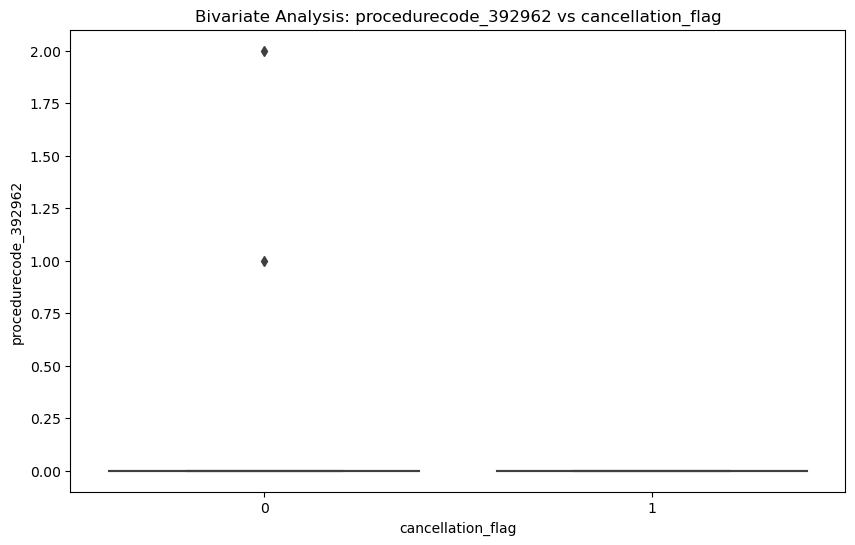


Descriptive Statistics for procedurecode_392962 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000036  0.007709  0.0  0.0  0.0  0.0  2.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



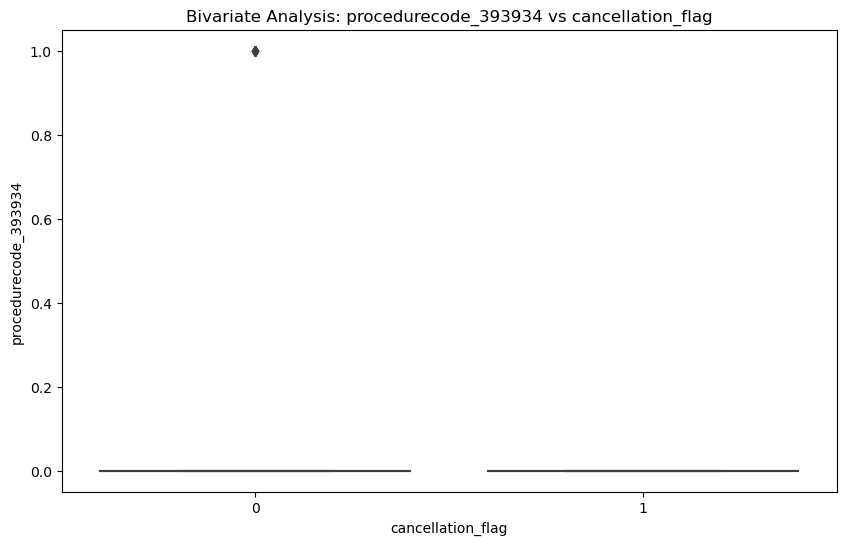


Descriptive Statistics for procedurecode_393934 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000071  0.008445  0.0  0.0  0.0  0.0  1.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



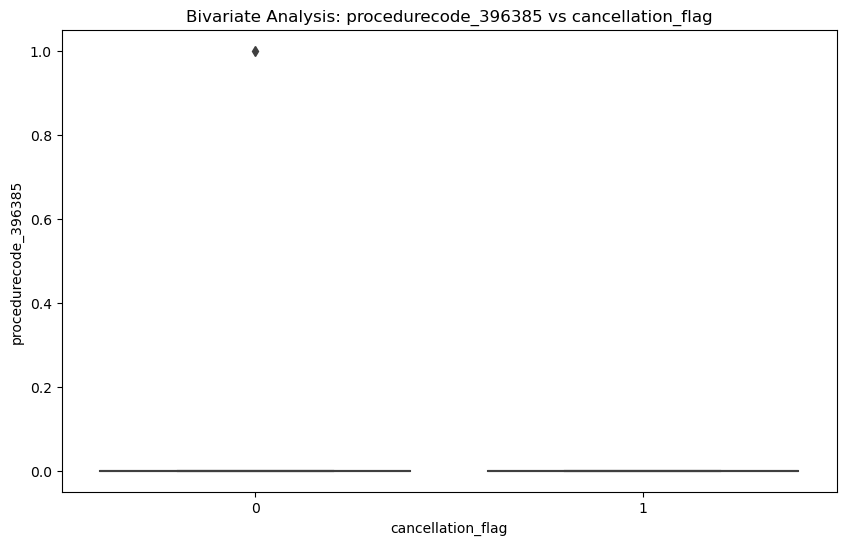


Descriptive Statistics for procedurecode_396385 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000012  0.003448  0.0  0.0  0.0  0.0  1.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



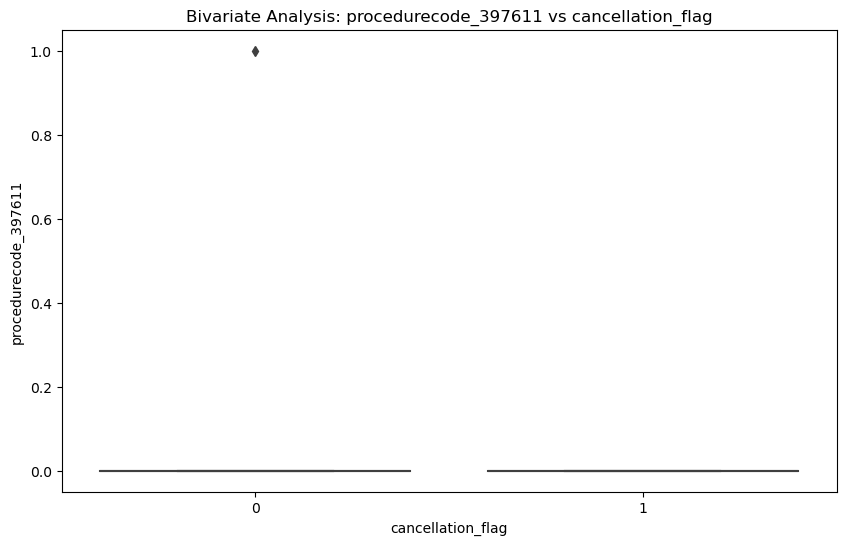


Descriptive Statistics for procedurecode_397611 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000012  0.003448  0.0  0.0  0.0  0.0  1.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



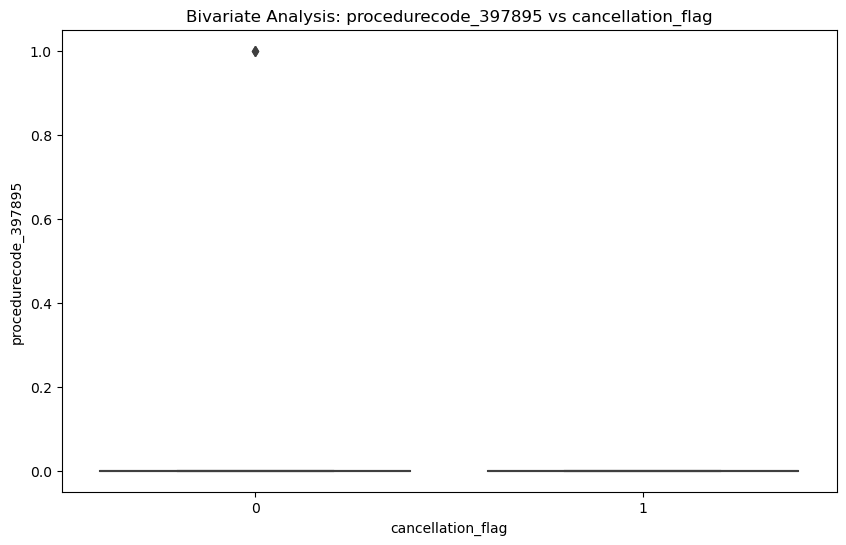


Descriptive Statistics for procedurecode_397895 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000024  0.004876  0.0  0.0  0.0  0.0  1.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



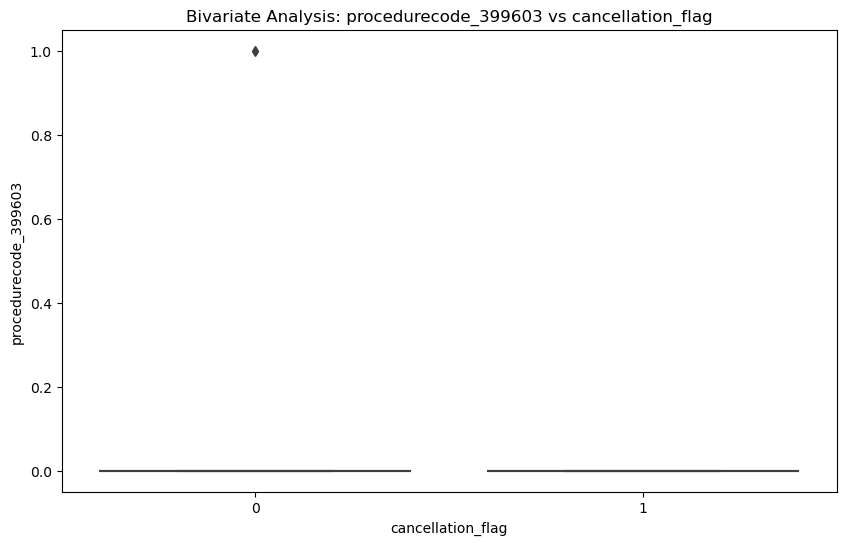


Descriptive Statistics for procedurecode_399603 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000012  0.003448  0.0  0.0  0.0  0.0  1.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



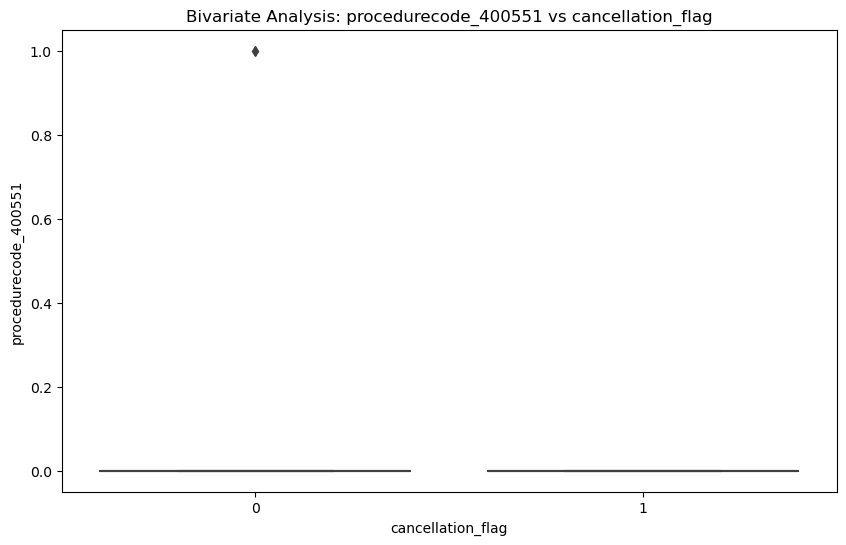


Descriptive Statistics for procedurecode_400551 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000012  0.003448  0.0  0.0  0.0  0.0  1.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



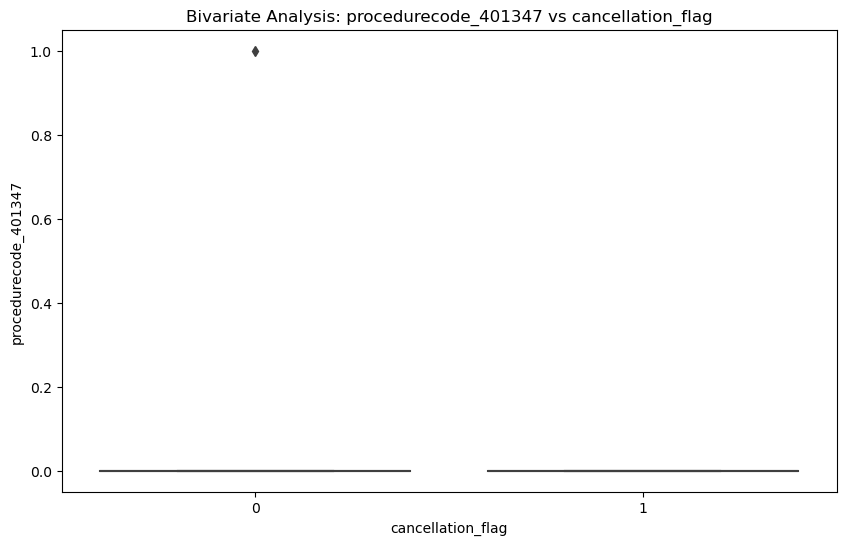


Descriptive Statistics for procedurecode_401347 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000012  0.003448  0.0  0.0  0.0  0.0  1.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



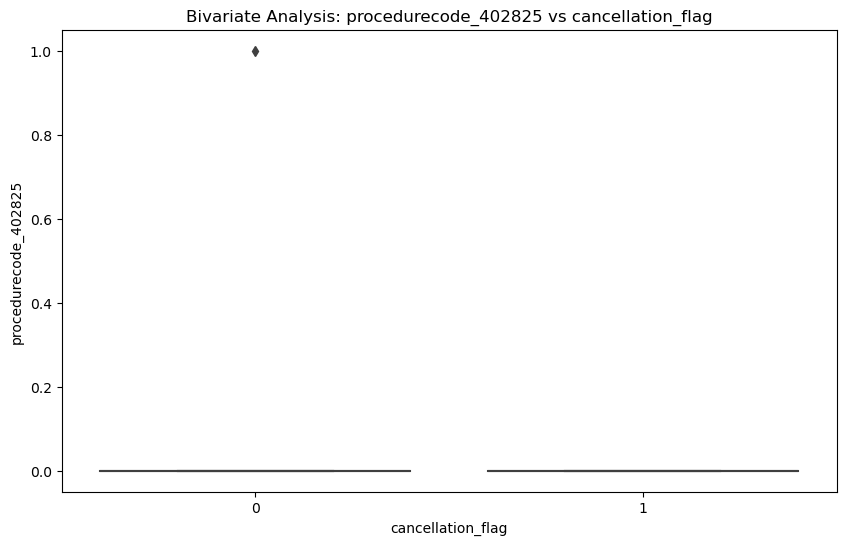


Descriptive Statistics for procedurecode_402825 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000012  0.003448  0.0  0.0  0.0  0.0  1.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



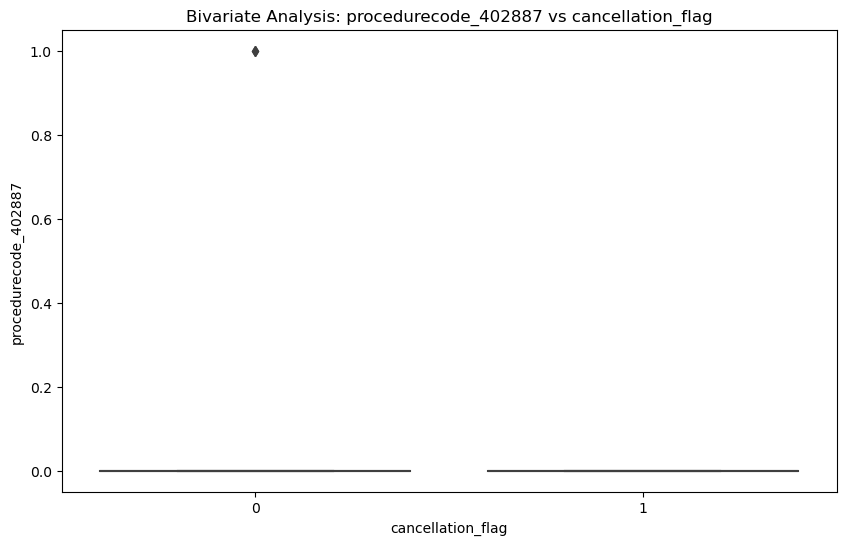


Descriptive Statistics for procedurecode_402887 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000024  0.004876  0.0  0.0  0.0  0.0  1.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



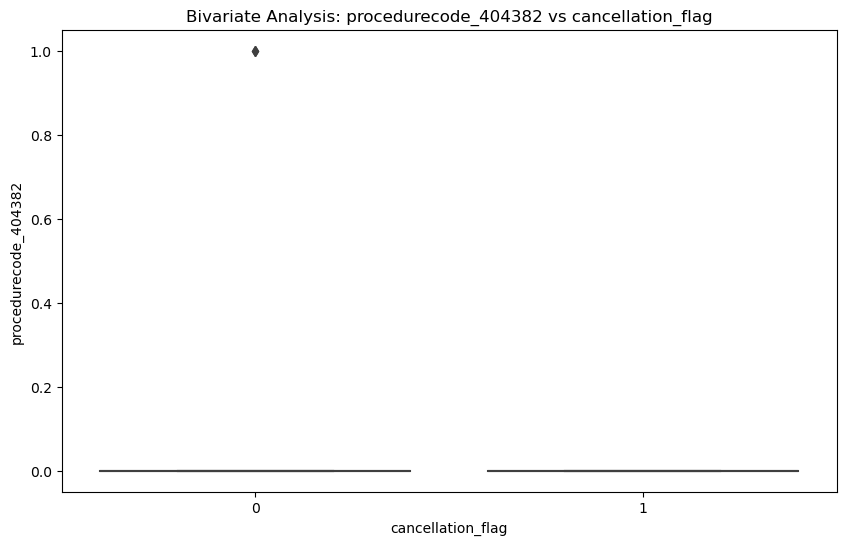


Descriptive Statistics for procedurecode_404382 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000024  0.004876  0.0  0.0  0.0  0.0  1.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



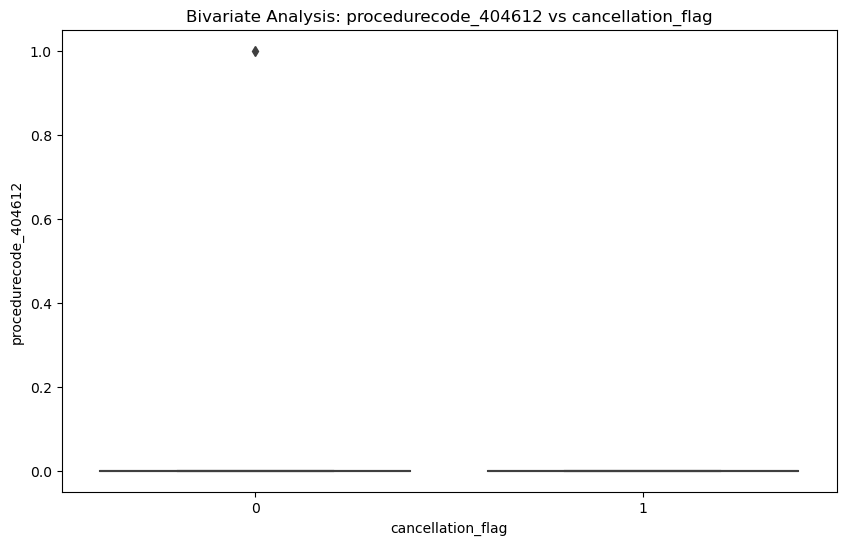


Descriptive Statistics for procedurecode_404612 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000012  0.003448  0.0  0.0  0.0  0.0  1.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



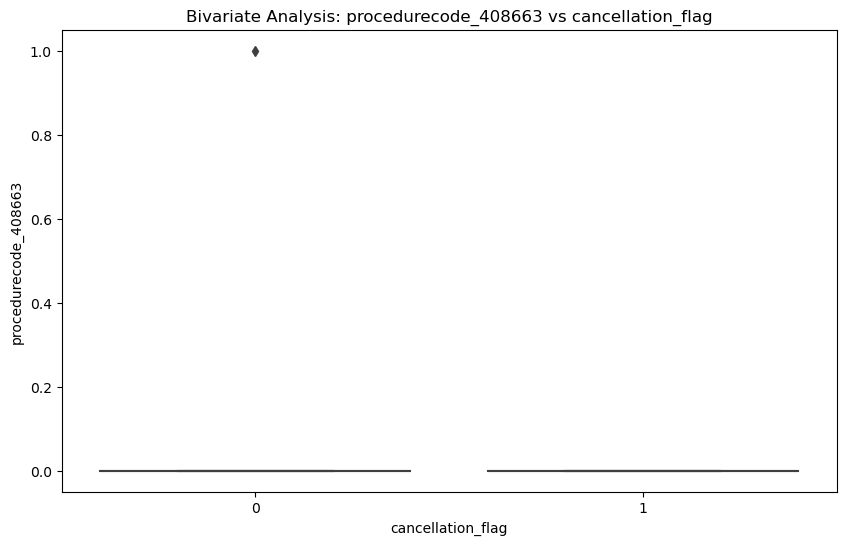


Descriptive Statistics for procedurecode_408663 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000012  0.003448  0.0  0.0  0.0  0.0  1.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



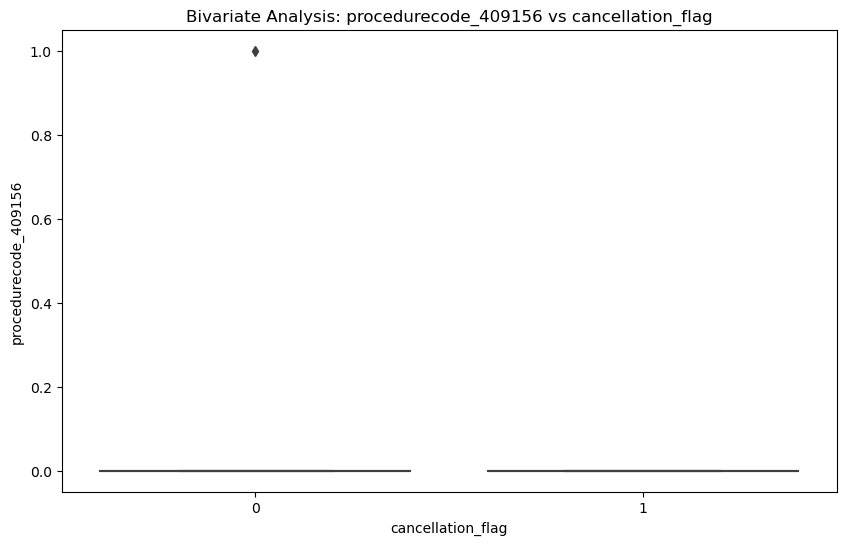


Descriptive Statistics for procedurecode_409156 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000012  0.003448  0.0  0.0  0.0  0.0  1.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



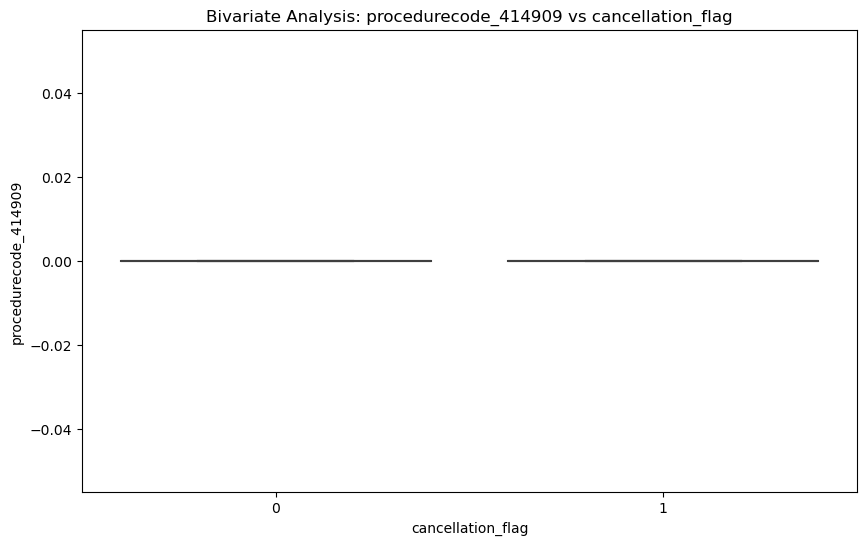


Descriptive Statistics for procedurecode_414909 by cancellation_flag:

                     count  mean  std  min  25%  50%  75%  max
cancellation_flag                                             
0                  84128.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
1                   7263.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0

---------------------------------------



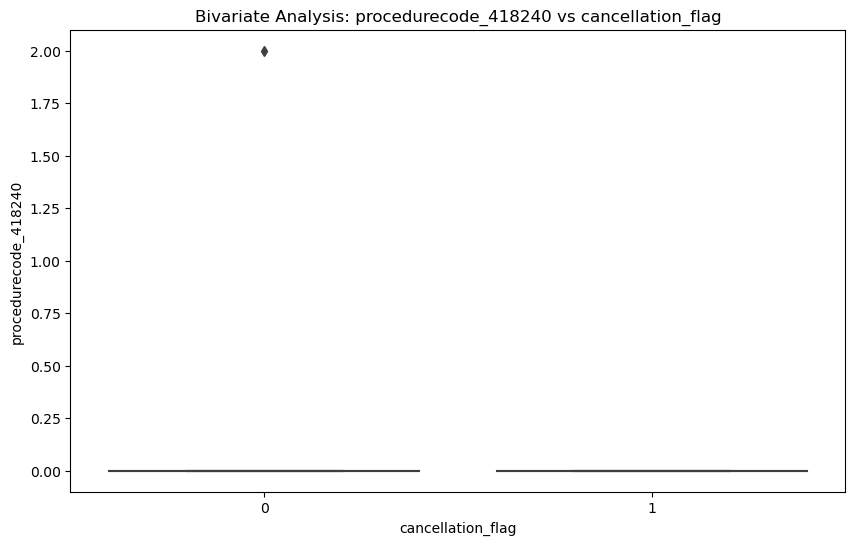


Descriptive Statistics for procedurecode_418240 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000024  0.006895  0.0  0.0  0.0  0.0  2.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



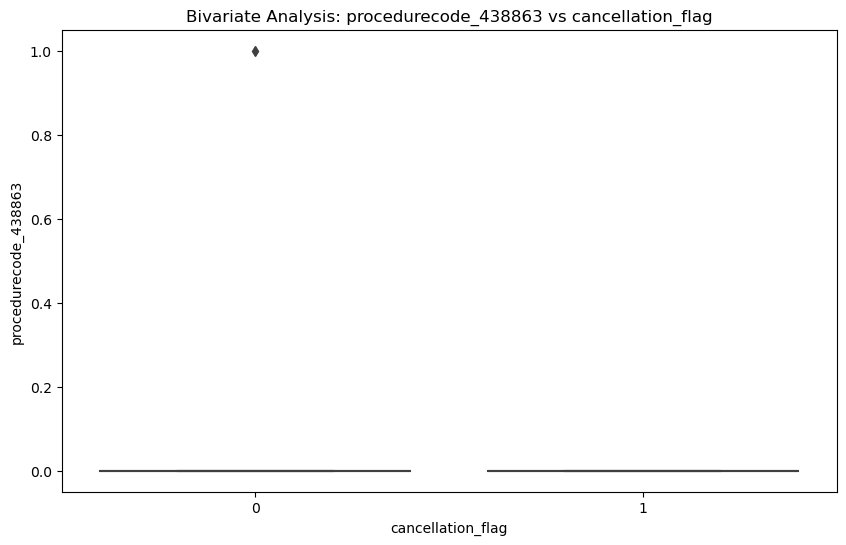


Descriptive Statistics for procedurecode_438863 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000012  0.003448  0.0  0.0  0.0  0.0  1.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



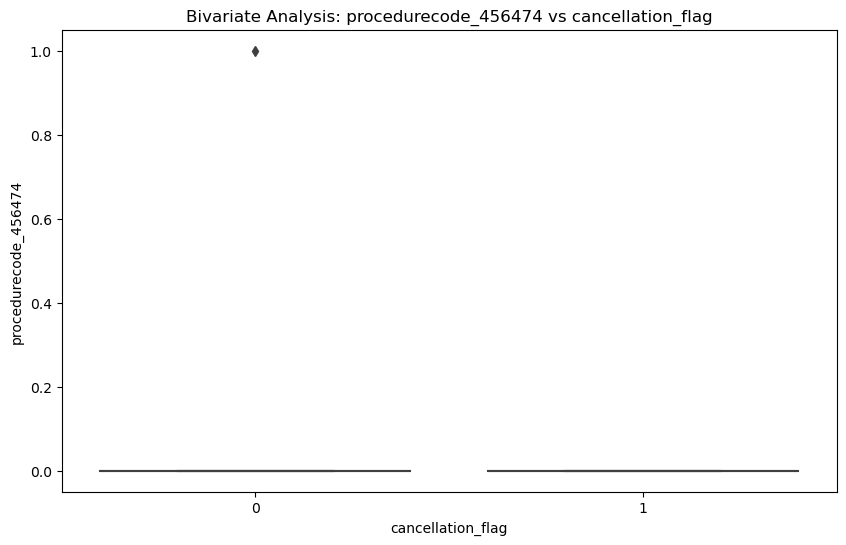


Descriptive Statistics for procedurecode_456474 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000012  0.003448  0.0  0.0  0.0  0.0  1.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



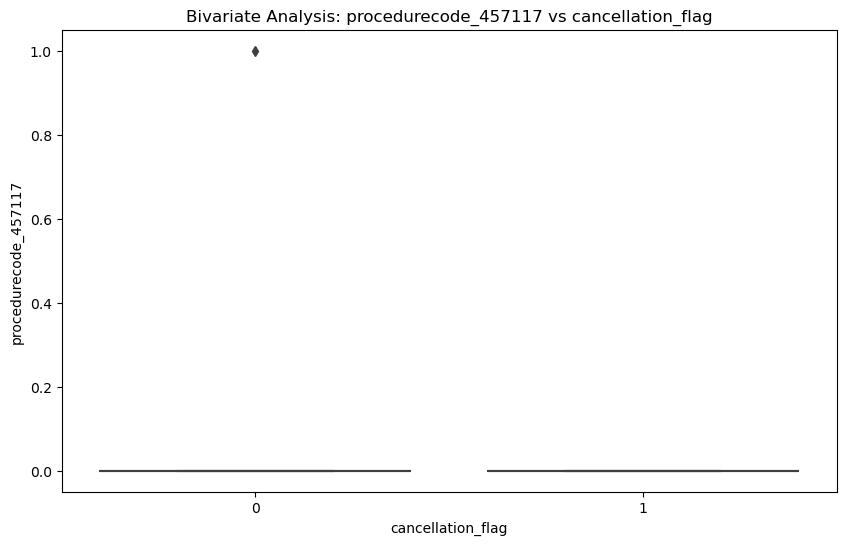


Descriptive Statistics for procedurecode_457117 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000012  0.003448  0.0  0.0  0.0  0.0  1.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



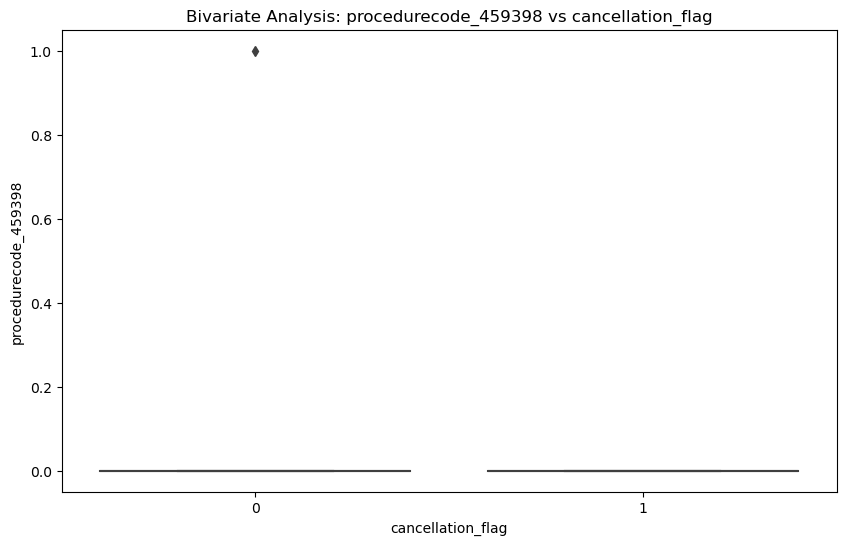


Descriptive Statistics for procedurecode_459398 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000012  0.003448  0.0  0.0  0.0  0.0  1.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



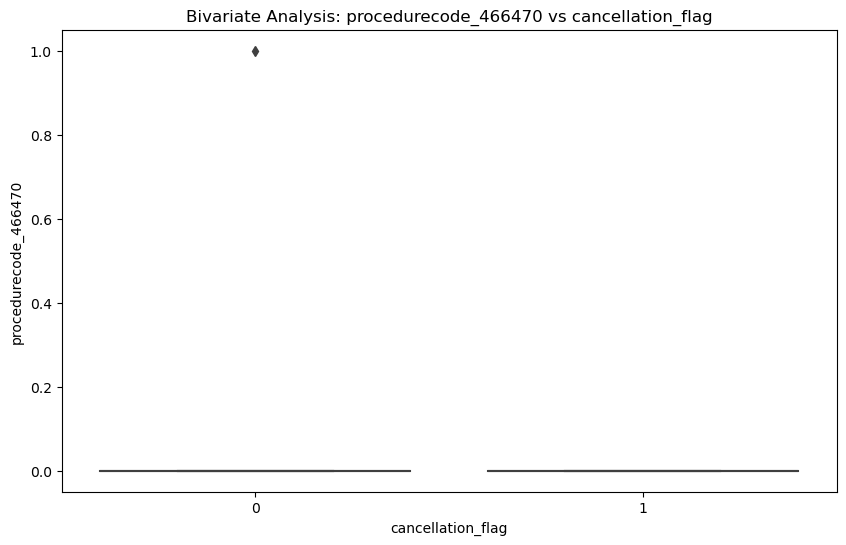


Descriptive Statistics for procedurecode_466470 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000012  0.003448  0.0  0.0  0.0  0.0  1.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



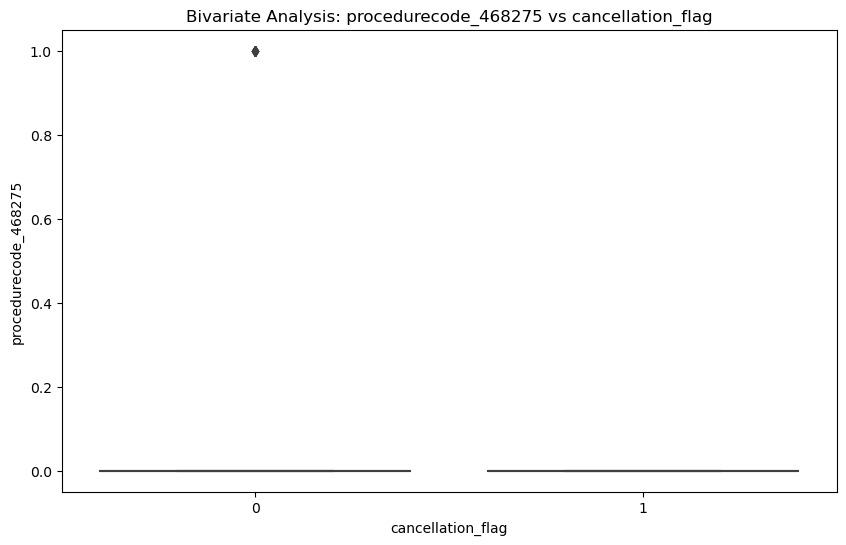


Descriptive Statistics for procedurecode_468275 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000071  0.008445  0.0  0.0  0.0  0.0  1.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



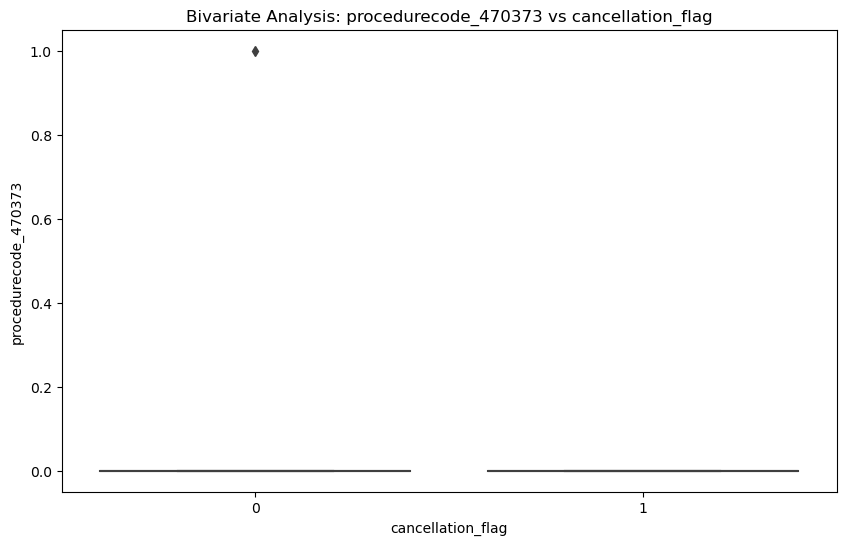


Descriptive Statistics for procedurecode_470373 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000012  0.003448  0.0  0.0  0.0  0.0  1.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



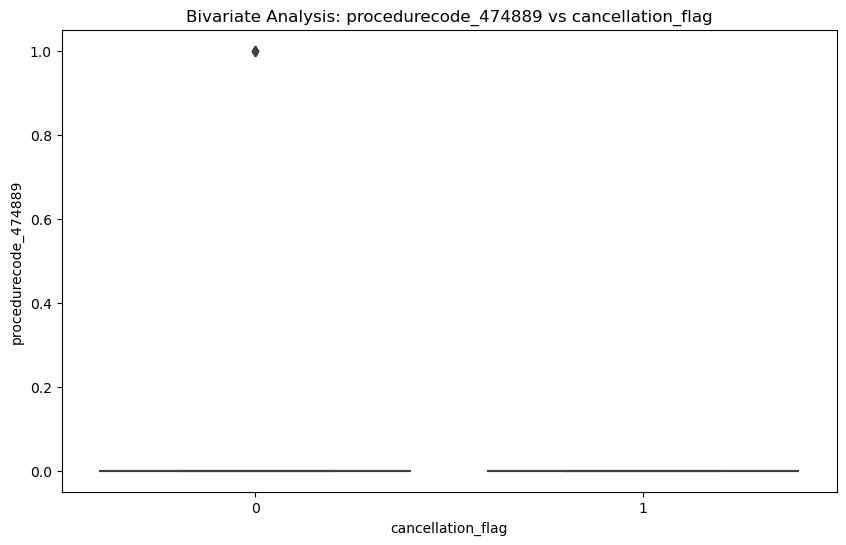


Descriptive Statistics for procedurecode_474889 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000059  0.007709  0.0  0.0  0.0  0.0  1.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



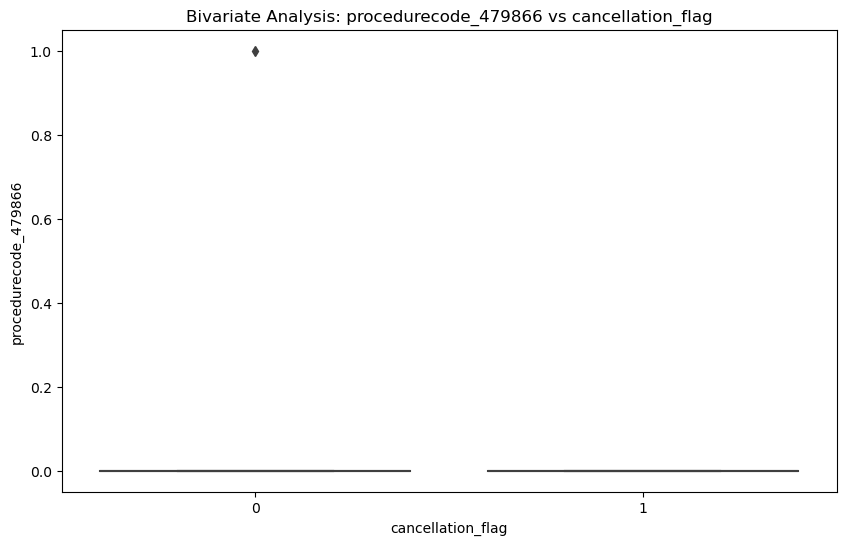


Descriptive Statistics for procedurecode_479866 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000012  0.003448  0.0  0.0  0.0  0.0  1.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



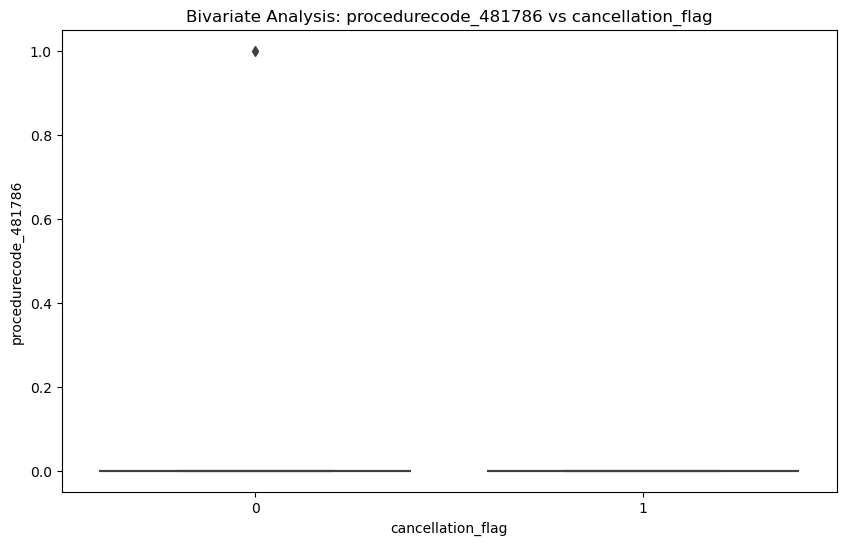


Descriptive Statistics for procedurecode_481786 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000012  0.003448  0.0  0.0  0.0  0.0  1.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



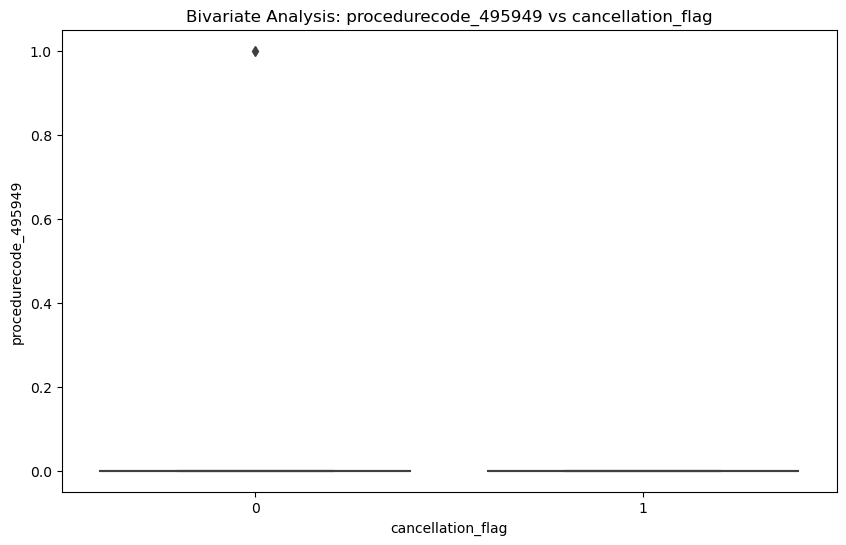


Descriptive Statistics for procedurecode_495949 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000012  0.003448  0.0  0.0  0.0  0.0  1.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



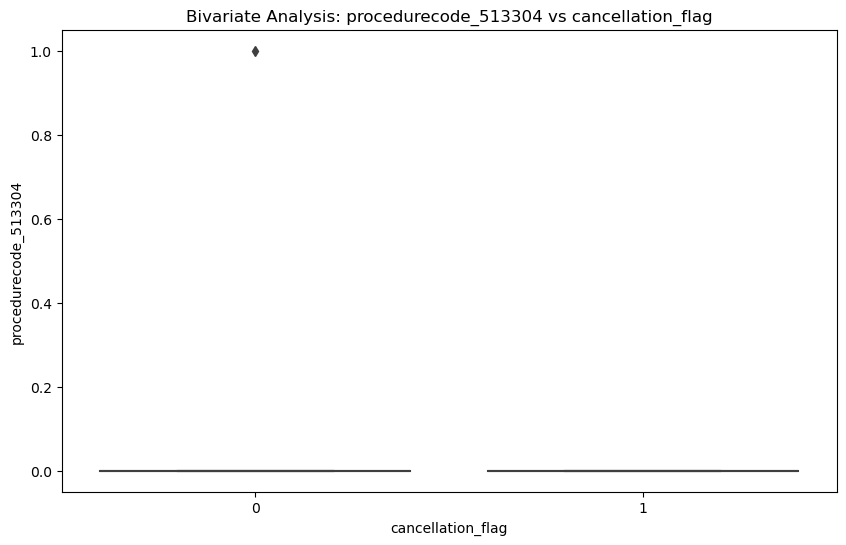


Descriptive Statistics for procedurecode_513304 by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.000012  0.003448  0.0  0.0  0.0  0.0  1.0
1                   7263.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

---------------------------------------



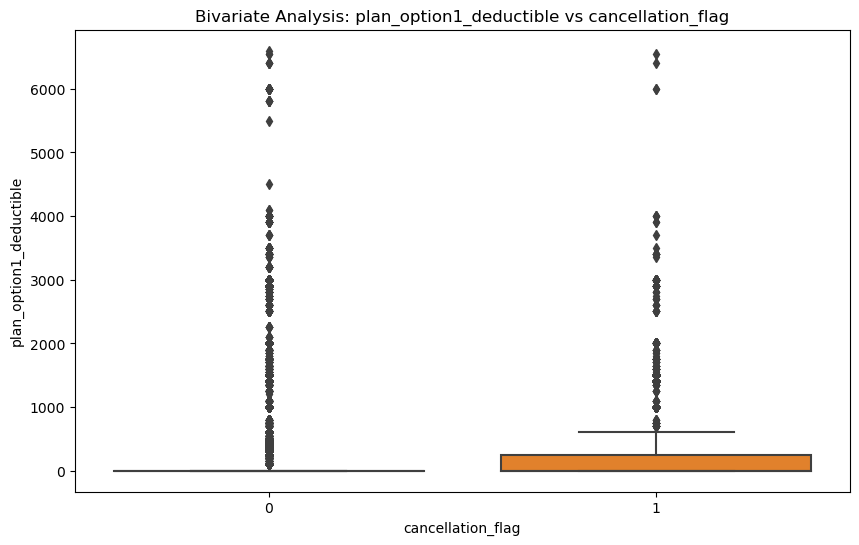


Descriptive Statistics for plan_option1_deductible by cancellation_flag:

                     count        mean         std  min  25%  50%    75%  \
cancellation_flag                                                          
0                  84128.0  249.987519  570.366289  0.0  0.0  0.0    0.0   
1                   7263.0  283.044197  602.305471  0.0  0.0  0.0  250.0   

                      max  
cancellation_flag          
0                  6600.0  
1                  6550.0  

---------------------------------------



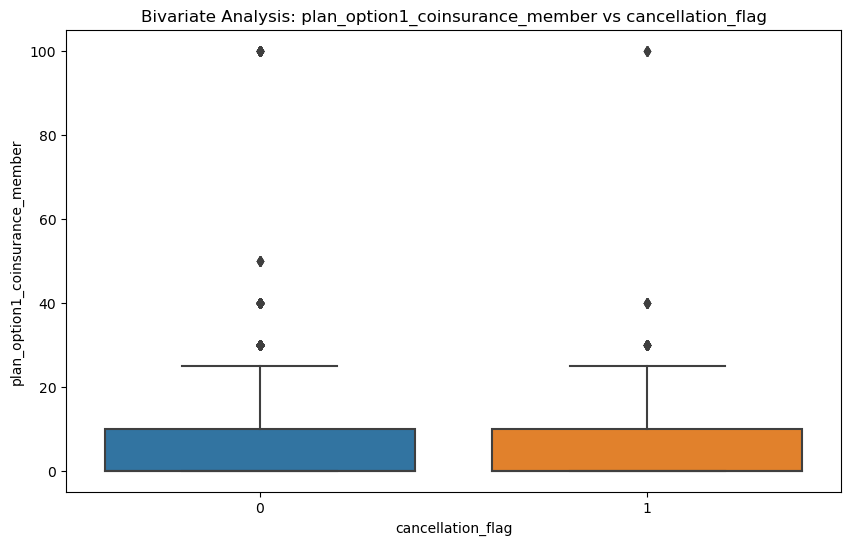


Descriptive Statistics for plan_option1_coinsurance_member by cancellation_flag:

                     count      mean       std  min  25%  50%   75%    max
cancellation_flag                                                         
0                  84128.0  3.315543  6.599796  0.0  0.0  0.0  10.0  100.0
1                   7263.0  3.713342  6.746187  0.0  0.0  0.0  10.0  100.0

---------------------------------------



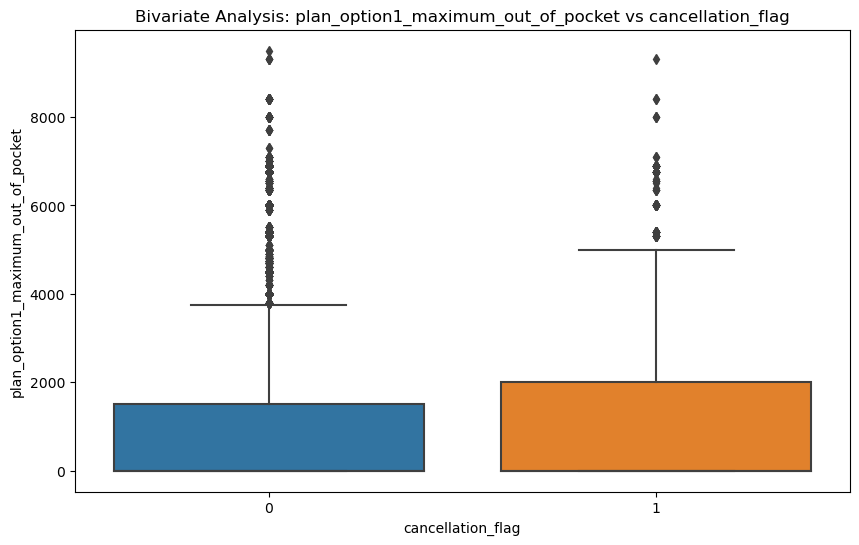


Descriptive Statistics for plan_option1_maximum_out_of_pocket by cancellation_flag:

                     count        mean          std  min  25%  50%     75%  \
cancellation_flag                                                            
0                  84128.0  729.034923  1354.198293  0.0  0.0  0.0  1500.0   
1                   7263.0  826.445684  1426.223514  0.0  0.0  0.0  2000.0   

                      max  
cancellation_flag          
0                  9500.0  
1                  9300.0  

---------------------------------------



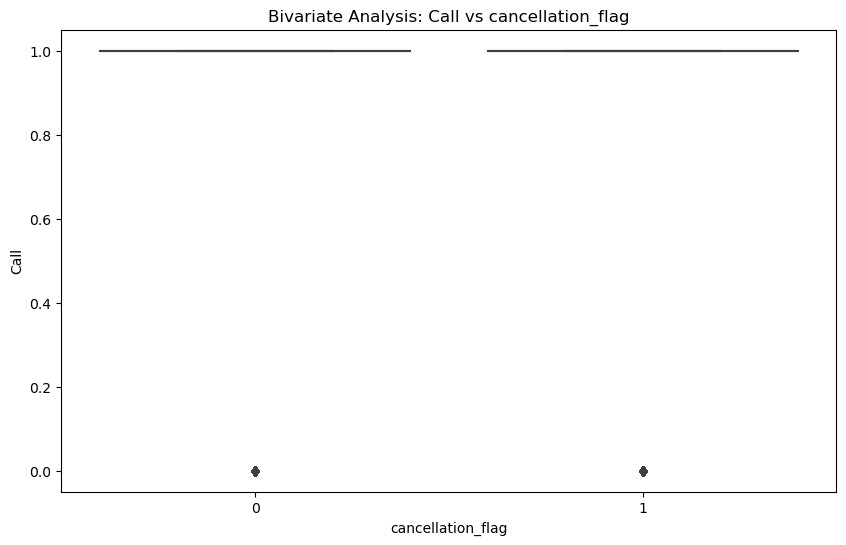


Descriptive Statistics for Call by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.885353  0.318597  0.0  1.0  1.0  1.0  1.0
1                   7263.0  0.889164  0.313950  0.0  1.0  1.0  1.0  1.0

---------------------------------------



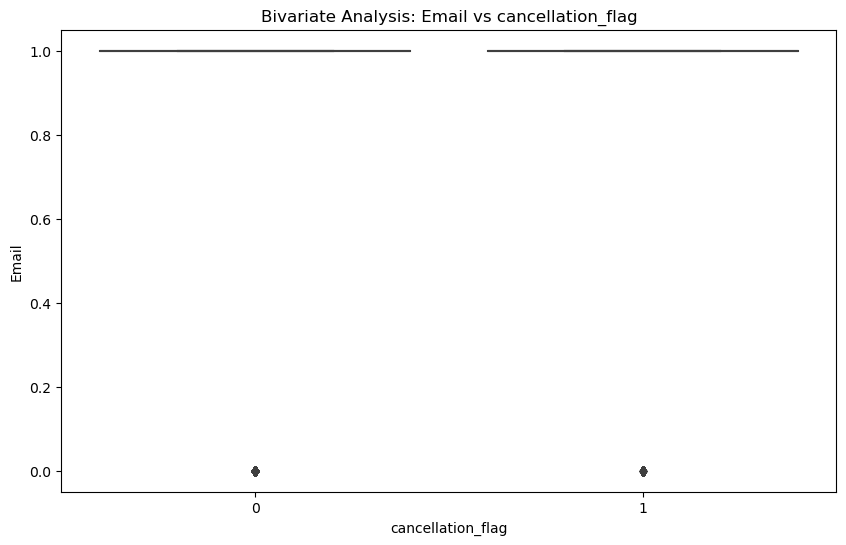


Descriptive Statistics for Email by cancellation_flag:

                     count      mean       std  min  25%  50%  75%  max
cancellation_flag                                                      
0                  84128.0  0.989516  0.101854  0.0  1.0  1.0  1.0  1.0
1                   7263.0  0.989536  0.101764  0.0  1.0  1.0  1.0  1.0

---------------------------------------



In [73]:
bivar(auth_ads)

In [74]:

import pandas as pd
import scipy.stats as stats


def bivar_test(dataset):
    # Create a DataFrame to store the test results
    results_df = pd.DataFrame(columns=['Variable', 'Test', 'Statistic', 'P-value'])

    # Perform ANOVA test for numerical variables
    numerical_vars = dataset.select_dtypes(include='number').columns.tolist()
    categorical_vars = dataset.select_dtypes(include='object').columns.tolist()
    target_var = 'cancellation_flag'

    for num_var in numerical_vars:
        if num_var != target_var:
            # Perform ANOVA test
            result = stats.f_oneway(dataset[num_var][dataset[target_var] == 0],
                                    dataset[num_var][dataset[target_var] == 1])

            results_df = pd.concat([results_df, pd.DataFrame({
                'Variable': [num_var],
                'Test': ['ANOVA'],
                'Statistic': [result.statistic],
                'P-value': [result.pvalue]
            })], ignore_index=True)

    # Perform Chi-square test for categorical and binary variables
    for cat_var in categorical_vars:
        if cat_var != target_var:
            if dataset[cat_var].nunique() < 20 :
                # Create a contingency table
                contingency_table = pd.crosstab(dataset[cat_var], dataset[target_var])
                print(cat_var)
                # Perform Chi-square test
                result = stats.chi2_contingency(contingency_table)

                results_df = pd.concat([results_df, pd.DataFrame({
                    'Variable': [cat_var],
                    'Test': ['Chi-square'],
                    'Statistic': [result.statistic],
                    'P-value': [result.pvalue]
                })], ignore_index=True)

    # Save the results to a CSV file
    results_df.to_csv('test_results.csv', index=False)

In [75]:
bivar_test(auth_ads)

Each of the input arrays is constant;the F statistic is not defined or infinite
Each of the input arrays is constant;the F statistic is not defined or infinite
Each of the input arrays is constant;the F statistic is not defined or infinite


In [89]:
#Filtering for features that are correleated with target variable i.e. p<0.05
df = pd.read_csv('test_results.csv')
df= df.loc[df['P-value']<=0.05].copy()

In [90]:
selected_columns = [col for col in auth_ads.columns if col in df['Variable']]

In [103]:
columns_to_select = df['Variable'].tolist()
columns_to_select.append('cancellation_flag')
final_ADS = auth_ads[columns_to_select]

In [104]:
#Final 
final_ADS.shape

(91391, 78)

In [97]:
del appointments 
del claims
del health_map
del health_plan

# Algorithm evaluation
0) Sampling: Since time axis was not provided, creating out of time sample was impossible. Using stratified sampling  from analytical dataset to trat 20%values as test
1) In the current context, model explainability is important than accuracy hence selecing logistic and decison       tree based classification algorithm. 
2) Between bagging and boosting choosing boosting technique as bivariate analysis indicate that there are not many strong predictors. Xg boost is bvest algorithm when dealing with weak predictors
3) Optimizing learning rate, depth and regulatization parameter to reduce overfit and stable model 
4) Evaluation metrics :
5) ROC helps us understand how well a model can separate the positive and negative classes 
6) F score tells how accurate the model is by considering both the correct identification of positive instances and     the ability to capture all positive instances.

In [98]:
#Model performance 

def evaluate_classification_models(dataset):

    # Split the dataset into features (X) and target variable (y)
    X = dataset.drop('cancellation_flag', axis=1)
    y = dataset['cancellation_flag']

    # Perform stratified sampling to create train and holdout datasets
    X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

    # Define the classification algorithms
    classifiers = {
        'Logistic Regression': LogisticRegression(),
        'Decision Tree': DecisionTreeClassifier(),
        'XGBoost': XGBClassifier()
    }

    # Perform cross-validation and evaluate models
    results = {}

    for clf_name, clf in classifiers.items():
        # Perform cross-validation on train dataset
        scores_train = cross_val_score(clf, X_train, y_train, cv=5, scoring='roc_auc')
        avg_roc_auc_train = scores_train.mean()

        # Fit the model on the train dataset
        clf.fit(X_train, y_train)

        # Make predictions on the train dataset
        y_pred_train = clf.predict(X_train)

        # Calculate evaluation metrics for train dataset
        Roc_train = roc_auc_score(y_train, y_pred_train)
        precision_train = precision_score(y_train, y_pred_train)
        recall_train = recall_score(y_train, y_pred_train)
        f1_train = f1_score(y_train, y_pred_train)

        # Make predictions on the holdout dataset
        y_pred_holdout = clf.predict(X_holdout)

        # Calculate evaluation metrics for holdout dataset
        Roc_train = roc_auc_score(y_holdout, y_pred_holdout)
        precision_holdout = precision_score(y_holdout, y_pred_holdout)
        recall_holdout = recall_score(y_holdout, y_pred_holdout)
        f1_holdout = f1_score(y_holdout, y_pred_holdout)

        # Store the results
        results[clf_name] = {
            'Train ROC AUC': avg_roc_auc_train,
            
            'Train Precision': precision_train,
            'Train Recall': recall_train,
            'Train F1 Score': f1_train,
             'Holdout ROC AUC': avg_roc_auc_train,
            'Holdout Precision': precision_holdout,
            'Holdout Recall': recall_holdout,
            'Holdout F1 Score': f1_holdout
        }

    # Return the results
    return results

In [105]:
evaluate_classification_models(final_ADS)

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


{'Logistic Regression': {'Train ROC AUC': 0.5064335330419836,
  'Train Precision': 0.0,
  'Train Recall': 0.0,
  'Train F1 Score': 0.0,
  'Holdout ROC AUC': 0.5064335330419836,
  'Holdout Precision': 0.0,
  'Holdout Recall': 0.0,
  'Holdout F1 Score': 0.0},
 'Decision Tree': {'Train ROC AUC': 0.814142204004862,
  'Train Precision': 0.821826280623608,
  'Train Recall': 0.19053356282271944,
  'Train F1 Score': 0.30934749196590744,
  'Holdout ROC AUC': 0.814142204004862,
  'Holdout Precision': 0.4112903225806452,
  'Holdout Recall': 0.10529938059187888,
  'Holdout F1 Score': 0.16767123287671234},
 'XGBoost': {'Train ROC AUC': 0.8714153183045431,
  'Train Precision': 0.7744107744107744,
  'Train Recall': 0.039586919104991396,
  'Train F1 Score': 0.07532339937776324,
  'Holdout ROC AUC': 0.8714153183045431,
  'Holdout Precision': 0.5616438356164384,
  'Holdout Recall': 0.028217481073640742,
  'Holdout F1 Score': 0.053735255570117955}}

#Choosing to further optimize XGboost. Using grid search to do hyperparameterization
#Limiting hyperparameter optimization due to limited RAM capacity

In [112]:
def final_model(dataset):

    # Split the dataset into features (X) and target variable (y)
    X = dataset.drop('cancellation_flag', axis=1)
    y = dataset['cancellation_flag']

    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y,stratify =y, test_size=0.2, random_state=42)
   

    # Define the parameter grid for optimization
    param_grid = {
        'learning_rate': [0.1,0.01],
        'max_depth': [3,5],
        'reg_lambda': [0.01]
    }


    # Initialize the XGBoost classifier
    xgb_clf = xgb.XGBClassifier(n_estimators=100, random_state=42)

    # Perform Grid Search to find the best parameters
    grid_search = GridSearchCV(xgb_clf, param_grid, scoring='roc_auc', cv=5)
    grid_search.fit(X_train, y_train)

    # Get the best parameters and score
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    print(best_score)
    # Initialize the XGBoost classifier with the best parameters
    best_xgb_clf = xgb.XGBClassifier(n_estimators=100, random_state=42, **best_params)

    # Train the model with the best parameters on the train set
    best_xgb_clf.fit(X_train, y_train)

    # Make predictions on the train and holdout sets
    y_pred_train = best_xgb_clf.predict(X_train)
    y_pred_holdout = best_xgb_clf.predict(X_test)

    # Calculate evaluation metrics on the train and holdout sets
    roc_auc_train = roc_auc_score(y_train, y_pred_train)
    
    roc_auc_holdout = roc_auc_score(y_test, y_pred_holdout)
    precision_train = precision_score(y_train, y_pred_train)
    precision_holdout = precision_score(y_test, y_pred_holdout)
    recall_train = recall_score(y_train, y_pred_train)
    recall_holdout = recall_score(y_test, y_pred_holdout)
    f1_score_train = f1_score(y_train, y_pred_train)
    f1_score_holdout = f1_score(y_test, y_pred_holdout)

    # Print the best parameters, best score, and evaluation metrics
    print("Best Parameters:", best_params)
    print("Best Score:", best_score)
    print("ROC AUC (Train):", roc_auc_train)
    print("ROC AUC (Holdout):", roc_auc_holdout)
    print("Precision (Train):", precision_train)
    print("Precision (Holdout):", precision_holdout)
    print("Recall (Train):", recall_train)
    print("Recall (Holdout):", recall_holdout)
    print("F1 Score (Train):", f1_score_train)
    print("F1 Score (Holdout):", f1_score_holdout)
       
    # Calculate the SHAP values
    #explainer = TreeExplainer(model)
    #shap_values = explainer.shap_values(X_test)

    # Plot the SHAP value chart
    #shap.plots.bar(shap_values)

      # Get feature importance
    feature_importance = best_xgb_clf.feature_importances_

    # Print feature importance
    for feature, importance in zip(X.columns, feature_importance):
        print(f"{feature}: {importance}")


In [113]:

final_model(auth_ads)

0.8595512789715023
Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'reg_lambda': 0.01}
Best Score: 0.8595512789715023
ROC AUC (Train): 0.5034051947931053
ROC AUC (Holdout): 0.501975545989562
Precision (Train): 0.8888888888888888
Precision (Holdout): 0.6666666666666666
Recall (Train): 0.0068846815834767644
Recall (Holdout): 0.0041293874741913286
F1 Score (Train): 0.013663535439795047
F1 Score (Holdout): 0.008207934336525308
client_key: 0.0018230457790195942
provider_location_id: 0.002013449789956212
primary_cpt: 0.02437755838036537
npi: 0.0031398413702845573
procedurecode_377895: 0.05121973156929016
procedurecode_377896: 0.07666445523500443
procedurecode_377897: 0.018023332580924034
procedurecode_377898: 0.07888050377368927
procedurecode_377899: 0.03716779500246048
procedurecode_377900: 0.050687771290540695
procedurecode_377901: 0.0
procedurecode_377902: 0.0
procedurecode_377904: 0.0
procedurecode_377913: 0.003333393717184663
procedurecode_377915: 0.02407572977244854
procedureco

# Conclusion 
Model performance with ROC of 50% and F1 score closer to zero indicates that model is unable to distinguish between ones and zeros. 
It does not help in predicting authorization likely to be cancelled.
The key reason is poor data quality. Improvement on accuracy can be achieved by adding quality claims, healthcare and patient demographics